In [1]:
import gym
import numpy as np
from numba import jit
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import numpy as np

from gym import Env, logger, spaces
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(Env):
    metadata = {
        "render_modes": ["human", "rgb_array", "ansi"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, init_mode = 'original'):
        self.shape = (3, 3)
        self.start_state_index = np.ravel_multi_index((2, 0), self.shape)
        self.init_mode = init_mode
        self.nS = np.prod(self.shape)
        self.nA = 4
        
        # Define Cliff Location
        self._cliff = np.zeros(self.shape, dtype=bool)
        self._cliff[2, 1] = True
        
        
        # Define Locations above cliff
        self._abovecliff = np.zeros(self.shape, dtype=bool)
        self._abovecliff[1, 1] = True
        self.prob = 0.2





        # Calculate transition probabilities and rewards
        self.P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            self.P[s] = {a: [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])




        # Calculate initial state distribution
        # We always start in state (3, 0)
        if self.init_mode == 'original':
            self.initial_state_distrib = np.zeros(self.nS)
            self.initial_state_distrib[self.start_state_index] = 1.0
        
        elif self.init_mode == 'uniform':
            self.initial_state_distrib = np.ones(self.nS) / (self.nS-1)
            self.initial_state_distrib[-1] = 0
        
        else:
            raise ValueError('Invalid Initial Mode')



        
        ## For testing purpose
        self.initial_state_distrib_test = np.zeros(self.nS)
        self.initial_state_distrib_test[self.start_state_index] = 1.0
        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)
        self.render_mode = render_mode



        
        # pygame utils
        self.cell_size = (60, 60)
        self.window_size = (
            self.shape[1] * self.cell_size[1],
            self.shape[0] * self.cell_size[0],
        )
        self.window_surface = None
        self.clock = None
        self.elf_images = None
        self.start_img = None
        self.goal_img = None
        self.cliff_img = None
        self.mountain_bg_img = None
        self.near_cliff_img = None
        self.tree_img = None




    
    def _limit_coordinates(self, coord: np.ndarray) -> np.ndarray:
        """Prevent the agent from falling out of the grid world."""
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord




    
    def _calculate_transition_prob(self, current, delta):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        Args:
            current: Current position on the grid as (row, col)
            delta: Change in position for transition
        Returns:
            Tuple of ``(1.0, new_state, reward, terminated)``
        """
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        
        if self._cliff[tuple(new_position)]:
            return [(1.0, self.start_state_index, 30.0, False)]
        
        elif self._abovecliff[tuple(new_position)]:
            return [(1 - self.prob, new_state, 10.0, False), (self.prob, self.start_state_index, 30.0, False)]

        elif tuple(new_position) == current:
            return [(1.0, new_state, 15.0, False)]
        

        terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
        is_terminated = tuple(new_position) == terminal_state
        

        return [(1.0, new_state, 10.0, is_terminated)]




    
    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(range(len(transitions)), 1, replace=True, p=[t[0] for t in transitions])[0]
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        
        return (int(s), r, t, False, {"prob": p})





    
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # original
        # self.s = categorical_sample(self.initial_state_distrib, self.np_random)

        self.s = np.random.choice(range(self.nS), 1, replace=True, p=self.initial_state_distrib)[0]
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}





    
    def reset_test(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib_test, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

In [3]:
@jit(nopython=True)
def softmax_policy(s, theta):
    s = int(s)
    theta_exp = np.exp(theta[:, s])
    return theta_exp / np.sum(theta_exp)

In [4]:
@jit(nopython=True)
def log_softmax_policy_grad(s, a, theta):
    s = int(s)
    grad = np.zeros_like(theta)
    probs = softmax_policy(s, theta)
    grad[:, s] = -probs
    grad[a, s] = grad[a, s] + 1
    
    return grad

In [5]:
@jit(nopython=True)
def update_state_action_distribution(state_action_dist, 
                                     state, action, reward, next_state, next_action, 
                                     supports, gamma):
    vmin, vmax = supports[0], supports[-1]
    n_support = len(supports)
    dz = (vmax - vmin) / (n_support - 1)
    probs = np.zeros(len(supports)) + 1e-16
    next_dist = state_action_dist[next_state, next_action]
    shifted_supports = reward + gamma * supports
    
    for j in range(n_support):
        
        if shifted_supports[j] < vmin:
            probs[0] += next_dist[j]
        
        elif shifted_supports[j] > vmax:
            probs[-1] += next_dist[j]
        
        else:
            b = (shifted_supports[j] - vmin) / dz
            l = int(np.floor(b))
            u = int(np.ceil(b))

            probs[l] += next_dist[j] * (u + (l == u) - b) # incase b is an integer, b == u == l
            probs[u] += next_dist[j] * (b - l)
    
    probs = probs / np.sum(probs)
    state_action_dist[state, action] = 0.9 * state_action_dist[state, action] + 0.1 * probs

    return state_action_dist

In [6]:
def policy_evaluation(vmin, vmax, n_support, gamma,
                      policy, theta, shape,
                      episode, steps):

    supports = np.linspace(vmin, vmax, n_support)
    dz = (vmax - vmin) / (n_support - 1)
    n_state = shape[0] * shape[1]
    n_action = 4

    state_action_dist = np.ones((n_state, n_action, n_support)) / n_support
    state_action_dist[-1, :, 0] = 1.0
    state_action_dist[-1, :, 1:] = 0.0

    trajectorys = []
    for _ in range(episode):

        trajectory = []
        
        train_env = CliffWalkingEnv(init_mode='original')
        
        state, _ = train_env.reset()
        trajectory.append(state)
        
        for step in range(steps):
            
            action = np.random.choice(range(n_action), 1, replace=True, p=policy(state, theta))[0]
            
            next_state, reward, done, _, _ = train_env.step(action)

            trajectory.append(action)
            trajectory.append(reward)
            trajectory.append(next_state)
            
            
            next_action = np.random.choice(range(n_action), 1, replace=True, p=policy(next_state, theta))[0]
            
            state_action_dist = update_state_action_distribution(state_action_dist, 
                                                                 state, action, reward, next_state, next_action,
                                                                 supports, gamma)
            state = next_state
            
            if done:
                trajectorys.append(np.array(trajectory))
                break
        
        trajectorys.append(np.array(trajectory))
    
    return state_action_dist, trajectorys

In [47]:
@jit(nopython=True)
def state_value_distribution(state_action_dist, s, policy, theta):
    s = int(s)
    dist = state_action_dist[s]
    probs = policy(s, theta).reshape(-1, 1)
    state_prob = np.sum(dist * probs, axis=0)
    return state_prob / np.sum(state_prob)

In [8]:
def sample_trajectory(env, policy, theta, path_length):
    trajectory = []
    state, _ = env.reset()
    trajectory.append(state)
    while len(trajectory) <= 3 * path_length:
        action = np.random.choice(range(env.action_space.n), 1, replace=True, p=policy(state, theta))[0]
        trajectory.append(action)
        state, reward, done, truncated, info = env.step(action)
        trajectory.append(reward)
        trajectory.append(state)
        
        if done:
            break
    
    return np.array(trajectory)

In [9]:
@jit(nopython=True)
def pushforward_one_measure_one_pair(measure, r, gamma, supports):
    vmin, vmax = supports[0], supports[-1]
    n_support = len(supports)
    dz = (vmax - vmin) / (n_support - 1)

    weights = np.zeros(len(supports))
    shifted_supports = r + gamma * supports

    for j in range(n_support):
        
        if shifted_supports[j] < vmin:
            weights[0] += measure[j]
        
        elif shifted_supports[j] > vmax:
            weights[-1] += measure[j]

        else:
            b = (shifted_supports[j] - vmin) / dz
            l = int(np.floor(b))
            u = int(np.ceil(b))
    
            weights[l] += measure[j] * (u + (l == u) - b)
            weights[u] += measure[j] * (b - l)

    return weights

In [10]:
@jit(nopython=True)
def pushforward_all_measure_one_pair(measures, r, gamma, supports):
    n_state, n_action, n_sup = measures.shape
    for s in range(n_state):
        for a in range(n_action):
            measures[s, a] = pushforward_one_measure_one_pair(measures[s, a], r, gamma, supports)
    return measures

In [11]:
@jit(nopython=True)
def pushforward_one_trajectory(measures, trajectory, gamma, supports):
    if len(trajectory) != 0:
        trajectory_copy = np.copy(trajectory)

        for i in range(len(trajectory_copy) // 3):
            trajectory_copy[i*3+2] = trajectory_copy[i*3+2] * gamma ** 0

        for r in trajectory_copy[::-1][0:len(trajectory_copy):3]:
            measures = pushforward_all_measure_one_pair(measures, r, gamma, supports)
    
    return measures

In [12]:
@jit(nopython=True)
def state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports):
    log_grad_weight_state_dist = []
    for s in range(9):
        res = np.zeros((4, 9, len(supports)))
        
        for a in range(4):
            prob = policy(s, theta)[a]
            res = res + prob * log_policy_grad(s, a, theta)[:, :, np.newaxis] * state_action_dist[s, a].reshape(1, 1, -1) # broadcast
        log_grad_weight_state_dist.append(res)
    
    res = np.zeros((4, 9, len(supports)), dtype=np.float64)

    # For each time step, the trajectory should be like: (s_0),(s_0, a_0, r_0, s_1), (s_0, a_0, r_0, s_1, a_1, r_1, s_2) ....
    for i in range((len(trajectory)-1) // 3 + 1):
        sub_trajectory = trajectory[:3*i+1]
        s = int(sub_trajectory[-1]) # The target initial distribution before pushforwards
        # the input trajectory should not include the final state, a.k.a, (), (s_0, a_0, r_0), (s_0, a_0, r_0, s_1, a_1, r_1)
        res = res + pushforward_one_trajectory(log_grad_weight_state_dist[s], sub_trajectory[:-1], gamma, supports)
    
    return res

In [13]:
def CVaR_policy_gradient(state_action_dist, trajectory,
                         policy, log_policy_grad, theta, gamma, 
                         supports, alpha):

    # Step 1: Compute the distribution at initial state
    init_state = int(trajectory[0])
    state_value_dist = state_value_distribution(state_action_dist, init_state, policy, theta)

    # Step 2: Compute the alpha-quantile and filter out tail supports
    if_tail = np.cumsum(state_value_dist) > alpha
    q_alpha = supports[if_tail][0]
    
    tail_supports = supports[if_tail]
    tail_supports_idx = np.where(if_tail)[0]
    tail_prob = state_value_dist[if_tail]
    
    # Step 3: Compute the gradient: 4 x 9 x n_support
    sa_grad = state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports)
    
    # Step 4: Compute CVaR policy gradient
    cvar_grad = np.zeros_like(theta)
    for i in range(len(tail_supports_idx)):
        cvar_grad = cvar_grad + sa_grad[:, :, i] * (tail_supports[i] - q_alpha)
    
    cvar_grad = cvar_grad / (1 - alpha)
    
    return cvar_grad

In [14]:
def Expectation_policy_gradient(state_action_dist, trajectory, 
                                policy, log_policy_grad, theta, gamma, 
                                supports):
    # Step 1: Compute the distribution at initial state
    init_state = int(trajectory[0])
    state_value_dist = state_value_distribution(state_action_dist, init_state, policy, theta)

    # Step 2: Compute the gradient: 4 x 9 x n_support
    sa_grad = state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports)

    # Step 3: Compute Expectation Policy Gradient
    grad = np.zeros_like(theta)
    for i in range(len(supports)):
        grad = grad + sa_grad[:, :, i] * supports[i]

    return grad

In [15]:
def sample_based_CVaR_gradient(trajectorys, policy, log_policy_grad, theta, gamma, alpha):
    """
    trajectorys: a list of trajectorys -> must be sampled at the same time
    """
    ## Compute Value Distributions
    z_ls = []
    for trajectory in trajectorys:
        z = np.array(trajectory[2::3])
        # print(z)
        discount = np.array([gamma ** i for i in range(len(z))])
        # print(discount)
        z_ls.append(np.sum(discount * z))
    # print(z_ls)
    ## alpha-quantile
    q_alpha = np.quantile(z_ls, alpha, method='inverted_cdf')
    # print(q_alpha)
    
    ## Compute the trajectory probability
    def log_prob_traj(trajectory):
        res = 0
        sub_trajectory = trajectory[:-1]
        s_ls = sub_trajectory[::3]
        a_ls = sub_trajectory[1::3]
        for s, a in zip(s_ls, a_ls):
            res += log_policy_grad(s, int(a), theta)
        return res
    
    # Compute the gradient
    grad = 0
    for i in range(len(trajectorys)):
        if z_ls[i] > q_alpha:
            res = log_prob_traj(trajectorys[i]) * (z_ls[i] - q_alpha)
            # print(res)
            grad = grad + res / len(trajectorys)

    return grad

In [32]:
def train(theta, lr, alpha=0.9, episode=5000, 
          vmin=0, vmax=2000, n_support=51, 
          gamma=0.95, policy=softmax_policy, log_policy_grad=log_softmax_policy_grad, 
          steps = 100, path_length=50, 
          num_train=50, shape=(3, 3)):
    
    
    supports = np.linspace(vmin, vmax, n_support)
    theta_ls = [np.copy(theta)]
    grad_ls = []
    
    for n_train in tqdm(range(num_train)):
        ###################### Test Starts ######################
        total_cost = 0
        path = []
        env = CliffWalkingEnv(init_mode='original')
        env.reset()
        state, _ = env.reset_test()
        for n_step in range(10):
            path.append(state)
            action = np.argmax(policy(state, theta))
            state, reward, done, truncated, info = env.step(action)
            total_cost += reward
            if done:
                path.append(state)
                break
        
        if (n_train+1) % 2 == 0:
            print('Verbose One Episode Policy: \n')
            print(f'State 6: {policy(6, theta)}')
            print(f'State 3: {policy(3, theta)}')
            print(f'State 0: {policy(0, theta)}')
            print(f'State 1: {policy(1, theta)}')
            print(f'State 2: {policy(2, theta)}')
            print(f'State 4: {policy(4, theta)}')
            print(f'State 5: {policy(5, theta)}')
        
            if done:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is Reached \n')
            
            else:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is NOT Reached \n')

        env.close()
        ###################### Test Ends ######################
        
        
        
        
        ###################### Policy Evaluation Starts ######################
        state_action_dist, trajectorys = policy_evaluation(vmin, vmax, n_support, gamma, 
                                              policy, theta, shape, 
                                              episode, steps)
        ###################### Policy Evaluation Ends ######################

        
        
        
        
        
        
        ###################### Policy Improvement Starts ######################
        grad = 0
        # trajectorys = [sample_trajectory(CliffWalkingEnv(init_mode='original'), policy, theta, path_length) for _ in range(n_trajectory)]
        for trajectory in trajectorys:
            grad += CVaR_policy_gradient(state_action_dist, trajectory, 
                                        policy, log_policy_grad, theta, gamma, 
                                        supports, alpha)
        grad /= len(trajectorys)
        theta -= lr * (grad / np.linalg.norm(grad))   ## 归一化, for a fair comparison
        ###################### Policy Improvement Ends ######################
        
        
        # Storage
        theta_ls.append(np.copy(theta))
        grad_ls.append(grad)
        print(np.linalg.norm(grad, ord=np.inf))
    
    return theta, theta_ls, grad_ls

## Risk Averse

In [33]:
np.random.seed(49)
THETA_AVERSE = np.random.uniform(-5, 5, (4, 9))

In [36]:
theta_90_formal = []
grad_90_formal = []

for num in range(10):
    print(f'Number of Training: {num}')
    _, theta_ls, grad_ls = train(theta=np.copy(THETA_AVERSE), lr=0.3, alpha=0.9, episode=1000, num_train=100)
    theta_90_formal.append(theta_ls)
    grad_90_formal.append(grad_ls)

Number of Training: 0


  1%|▍                                        | 1/100 [00:40<1:06:23, 40.24s/it]

136.62220489989917
Verbose One Episode Policy: 

State 6: [0.33371105 0.01159277 0.04096048 0.6137357 ]
State 3: [0.86101554 0.00918649 0.1284341  0.00136387]
State 0: [0.00243064 0.9939114  0.00217071 0.00148726]
State 1: [0.00829169 0.96128564 0.01590058 0.01452209]
State 2: [8.85300053e-01 1.28236573e-02 1.01689632e-01 1.86657758e-04]
State 4: [0.03676134 0.12121642 0.47102498 0.37099726]
State 5: [0.03074847 0.45792897 0.05317902 0.45814354]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:19<1:04:55, 39.75s/it]

197.90243572271413


  3%|█▏                                       | 3/100 [01:54<1:00:41, 37.54s/it]

158.9069475987664
Verbose One Episode Policy: 

State 6: [0.39959069 0.01158651 0.04149303 0.54732977]
State 3: [0.84720064 0.00944203 0.14197561 0.00138172]
State 0: [0.00222531 0.99441757 0.00199376 0.00136337]
State 1: [0.00805705 0.96209929 0.01553487 0.01430878]
State 2: [8.72135810e-01 1.34282582e-02 1.14241107e-01 1.94824966e-04]
State 4: [0.03750484 0.12644214 0.43979689 0.39625613]
State 5: [0.0334958  0.5296186  0.08358175 0.35330386]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:26<56:41, 35.43s/it]

217.8545196398012


  5%|██▏                                        | 5/100 [02:53<50:55, 32.16s/it]

318.31047258504475
Verbose One Episode Policy: 

State 6: [0.4700926  0.01140279 0.04098719 0.47751742]
State 3: [0.84746914 0.00921619 0.14199074 0.00132393]
State 0: [0.0020282  0.99487732 0.00183815 0.00125633]
State 1: [0.00772443 0.96337733 0.01500343 0.01389481]
State 2: [8.38031327e-01 1.47571130e-02 1.46997385e-01 2.14175753e-04]
State 4: [0.03807031 0.13149823 0.41595573 0.41447573]
State 5: [0.03612603 0.53575581 0.13464894 0.29346922]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:14<44:37, 28.48s/it]

312.12129831095666


  7%|███                                        | 7/100 [03:29<37:22, 24.11s/it]

382.6453269858775
Verbose One Episode Policy: 

State 6: [0.54239456 0.01098234 0.03962643 0.40699667]
State 3: [0.85840748 0.0086747  0.13167407 0.00124374]
State 0: [0.00188104 0.99523968 0.00171108 0.0011682 ]
State 1: [0.0070918  0.96564023 0.01412374 0.01314423]
State 2: [7.78969318e-01 1.65966524e-02 2.04192823e-01 2.41206880e-04]
State 4: [0.0385606  0.13928127 0.39628017 0.42587796]
State 5: [0.03651137 0.53087197 0.20124401 0.23137266]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:39<30:14, 19.72s/it]

438.8603776129909


  9%|███▊                                       | 9/100 [03:47<23:56, 15.79s/it]

423.3446683133767
Verbose One Episode Policy: 

State 6: [0.62619913 0.01006598 0.03628219 0.3274527 ]
State 3: [0.8720768  0.00795263 0.1188217  0.00114886]
State 0: [0.00174254 0.99557999 0.00158887 0.0010886 ]
State 1: [0.00641853 0.96874744 0.01283817 0.01199586]
State 2: [7.17990348e-01 1.81589116e-02 2.63588955e-01 2.61786162e-04]
State 4: [0.03822471 0.14676212 0.3824256  0.43258758]
State 5: [0.0365748  0.4823091  0.29556489 0.18555121]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:52<18:43, 12.48s/it]

414.86908521297045


 11%|████▌                                     | 11/100 [03:55<14:36,  9.85s/it]

407.2053351166826
Verbose One Episode Policy: 

State 6: [0.67930936 0.0091517  0.03355485 0.27798408]
State 3: [0.89003746 0.00693972 0.10199485 0.00102796]
State 0: [0.00162578 0.99586842 0.0014839  0.0010219 ]
State 1: [0.00545406 0.97326594 0.01092552 0.01035448]
State 2: [6.45052296e-01 1.91991123e-02 3.35472142e-01 2.76450444e-04]
State 4: [0.0373871  0.15241778 0.37166644 0.43852868]
State 5: [0.03389625 0.42172127 0.40893538 0.13544709]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:58<11:21,  7.75s/it]

509.5365812981579


 13%|█████▍                                    | 13/100 [04:01<08:57,  6.18s/it]

418.34342938004625
Verbose One Episode Policy: 

State 6: [0.71663199 0.00810035 0.03021922 0.24504845]
State 3: [0.90696648 0.00584241 0.0862835  0.00090761]
State 0: [1.51635361e-03 9.96137274e-01 1.38691118e-03 9.59461129e-04]
State 1: [0.0044651  0.97827211 0.00880846 0.00845433]
State 2: [5.64326384e-01 1.95829249e-02 4.15807063e-01 2.83628248e-04]
State 4: [0.0361528  0.15256739 0.36515733 0.44612248]
State 5: [0.03016869 0.33193817 0.53864043 0.09925271]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [04:03<07:07,  4.97s/it]

308.7033631248369


 15%|██████▎                                   | 15/100 [04:05<05:42,  4.03s/it]

465.45897784921124
Verbose One Episode Policy: 

State 6: [0.7621318  0.00683095 0.0262542  0.20478305]
State 3: [9.18370935e-01 4.96164905e-03 7.58552977e-02 8.12117981e-04]
State 0: [1.41464425e-03 9.96386345e-01 1.29805477e-03 9.00955639e-04]
State 1: [0.00369561 0.9822745  0.00712422 0.00690566]
State 2: [4.68255017e-01 1.94147051e-02 5.12047659e-01 2.82619568e-04]
State 4: [0.03470458 0.15156064 0.36165251 0.45208226]
State 5: [0.02537508 0.25353976 0.65112063 0.06996454]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:07<04:41,  3.35s/it]

321.0705750328849


 17%|███████▏                                  | 17/100 [04:08<03:55,  2.83s/it]

319.0218396399881
Verbose One Episode Policy: 

State 6: [0.80121986 0.00541169 0.02190339 0.17146506]
State 3: [9.28503542e-01 4.17717030e-03 6.65967278e-02 7.22560036e-04]
State 0: [1.30630745e-03 9.96657558e-01 1.19763675e-03 8.38497325e-04]
State 1: [0.00297659 0.98591248 0.00559714 0.00551378]
State 2: [3.83648927e-01 1.82711636e-02 5.97809681e-01 2.70228132e-04]
State 4: [0.03336592 0.14817097 0.35670749 0.46175563]
State 5: [0.02005871 0.18476501 0.74891464 0.04626163]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:10<03:21,  2.46s/it]

321.95358702614493


 19%|███████▉                                  | 19/100 [04:11<02:55,  2.16s/it]

363.3616615687693
Verbose One Episode Policy: 

State 6: [0.82386567 0.00454247 0.01864319 0.15294868]
State 3: [9.30010647e-01 3.72590540e-03 6.55829685e-02 6.80478771e-04]
State 0: [1.21280816e-03 9.96889554e-01 1.11329166e-03 7.84346068e-04]
State 1: [0.00243868 0.98875266 0.00438823 0.00442042]
State 2: [3.28380784e-01 1.68140741e-02 6.54550062e-01 2.55080047e-04]
State 4: [0.03244901 0.14389207 0.35013384 0.47352508]
State 5: [0.01452253 0.12772539 0.83127291 0.02647917]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:13<02:36,  1.96s/it]

226.92796028426906


 21%|████████▊                                 | 21/100 [04:14<02:21,  1.80s/it]

324.6634124857635
Verbose One Episode Policy: 

State 6: [0.85471645 0.0036786  0.01514526 0.12645968]
State 3: [9.41600510e-01 3.05186806e-03 5.47576413e-02 5.89980889e-04]
State 0: [1.11289851e-03 9.97133882e-01 1.02720892e-03 7.26010796e-04]
State 1: [0.00198958 0.99104815 0.00345184 0.00351042]
State 2: [3.03206090e-01 1.49922745e-02 6.81561444e-01 2.40191959e-04]
State 4: [0.03181239 0.13942417 0.34393988 0.48482357]
State 5: [0.01031378 0.08749016 0.88634573 0.01585032]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:16<02:09,  1.67s/it]

312.6696777908576


 23%|█████████▋                                | 23/100 [04:17<02:00,  1.57s/it]

247.1147589399719
Verbose One Episode Policy: 

State 6: [0.87979886 0.00298897 0.01212769 0.10508448]
State 3: [9.47192686e-01 2.65593129e-03 4.96145502e-02 5.36832863e-04]
State 0: [1.02190203e-03 9.97361510e-01 9.44938997e-04 6.71648837e-04]
State 1: [0.00164817 0.99275671 0.00277773 0.00281739]
State 2: [2.27540041e-01 1.27185347e-02 7.59528961e-01 2.12463463e-04]
State 4: [0.03155471 0.13753467 0.34610774 0.48480287]
State 5: [0.00691048 0.06371393 0.92000344 0.00937216]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:18<01:53,  1.49s/it]

291.6687857618627


 25%|██████████▌                               | 25/100 [04:20<01:47,  1.44s/it]

196.4740417428225
Verbose One Episode Policy: 

State 6: [0.90793981 0.00225903 0.00859288 0.08120828]
State 3: [9.53440458e-01 2.24796635e-03 4.38323091e-02 4.79266662e-04]
State 0: [9.29865926e-04 9.97589371e-01 8.63343043e-04 6.17420327e-04]
State 1: [0.00135241 0.99413276 0.00222925 0.00228558]
State 2: [2.41437272e-01 1.17516225e-02 7.46602874e-01 2.08231043e-04]
State 4: [0.03137753 0.13596708 0.35038485 0.48227055]
State 5: [0.00464386 0.04389948 0.9455387  0.00591797]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:21<01:43,  1.40s/it]

194.79584469948207


 27%|███████████▎                              | 27/100 [04:22<01:40,  1.38s/it]

212.2503655804684
Verbose One Episode Policy: 

State 6: [0.92364992 0.0018511  0.0069066  0.06759239]
State 3: [9.62322804e-01 1.82434125e-03 3.54435181e-02 4.09336845e-04]
State 0: [8.40399035e-04 9.97815588e-01 7.80737480e-04 5.63275216e-04]
State 1: [0.0011139  0.99524882 0.00178857 0.00184871]
State 2: [2.25039874e-01 1.05806526e-02 7.64183560e-01 1.95913317e-04]
State 4: [0.03121642 0.13496845 0.34963584 0.48417929]
State 5: [0.0033743  0.03198537 0.96058864 0.00405169]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:24<01:37,  1.36s/it]

193.13412120208218


 29%|████████████▏                             | 29/100 [04:25<01:35,  1.34s/it]

164.1545782434999
Verbose One Episode Policy: 

State 6: [0.93975432 0.00143432 0.00515921 0.05365214]
State 3: [9.73125355e-01 1.38715535e-03 2.51597089e-02 3.27781261e-04]
State 0: [7.53620701e-04 9.98032657e-01 7.03436532e-04 5.10286022e-04]
State 1: [9.14816647e-04 9.96154323e-01 1.43594433e-03 1.49491595e-03]
State 2: [1.64310474e-01 7.59329319e-03 8.27935771e-01 1.60461885e-04]
State 4: [0.03109283 0.13419373 0.34698602 0.48772742]
State 5: [0.00250215 0.02472907 0.96989349 0.00287529]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:26<01:31,  1.31s/it]

193.10030944280467


 31%|█████████████                             | 31/100 [04:28<01:31,  1.32s/it]

163.31615938223433
Verbose One Episode Policy: 

State 6: [0.95042265 0.00113671 0.00373777 0.04470286]
State 3: [9.81085937e-01 1.06348289e-03 1.75881607e-02 2.62419897e-04]
State 0: [6.83503974e-04 9.98213686e-01 6.37495034e-04 4.65315097e-04]
State 1: [7.72132249e-04 9.96808875e-01 1.18213121e-03 1.23686150e-03]
State 2: [1.28578865e-01 5.36962962e-03 8.65918978e-01 1.32527413e-04]
State 4: [0.03103492 0.13375047 0.34711686 0.48809776]
State 5: [0.00175697 0.0170871  0.97916381 0.00199212]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:29<01:28,  1.31s/it]

155.8098166778166


 33%|█████████████▊                            | 33/100 [04:30<01:26,  1.29s/it]

148.6206917839671
Verbose One Episode Policy: 

State 6: [9.60862620e-01 8.87371368e-04 2.69172566e-03 3.55582828e-02]
State 3: [9.86598982e-01 8.26268221e-04 1.23634123e-02 2.11337246e-04]
State 0: [6.07384734e-04 9.98406543e-01 5.67750435e-04 4.18322017e-04]
State 1: [6.58791793e-04 9.97308037e-01 9.88556041e-04 1.04461489e-03]
State 2: [9.08672247e-02 3.65732280e-03 9.05370919e-01 1.04533248e-04]
State 4: [0.03093225 0.13308386 0.34691517 0.48906872]
State 5: [0.0013118  0.01238317 0.98484311 0.00146191]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:31<01:23,  1.27s/it]

128.4310026799503


 35%|██████████████▋                           | 35/100 [04:33<01:22,  1.26s/it]

142.43460310907457
Verbose One Episode Policy: 

State 6: [9.71317741e-01 6.89430920e-04 1.95933537e-03 2.60334928e-02]
State 3: [9.91222079e-01 6.23413766e-04 7.99008751e-03 1.64420156e-04]
State 0: [5.44514442e-04 9.98566286e-01 5.10616804e-04 3.78582647e-04]
State 1: [5.65840890e-04 9.97710868e-01 8.35964381e-04 8.87326599e-04]
State 2: [7.37411507e-02 2.86490328e-03 9.23304095e-01 8.98506196e-05]
State 4: [0.03093453 0.13302204 0.3480214  0.48802203]
State 5: [9.66299470e-04 8.07964974e-03 9.89897899e-01 1.05615218e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:34<01:20,  1.26s/it]

124.01187640833331


 37%|███████████████▌                          | 37/100 [04:35<01:19,  1.26s/it]

117.88761965606638
Verbose One Episode Policy: 

State 6: [9.80380257e-01 5.21971828e-04 1.41294133e-03 1.76848301e-02]
State 3: [9.94062427e-01 4.83114746e-04 5.32394362e-03 1.30514977e-04]
State 0: [4.92656150e-04 9.98699040e-01 4.62680433e-04 3.45623570e-04]
State 1: [4.92038592e-04 9.98031922e-01 7.16384837e-04 7.59654560e-04]
State 2: [5.97075990e-02 2.18982267e-03 9.38026080e-01 7.64985472e-05]
State 4: [0.03090434 0.1327755  0.34732805 0.4889921 ]
State 5: [7.13328629e-04 5.18217871e-03 9.93329289e-01 7.75203267e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:36<01:16,  1.24s/it]

110.8083331275651


 39%|████████████████▍                         | 39/100 [04:37<01:14,  1.22s/it]

102.73775107607554
Verbose One Episode Policy: 

State 6: [9.88340570e-01 3.72718929e-04 9.67172749e-04 1.03195386e-02]
State 3: [9.95746222e-01 3.89692530e-04 3.75684925e-03 1.07236266e-04]
State 0: [4.48100767e-04 9.98813071e-01 4.21990641e-04 3.16838017e-04]
State 1: [4.34394820e-04 9.98278500e-01 6.25434214e-04 6.61671019e-04]
State 2: [4.86172353e-02 1.71400102e-03 9.49603001e-01 6.57629602e-05]
State 4: [0.03087648 0.13271265 0.3468091  0.48960177]
State 5: [5.52004394e-04 3.52844653e-03 9.95320252e-01 5.99297154e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:39<01:13,  1.22s/it]

81.4243331137852


 41%|█████████████████▏                        | 41/100 [04:40<01:11,  1.22s/it]

81.67691555819731
Verbose One Episode Policy: 

State 6: [9.93243092e-01 2.63617489e-04 6.59964942e-04 5.83332566e-03]
State 3: [9.97051984e-01 3.08132518e-04 2.55348775e-03 8.63960869e-05]
State 0: [4.03465219e-04 9.98929933e-01 3.79582701e-04 2.87019031e-04]
State 1: [3.80680860e-04 9.98509023e-01 5.40151337e-04 5.70144981e-04]
State 2: [4.20296764e-02 1.40086647e-03 9.56511070e-01 5.83873763e-05]
State 4: [0.03087913 0.13275931 0.34700544 0.48935612]
State 5: [4.37095911e-04 2.51303905e-03 9.96575928e-01 4.73936561e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:41<01:10,  1.21s/it]

94.34072147035663


 43%|██████████████████                        | 43/100 [04:42<01:08,  1.20s/it]

77.58810868322065
Verbose One Episode Policy: 

State 6: [9.96189171e-01 1.86380753e-04 4.57207248e-04 3.16724113e-03]
State 3: [9.97862978e-01 2.51000284e-04 1.81456763e-03 7.14539173e-05]
State 0: [3.64675080e-04 9.99029653e-01 3.44147120e-04 2.61524971e-04]
State 1: [3.38361548e-04 9.98687185e-01 4.74207159e-04 5.00246122e-04]
State 2: [3.16524179e-02 1.07661695e-03 9.67222369e-01 4.85957888e-05]
State 4: [0.03087913 0.13270104 0.34802958 0.48839024]
State 5: [3.65969854e-04 1.95942049e-03 9.97278640e-01 3.95970027e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:43<01:07,  1.20s/it]

65.8904580655241


 45%|██████████████████▉                       | 45/100 [04:45<01:05,  1.20s/it]

61.303650668681726
Verbose One Episode Policy: 

State 6: [9.97438862e-01 1.43797913e-04 3.43874119e-04 2.07346574e-03]
State 3: [9.98461409e-01 2.02038712e-04 1.27797650e-03 5.85753959e-05]
State 0: [3.19077124e-04 9.99147699e-01 3.01735416e-04 2.31488313e-04]
State 1: [2.89609803e-04 9.98887042e-01 4.00682293e-04 4.22665623e-04]
State 2: [2.03107173e-02 7.62673209e-04 9.78889318e-01 3.72910553e-05]
State 4: [0.03086974 0.13261431 0.34799191 0.48852404]
State 5: [2.95454468e-04 1.44805545e-03 9.97938089e-01 3.18401327e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:46<01:04,  1.20s/it]

48.68366606020081


 47%|███████████████████▋                      | 47/100 [04:47<01:03,  1.21s/it]

65.67326391879459
Verbose One Episode Policy: 

State 6: [9.98169973e-01 1.15288404e-04 2.70003073e-04 1.44473558e-03]
State 3: [9.98797726e-01 1.70653373e-04 9.81350615e-04 5.02698878e-05]
State 0: [2.81653699e-04 9.99244908e-01 2.67176964e-04 2.06261229e-04]
State 1: [2.53000462e-04 9.99035099e-01 3.45693234e-04 3.66207431e-04]
State 2: [1.15936787e-02 5.19319763e-04 9.87859837e-01 2.71642507e-05]
State 4: [0.03086974 0.13261431 0.34799191 0.48852404]
State 5: [2.44260760e-04 1.10704862e-03 9.98386018e-01 2.62672133e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:48<01:02,  1.20s/it]

42.949773623491


 49%|████████████████████▌                     | 49/100 [04:49<01:01,  1.21s/it]

49.02864803332759
Verbose One Episode Policy: 

State 6: [9.98713497e-01 9.15436318e-05 2.10234631e-04 9.84724355e-04]
State 3: [9.99049027e-01 1.44832390e-04 7.62775148e-04 4.33659248e-05]
State 0: [2.47017792e-04 9.99334538e-01 2.35210012e-04 1.83234445e-04]
State 1: [2.18075364e-04 9.99177115e-01 2.94088367e-04 3.10721437e-04]
State 2: [6.53466939e-03 3.59245416e-04 9.93086286e-01 1.97988557e-05]
State 4: [0.03086968 0.13258472 0.34850841 0.48803718]
State 5: [2.00853908e-04 8.38130231e-04 9.98745472e-01 2.15544172e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:51<01:00,  1.21s/it]

55.85315011946131


 51%|█████████████████████▍                    | 51/100 [04:52<00:59,  1.21s/it]

54.93337248696519
Verbose One Episode Policy: 

State 6: [9.98916465e-01 8.15384815e-05 1.85121959e-04 8.16874449e-04]
State 3: [9.99182418e-01 1.30301678e-04 6.47863547e-04 3.94167657e-05]
State 0: [2.25954473e-04 9.99389726e-01 2.15653034e-04 1.68666482e-04]
State 1: [1.98303858e-04 9.99256228e-01 2.65253612e-04 2.80214448e-04]
State 2: [3.02967069e-03 2.34477911e-04 9.96722573e-01 1.32788122e-05]
State 4: [0.03083272 0.13231186 0.34715542 0.48970001]
State 5: [1.78751907e-04 7.10620310e-04 9.98919191e-01 1.91436880e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:53<00:57,  1.21s/it]

32.87064961750048


 53%|██████████████████████▎                   | 53/100 [04:54<00:56,  1.20s/it]

33.24098689397795
Verbose One Episode Policy: 

State 6: [9.99193108e-01 6.68363263e-05 1.49279372e-04 5.90775898e-04]
State 3: [9.99352827e-01 1.10327918e-04 5.02904816e-04 3.39397853e-05]
State 0: [1.94411275e-04 9.99473088e-01 1.85888569e-04 1.46611710e-04]
State 1: [1.69131915e-04 9.99371804e-01 2.23285278e-04 2.35778537e-04]
State 2: [1.63257080e-03 1.63037016e-04 9.98194842e-01 9.55000571e-06]
State 4: [0.03081494 0.13218115 0.34651021 0.4904937 ]
State 5: [1.48090088e-04 5.47816482e-04 9.99145813e-01 1.58280135e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:55<00:54,  1.19s/it]

29.81413619397531


 55%|███████████████████████                   | 55/100 [04:57<00:55,  1.24s/it]

23.824761598162024
Verbose One Episode Policy: 

State 6: [9.99386095e-01 5.52675541e-05 1.21151716e-04 4.37485668e-04]
State 3: [9.99490542e-01 9.27237751e-05 3.87682988e-04 2.90507870e-05]
State 0: [1.65059447e-04 9.99550608e-01 1.58491865e-04 1.25841135e-04]
State 1: [1.42441644e-04 9.99476620e-01 1.85542960e-04 1.95394971e-04]
State 2: [8.87132924e-04 1.14414906e-04 9.98991543e-01 6.90953351e-06]
State 4: [0.03081494 0.13218115 0.34651021 0.4904937 ]
State 5: [1.21385892e-04 4.15300808e-04 9.99333838e-01 1.29475396e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:58<00:54,  1.23s/it]

19.94181153369173


 57%|███████████████████████▉                  | 57/100 [04:59<00:52,  1.22s/it]

16.425663747331146
Verbose One Episode Policy: 

State 6: [9.99547613e-01 4.44861030e-05 9.53684935e-05 3.12532018e-04]
State 3: [9.99609607e-01 7.59422114e-05 2.90113653e-04 2.43374967e-05]
State 0: [1.33871152e-04 9.99633879e-01 1.28828580e-04 1.03421220e-04]
State 1: [1.15357614e-04 9.99580373e-01 1.48661115e-04 1.55608185e-04]
State 2: [5.33983319e-04 8.43114520e-05 9.99376450e-01 5.25567209e-06]
State 4: [0.03081494 0.13218115 0.34651021 0.4904937 ]
State 5: [9.62106130e-05 3.02300694e-04 9.99499112e-01 1.02377033e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [05:00<00:51,  1.22s/it]

14.74512499704239


 59%|████████████████████████▊                 | 59/100 [05:02<00:50,  1.23s/it]

12.184182232776124
Verbose One Episode Policy: 

State 6: [9.99667993e-01 3.55735218e-05 7.45190477e-05 2.21914443e-04]
State 3: [9.99704917e-01 6.13380829e-05 2.13596700e-04 2.01485578e-05]
State 0: [1.06418828e-04 9.99707581e-01 1.02643981e-04 8.33557472e-05]
State 1: [9.12777370e-05 9.99671752e-01 1.15964133e-04 1.21005908e-04]
State 2: [3.37533647e-04 6.36717131e-05 9.99594699e-01 4.09578705e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [7.58349308e-05 2.19833830e-04 9.99623834e-01 8.04972082e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [05:03<00:48,  1.22s/it]

10.394977175107195


 61%|█████████████████████████▌                | 61/100 [05:04<00:47,  1.23s/it]

8.780776831361393
Verbose One Episode Policy: 

State 6: [9.99755000e-01 2.83755367e-05 5.79837733e-05 1.58640977e-04]
State 3: [9.99782234e-01 4.84668750e-05 1.52934261e-04 1.63650241e-05]
State 0: [8.26166034e-05 9.99771667e-01 7.98759586e-05 6.58403576e-05]
State 1: [7.10711752e-05 9.99746767e-01 8.89559148e-05 9.32057754e-05]
State 2: [2.25904996e-04 4.91991029e-05 9.99721619e-01 3.27713336e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [5.91923042e-05 1.59441909e-04 9.99718698e-01 6.26675741e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [05:05<00:46,  1.21s/it]

7.4945162653349735


 63%|██████████████████████████▍               | 63/100 [05:06<00:44,  1.21s/it]

6.614316237880444
Verbose One Episode Policy: 

State 6: [9.99819767e-01 2.25071247e-05 4.48464647e-05 1.12879255e-04]
State 3: [9.99838161e-01 3.82676899e-05 1.10272906e-04 1.32981980e-05]
State 0: [6.33102625e-05 9.99824165e-01 6.13512687e-05 5.11732371e-05]
State 1: [5.45152368e-05 9.99807994e-01 6.72584856e-05 7.02321752e-05]
State 2: [1.55906684e-04 3.85043122e-05 9.99802929e-01 2.65962596e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [4.60899536e-05 1.15970733e-04 9.99789270e-01 4.86690814e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:08<00:43,  1.20s/it]

5.670489091116837


 65%|███████████████████████████▎              | 65/100 [05:09<00:42,  1.20s/it]

4.867795937733645
Verbose One Episode Policy: 

State 6: [9.99866415e-01 1.78704992e-05 3.47114922e-05 8.10027485e-05]
State 3: [9.99879137e-01 3.01566145e-05 7.99079467e-05 1.07980998e-05]
State 0: [4.84949971e-05 9.99864982e-01 4.69282689e-05 3.95949342e-05]
State 1: [4.16246593e-05 9.99854995e-01 5.06547948e-05 5.27260132e-05]
State 2: [1.08402079e-04 3.01619068e-05 9.99859272e-01 2.16383851e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [3.56192818e-05 8.36772687e-05 9.99843188e-01 3.75156726e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:10<00:40,  1.20s/it]

4.164887963391857


 67%|████████████████████████████▏             | 67/100 [05:11<00:39,  1.20s/it]

3.595675710272509
Verbose One Episode Policy: 

State 6: [9.99900675e-01 1.41623472e-05 2.68058226e-05 5.83571716e-05]
State 3: [9.99909612e-01 2.36617238e-05 5.79848166e-05 8.74158645e-06]
State 0: [3.66627437e-05 9.99897312e-01 3.56843124e-05 3.03413526e-05]
State 1: [3.16156750e-05 9.99891001e-01 3.79741546e-05 3.94088749e-05]
State 2: [7.65905458e-05 2.37299496e-05 9.99897908e-01 1.77180032e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [2.74529808e-05 6.05143324e-05 9.99883192e-01 2.88408932e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:12<00:38,  1.20s/it]

3.0952808106954284


 69%|████████████████████████████▉             | 69/100 [05:14<00:37,  1.20s/it]

2.6643124367209365
Verbose One Episode Policy: 

State 6: [9.99925427e-01 1.12485062e-05 2.07385600e-05 4.25856951e-05]
State 3: [9.99932342e-01 1.84834601e-05 4.21207259e-05 7.05368602e-06]
State 0: [2.74649548e-05 9.99922726e-01 2.67852140e-05 2.30242527e-05]
State 1: [2.39127085e-05 9.99918362e-01 2.83676156e-05 2.93573535e-05]
State 2: [5.46772182e-05 1.86886456e-05 9.99925178e-01 1.45565279e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [2.10971317e-05 4.38361644e-05 9.99912959e-01 2.21080158e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:15<00:35,  1.20s/it]

2.2613747216092843


 71%|█████████████████████████████▊            | 71/100 [05:16<00:34,  1.20s/it]

1.9850763123396713
Verbose One Episode Policy: 

State 6: [9.99944459e-01 8.85751965e-06 1.59053857e-05 3.07776930e-05]
State 3: [9.99948870e-01 1.44556853e-05 3.09696901e-05 5.70425428e-06]
State 0: [2.05224283e-05 9.99942011e-01 2.00516622e-05 1.74144927e-05]
State 1: [1.80473103e-05 9.99938949e-01 2.11609977e-05 2.18427747e-05]
State 2: [3.93555768e-05 1.47176551e-05 9.99944728e-01 1.19859989e-06]
State 4: [0.03081512 0.13209301 0.34808941 0.48900246]
State 5: [1.61826605e-05 3.18381945e-05 9.99935063e-01 1.69164054e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:17<00:33,  1.19s/it]

1.7134457340605076


 73%|██████████████████████████████▋           | 73/100 [05:18<00:32,  1.20s/it]

1.60134991092775
Verbose One Episode Policy: 

State 6: [9.99958373e-01 6.98533080e-06 1.22228553e-05 2.24185631e-05]
State 3: [9.99961581e-01 1.12288448e-05 2.26070889e-05 4.58301088e-06]
State 0: [1.53687982e-05 9.99956400e-01 1.50418128e-05 1.31889508e-05]
State 1: [1.36521081e-05 9.99954203e-01 1.58378587e-05 1.63071397e-05]
State 2: [2.86171403e-05 1.16119341e-05 9.99958780e-01 9.90450343e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [1.24350203e-05 2.32766932e-05 9.99951320e-01 1.29681751e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:20<00:30,  1.19s/it]

1.28137375609635


 75%|███████████████████████████████▌          | 75/100 [05:21<00:29,  1.18s/it]

1.1021204643477736
Verbose One Episode Policy: 

State 6: [9.99968790e-01 5.50177212e-06 9.36396950e-06 1.63440408e-05]
State 3: [9.99971177e-01 8.67427065e-06 1.64835671e-05 3.66481957e-06]
State 0: [1.14646917e-05 9.99967353e-01 1.12386660e-05 9.94391355e-06]
State 1: [1.02846509e-05 9.99965772e-01 1.18097783e-05 1.21331018e-05]
State 2: [2.08244976e-05 9.11790638e-06 9.99969241e-01 8.16824645e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [9.51152443e-06 1.69943766e-05 9.99963598e-01 9.89639176e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:22<00:28,  1.19s/it]

0.957190451392381


 77%|████████████████████████████████▎         | 77/100 [05:23<00:27,  1.21s/it]

0.8274881795631059
Verbose One Episode Policy: 

State 6: [9.99976624e-01 4.30806009e-06 7.14713445e-06 1.19211207e-05]
State 3: [9.99978350e-01 6.68310304e-06 1.20437738e-05 2.92352805e-06]
State 0: [8.55138820e-06 9.99975562e-01 8.39515706e-06 7.49110306e-06]
State 1: [7.74479314e-06 9.99974415e-01 8.80875829e-06 9.03167185e-06]
State 2: [1.52081034e-05 7.14208943e-06 9.99976976e-01 6.73460599e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [7.26582101e-06 1.24357184e-05 9.99972756e-01 7.54294970e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:24<00:26,  1.20s/it]

0.715519082119052


 79%|█████████████████████████████████▏        | 79/100 [05:26<00:24,  1.19s/it]

0.6188234642195888
Verbose One Episode Policy: 

State 6: [9.99982475e-01 3.36587258e-06 5.44545640e-06 8.71318222e-06]
State 3: [9.99983727e-01 5.13438621e-06 8.81294972e-06 2.32579127e-06]
State 0: [6.37759563e-06 9.99981714e-01 6.26961428e-06 5.63883598e-06]
State 1: [5.82929852e-06 9.99980874e-01 6.57129227e-06 6.72505080e-06]
State 2: [1.11338444e-05 5.57756472e-06 9.99982734e-01 5.54766733e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [5.54197388e-06 9.11574776e-06 9.99979601e-01 5.74099223e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:27<00:23,  1.19s/it]

0.5235047138994607


 81%|██████████████████████████████████        | 81/100 [05:28<00:22,  1.20s/it]

0.46389194651574395
Verbose One Episode Policy: 

State 6: [9.99986786e-01 2.63577265e-06 4.16253160e-06 6.41619048e-06]
State 3: [9.99987724e-01 3.94581134e-06 6.48002879e-06 1.84998281e-06]
State 0: [4.75066954e-06 9.99986336e-01 4.67614371e-06 4.23693366e-06]
State 1: [4.37790464e-06 9.99985728e-01 4.89405070e-06 4.99991336e-06]
State 2: [8.14741418e-06 4.33359247e-06 9.99987063e-01 4.55769906e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [4.21200139e-06 6.67630140e-06 9.99984758e-01 4.35419107e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:29<00:21,  1.19s/it]

0.4013031595956591


 83%|██████████████████████████████████▊       | 83/100 [05:30<00:20,  1.20s/it]

0.34721765326331056
Verbose One Episode Policy: 

State 6: [9.99990095e-01 2.04799976e-06 3.15732688e-06 4.69926397e-06]
State 3: [9.99990773e-01 3.01377381e-06 4.75007660e-06 1.46282379e-06]
State 0: [3.54612154e-06 9.99989771e-01 3.49454654e-06 3.18810095e-06]
State 1: [3.29556628e-06 9.99989320e-01 3.65576647e-06 3.72894708e-06]
State 2: [5.99098736e-06 3.36519578e-06 9.99990269e-01 3.74697864e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [3.20660198e-06 4.91352521e-06 9.99988572e-01 3.30833109e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:32<00:19,  1.20s/it]

0.3004675258085652


 85%|███████████████████████████████████▋      | 85/100 [05:33<00:17,  1.19s/it]

0.2600481553992593
Verbose One Episode Policy: 

State 6: [9.99992570e-01 1.58849141e-06 2.39239932e-06 3.44862253e-06]
State 3: [9.99993062e-01 2.29725647e-06 3.48713603e-06 1.15384377e-06]
State 0: [2.64789800e-06 9.99992342e-01 2.61218773e-06 2.39838708e-06]
State 1: [2.48038807e-06 9.99992005e-01 2.73176330e-06 2.78238582e-06]
State 2: [4.41093224e-06 2.60500314e-06 9.99992676e-01 3.07583224e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [2.43826553e-06 3.62104184e-06 9.99991430e-01 2.51089493e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:34<00:16,  1.20s/it]

0.2250946896065931


 87%|████████████████████████████████████▌     | 87/100 [05:35<00:15,  1.19s/it]

0.19486208811655018
Verbose One Episode Policy: 

State 6: [9.99994424e-01 1.22991459e-06 1.81101923e-06 2.53528663e-06]
State 3: [9.99994781e-01 1.74784394e-06 2.56346097e-06 9.07909869e-07]
State 0: [1.97804315e-06 9.99994265e-01 1.95330231e-06 1.80412559e-06]
State 1: [1.86671642e-06 9.99994014e-01 2.04216779e-06 2.07721194e-06]
State 2: [3.25134754e-06 2.01054236e-06 9.99994486e-01 2.52097599e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [1.85211247e-06 2.67206309e-06 9.99993572e-01 1.90387077e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:36<00:14,  1.19s/it]

0.16870813974322396


 89%|█████████████████████████████████████▍    | 89/100 [05:38<00:13,  1.19s/it]

0.14607897950250692
Verbose One Episode Policy: 

State 6: [9.99995813e-01 9.50638395e-07 1.36968158e-06 1.86679923e-06]
State 3: [9.99996073e-01 1.32758656e-06 1.88682039e-06 7.12686545e-07]
State 0: [1.47834961e-06 9.99995703e-01 1.46119715e-06 1.35709297e-06]
State 1: [1.40486373e-06 9.99995516e-01 1.52734681e-06 1.55162537e-06]
State 2: [2.39914417e-06 1.54740959e-06 9.99995847e-01 2.06292717e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [1.40560608e-06 1.97431028e-06 9.99995178e-01 1.44243104e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:39<00:11,  1.18s/it]

0.12649671478121638


 91%|██████████████████████████████████████▏   | 91/100 [05:40<00:10,  1.18s/it]

0.10954883645493547
Verbose One Episode Policy: 

State 6: [9.99996855e-01 7.33550573e-07 1.03504609e-06 1.37656265e-06]
State 3: [9.99997045e-01 1.00684519e-06 1.39041711e-06 5.58136777e-07]
State 0: [1.10543485e-06 9.99996780e-01 1.09353512e-06 1.02086883e-06]
State 1: [1.05731540e-06 9.99996640e-01 1.14284111e-06 1.15967422e-06]
State 2: [1.77204848e-06 1.18786939e-06 9.99996872e-01 1.68537175e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [1.06590849e-06 1.46055467e-06 9.99996381e-01 1.09207105e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:41<00:09,  1.18s/it]

0.09487914484419917


 93%|███████████████████████████████████████   | 93/100 [05:42<00:08,  1.19s/it]

0.08217996438713068
Verbose One Episode Policy: 

State 6: [9.99997637e-01 5.65130563e-07 7.81594045e-07 1.01641666e-06]
State 3: [9.99997776e-01 7.62557865e-07 1.02574839e-06 4.36114074e-07]
State 0: [8.26995842e-07 9.99997586e-01 8.18734616e-07 7.67999680e-07]
State 1: [7.95791861e-07 9.99997481e-01 8.55526424e-07 8.67206117e-07]
State 2: [1.31006335e-06 9.09680073e-07 9.99997643e-01 1.37465206e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [8.07753157e-07 1.08175610e-06 9.99997284e-01 8.26316825e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:44<00:07,  1.21s/it]

0.07118545698488347


 95%|███████████████████████████████████████▉  | 95/100 [05:45<00:06,  1.22s/it]

0.06166587371773165
Verbose One Episode Policy: 

State 6: [9.99998224e-01 4.34715140e-07 5.89823268e-07 7.51419694e-07]
State 3: [9.99998326e-01 5.76846728e-07 7.57517220e-07 3.40025617e-07]
State 0: [6.18987643e-07 9.99998190e-01 6.13248604e-07 5.77816666e-07]
State 1: [5.98996342e-07 9.99998111e-01 6.40727891e-07 6.48837682e-07]
State 2: [9.69350010e-07 6.95102766e-07 9.99998224e-01 1.11934411e-07]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [6.11752810e-07 8.02091590e-07 9.99997961e-01 6.24909717e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:46<00:04,  1.22s/it]

0.053422609301097476


 97%|████████████████████████████████████████▋ | 97/100 [05:47<00:03,  1.21s/it]

0.04628394420480412
Verbose One Episode Policy: 

State 6: [9.99998665e-01 3.33912827e-07 4.44854291e-07 5.56149918e-07]
State 3: [9.99998740e-01 4.35901870e-07 5.59986975e-07 2.64552861e-07]
State 0: [4.63511192e-07 9.99998642e-01 4.59521782e-07 4.34770608e-07]
State 1: [4.50900333e-07 9.99998583e-01 4.80061892e-07 4.85696746e-07]
State 2: [7.17821838e-07 5.30066447e-07 9.99998661e-01 9.09904448e-08]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [4.63065886e-07 5.95353731e-07 9.99998469e-01 4.72381319e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:48<00:02,  1.20s/it]

0.040101376570630336


 99%|█████████████████████████████████████████▌| 99/100 [05:50<00:01,  1.20s/it]

0.03474646051858485
Verbose One Episode Policy: 

State 6: [9.99998996e-01 2.56135472e-07 3.35353443e-07 4.12066853e-07]
State 3: [9.99999051e-01 3.29091221e-07 4.14359449e-07 2.05419421e-07]
State 0: [3.47238128e-07 9.99998981e-01 3.44463289e-07 3.27168856e-07]
State 1: [3.39444377e-07 9.99998937e-01 3.59826985e-07 3.63744695e-07]
State 2: [5.31958560e-07 4.03467864e-07 9.99998991e-01 7.38372575e-08]
State 4: [0.03041171 0.12919531 0.33397859 0.5064144 ]
State 5: [3.50352950e-07 4.42340077e-07 9.99998850e-01 3.56942530e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


0.030108079630333334
Number of Training: 1


  1%|▍                                        | 1/100 [00:40<1:07:07, 40.68s/it]

193.4915760637583
Verbose One Episode Policy: 

State 6: [0.33128747 0.01162913 0.04063623 0.61644717]
State 3: [0.86155516 0.00918232 0.12791211 0.00135041]
State 0: [0.00243245 0.99385942 0.00219724 0.00151089]
State 1: [0.00825395 0.96135568 0.01588664 0.01450374]
State 2: [8.82171862e-01 1.29965056e-02 1.04642785e-01 1.88847017e-04]
State 4: [0.0367939  0.12246583 0.47235508 0.36838519]
State 5: [0.02995712 0.50444902 0.05006563 0.41552823]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:19<1:04:49, 39.69s/it]

159.49358198462926


  3%|█▏                                       | 3/100 [01:54<1:00:45, 37.58s/it]

193.3058922302647
Verbose One Episode Policy: 

State 6: [0.38510721 0.01157581 0.04109965 0.56221733]
State 3: [0.86165846 0.00892402 0.12812807 0.00128945]
State 0: [0.00221124 0.99441591 0.0019967  0.00137615]
State 1: [0.0081427  0.961749   0.01567476 0.01443353]
State 2: [8.46736196e-01 1.44991226e-02 1.38553921e-01 2.10760021e-04]
State 4: [0.03754813 0.12817889 0.44040391 0.39386907]
State 5: [0.03236055 0.56492482 0.0791266  0.32358802]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:25<55:37, 34.76s/it]

232.58771956007564


  5%|██▏                                        | 5/100 [02:48<48:38, 30.72s/it]

264.12210779096387
Verbose One Episode Policy: 

State 6: [0.44335519 0.01135054 0.04048962 0.50480465]
State 3: [0.87028088 0.00831891 0.12020054 0.00119967]
State 0: [0.00198542 0.99495034 0.00180995 0.00125429]
State 1: [0.0078355  0.96295833 0.01513305 0.01407312]
State 2: [8.19992707e-01 1.54371781e-02 1.64346087e-01 2.24028254e-04]
State 4: [0.03831443 0.13669398 0.41301536 0.41197622]
State 5: [0.03604885 0.54267415 0.13773382 0.28354318]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:07<41:48, 26.69s/it]

351.9518621470589


  7%|███                                        | 7/100 [03:21<34:49, 22.47s/it]

367.44746923340347
Verbose One Episode Policy: 

State 6: [0.50520323 0.01099832 0.03919528 0.44460317]
State 3: [0.88260737 0.00765177 0.10862938 0.00111148]
State 0: [0.00185199 0.99528109 0.00169361 0.00117332]
State 1: [0.00717623 0.96573826 0.014007   0.01307851]
State 2: [7.75671299e-01 1.68007638e-02 2.07284958e-01 2.42979014e-04]
State 4: [0.03884419 0.14422063 0.392081   0.42485417]
State 5: [0.03758895 0.51532174 0.21839318 0.22869613]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:30<27:58, 18.24s/it]

379.54347874354676


  9%|███▊                                       | 9/100 [03:37<22:26, 14.80s/it]

364.650593677861
Verbose One Episode Policy: 

State 6: [0.5840355  0.01037352 0.03704269 0.36854829]
State 3: [0.89550872 0.00683686 0.09664072 0.0010137 ]
State 0: [0.00170222 0.99564547 0.00156389 0.00108842]
State 1: [0.00601605 0.97052118 0.01204928 0.01141349]
State 2: [7.14730786e-01 1.81083707e-02 2.66898676e-01 2.62167845e-04]
State 4: [0.03864154 0.15030379 0.37803263 0.43302204]
State 5: [0.03481471 0.52042115 0.28522107 0.15954307]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:42<17:35, 11.73s/it]

407.8470706150951


 11%|████▌                                     | 11/100 [03:46<13:45,  9.28s/it]

437.8268942593853
Verbose One Episode Policy: 

State 6: [0.64810436 0.00956688 0.03420601 0.30812276]
State 3: [0.90657224 0.00595452 0.08655189 0.00092135]
State 0: [0.00159322 0.99590891 0.00147106 0.00102682]
State 1: [0.00514402 0.97503443 0.01007569 0.00974586]
State 2: [6.46459932e-01 1.92604118e-02 3.34002951e-01 2.76704805e-04]
State 4: [0.03715626 0.15576797 0.36678087 0.44029491]
State 5: [0.03319519 0.44705227 0.39679578 0.12295676]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:49<10:48,  7.37s/it]

330.05615662185227


 13%|█████▍                                    | 13/100 [03:52<08:37,  5.94s/it]

275.8740232358677
Verbose One Episode Policy: 

State 6: [0.67938953 0.00865012 0.03185296 0.28010739]
State 3: [9.12475532e-01 5.20172009e-03 8.14765768e-02 8.46171125e-04]
State 0: [1.44010554e-03 9.96284543e-01 1.33817257e-03 9.37179294e-04]
State 1: [0.00415035 0.98003295 0.00794537 0.00787134]
State 2: [5.55176030e-01 1.98089934e-02 4.24730508e-01 2.84468757e-04]
State 4: [0.03565056 0.15807713 0.35669396 0.44957836]
State 5: [0.02853378 0.39188342 0.49747026 0.08211254]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [03:54<06:50,  4.77s/it]

363.20802724124235


 15%|██████▎                                   | 15/100 [03:56<05:36,  3.95s/it]

341.3561107409498
Verbose One Episode Policy: 

State 6: [0.71549182 0.00735038 0.02892988 0.24822792]
State 3: [9.21244117e-01 4.55776379e-03 7.34274254e-02 7.70693469e-04]
State 0: [1.33783324e-03 9.96536160e-01 1.24847647e-03 8.77530735e-04]
State 1: [0.00326341 0.98474045 0.00589543 0.00610071]
State 2: [4.54323040e-01 1.95510713e-02 5.25844038e-01 2.81850441e-04]
State 4: [0.03420503 0.15459387 0.35347913 0.45772197]
State 5: [0.02433959 0.31263293 0.60462882 0.05839866]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [03:58<04:38,  3.32s/it]

286.67744508936346


 17%|███████▏                                  | 17/100 [03:59<03:53,  2.81s/it]

401.7359464165911
Verbose One Episode Policy: 

State 6: [0.75238201 0.0063822  0.02624266 0.21499312]
State 3: [9.29605241e-01 3.94796116e-03 6.57480082e-02 6.98790063e-04]
State 0: [1.25810771e-03 9.96739571e-01 1.17348594e-03 8.28835675e-04]
State 1: [0.00271524 0.98755735 0.00480957 0.00491785]
State 2: [4.90305644e-01 1.94344245e-02 4.89980120e-01 2.79811238e-04]
State 4: [0.03286843 0.14870168 0.35231871 0.46611118]
State 5: [0.0188773  0.20866902 0.73484678 0.0376069 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [04:01<03:22,  2.47s/it]

305.0440015467416


 19%|███████▉                                  | 19/100 [04:02<02:57,  2.19s/it]

324.92859573938443
Verbose One Episode Policy: 

State 6: [0.76609724 0.00569433 0.02424282 0.2039656 ]
State 3: [9.36748542e-01 3.40660328e-03 5.92107222e-02 6.34132304e-04]
State 0: [1.16954503e-03 9.96960901e-01 1.09241972e-03 7.77134527e-04]
State 1: [0.00224973 0.98984028 0.00388667 0.00402332]
State 2: [3.58976622e-01 1.78282799e-02 6.22932201e-01 2.62897047e-04]
State 4: [0.03213389 0.1451979  0.34411542 0.47855279]
State 5: [0.01493844 0.16822032 0.79208742 0.02475382]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:04<02:39,  1.99s/it]

334.6815132000828


 21%|████████▊                                 | 21/100 [04:05<02:24,  1.83s/it]

304.92610200787317
Verbose One Episode Policy: 

State 6: [0.77097104 0.00498909 0.02103225 0.20300762]
State 3: [9.46715402e-01 2.84622056e-03 4.98813096e-02 5.57067708e-04]
State 0: [1.08248148e-03 9.97183469e-01 1.01062408e-03 7.23425105e-04]
State 1: [0.001888   0.99159648 0.00317248 0.00334303]
State 2: [2.76829342e-01 1.48430443e-02 7.08092982e-01 2.34631320e-04]
State 4: [0.03160647 0.14162523 0.34449374 0.48227456]
State 5: [0.01093628 0.12309124 0.84967198 0.01630049]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:07<02:13,  1.71s/it]

263.0310030395698


 23%|█████████▋                                | 23/100 [04:08<02:04,  1.62s/it]

212.6994034056796
Verbose One Episode Policy: 

State 6: [0.81686621 0.00382909 0.01714293 0.16216177]
State 3: [9.53891480e-01 2.39821550e-03 4.32156657e-02 4.94638905e-04]
State 0: [9.95772666e-04 9.97406583e-01 9.28988093e-04 6.68655964e-04]
State 1: [0.00154442 0.99329779 0.00251094 0.00264685]
State 2: [2.15190516e-01 1.19028021e-02 7.72702189e-01 2.04492869e-04]
State 4: [0.03128855 0.1394329  0.34291167 0.48636687]
State 5: [0.00786922 0.09425034 0.88785446 0.01002597]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:10<01:56,  1.54s/it]

206.18191760332164


 25%|██████████▌                               | 25/100 [04:11<01:51,  1.48s/it]

225.0809837423728
Verbose One Episode Policy: 

State 6: [0.86135666 0.00282077 0.01299173 0.12283083]
State 3: [9.63137050e-01 1.95267430e-03 3.44880344e-02 4.22240965e-04]
State 0: [9.13127386e-04 9.97617423e-01 8.51138847e-04 6.18310585e-04]
State 1: [0.00128718 0.99450033 0.00204356 0.00216894]
State 2: [1.81711538e-01 9.51146254e-03 8.08596421e-01 1.80578826e-04]
State 4: [0.03111917 0.13754699 0.34562623 0.48570761]
State 5: [0.00531576 0.06934311 0.91899285 0.00634828]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:12<01:46,  1.43s/it]

177.02749193638124


 27%|███████████▎                              | 27/100 [04:14<01:42,  1.40s/it]

199.458037297784
Verbose One Episode Policy: 

State 6: [0.89974371 0.00207045 0.00931316 0.08887268]
State 3: [9.71945359e-01 1.54616926e-03 2.61576450e-02 3.50826814e-04]
State 0: [8.23195165e-04 9.97844721e-01 7.69983169e-04 5.62100944e-04]
State 1: [0.00107878 0.99543991 0.00167986 0.00180146]
State 2: [1.39164431e-01 7.56139069e-03 8.53119709e-01 1.54469856e-04]
State 4: [0.03095859 0.13594331 0.34593186 0.48716623]
State 5: [0.00375433 0.05285772 0.93921252 0.00417543]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:15<01:38,  1.37s/it]

157.37088158085513


 29%|████████████▏                             | 29/100 [04:16<01:35,  1.34s/it]

191.27393338746882
Verbose One Episode Policy: 

State 6: [0.92593472 0.00153105 0.00638762 0.06614661]
State 3: [9.79977005e-01 1.19243946e-03 1.85481035e-02 2.82451985e-04]
State 0: [7.41924693e-04 9.98054432e-01 6.94219457e-04 5.09423528e-04]
State 1: [8.92327167e-04 9.96297275e-01 1.35881727e-03 1.45158101e-03]
State 2: [1.09856752e-01 5.44270300e-03 8.84572107e-01 1.28437805e-04]
State 4: [0.03090966 0.13548146 0.34564492 0.48796396]
State 5: [0.002785   0.04154883 0.952701   0.00296517]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:18<01:35,  1.36s/it]

170.60748568167048


 31%|█████████████                             | 31/100 [04:19<01:31,  1.33s/it]

147.4049684066184
Verbose One Episode Policy: 

State 6: [0.94519613 0.00115381 0.00438549 0.04926456]
State 3: [9.86376059e-01 9.10005369e-04 1.24908582e-02 2.23077554e-04]
State 0: [6.60660740e-04 9.98260644e-01 6.20451717e-04 4.58243650e-04]
State 1: [7.48320339e-04 9.96937093e-01 1.12346944e-03 1.19111705e-03]
State 2: [8.62037178e-02 4.04699727e-03 9.09641759e-01 1.07525957e-04]
State 4: [0.03085815 0.13514691 0.34412383 0.48987112]
State 5: [0.00202663 0.03155501 0.96428602 0.00213234]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:20<01:29,  1.31s/it]

163.01507307333682


 33%|█████████████▊                            | 33/100 [04:21<01:27,  1.30s/it]

145.87236971276033
Verbose One Episode Policy: 

State 6: [9.58449804e-01 8.98566632e-04 3.20595017e-03 3.74456790e-02]
State 3: [9.91759525e-01 6.61325924e-04 7.41236420e-03 1.66784693e-04]
State 0: [5.97916629e-04 9.98422022e-01 5.61825946e-04 4.18235111e-04]
State 1: [6.42285215e-04 9.97396212e-01 9.49155631e-04 1.01234707e-03]
State 2: [7.03403951e-02 2.99909388e-03 9.26569586e-01 9.09254101e-05]
State 4: [0.03085453 0.1351443  0.34392962 0.49007155]
State 5: [0.00152719 0.02364215 0.97324124 0.00158942]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:23<01:24,  1.28s/it]

133.25436302822143


 35%|██████████████▋                           | 35/100 [04:24<01:22,  1.27s/it]

146.76377684423133
Verbose One Episode Policy: 

State 6: [9.69702907e-01 6.91287174e-04 2.30818184e-03 2.72976235e-02]
State 3: [9.94619218e-01 5.03335521e-04 4.74746302e-03 1.29983490e-04]
State 0: [5.37752582e-04 9.98577695e-01 5.05527890e-04 3.79024554e-04]
State 1: [5.55406901e-04 9.97773465e-01 8.08052253e-04 8.63075581e-04]
State 2: [5.41468607e-02 2.20174092e-03 9.43576206e-01 7.51924012e-05]
State 4: [0.03083874 0.13506434 0.34278392 0.49131301]
State 5: [0.00112966 0.01631305 0.98139454 0.00116275]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:25<01:20,  1.26s/it]

147.46915933753763


 37%|███████████████▌                          | 37/100 [04:26<01:18,  1.25s/it]

99.23611510555814
Verbose One Episode Policy: 

State 6: [9.79058449e-01 5.27525635e-04 1.67278514e-03 1.87412398e-02]
State 3: [9.96362261e-01 3.92870793e-04 3.14144879e-03 1.03419172e-04]
State 0: [4.85377346e-04 9.98713478e-01 4.56537120e-04 3.44607995e-04]
State 1: [4.84533877e-04 9.98078430e-01 6.95232342e-04 7.41803570e-04]
State 2: [4.66800844e-02 1.80807398e-03 9.51444979e-01 6.68623729e-05]
State 4: [0.03081551 0.13487248 0.34223578 0.49207623]
State 5: [8.10693492e-04 1.00449242e-02 9.88314883e-01 8.29499528e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:28<01:17,  1.25s/it]

119.44112182268191


 39%|████████████████▍                         | 39/100 [04:29<01:15,  1.24s/it]

105.14122835612879
Verbose One Episode Policy: 

State 6: [9.88146028e-01 3.68598669e-04 1.11939332e-03 1.03659804e-02]
State 3: [9.97183672e-01 3.32447663e-04 2.39510454e-03 8.87760236e-05]
State 0: [4.46035683e-04 9.98815518e-01 4.19675374e-04 3.18771372e-04]
State 1: [4.37117407e-04 9.98283365e-01 6.19188340e-04 6.60329331e-04]
State 2: [3.87899289e-02 1.50496609e-03 9.59646036e-01 5.90688223e-05]
State 4: [0.03076979 0.13451778 0.3408223  0.49389012]
State 5: [6.22628802e-04 6.74688537e-03 9.91994879e-01 6.35607319e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:30<01:13,  1.23s/it]

111.27227760150534


 41%|█████████████████▏                        | 41/100 [04:31<01:12,  1.24s/it]

80.3435246181828
Verbose One Episode Policy: 

State 6: [9.93116248e-01 2.62227119e-04 7.68861198e-04 5.85266381e-03]
State 3: [9.97718630e-01 2.88320572e-04 1.91501524e-03 7.80337141e-05]
State 0: [4.08053194e-04 9.98915477e-01 3.83694796e-04 2.92774527e-04]
State 1: [3.88757505e-04 9.98486662e-01 5.44242329e-04 5.80338309e-04]
State 2: [2.96081624e-02 1.18323184e-03 9.69158819e-01 4.97870577e-05]
State 4: [0.03076979 0.13451778 0.3408223  0.49389012]
State 5: [4.77047645e-04 4.47004114e-03 9.94566229e-01 4.86682059e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:32<01:10,  1.22s/it]

77.90118128799294


 43%|██████████████████                        | 43/100 [04:34<01:09,  1.22s/it]

76.89352602397459
Verbose One Episode Policy: 

State 6: [9.95605137e-01 1.96463355e-04 5.56259626e-04 3.64213980e-03]
State 3: [9.98253985e-01 2.40841232e-04 1.43889965e-03 6.62742333e-05]
State 0: [3.65003727e-04 9.99025471e-01 3.45300340e-04 2.64224577e-04]
State 1: [3.39676670e-04 9.98690470e-01 4.69544328e-04 5.00309200e-04]
State 2: [2.06385009e-02 8.89761264e-04 9.78431658e-01 4.00795028e-05]
State 4: [0.03076183 0.1344582  0.34054654 0.49423342]
State 5: [3.64365175e-04 2.95145711e-03 9.96312686e-01 3.71491292e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:35<01:08,  1.22s/it]

92.13548283424568


 45%|██████████████████▉                       | 45/100 [04:36<01:07,  1.22s/it]

64.26393883685994
Verbose One Episode Policy: 

State 6: [9.97031771e-01 1.53046725e-04 4.23085949e-04 2.39209590e-03]
State 3: [9.98592020e-01 2.08069124e-04 1.14186908e-03 5.80415139e-05]
State 0: [3.30767808e-04 9.99115765e-01 3.12519162e-04 2.40948242e-04]
State 1: [3.00673592e-04 9.98849515e-01 4.12205903e-04 4.37605850e-04]
State 2: [1.21001525e-02 6.26915951e-04 9.87243103e-01 2.98282558e-05]
State 4: [0.03073704 0.13427299 0.339691   0.49529897]
State 5: [2.90866279e-04 2.06602356e-03 9.97347005e-01 2.96104969e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:37<01:05,  1.21s/it]

66.36522475036718


 47%|███████████████████▋                      | 47/100 [04:38<01:04,  1.21s/it]

83.34824068546659
Verbose One Episode Policy: 

State 6: [9.97731733e-01 1.28430440e-04 3.48822921e-04 1.79101393e-03]
State 3: [9.98789202e-01 1.86860842e-04 9.71197792e-04 5.27393220e-05]
State 0: [3.01733996e-04 9.99190785e-01 2.86153194e-04 2.21327994e-04]
State 1: [2.70868439e-04 9.98970744e-01 3.68018817e-04 3.90369063e-04]
State 2: [6.04273962e-03 4.16674268e-04 9.93519946e-01 2.06400930e-05]
State 4: [0.03071788 0.13413025 0.33903374 0.49611812]
State 5: [2.46261800e-04 1.59983802e-03 9.97903091e-01 2.50809284e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:40<01:03,  1.22s/it]

73.46040538976901


 49%|████████████████████▌                     | 49/100 [04:41<01:01,  1.21s/it]

49.55079572003012
Verbose One Episode Policy: 

State 6: [9.98343356e-01 1.04754050e-04 2.79395990e-04 1.27249409e-03]
State 3: [9.98991117e-01 1.64300380e-04 7.97599077e-04 4.69835890e-05]
State 0: [2.70913732e-04 9.99271988e-01 2.57025247e-04 2.00073205e-04]
State 1: [2.39573363e-04 9.99096465e-01 3.22544219e-04 3.41417560e-04]
State 2: [3.17043409e-03 2.86759804e-04 9.96528126e-01 1.46805173e-05]
State 4: [0.03070404 0.13402736 0.33856106 0.49670753]
State 5: [2.07455042e-04 1.22506557e-03 9.98356868e-01 2.10611507e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:42<01:00,  1.21s/it]

50.21232384132279


 51%|█████████████████████▍                    | 51/100 [04:43<00:59,  1.21s/it]

41.307977685154086
Verbose One Episode Policy: 

State 6: [9.98762713e-01 8.61019550e-05 2.24330220e-04 9.26854428e-04]
State 3: [9.99186578e-01 1.40871510e-04 6.31610179e-04 4.09405007e-05]
State 0: [2.37387727e-04 9.99359801e-01 2.25632215e-04 1.77179251e-04]
State 1: [2.08654039e-04 9.99219423e-01 2.77570117e-04 2.94353162e-04]
State 2: [1.67113059e-03 1.98210548e-04 9.98120192e-01 1.04671435e-05]
State 4: [0.03070404 0.13402736 0.33856106 0.49670753]
State 5: [1.72090526e-04 9.28304288e-04 9.98724960e-01 1.74645251e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:44<00:57,  1.21s/it]

34.71270031632831


 53%|██████████████████████▎                   | 53/100 [04:46<00:56,  1.20s/it]

28.646128193551753
Verbose One Episode Policy: 

State 6: [9.99119383e-01 6.82619453e-05 1.73208112e-04 6.39146865e-04]
State 3: [9.99357106e-01 1.18262009e-04 4.89551416e-04 3.50810607e-05]
State 0: [1.99675482e-04 9.99459306e-01 1.90222852e-04 1.50795420e-04]
State 1: [1.73295184e-04 9.99358492e-01 2.27599672e-04 2.40612868e-04]
State 2: [9.82836715e-04 1.44274649e-04 9.98865017e-01 7.87140813e-06]
State 4: [0.03070404 0.13402736 0.33856106 0.49670753]
State 5: [1.38160344e-04 6.67977378e-04 9.99054118e-01 1.39744073e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:47<00:55,  1.20s/it]

25.32938077026681


 55%|███████████████████████                   | 55/100 [04:48<00:54,  1.21s/it]

21.687539595341153
Verbose One Episode Policy: 

State 6: [9.99352889e-01 5.49422769e-05 1.35708139e-04 4.56460562e-04]
State 3: [9.99513145e-01 9.63173254e-05 3.61309062e-04 2.92284940e-05]
State 0: [1.64325189e-04 9.99552836e-01 1.57202998e-04 1.25636230e-04]
State 1: [1.41233944e-04 9.99482392e-01 1.82971308e-04 1.93403118e-04]
State 2: [6.06467638e-04 1.07546528e-04 9.99279924e-01 6.06168159e-06]
State 4: [0.03071565 0.13428924 0.33850608 0.49648903]
State 5: [1.08224087e-04 4.64025060e-04 9.99318492e-01 1.09259256e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:49<00:53,  1.21s/it]

18.194226925554425


 57%|███████████████████████▉                  | 57/100 [04:51<00:52,  1.21s/it]

15.19018006347918
Verbose One Episode Policy: 

State 6: [9.99540299e-01 4.31047789e-05 1.03619735e-04 3.12976689e-04]
State 3: [9.99636376e-01 7.71997902e-05 2.62385249e-04 2.40389829e-05]
State 0: [1.31390846e-04 9.99640457e-01 1.26022513e-04 1.02129737e-04]
State 1: [1.12364777e-04 9.99592532e-01 1.43473880e-04 1.51629558e-04]
State 2: [4.03026292e-04 8.29875466e-05 9.99509147e-01 4.83899763e-06]
State 4: [0.03071565 0.13428924 0.33850608 0.49648903]
State 5: [8.48360938e-05 3.27972264e-04 9.99501572e-01 8.56191786e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:52<00:50,  1.20s/it]

13.071860402423688


 59%|████████████████████████▊                 | 59/100 [04:53<00:49,  1.21s/it]

10.92247385114078
Verbose One Episode Policy: 

State 6: [9.99673493e-01 3.36920426e-05 7.85054061e-05 2.14309853e-04]
State 3: [9.99729200e-01 6.13815860e-05 1.89750071e-04 1.96685533e-05]
State 0: [1.03465818e-04 9.99715734e-01 9.94652289e-05 8.13344583e-05]
State 1: [8.77159246e-05 9.99685356e-01 1.10354839e-04 1.16573638e-04]
State 2: [2.79160946e-04 6.51212660e-05 9.99651780e-01 3.93738141e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [6.62105478e-05 2.32277449e-04 9.99634713e-01 6.67987170e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:54<00:48,  1.21s/it]

9.680205197224064


 61%|█████████████████████████▌                | 61/100 [04:55<00:46,  1.20s/it]

8.345668731749328
Verbose One Episode Policy: 

State 6: [9.99760894e-01 2.67087072e-05 6.03995558e-05 1.51997815e-04]
State 3: [9.99797250e-01 4.87116182e-05 1.37965199e-04 1.60727404e-05]
State 0: [8.01544363e-05 9.99778232e-01 7.75047288e-05 6.41090911e-05]
State 1: [6.77751144e-05 9.99759719e-01 8.40574295e-05 8.84479731e-05]
State 2: [1.91693883e-04 5.07485010e-05 9.99754371e-01 3.18630481e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [5.14685765e-05 1.64205169e-04 9.99732418e-01 5.19079022e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:57<00:45,  1.21s/it]

6.997007059810067


 63%|██████████████████████████▍               | 63/100 [04:58<00:44,  1.21s/it]

6.038530739171257
Verbose One Episode Policy: 

State 6: [9.99822456e-01 2.12976448e-05 4.68580541e-05 1.09388483e-04]
State 3: [9.99847881e-01 3.85073027e-05 1.00509843e-04 1.31023164e-05]
State 0: [6.08415549e-05 9.99830819e-01 5.89701634e-05 4.93693156e-05]
State 1: [5.17233312e-05 9.99818716e-01 6.32538639e-05 6.63070943e-05]
State 2: [1.33464458e-04 3.96400092e-05 9.99824304e-01 2.59141168e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [4.00772958e-05 1.17752086e-04 9.99801766e-01 4.04050951e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [04:59<00:43,  1.21s/it]

5.2797228228208715


 65%|███████████████████████████▎              | 65/100 [05:00<00:42,  1.22s/it]

4.542423717279722
Verbose One Episode Policy: 

State 6: [9.99869821e-01 1.67716760e-05 3.57817432e-05 7.76252906e-05]
State 3: [9.99885816e-01 3.02924430e-05 7.32375460e-05 1.06537420e-05]
State 0: [4.60551906e-05 9.99871321e-01 4.47379539e-05 3.78853679e-05]
State 1: [3.94822165e-05 9.99863084e-01 4.76531341e-05 4.97804293e-05]
State 2: [9.50604119e-05 3.12490548e-05 9.99871561e-01 2.12954555e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [3.11187755e-05 8.43386505e-05 9.99853180e-01 3.13623914e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:01<00:41,  1.22s/it]

3.9109764777466753


 67%|████████████████████████████▏             | 67/100 [05:03<00:40,  1.22s/it]

3.3691650207616783
Verbose One Episode Policy: 

State 6: [9.99903928e-01 1.32165771e-05 2.73410966e-05 5.55147724e-05]
State 3: [9.99914337e-01 2.36974712e-05 5.33475098e-05 8.61833993e-06]
State 0: [3.46546429e-05 9.99902728e-01 3.37343596e-05 2.88825802e-05]
State 1: [2.99885436e-05 9.99897049e-01 3.57440388e-05 3.72185735e-05]
State 2: [6.82631743e-05 2.46293521e-05 9.99905354e-01 1.75391148e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [2.41230989e-05 6.06812454e-05 9.99890892e-01 2.43034932e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:04<00:39,  1.22s/it]

2.8153868293469473


 69%|████████████████████████████▉             | 69/100 [05:05<00:37,  1.21s/it]

2.4768351767963424
Verbose One Episode Policy: 

State 6: [9.99928615e-01 1.04293261e-05 2.09255618e-05 4.00303406e-05]
State 3: [9.99935726e-01 1.84521350e-05 3.88751036e-05 6.94686860e-06]
State 0: [2.59002881e-05 9.99926906e-01 2.52632902e-05 2.19306082e-05]
State 1: [2.26920306e-05 9.99923022e-01 2.66365201e-05 2.76496021e-05]
State 2: [4.89459208e-05 1.92770350e-05 9.99930337e-01 1.43961130e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [1.87477378e-05 4.44421149e-05 9.99917929e-01 1.88812237e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:06<00:36,  1.21s/it]

2.160810529355303


 71%|█████████████████████████████▊            | 71/100 [05:08<00:35,  1.21s/it]

1.8646142299444675
Verbose One Episode Policy: 

State 6: [9.99946963e-01 8.19871968e-06 1.59513584e-05 2.88868788e-05]
State 3: [9.99951771e-01 1.43052832e-05 2.83440305e-05 5.57997657e-06]
State 0: [1.93534394e-05 9.99945158e-01 1.89122004e-05 1.65765123e-05]
State 1: [1.71956426e-05 9.99942093e-01 1.99651111e-05 2.07460285e-05]
State 2: [3.55675138e-05 1.51523842e-05 9.99948092e-01 1.18813091e-06]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [1.44366533e-05 3.20632267e-05 9.99938966e-01 1.45344396e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:09<00:33,  1.21s/it]

1.6084160898812607


 73%|██████████████████████████████▋           | 73/100 [05:10<00:32,  1.21s/it]

1.3888055013821574
Verbose One Episode Policy: 

State 6: [9.99960388e-01 6.46101898e-06 1.21741320e-05 2.09765453e-05]
State 3: [9.99963767e-01 1.10570927e-05 2.07052764e-05 4.47076876e-06]
State 0: [1.44513999e-05 9.99958891e-01 1.41459999e-05 1.25115676e-05]
State 1: [1.29531205e-05 9.99956738e-01 1.48856664e-05 1.54233346e-05]
State 2: [2.59444606e-05 1.18820140e-05 9.99961193e-01 9.80502206e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [1.11093164e-05 2.32390235e-05 9.99954471e-01 1.11807927e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:11<00:31,  1.20s/it]

1.1992009237553365


 75%|███████████████████████████████▌          | 75/100 [05:12<00:29,  1.20s/it]

1.0363684910408089
Verbose One Episode Policy: 

State 6: [9.99970411e-01 5.06682962e-06 9.26520064e-06 1.52571546e-05]
State 3: [9.99972762e-01 8.51982313e-06 1.51466159e-05 3.57205709e-06]
State 0: [1.07846366e-05 9.99969211e-01 1.05733948e-05 9.43124388e-06]
State 1: [9.75237666e-06 9.99967676e-01 1.11004342e-05 1.14708333e-05]
State 2: [1.89765301e-05 9.29025470e-06 9.99970925e-01 8.08604349e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [8.53803607e-06 1.69013165e-05 9.99965971e-01 8.59013559e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:14<00:29,  1.22s/it]

0.8961774234032361


 77%|████████████████████████████████▎         | 77/100 [05:15<00:27,  1.22s/it]

0.7750982020962437
Verbose One Episode Policy: 

State 6: [9.99977863e-01 3.96649012e-06 7.04252783e-06 1.11278253e-05]
State 3: [9.99979518e-01 6.54421109e-06 1.10920043e-05 2.84550550e-06]
State 0: [8.04486392e-06 9.99976955e-01 7.89881532e-06 7.10156979e-06]
State 1: [7.33867193e-06 9.99975849e-01 8.27864100e-06 8.53392619e-06]
State 2: [1.39069290e-05 7.24008729e-06 9.99978187e-01 6.66098377e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [6.55112992e-06 1.23239969e-05 9.99974536e-01 6.58898641e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:16<00:26,  1.23s/it]

0.6704944461962339


 79%|█████████████████████████████████▏        | 79/100 [05:17<00:25,  1.21s/it]

0.5801002197770688
Verbose One Episode Policy: 

State 6: [9.99983419e-01 3.09927397e-06 5.34628187e-06 8.13526028e-06]
State 3: [9.99984596e-01 5.01247266e-06 8.13163624e-06 2.26020287e-06]
State 0: [6.00085985e-06 9.99982756e-01 5.89988164e-06 5.34373255e-06]
State 1: [5.52077730e-06 9.99981951e-01 6.17612494e-06 6.35219545e-06]
State 2: [1.02087839e-05 5.62421619e-06 9.99983619e-01 5.48026907e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [5.01852840e-06 9.00696927e-06 9.99980929e-01 5.04595283e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:18<00:24,  1.20s/it]

0.5019664289692165


 81%|██████████████████████████████████        | 81/100 [05:20<00:22,  1.21s/it]

0.43441534337212234
Verbose One Episode Policy: 

State 6: [9.99987570e-01 2.41698377e-06 4.05360099e-06 5.95973597e-06]
State 3: [9.99988412e-01 3.82946348e-06 5.96793778e-06 1.79028867e-06]
State 0: [4.47711131e-06 9.99987096e-01 4.40727115e-06 4.01941505e-06]
State 1: [4.15268252e-06 9.99986507e-01 4.60962889e-06 4.73116720e-06]
State 2: [7.50516597e-06 4.35542177e-06 9.99987689e-01 4.50287465e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [3.83857016e-06 6.59629543e-06 9.99985707e-01 3.85838078e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:21<00:21,  1.21s/it]

0.3760019214423489


 83%|██████████████████████████████████▊       | 83/100 [05:22<00:20,  1.21s/it]

0.3254808555147324
Verbose One Episode Policy: 

State 6: [9.99990675e-01 1.88123981e-06 3.06992057e-06 4.37398441e-06]
State 3: [9.99991282e-01 2.91897621e-06 4.38478111e-06 1.41425103e-06]
State 0: [3.34149050e-06 9.99990343e-01 3.29316076e-06 3.02268361e-06]
State 1: [3.12355060e-06 9.99989908e-01 3.44222369e-06 3.52619576e-06]
State 2: [5.52491404e-06 3.36289460e-06 9.99990743e-01 3.69468039e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [2.93181372e-06 4.83988921e-06 9.99989282e-01 2.94608637e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:23<00:19,  1.21s/it]

0.28177844091562887


 85%|███████████████████████████████████▋      | 85/100 [05:24<00:18,  1.21s/it]

0.24396852581177145
Verbose One Episode Policy: 

State 6: [9.99993001e-01 1.46144238e-06 2.32246903e-06 3.21546481e-06]
State 3: [9.99993440e-01 2.22043233e-06 3.22510118e-06 1.11428880e-06]
State 0: [2.49505959e-06 9.99992770e-01 2.46159354e-06 2.27295244e-06]
State 1: [2.34956899e-06 9.99992449e-01 2.57187039e-06 2.62994156e-06]
State 2: [4.07210468e-06 2.58932492e-06 9.99993036e-01 3.02722432e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [2.23626381e-06 3.55728872e-06 9.99991960e-01 2.24652135e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:26<00:16,  1.20s/it]

0.2112519219132975


 87%|████████████████████████████████████▌     | 87/100 [05:27<00:15,  1.21s/it]

0.18293875700304274
Verbose One Episode Policy: 

State 6: [9.99994744e-01 1.13319988e-06 1.75530747e-06 2.36735641e-06]
State 3: [9.99995064e-01 1.68600399e-06 2.37466280e-06 8.75743572e-07]
State 0: [1.86397932e-06 9.99994586e-01 1.84078935e-06 1.70919771e-06]
State 1: [1.76752054e-06 9.99994347e-01 1.92264166e-06 1.96283790e-06]
State 2: [3.00468571e-06 1.98852602e-06 9.99994759e-01 2.47673011e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [1.70363772e-06 2.61876237e-06 9.99993967e-01 1.71099302e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:28<00:14,  1.20s/it]

0.15843333311143587


 89%|█████████████████████████████████████▍    | 89/100 [05:29<00:13,  1.21s/it]

0.1372211225845566
Verbose One Episode Policy: 

State 6: [9.99996052e-01 8.77092604e-07 1.32550689e-06 1.74536007e-06]
State 3: [9.99996285e-01 1.27816086e-06 1.75030168e-06 6.86600928e-07]
State 0: [1.39324898e-06 9.99995944e-01 1.37716809e-06 1.28534966e-06]
State 1: [1.32979939e-06 9.99995766e-01 1.43807662e-06 1.46592476e-06]
State 2: [2.21937422e-06 1.52345853e-06 9.99996055e-01 2.02332892e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [1.29642198e-06 1.93071731e-06 9.99995471e-01 1.30168530e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:30<00:12,  1.20s/it]

0.11885759109410701


 91%|██████████████████████████████████████▏   | 91/100 [05:32<00:10,  1.21s/it]

0.10295858398043511
Verbose One Episode Policy: 

State 6: [9.99997034e-01 6.77687910e-07 1.00018565e-06 1.28844014e-06]
State 3: [9.99997204e-01 9.67614457e-07 1.29140930e-06 5.37057268e-07]
State 0: [1.04194106e-06 9.99996961e-01 1.03078190e-06 9.66697430e-07]
State 1: [1.00059119e-06 9.99996828e-01 1.07619434e-06 1.09550398e-06]
State 2: [1.64089978e-06 1.16457406e-06 9.99997029e-01 1.65042415e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [9.85544009e-07 1.42542594e-06 9.99996600e-01 9.89303262e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:33<00:09,  1.22s/it]

0.08919205196584792


 93%|███████████████████████████████████████   | 93/100 [05:34<00:08,  1.24s/it]

0.07727092556546941
Verbose One Episode Policy: 

State 6: [9.99997771e-01 5.22749278e-07 7.54208575e-07 9.52277869e-07]
State 3: [9.99997895e-01 7.31620242e-07 9.53765640e-07 4.19147030e-07]
State 0: [7.79611189e-07 9.99997721e-01 7.71862029e-07 7.27121528e-07]
State 1: [7.52967475e-07 9.99997622e-01 8.05772388e-07 8.19172173e-07]
State 2: [1.21429694e-06 8.88424532e-07 9.99997763e-01 1.34416525e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [7.48529805e-07 1.05374567e-06 9.99997447e-01 7.51210210e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:35<00:07,  1.23s/it]

0.06694697558758185


 95%|███████████████████████████████████████▉  | 95/100 [05:37<00:06,  1.23s/it]

0.05800552082933999
Verbose One Episode Policy: 

State 6: [9.99998324e-01 4.02598581e-07 5.68400196e-07 7.04612650e-07]
State 3: [9.99998416e-01 5.52592715e-07 7.05070257e-07 3.26424523e-07]
State 0: [5.83611479e-07 9.99998291e-01 5.78226723e-07 5.46982271e-07]
State 1: [5.66686422e-07 9.99998217e-01 6.03578519e-07 6.12884129e-07]
State 2: [8.99357015e-07 6.76498477e-07 9.99998315e-01 1.09300744e-07]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [5.68048599e-07 7.79932661e-07 9.99998082e-01 5.69956806e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:38<00:04,  1.23s/it]

0.05026086417482305


 97%|████████████████████████████████████████▋ | 97/100 [05:39<00:03,  1.24s/it]

0.043552355361693135
Verbose One Episode Policy: 

State 6: [9.99998740e-01 3.09601143e-07 4.28159424e-07 5.21909443e-07]
State 3: [9.99998808e-01 4.16988023e-07 5.21701465e-07 2.53694410e-07]
State 0: [4.37088062e-07 9.99998718e-01 4.33343942e-07 4.11518415e-07]
State 1: [4.26533727e-07 9.99998662e-01 4.52315255e-07 4.58782102e-07]
State 2: [6.66619610e-07 5.14253361e-07 9.99998730e-01 8.87341210e-08]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [4.30766442e-07 5.77931191e-07 9.99998559e-01 4.32123007e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:40<00:02,  1.23s/it]

0.037740993210591364


 99%|█████████████████████████████████████████▌| 99/100 [05:42<00:01,  1.22s/it]

0.03270649248942477
Verbose One Episode Policy: 

State 6: [9.99999053e-01 2.37750216e-07 3.22387905e-07 3.86964741e-07]
State 3: [9.99999102e-01 3.14410979e-07 3.86363997e-07 1.96784968e-07]
State 0: [3.27492321e-07 9.99999038e-01 3.24887436e-07 3.09637419e-07]
State 1: [3.21073425e-07 9.99998996e-01 3.39094954e-07 3.43591916e-07]
State 2: [4.94467989e-07 3.90317100e-07 9.99999043e-01 7.19179600e-08]
State 4: [0.03071805 0.1341887  0.34040843 0.49468483]
State 5: [3.26446226e-07 4.28709043e-07 9.99998917e-01 3.27409399e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:43<00:00,  3.43s/it]


0.028344751148403777
Number of Training: 2


  1%|▍                                        | 1/100 [00:40<1:06:56, 40.57s/it]

154.40639807287812
Verbose One Episode Policy: 

State 6: [0.31584163 0.01164444 0.04163205 0.63088187]
State 3: [0.85226404 0.0095122  0.13682465 0.00139911]
State 0: [0.00245391 0.99385708 0.00219074 0.00149827]
State 1: [0.00824676 0.96132479 0.01590263 0.01452582]
State 2: [8.70345535e-01 1.34622297e-02 1.15995332e-01 1.96903250e-04]
State 4: [0.03682828 0.12197789 0.47380033 0.3673935 ]
State 5: [0.03036296 0.49100633 0.05207919 0.42655151]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:20<1:05:22, 40.03s/it]

163.64930786388973


  3%|█▏                                       | 3/100 [01:54<1:00:39, 37.52s/it]

272.3719973416619
Verbose One Episode Policy: 

State 6: [0.39475024 0.01191981 0.04359413 0.54973583]
State 3: [0.85833306 0.00913733 0.13120037 0.00132925]
State 0: [0.00223057 0.99443129 0.00197636 0.00136177]
State 1: [0.00806593 0.96177401 0.01575298 0.01440708]
State 2: [8.29527231e-01 1.51390501e-02 1.55113263e-01 2.20456729e-04]
State 4: [0.03762998 0.12922451 0.44685779 0.38628771]
State 5: [0.03250231 0.55006391 0.07594848 0.3414853 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:25<55:31, 34.70s/it]

221.47185383126188


  5%|██▏                                        | 5/100 [02:50<49:41, 31.39s/it]

294.9249631658914
Verbose One Episode Policy: 

State 6: [0.46892598 0.01169802 0.04315656 0.47621944]
State 3: [0.86301095 0.00883559 0.1268806  0.00127286]
State 0: [0.00201872 0.99492708 0.0018077  0.0012465 ]
State 1: [0.0076925  0.96310465 0.01519953 0.01400331]
State 2: [7.86670958e-01 1.65909636e-02 1.96498521e-01 2.39557998e-04]
State 4: [0.03847048 0.13892174 0.41958923 0.40301855]
State 5: [0.03570736 0.54548425 0.12642944 0.29237894]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:08<42:10, 26.92s/it]

365.77515910501944


  7%|███                                        | 7/100 [03:23<35:22, 22.82s/it]

437.1685957276826
Verbose One Episode Policy: 

State 6: [0.53165709 0.01126012 0.04165532 0.41542747]
State 3: [0.86862594 0.00836386 0.12180302 0.00120718]
State 0: [0.00187402 0.99527479 0.00168694 0.00116425]
State 1: [0.00699459 0.96602969 0.01401992 0.0129558 ]
State 2: [6.98690733e-01 1.86270806e-02 2.82413928e-01 2.68258716e-04]
State 4: [0.0389193  0.14694248 0.40062811 0.41351011]
State 5: [0.03672076 0.53840625 0.18688234 0.23799066]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:33<28:54, 18.85s/it]

411.38820896040966


  9%|███▊                                       | 9/100 [03:40<22:42, 14.97s/it]

488.39122953229486
Verbose One Episode Policy: 

State 6: [0.58159258 0.01069303 0.03988644 0.36782794]
State 3: [0.87720443 0.00783041 0.11382978 0.00113538]
State 0: [0.00174866 0.99558493 0.00157298 0.00109343]
State 1: [0.00639144 0.96874181 0.01292197 0.01194479]
State 2: [6.02335829e-01 1.98986980e-02 3.77479707e-01 2.85766367e-04]
State 4: [0.03925316 0.15384631 0.38866634 0.41823418]
State 5: [0.03730405 0.48383681 0.28325516 0.19560397]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:45<17:50, 11.90s/it]

458.22202547857376


 11%|████▌                                     | 11/100 [03:48<13:51,  9.34s/it]

401.5560948499265
Verbose One Episode Policy: 

State 6: [0.61505487 0.0100749  0.03774851 0.33712172]
State 3: [0.89145306 0.00699717 0.10051459 0.00103518]
State 0: [0.00162305 0.99589041 0.00146406 0.00102249]
State 1: [0.00550881 0.97286185 0.01120744 0.01042189]
State 2: [4.95679239e-01 2.00216020e-02 4.84009764e-01 2.89394337e-04]
State 4: [0.03921834 0.16203818 0.38021485 0.41852862]
State 5: [0.03495161 0.44653769 0.37602516 0.14248554]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:51<10:47,  7.35s/it]

336.2269200807152


 13%|█████▍                                    | 13/100 [03:53<08:29,  5.85s/it]

395.29081420868414
Verbose One Episode Policy: 

State 6: [0.69586332 0.00890722 0.03393177 0.26129769]
State 3: [0.90758325 0.00584589 0.0856586  0.00091226]
State 0: [1.51348748e-03 9.96161049e-01 1.36596890e-03 9.59494755e-04]
State 1: [0.00454161 0.97762953 0.00916593 0.00866294]
State 2: [4.35431220e-01 1.95627818e-02 5.44721893e-01 2.84105174e-04]
State 4: [0.038265   0.1649478  0.37128439 0.42550281]
State 5: [0.0316056  0.36894075 0.49296415 0.1064895 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [03:55<06:46,  4.73s/it]

312.2870219131563


 15%|██████▎                                   | 15/100 [03:57<05:31,  3.90s/it]

330.02515900691657
Verbose One Episode Policy: 

State 6: [0.74407933 0.00754409 0.03002269 0.21835389]
State 3: [9.21032724e-01 4.89598276e-03 7.32688493e-02 8.02444280e-04]
State 0: [1.39284072e-03 9.96456547e-01 1.26198309e-03 8.88629017e-04]
State 1: [0.00356005 0.98271798 0.00705276 0.00666921]
State 2: [3.93589038e-01 1.87810449e-02 5.87354520e-01 2.75397087e-04]
State 4: [0.036657   0.16480726 0.36821783 0.43031791]
State 5: [0.02664585 0.27319155 0.62636474 0.07379786]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [03:59<04:33,  3.25s/it]

264.26530474366274


 17%|███████▏                                  | 17/100 [04:01<03:51,  2.78s/it]

333.6250743484213
Verbose One Episode Policy: 

State 6: [0.81123055 0.00608131 0.0249046  0.15778354]
State 3: [9.32246007e-01 4.12755851e-03 6.29155507e-02 7.10884086e-04]
State 0: [1.29608323e-03 9.96690290e-01 1.17978261e-03 8.33844463e-04]
State 1: [0.00283762 0.98656263 0.00539527 0.00520448]
State 2: [3.81737012e-01 1.81049994e-02 5.99889055e-01 2.68933625e-04]
State 4: [0.0353195  0.15732781 0.37054698 0.43680571]
State 5: [0.0212334  0.22137415 0.71114038 0.04625207]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:02<03:17,  2.41s/it]

392.6914200710771


 19%|███████▉                                  | 19/100 [04:04<02:53,  2.14s/it]

365.040554718816
Verbose One Episode Policy: 

State 6: [0.83778845 0.00510442 0.02123635 0.13587077]
State 3: [9.40433951e-01 3.57091452e-03 5.53546317e-02 6.40502415e-04]
State 0: [1.20761185e-03 9.96909433e-01 1.10045633e-03 7.82498607e-04]
State 1: [0.00233181 0.98922632 0.00426092 0.00418096]
State 2: [2.88322610e-01 1.61048901e-02 6.95327008e-01 2.45491949e-04]
State 4: [0.03450022 0.15389076 0.36863544 0.44297358]
State 5: [0.01588032 0.15587141 0.79820975 0.03003852]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:05<02:34,  1.93s/it]

308.4851451057005


 21%|████████▊                                 | 21/100 [04:07<02:20,  1.77s/it]

300.9856003971503
Verbose One Episode Policy: 

State 6: [0.868277   0.00404233 0.01655049 0.11113018]
State 3: [9.48555502e-01 3.01068033e-03 4.78648440e-02 5.68973731e-04]
State 0: [1.12216347e-03 9.97126554e-01 1.02025330e-03 7.31029421e-04]
State 1: [0.00193013 0.99124076 0.00344187 0.00338725]
State 2: [2.52772328e-01 1.43118239e-02 7.32687619e-01 2.28229128e-04]
State 4: [0.03389982 0.15102048 0.36529152 0.44978818]
State 5: [0.01103846 0.10528957 0.86630903 0.01736293]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:08<02:09,  1.67s/it]

276.2860530150613


 23%|█████████▋                                | 23/100 [04:10<02:00,  1.56s/it]

288.3658192682899
Verbose One Episode Policy: 

State 6: [0.88720887 0.00334358 0.01379162 0.09565594]
State 3: [9.54949313e-01 2.57905972e-03 4.19617858e-02 5.09841077e-04]
State 0: [1.03723821e-03 9.97336600e-01 9.44713778e-04 6.81447858e-04]
State 1: [0.00162054 0.99277289 0.00281591 0.00279065]
State 2: [1.93608656e-01 1.18891115e-02 7.94302035e-01 2.00197169e-04]
State 4: [0.03349905 0.14767314 0.3622207  0.4566071 ]
State 5: [0.00713415 0.07235557 0.91030898 0.01020131]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:11<01:53,  1.49s/it]

277.79876560496547


 25%|██████████▌                               | 25/100 [04:12<01:47,  1.43s/it]

199.25802642116793
Verbose One Episode Policy: 

State 6: [0.91253596 0.00248775 0.00983494 0.07514135]
State 3: [9.61518725e-01 2.13957923e-03 3.58941630e-02 4.47532722e-04]
State 0: [9.49235027e-04 9.97561095e-01 8.63562954e-04 6.26106701e-04]
State 1: [0.00135912 0.99402881 0.0022918  0.00232027]
State 2: [1.51980303e-01 9.29595762e-03 8.38551821e-01 1.71918728e-04]
State 4: [0.03327003 0.14646029 0.35886654 0.46140314]
State 5: [0.00494168 0.05193632 0.93684154 0.00628045]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:13<01:42,  1.39s/it]

227.68750686716848


 27%|███████████▎                              | 27/100 [04:15<01:39,  1.36s/it]

182.89273800655113
Verbose One Episode Policy: 

State 6: [0.93316495 0.00188207 0.00704077 0.0579122 ]
State 3: [9.69111759e-01 1.71253657e-03 2.87964938e-02 3.79210123e-04]
State 0: [8.58762531e-04 9.97790520e-01 7.81278820e-04 5.69438672e-04]
State 1: [0.00111586 0.9952061  0.00182014 0.0018579 ]
State 2: [1.07696932e-01 6.71314045e-03 8.85450976e-01 1.38951811e-04]
State 4: [0.03307672 0.14523541 0.35687735 0.46481052]
State 5: [0.00354089 0.03909694 0.95308304 0.00427913]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:16<01:35,  1.33s/it]

170.37754901865688


 29%|████████████▏                             | 29/100 [04:17<01:32,  1.31s/it]

202.7181472689212
Verbose One Episode Policy: 

State 6: [0.95242282 0.00137561 0.00486738 0.04133419]
State 3: [9.76082472e-01 1.37807442e-03 2.22203442e-02 3.19109167e-04]
State 0: [7.76589843e-04 9.97999445e-01 7.05455273e-04 5.18509993e-04]
State 1: [9.37473242e-04 9.96060567e-01 1.48226976e-03 1.51968961e-03]
State 2: [7.61138898e-02 4.75599267e-03 9.19019122e-01 1.10995124e-04]
State 4: [0.03301719 0.14479671 0.35497977 0.46720633]
State 5: [0.00265141 0.03033691 0.96394762 0.00306407]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:18<01:29,  1.28s/it]

142.21913614844868


 31%|█████████████                             | 31/100 [04:20<01:27,  1.27s/it]

187.1227484834253
Verbose One Episode Policy: 

State 6: [0.96476698 0.00104608 0.00350559 0.03068135]
State 3: [9.82822839e-01 1.06853347e-03 1.58507882e-02 2.57839540e-04]
State 0: [6.98630119e-04 9.98196925e-01 6.34547012e-04 4.69897920e-04]
State 1: [7.85539527e-04 9.96735023e-01 1.22365321e-03 1.25578385e-03]
State 2: [6.21574093e-02 3.63055840e-03 9.34117268e-01 9.47644842e-05]
State 4: [0.03300955 0.14460015 0.35733127 0.46505903]
State 5: [0.00182317 0.01963424 0.97650535 0.00203723]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:21<01:25,  1.26s/it]

143.43312050840458


 33%|█████████████▊                            | 33/100 [04:22<01:24,  1.26s/it]

147.22939141831642
Verbose One Episode Policy: 

State 6: [9.76369078e-01 7.61298453e-04 2.36807417e-03 2.05015492e-02]
State 3: [9.87812002e-01 8.33067935e-04 1.11467112e-02 2.08218429e-04]
State 0: [6.33868393e-04 9.98363556e-01 5.74028785e-04 4.28547242e-04]
State 1: [6.67884185e-04 9.97260003e-01 1.02214941e-03 1.04996345e-03]
State 2: [5.09827626e-02 2.79221796e-03 9.46143840e-01 8.11792587e-05]
State 4: [0.03300271 0.14461662 0.35688529 0.46549538]
State 5: [0.00132438 0.01325142 0.98396048 0.00146372]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:23<01:21,  1.24s/it]

137.3406491963736


 35%|██████████████▋                           | 35/100 [04:25<01:21,  1.25s/it]

130.51436110483365
Verbose One Episode Policy: 

State 6: [9.85281654e-01 5.52586622e-04 1.64856973e-03 1.25171899e-02]
State 3: [9.91978309e-01 6.36136944e-04 7.22248913e-03 1.63065409e-04]
State 0: [5.76238951e-04 9.98507476e-01 5.23688719e-04 3.92596084e-04]
State 1: [5.85385122e-04 9.97631102e-01 8.79307781e-04 9.04205401e-04]
State 2: [4.30217209e-02 2.22017217e-03 9.54687147e-01 7.09597669e-05]
State 4: [0.03299518 0.14462626 0.35682596 0.46555259]
State 5: [0.00103035 0.00948959 0.98835749 0.00112256]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:26<01:19,  1.24s/it]

126.2622208971733


 37%|███████████████▌                          | 37/100 [04:27<01:18,  1.24s/it]

140.15680575188773
Verbose One Episode Policy: 

State 6: [9.89826604e-01 4.29547152e-04 1.23869609e-03 8.50515240e-03]
State 3: [9.94788794e-01 4.84864835e-04 4.59929779e-03 1.27043684e-04]
State 0: [5.23298632e-04 9.98639336e-01 4.77722864e-04 3.59642754e-04]
State 1: [5.20457141e-04 9.97909481e-01 7.69784283e-04 8.00277963e-04]
State 2: [3.55207169e-02 1.79271524e-03 9.62624672e-01 6.18959895e-05]
State 4: [0.03294244 0.14432971 0.35454282 0.46818502]
State 5: [7.54605937e-04 5.89761606e-03 9.92533048e-01 8.14729898e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:28<01:16,  1.24s/it]

100.22983616727727


 39%|████████████████▍                         | 39/100 [04:30<01:14,  1.23s/it]

107.778475167602
Verbose One Episode Policy: 

State 6: [9.93618258e-01 3.17702629e-04 8.92397923e-04 5.17164105e-03]
State 3: [9.96422429e-01 3.81113063e-04 3.09462060e-03 1.01837737e-04]
State 0: [4.71462972e-04 9.98769444e-01 4.32098915e-04 3.26993860e-04]
State 1: [4.56028947e-04 9.98189100e-01 6.64316082e-04 6.90554527e-04]
State 2: [2.82019365e-02 1.41874990e-03 9.70326387e-01 5.29266420e-05]
State 4: [0.03293066 0.1442002  0.35477862 0.46809053]
State 5: [5.79974609e-04 3.98682914e-03 9.94811100e-01 6.22096212e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:31<01:14,  1.24s/it]

85.9014562415279


 41%|█████████████████▏                        | 41/100 [04:32<01:13,  1.24s/it]

88.68977791777114
Verbose One Episode Policy: 

State 6: [9.95982921e-01 2.35491844e-04 6.42005443e-04 3.13958209e-03]
State 3: [9.97373237e-01 3.10821070e-04 2.23135543e-03 8.45868272e-05]
State 0: [4.21815096e-04 9.98894748e-01 3.88083985e-04 2.95353351e-04]
State 1: [3.98073505e-04 9.98436999e-01 5.71081759e-04 5.93845708e-04]
State 2: [2.17141629e-02 1.10251286e-03 9.77138817e-01 4.45073883e-05]
State 4: [0.03293393 0.1441813  0.35504071 0.46784406]
State 5: [4.39283287e-04 2.59004662e-03 9.96500577e-01 4.70092957e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:33<01:11,  1.24s/it]

70.65297517364554


 43%|██████████████████                        | 43/100 [04:35<01:10,  1.24s/it]

74.30561164964159
Verbose One Episode Policy: 

State 6: [9.97313574e-01 1.79652696e-04 4.74248291e-04 2.03252482e-03]
State 3: [9.98030380e-01 2.55890717e-04 1.64282261e-03 7.09070544e-05]
State 0: [3.73729399e-04 9.99014749e-01 3.46463747e-04 2.65057605e-04]
State 1: [3.42572558e-04 9.98669789e-01 4.84052091e-04 5.03586078e-04]
State 2: [1.44212276e-02 7.99062896e-04 9.84744891e-01 3.48186308e-05]
State 4: [0.03291657 0.14400697 0.3550792  0.46799727]
State 5: [3.46082103e-04 1.81541995e-03 9.97469463e-01 3.69035065e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:36<01:09,  1.24s/it]

83.13432773087628


 45%|██████████████████▉                       | 45/100 [04:37<01:08,  1.24s/it]

60.38508903959532
Verbose One Episode Policy: 

State 6: [9.98097611e-01 1.42644120e-04 3.67557023e-04 1.39218812e-03]
State 3: [9.98522916e-01 2.11389159e-04 1.20614344e-03 5.95517831e-05]
State 0: [3.35099003e-04 9.99114347e-01 3.11408214e-04 2.39145299e-04]
State 1: [2.98102860e-04 9.98853109e-01 4.16361627e-04 4.32426427e-04]
State 2: [8.42478149e-03 5.62119216e-04 9.90987249e-01 2.58503034e-05]
State 4: [0.03290529 0.14382284 0.35419591 0.46907596]
State 5: [2.83403611e-04 1.34702604e-03 9.98067707e-01 3.01862861e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:38<01:07,  1.25s/it]

67.86520408864375


 47%|███████████████████▋                      | 47/100 [04:40<01:06,  1.25s/it]

53.00627884029937
Verbose One Episode Policy: 

State 6: [9.98519973e-01 1.19754391e-04 3.02503348e-04 1.05776884e-03]
State 3: [9.98813277e-01 1.81379385e-04 9.53442534e-04 5.19009040e-05]
State 0: [2.97062799e-04 9.99213005e-01 2.76239927e-04 2.13692003e-04]
State 1: [2.60584985e-04 9.99006699e-01 3.59322666e-04 3.73392892e-04]
State 2: [4.30495821e-03 3.76306567e-04 9.95300685e-01 1.80504016e-05]
State 4: [0.03291016 0.14394359 0.35415989 0.46898637]
State 5: [2.38878809e-04 1.05114709e-03 9.98456566e-01 2.53407701e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:41<01:04,  1.24s/it]

47.069779166090825


 49%|████████████████████▌                     | 49/100 [04:42<01:03,  1.25s/it]

49.11302495059429
Verbose One Episode Policy: 

State 6: [9.98837074e-01 1.01142120e-04 2.49743859e-04 8.12040337e-04]
State 3: [9.99033676e-01 1.56411161e-04 7.64417847e-04 4.54945897e-05]
State 0: [2.59809334e-04 9.99308421e-01 2.42673849e-04 1.89095451e-04]
State 1: [2.24695713e-04 9.99152508e-01 3.05679793e-04 3.17116003e-04]
State 2: [2.22179894e-03 2.54560426e-04 9.97510955e-01 1.26853406e-05]
State 4: [0.03291016 0.14394359 0.35415989 0.46898637]
State 5: [1.97421401e-04 7.95264922e-04 9.98798510e-01 2.08803752e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:43<01:01,  1.23s/it]

38.874990999719216


 51%|█████████████████████▍                    | 51/100 [04:44<01:00,  1.23s/it]

30.819477439248402
Verbose One Episode Policy: 

State 6: [9.99127968e-01 8.24321331e-05 1.98440125e-04 5.91160154e-04]
State 3: [9.99266567e-01 1.28473811e-04 5.66822693e-04 3.81369486e-05]
State 0: [2.19646892e-04 9.99412092e-01 2.05787893e-04 1.62473197e-04]
State 1: [1.86918116e-04 9.99302561e-01 2.50832681e-04 2.59688665e-04]
State 2: [1.25399859e-03 1.80552880e-04 9.98556121e-01 9.32740848e-06]
State 4: [0.03292492 0.1443104  0.35405033 0.46871436]
State 5: [1.62054863e-04 6.05454385e-04 9.99061619e-01 1.70871756e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:46<00:58,  1.23s/it]

26.302829519222705


 53%|██████████████████████▎                   | 53/100 [04:47<00:57,  1.23s/it]

24.7740299138323
Verbose One Episode Policy: 

State 6: [9.99341149e-01 6.70235270e-05 1.56952066e-04 4.34875190e-04]
State 3: [9.99454374e-01 1.03614158e-04 4.10541220e-04 3.14701408e-05]
State 0: [1.80888072e-04 9.99513903e-01 1.69596972e-04 1.35612413e-04]
State 1: [1.51465543e-04 9.99441439e-01 2.00227698e-04 2.06867939e-04]
State 2: [7.57238306e-04 1.31937142e-04 9.99103742e-01 7.08245758e-06]
State 4: [0.03293429 0.14454438 0.35398035 0.46854098]
State 5: [1.28331664e-04 4.36625633e-04 9.99299539e-01 1.35503425e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:48<00:57,  1.26s/it]

20.588436450504396


 55%|███████████████████████                   | 55/100 [04:49<00:55,  1.24s/it]

17.37372350396986
Verbose One Episode Policy: 

State 6: [9.99516629e-01 5.33266130e-05 1.21365710e-04 3.08678739e-04]
State 3: [9.99591801e-01 8.34104473e-05 2.98828016e-04 2.59605044e-05]
State 0: [1.45867939e-04 9.99606566e-01 1.36885889e-04 1.10680591e-04]
State 1: [1.21097074e-04 9.99558664e-01 1.57672573e-04 1.62566852e-04]
State 2: [4.73217927e-04 9.82661932e-05 9.99423042e-01 5.47383031e-06]
State 4: [0.0329463  0.14484491 0.35389035 0.46831844]
State 5: [1.01866779e-04 3.19794293e-04 9.99470992e-01 1.07346696e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:51<00:55,  1.25s/it]

14.366595620146377


 57%|███████████████████████▉                  | 57/100 [04:52<00:54,  1.26s/it]

12.44055869725483
Verbose One Episode Policy: 

State 6: [9.99645174e-01 4.21822520e-05 9.32036938e-05 2.19440299e-04]
State 3: [9.99692759e-01 6.67995008e-05 2.19066770e-04 2.13748800e-05]
State 0: [1.13870214e-04 9.99691047e-01 1.07292840e-04 8.77898591e-05]
State 1: [9.46274763e-05 9.99659319e-01 1.21275931e-04 1.24777415e-04]
State 2: [3.15463474e-04 7.53587134e-05 9.99604814e-01 4.36367566e-06]
State 4: [0.0329463  0.14484491 0.35389035 0.46831844]
State 5: [7.91983147e-05 2.28326975e-04 9.99609198e-01 8.32763741e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:53<00:52,  1.25s/it]

10.77197409016022


 59%|████████████████████████▊                 | 59/100 [04:54<00:51,  1.25s/it]

9.162098807815012
Verbose One Episode Policy: 

State 6: [9.99738297e-01 3.33368152e-05 7.13990901e-05 1.56967433e-04]
State 3: [9.99770491e-01 5.29815732e-05 1.59070641e-04 1.74570723e-05]
State 0: [8.77285049e-05 9.99760564e-01 8.29913354e-05 6.87164983e-05]
State 1: [7.32057679e-05 9.99739557e-01 9.23809566e-05 9.48559839e-05]
State 2: [2.13567891e-04 5.80963085e-05 9.99724834e-01 3.50181877e-06]
State 4: [0.0329463  0.14484491 0.35389035 0.46831844]
State 5: [6.17850531e-05 1.65538767e-04 9.99707853e-01 6.48236641e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:56<00:49,  1.24s/it]

7.990630309234443


 61%|█████████████████████████▌                | 61/100 [04:57<00:48,  1.25s/it]

6.8164265043275
Verbose One Episode Policy: 

State 6: [9.99807811e-01 2.61881453e-05 5.43675863e-05 1.11633452e-04]
State 3: [9.99830011e-01 4.15954430e-05 1.14261331e-04 1.41325879e-05]
State 0: [6.71016641e-05 9.99815650e-01 6.37231422e-05 5.35254854e-05]
State 1: [5.62454730e-05 9.99802154e-01 6.99374274e-05 7.16632685e-05]
State 2: [1.48591294e-04 4.52887633e-05 9.99803274e-01 2.84562620e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [4.81802231e-05 1.20887958e-04 9.99780493e-01 5.04387313e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:58<00:47,  1.25s/it]

5.812066989056778


 63%|██████████████████████████▍               | 63/100 [04:59<00:46,  1.25s/it]

5.0657119369551475
Verbose One Episode Policy: 

State 6: [9.99857016e-01 2.06990229e-05 4.16884689e-05 8.05968126e-05]
State 3: [9.99872891e-01 3.27200847e-05 8.29174163e-05 1.14712089e-05]
State 0: [5.07894070e-05 9.99859683e-01 4.84096759e-05 4.11176702e-05]
State 1: [4.29320316e-05 9.99850618e-01 5.26241629e-05 5.38259322e-05]
State 2: [1.04979825e-04 3.54448904e-05 9.99857249e-01 2.32646438e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [3.71063769e-05 8.68574367e-05 9.99837276e-01 3.87606417e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:01<00:44,  1.24s/it]

4.286063599466036


 65%|███████████████████████████▎              | 65/100 [05:02<00:43,  1.24s/it]

3.7560725663058805
Verbose One Episode Policy: 

State 6: [9.99894140e-01 1.62353741e-05 3.16983471e-05 5.79267665e-05]
State 3: [9.99904416e-01 2.56652345e-05 6.06167150e-05 9.30204111e-06]
State 0: [3.82173525e-05 9.99893848e-01 3.65534717e-05 3.13809100e-05]
State 1: [3.26373152e-05 9.99887598e-01 3.94654584e-05 4.02990355e-05]
State 2: [7.50820301e-05 2.78097186e-05 9.99895198e-01 1.91063807e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [2.85692823e-05 6.27454986e-05 9.99878906e-01 2.97787826e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:03<00:41,  1.23s/it]

3.23600537087909


 67%|████████████████████████████▏             | 67/100 [05:04<00:40,  1.21s/it]

2.7893344227207666
Verbose One Episode Policy: 

State 6: [9.99921229e-01 1.27404710e-05 2.41257190e-05 4.19044472e-05]
State 3: [9.99928641e-01 1.99587130e-05 4.39156400e-05 7.48438978e-06]
State 0: [2.86827457e-05 9.99919925e-01 2.75231380e-05 2.38687996e-05]
State 1: [2.47583515e-05 9.99915549e-01 2.95576832e-05 3.01350782e-05]
State 2: [5.41862397e-05 2.18354426e-05 9.99922405e-01 1.57357763e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [2.19851308e-05 4.55381960e-05 9.99909609e-01 2.28677481e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:06<00:38,  1.21s/it]

2.388619226412843


 69%|████████████████████████████▉             | 69/100 [05:07<00:37,  1.22s/it]

2.07699362156069
Verbose One Episode Policy: 

State 6: [9.99941320e-01 9.97386003e-06 1.83231508e-05 3.03829917e-05]
State 3: [9.99946660e-01 1.54637700e-05 3.18716971e-05 6.00492887e-06]
State 0: [2.14425647e-05 9.99939848e-01 2.06383598e-05 1.80711127e-05]
State 1: [1.87119282e-05 9.99936748e-01 2.20706229e-05 2.24691564e-05]
State 2: [3.92604983e-05 1.70998018e-05 9.99942344e-01 1.29587502e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [1.69391820e-05 3.33907988e-05 9.99932087e-01 1.75827784e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:08<00:36,  1.22s/it]

1.7728661296284742


 71%|█████████████████████████████▊            | 71/100 [05:09<00:35,  1.22s/it]

1.545935643137471
Verbose One Episode Policy: 

State 6: [9.99955927e-01 7.83738948e-06 1.39848049e-05 2.22503522e-05]
State 3: [9.99959897e-01 1.19902350e-05 2.32904469e-05 4.82190614e-06]
State 0: [1.59967953e-05 9.99954920e-01 1.54404995e-05 1.36429780e-05]
State 1: [1.41100894e-05 9.99952706e-01 1.64546723e-05 1.67292914e-05]
State 2: [2.85451295e-05 1.33553116e-05 9.99957033e-01 1.06685939e-06]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [1.29476867e-05 2.42536479e-05 9.99949386e-01 1.34125038e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:10<00:34,  1.22s/it]

1.334873293071308


 73%|██████████████████████████████▋           | 73/100 [05:12<00:32,  1.21s/it]

1.1529131113912363
Verbose One Episode Policy: 

State 6: [9.99967069e-01 6.11410730e-06 1.05960180e-05 1.62207858e-05]
State 3: [9.99969913e-01 9.24294406e-06 1.69910664e-05 3.85250391e-06]
State 0: [1.19482842e-05 9.99966185e-01 1.15628796e-05 1.03034396e-05]
State 1: [1.06506782e-05 9.99964580e-01 1.22900364e-05 1.24797595e-05]
State 2: [2.08709303e-05 1.04236558e-05 9.99967826e-01 8.79269525e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [9.90528458e-06 1.77088750e-05 9.99962145e-01 1.02409938e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:13<00:31,  1.22s/it]

0.9797236898033035


 75%|███████████████████████████████▌          | 75/100 [05:14<00:30,  1.22s/it]

0.8615332434165232
Verbose One Episode Policy: 

State 6: [9.99975392e-01 4.75693229e-06 8.01179050e-06 1.18396551e-05]
State 3: [9.99977431e-01 7.09845456e-06 1.24028959e-05 3.06747188e-06]
State 0: [8.90777643e-06 9.99974689e-01 8.64138126e-06 7.76159236e-06]
State 1: [8.02172637e-06 9.99973517e-01 9.16514934e-06 9.29599470e-06]
State 2: [1.54338812e-05 8.14231898e-06 9.99975697e-01 7.27093104e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [7.55835342e-06 1.29408077e-05 9.99971701e-01 7.79983523e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:15<00:29,  1.23s/it]

0.7444374303189899


 77%|████████████████████████████████▎         | 77/100 [05:17<00:28,  1.22s/it]

0.6436747418972721
Verbose One Episode Policy: 

State 6: [9.99981574e-01 3.69774956e-06 6.05797722e-06 8.67007629e-06]
State 3: [9.99983041e-01 5.44243579e-06 9.07846218e-06 2.43803160e-06]
State 0: [6.64610597e-06 9.99981045e-01 6.46178395e-06 5.84703653e-06]
State 1: [6.04335806e-06 9.99980183e-01 6.84140864e-06 6.93178051e-06]
State 2: [1.13332855e-05 6.34464829e-06 9.99981723e-01 5.98933558e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [5.76497082e-06 9.48500789e-06 9.99978812e-01 5.93843378e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:18<00:26,  1.21s/it]

0.556763565393329


 79%|█████████████████████████████████▏        | 79/100 [05:19<00:25,  1.22s/it]

0.4817819182699854
Verbose One Episode Policy: 

State 6: [9.99986183e-01 2.87118152e-06 4.57979425e-06 6.36618652e-06]
State 3: [9.99987241e-01 4.16550293e-06 6.66012103e-06 1.93386354e-06]
State 0: [4.96259388e-06 9.99985797e-01 4.83492629e-06 4.40522617e-06]
State 1: [4.55413354e-06 9.99985160e-01 5.11148750e-06 5.17399139e-06]
State 2: [8.31310860e-06 4.89818799e-06 9.99986297e-01 4.91287820e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [4.39459917e-06 6.96983943e-06 9.99984117e-01 4.51902021e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:20<00:24,  1.21s/it]

0.416960608268673


 81%|██████████████████████████████████        | 81/100 [05:21<00:22,  1.21s/it]

0.3609095821830433
Verbose One Episode Policy: 

State 6: [9.99989634e-01 2.22531376e-06 3.45913164e-06 4.68205038e-06]
State 3: [9.99990397e-01 3.18078195e-06 4.89204554e-06 1.52989124e-06]
State 0: [3.70607164e-06 9.99989359e-01 3.61762473e-06 3.31739064e-06]
State 1: [3.43063672e-06 9.99988886e-01 3.81981598e-06 3.86306620e-06]
State 2: [6.11071621e-06 3.77288314e-06 9.99989714e-01 4.02639899e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [3.34589083e-06 5.12959524e-06 9.99988090e-01 3.43493977e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:23<00:21,  1.21s/it]

0.3124319491553274


 83%|██████████████████████████████████▊       | 83/100 [05:24<00:20,  1.22s/it]

0.27049643306541704
Verbose One Episode Policy: 

State 6: [9.99992219e-01 1.72168588e-06 2.61056334e-06 3.44854720e-06]
State 3: [9.99992772e-01 2.42371685e-06 3.59754774e-06 1.20716078e-06]
State 0: [2.76850328e-06 9.99992027e-01 2.70720314e-06 2.49746619e-06]
State 1: [2.58372681e-06 9.99991675e-01 2.85546873e-06 2.88541413e-06]
State 2: [4.49977010e-06 2.89951252e-06 9.99992271e-01 3.29643626e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [2.54466580e-06 3.78079680e-06 9.99991066e-01 2.60827294e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:25<00:19,  1.20s/it]

0.23421392720953715


 85%|███████████████████████████████████▋      | 85/100 [05:26<00:17,  1.20s/it]

0.20287672715767924
Verbose One Episode Policy: 

State 6: [9.99994163e-01 1.32883108e-06 1.96722380e-06 2.54137823e-06]
State 3: [9.99994563e-01 1.84171209e-06 2.64595926e-06 9.49371138e-07]
State 0: [2.07452434e-06 9.99994001e-01 2.03930222e-06 1.88503341e-06]
State 1: [1.94415641e-06 9.99993768e-01 2.13372924e-06 2.15445591e-06]
State 2: [3.31580707e-06 2.22181241e-06 9.99994193e-01 2.69418618e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [1.93199174e-06 2.78826500e-06 9.99993302e-01 1.97730375e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:27<00:16,  1.20s/it]

0.17556485172551897


 87%|████████████████████████████████████▌     | 87/100 [05:29<00:15,  1.20s/it]

0.15206454865471136
Verbose One Episode Policy: 

State 6: [9.99995615e-01 1.02487315e-06 1.48296316e-06 1.87723330e-06]
State 3: [9.99995905e-01 1.39860745e-06 1.95055295e-06 7.45511704e-07]
State 0: [1.54944664e-06 9.99995508e-01 1.52504332e-06 1.41742400e-06]
State 1: [1.46423438e-06 9.99995328e-01 1.59666697e-06 1.61104099e-06]
State 2: [2.44913279e-06 1.70047404e-06 9.99995630e-01 2.20068132e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [1.46693590e-06 2.06114853e-06 9.99994973e-01 1.49920081e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:30<00:14,  1.20s/it]

0.1317189494267846


 89%|█████████████████████████████████████▍    | 89/100 [05:31<00:13,  1.20s/it]

0.1141028833514118
Verbose One Episode Policy: 

State 6: [9.99996705e-01 7.89179116e-07 1.11724783e-06 1.38821364e-06]
State 3: [9.99996916e-01 1.06042282e-06 1.43926727e-06 5.84001032e-07]
State 0: [1.15810994e-06 9.99996635e-01 1.14118598e-06 1.06607396e-06]
State 1: [1.10269478e-06 9.99996497e-01 1.19522006e-06 1.20519463e-06]
State 2: [1.81096507e-06 1.29881965e-06 9.99996711e-01 1.79507402e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [1.11290055e-06 1.52544287e-06 9.99996226e-01 1.13584052e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:32<00:11,  1.19s/it]

0.09884880341511158


 91%|██████████████████████████████████████▏   | 91/100 [05:33<00:10,  1.21s/it]

0.085638912383017
Verbose One Episode Policy: 

State 6: [9.99997524e-01 6.06773842e-07 8.41303990e-07 1.02768123e-06]
State 3: [9.99997678e-01 8.02887550e-07 1.06298122e-06 4.56411839e-07]
State 0: [8.66175327e-07 9.99997477e-01 8.54428173e-07 8.01982519e-07]
State 1: [8.30392211e-07 9.99997373e-01 8.95045326e-07 9.01971282e-07]
State 2: [1.34040189e-06 9.90164121e-07 9.99997523e-01 1.46210335e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [8.43690927e-07 1.13023778e-06 9.99997166e-01 8.59979025e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:35<00:09,  1.21s/it]

0.07419837823612097


 93%|███████████████████████████████████████   | 93/100 [05:36<00:08,  1.22s/it]

0.06428948526110326
Verbose One Episode Policy: 

State 6: [9.99998139e-01 4.65868426e-07 6.33253321e-07 7.61553935e-07]
State 3: [9.99998251e-01 6.07154115e-07 7.85779200e-07 3.55899996e-07]
State 0: [6.48211205e-07 9.99998108e-01 6.40050944e-07 6.03418312e-07]
State 1: [6.25325394e-07 9.99998029e-01 6.70510048e-07 6.75322085e-07]
State 2: [9.92994678e-07 7.53543295e-07 9.99998135e-01 1.18910674e-07]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [6.39188677e-07 8.38312555e-07 9.99997872e-01 6.50739822e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:37<00:07,  1.23s/it]

0.05570658949045387


 95%|███████████████████████████████████████▉  | 95/100 [05:38<00:06,  1.23s/it]

0.048271766140160474
Verbose One Episode Policy: 

State 6: [9.99998601e-01 3.57209383e-07 4.76491895e-07 5.64885259e-07]
State 3: [9.99998683e-01 4.58649549e-07 5.81374473e-07 2.76930388e-07]
State 0: [4.85352567e-07 9.99998581e-01 4.79679945e-07 4.54084287e-07]
State 1: [4.70902539e-07 9.99998521e-01 5.02486663e-07 5.05831947e-07]
State 2: [7.36225115e-07 5.72549836e-07 9.99998595e-01 9.65579054e-08]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [4.83977978e-07 6.22414028e-07 9.99998401e-01 4.92160951e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:39<00:04,  1.22s/it]

0.04183105278006538


 97%|████████████████████████████████████████▋ | 97/100 [05:41<00:03,  1.22s/it]

0.0362512056616505
Verbose One Episode Policy: 

State 6: [9.99998949e-01 2.73553420e-07 3.58439225e-07 4.19387501e-07]
State 3: [9.99999008e-01 3.46149364e-07 4.30507943e-07 2.15044581e-07]
State 0: [3.63585539e-07 9.99998935e-01 3.59639660e-07 3.41750585e-07]
State 1: [3.54619502e-07 9.99998890e-01 3.76700754e-07 3.79027666e-07]
State 2: [5.46254327e-07 4.34391070e-07 9.99998941e-01 7.82809763e-08]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [3.66269811e-07 4.62557129e-07 9.99998799e-01 3.72061123e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:42<00:02,  1.21s/it]

0.03141689830001241


 99%|█████████████████████████████████████████▌| 99/100 [05:43<00:01,  1.21s/it]

0.027228301377822547
Verbose One Episode Policy: 

State 6: [9.99999210e-01 2.09245548e-07 2.69576744e-07 3.11634712e-07]
State 3: [9.99999253e-01 2.61037709e-07 3.19054747e-07 1.66665287e-07]
State 0: [2.72486748e-07 9.99999201e-01 2.69740380e-07 2.57234358e-07]
State 1: [2.67056648e-07 9.99999166e-01 2.82496890e-07 2.84116300e-07]
State 2: [4.05575251e-07 3.29128809e-07 9.99999202e-01 6.33582199e-08]
State 4: [0.03286977 0.14423233 0.35113696 0.47176094]
State 5: [2.77064198e-07 3.44064645e-07 9.99999098e-01 2.81159305e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


0.02359899156777192
Number of Training: 3


  1%|▍                                        | 1/100 [00:39<1:05:38, 39.78s/it]

156.0564542790674
Verbose One Episode Policy: 

State 6: [0.32761863 0.01158414 0.0408069  0.61999034]
State 3: [0.86363619 0.00908541 0.1259354  0.001343  ]
State 0: [0.00246333 0.99382779 0.00220871 0.00150018]
State 1: [0.00818631 0.9617138  0.01573041 0.01436949]
State 2: [8.81600483e-01 1.28083830e-02 1.05402952e-01 1.88181889e-04]
State 4: [0.03691332 0.12272278 0.47296513 0.36739877]
State 5: [0.03040341 0.49147131 0.05222126 0.42590402]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:18<1:04:05, 39.24s/it]

221.1523254329212


  3%|█▏                                       | 3/100 [01:53<1:00:07, 37.19s/it]

203.32044721990908
Verbose One Episode Policy: 

State 6: [0.41897203 0.0116015  0.04117166 0.52825481]
State 3: [0.87459032 0.00855778 0.11559972 0.00125217]
State 0: [0.00223886 0.99439642 0.0019998  0.00136492]
State 1: [0.00793316 0.96270808 0.0153244  0.01403436]
State 2: [8.45452143e-01 1.42990983e-02 1.40038349e-01 2.10409618e-04]
State 4: [0.03779568 0.13120221 0.43961124 0.39139087]
State 5: [0.0324487  0.54007135 0.0757427  0.35173725]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:23<55:17, 34.55s/it]

227.16235958545653


  5%|██▏                                        | 5/100 [02:49<49:49, 31.47s/it]

279.9692625510266
Verbose One Episode Policy: 

State 6: [0.47748449 0.01142373 0.04110336 0.46998842]
State 3: [0.87747318 0.00829516 0.11302927 0.0012024 ]
State 0: [0.00204778 0.9948567  0.00183754 0.00125799]
State 1: [0.00778859 0.96336046 0.01505067 0.01380027]
State 2: [7.99267456e-01 1.59480055e-02 1.84551796e-01 2.32742657e-04]
State 4: [0.03842968 0.13912891 0.41541484 0.40702657]
State 5: [0.03308054 0.59835143 0.11168072 0.25688731]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:09<43:08, 27.54s/it]

278.76560231214415


  7%|███                                        | 7/100 [03:24<36:08, 23.32s/it]

362.56006508590497
Verbose One Episode Policy: 

State 6: [0.52626952 0.01107364 0.04060096 0.42205588]
State 3: [0.87486508 0.00806738 0.11589617 0.00117137]
State 0: [0.00186711 0.99529173 0.00168273 0.00115843]
State 1: [0.00727094 0.96575944 0.01404365 0.01292597]
State 2: [7.53687202e-01 1.72640369e-02 2.28798977e-01 2.49784754e-04]
State 4: [0.03905785 0.14889798 0.39492577 0.41711841]
State 5: [0.03493985 0.57081345 0.18178213 0.21246457]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:35<29:34, 19.29s/it]

337.5913366366529


  9%|███▊                                       | 9/100 [03:42<23:23, 15.43s/it]

376.666013582152
Verbose One Episode Policy: 

State 6: [0.61173116 0.01025234 0.03793119 0.3400853 ]
State 3: [0.88940976 0.00712946 0.10239984 0.00106093]
State 0: [0.00173055 0.99563021 0.00156052 0.00107871]
State 1: [0.00667446 0.968497   0.01288389 0.01194465]
State 2: [7.15182716e-01 1.79560694e-02 2.66601570e-01 2.59644835e-04]
State 4: [0.03901339 0.15595692 0.37926907 0.42576061]
State 5: [0.0356105  0.50797606 0.28149835 0.17491509]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:47<18:30, 12.34s/it]

437.52635527162283


 11%|████▌                                     | 11/100 [03:51<14:28,  9.75s/it]

449.0485141545724
Verbose One Episode Policy: 

State 6: [0.67736849 0.00921882 0.03504307 0.27836962]
State 3: [0.9027028  0.0062938  0.09004104 0.00096237]
State 0: [0.00163054 0.99588114 0.00146839 0.00101993]
State 1: [0.00592761 0.97171392 0.01159049 0.01076798]
State 2: [6.01121217e-01 1.92780475e-02 3.79320522e-01 2.80212698e-04]
State 4: [0.03848185 0.1606884  0.3688352  0.43199455]
State 5: [0.03348201 0.46430607 0.36679768 0.13541424]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:54<11:18,  7.71s/it]

362.09091422782404


 13%|█████▍                                    | 13/100 [03:57<08:57,  6.18s/it]

351.1754326644823
Verbose One Episode Policy: 

State 6: [0.7029926  0.00812823 0.03245162 0.25642754]
State 3: [9.11838655e-01 5.54915765e-03 8.17316147e-02 8.80572388e-04]
State 0: [1.50796116e-03 9.96193648e-01 1.35183114e-03 9.46560096e-04]
State 1: [0.00483402 0.97695253 0.00941039 0.00880305]
State 2: [5.19945692e-01 1.95612995e-02 4.60209601e-01 2.83407329e-04]
State 4: [0.03710705 0.16303284 0.35894829 0.44091182]
State 5: [0.02983561 0.39225824 0.4827438  0.09516235]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [03:59<07:07,  4.97s/it]

341.7055948321474


 15%|██████▎                                   | 15/100 [04:01<05:47,  4.09s/it]

368.69635052180956
Verbose One Episode Policy: 

State 6: [0.75760389 0.00666755 0.02714068 0.20858788]
State 3: [9.24782776e-01 4.69207318e-03 6.97479802e-02 7.77171086e-04]
State 0: [1.38965377e-03 9.96484697e-01 1.24617322e-03 8.79476231e-04]
State 1: [0.00380237 0.98206091 0.00722134 0.00691538]
State 2: [4.32797403e-01 1.89645318e-02 5.47960993e-01 2.77072313e-04]
State 4: [0.03503461 0.16021206 0.35440643 0.4503469 ]
State 5: [0.02572926 0.31591102 0.58935329 0.06900644]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:03<04:45,  3.40s/it]

276.3448992363408


 17%|███████▏                                  | 17/100 [04:04<04:00,  2.89s/it]

315.18841022856566
Verbose One Episode Policy: 

State 6: [0.80768187 0.00545251 0.02280513 0.1640605 ]
State 3: [9.32658274e-01 3.99461183e-03 6.26472009e-02 6.99913097e-04]
State 0: [1.28068044e-03 9.96749877e-01 1.15332716e-03 8.16114938e-04]
State 1: [0.00299288 0.98600199 0.00562643 0.0053787 ]
State 2: [3.29492360e-01 1.72419641e-02 6.53008143e-01 2.57532742e-04]
State 4: [0.03336469 0.15544146 0.35627387 0.45491998]
State 5: [0.02128407 0.25440878 0.67576458 0.04854257]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:06<03:25,  2.50s/it]

324.71270314342286


 19%|███████▉                                  | 19/100 [04:07<02:59,  2.22s/it]

315.7537198290017
Verbose One Episode Policy: 

State 6: [0.82600678 0.00474813 0.01996436 0.14928073]
State 3: [9.40480127e-01 3.40912007e-03 5.54810793e-02 6.29673669e-04]
State 0: [1.19170033e-03 9.96971871e-01 1.07326302e-03 7.63165759e-04]
State 1: [0.00240269 0.98898214 0.00438102 0.00423415]
State 2: [2.65174228e-01 1.50260850e-02 7.19565189e-01 2.34498433e-04]
State 4: [0.03256378 0.15183961 0.35303542 0.46256119]
State 5: [0.01660747 0.18339283 0.76843725 0.03156246]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:09<02:39,  1.99s/it]

285.9267655262298


 21%|████████▊                                 | 21/100 [04:10<02:24,  1.83s/it]

227.86031832875818
Verbose One Episode Policy: 

State 6: [0.85690455 0.00371942 0.01608541 0.12329062]
State 3: [9.49528409e-01 2.82165310e-03 4.70989089e-02 5.51028962e-04]
State 0: [1.10072879e-03 9.97193641e-01 9.93460337e-04 7.12170116e-04]
State 1: [0.00197962 0.99108144 0.00351078 0.00342816]
State 2: [2.45258483e-01 1.35278003e-02 7.40992637e-01 2.21079874e-04]
State 4: [0.03205916 0.14893896 0.3460776  0.47292428]
State 5: [0.0118002  0.12872213 0.84102479 0.01845288]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:12<02:12,  1.70s/it]

250.776990785576


 23%|█████████▋                                | 23/100 [04:13<02:04,  1.61s/it]

273.0369369861109
Verbose One Episode Policy: 

State 6: [0.88785684 0.00296114 0.01231159 0.09687043]
State 3: [9.57647049e-01 2.34488307e-03 3.95270592e-02 4.81008876e-04]
State 0: [1.01376268e-03 9.97412266e-01 9.13996743e-04 6.59974254e-04]
State 1: [0.0016112 0.9928725 0.0027774 0.0027389]
State 2: [2.02423487e-01 1.04958968e-02 7.86887677e-01 1.92939242e-04]
State 4: [0.03156925 0.14533479 0.34672427 0.47637169]
State 5: [0.008309   0.09402299 0.88617802 0.01148999]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:15<01:56,  1.54s/it]

231.67655888913907


 25%|██████████▌                               | 25/100 [04:16<01:50,  1.48s/it]

221.48759958420683
Verbose One Episode Policy: 

State 6: [0.91767186 0.00220079 0.0088795  0.07124786]
State 3: [9.66772631e-01 1.87318004e-03 3.09485013e-02 4.05687789e-04]
State 0: [9.19022344e-04 9.97644106e-01 8.32354672e-04 6.04516790e-04]
State 1: [0.00132913 0.99426874 0.00220409 0.00219804]
State 2: [1.61218168e-01 8.36809085e-03 8.30246253e-01 1.67488322e-04]
State 4: [0.03141956 0.14490807 0.34428108 0.47939129]
State 5: [0.005956   0.07189769 0.91494325 0.00720307]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:17<01:45,  1.43s/it]

196.0694677913551


 27%|███████████▎                              | 27/100 [04:18<01:41,  1.39s/it]

186.9538765693628
Verbose One Episode Policy: 

State 6: [0.94046083 0.00158989 0.00571792 0.05223136]
State 3: [9.73431058e-01 1.51570809e-03 2.47084877e-02 3.44746443e-04]
State 0: [8.29964167e-04 9.97861200e-01 7.55633344e-04 5.53202457e-04]
State 1: [0.0010898  0.9953965  0.00175891 0.00175478]
State 2: [1.34601370e-01 6.80809423e-03 8.58442856e-01 1.47679941e-04]
State 4: [0.03118348 0.14303793 0.34696542 0.47881318]
State 5: [0.00416497 0.05374677 0.93743184 0.00465642]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:20<01:37,  1.36s/it]

160.37958663555764


 29%|████████████▏                             | 29/100 [04:21<01:34,  1.33s/it]

165.0700027813406
Verbose One Episode Policy: 

State 6: [0.95363923 0.00121843 0.00418152 0.04096081]
State 3: [9.81467614e-01 1.14356841e-03 1.71155028e-02 2.73315106e-04]
State 0: [7.41287632e-04 9.98087765e-01 6.74008690e-04 4.96938882e-04]
State 1: [8.81841878e-04 9.96345047e-01 1.38425102e-03 1.38885990e-03]
State 2: [1.03473209e-01 5.00726050e-03 8.91396832e-01 1.22698942e-04]
State 4: [0.03112678 0.14282409 0.34610303 0.4799461 ]
State 5: [0.0030284  0.04120619 0.95259489 0.00317052]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:22<01:31,  1.31s/it]

159.05139824855823


 31%|█████████████                             | 31/100 [04:24<01:29,  1.29s/it]

141.15977263387967
Verbose One Episode Policy: 

State 6: [9.66205937e-01 9.13335811e-04 2.91225812e-03 2.99684694e-02]
State 3: [9.86354544e-01 9.02317700e-04 1.25189688e-02 2.24169307e-04]
State 0: [6.60336977e-04 9.98287534e-01 6.04025830e-04 4.48103233e-04]
State 1: [7.39012140e-04 9.96985704e-01 1.13280601e-03 1.14247800e-03]
State 2: [7.66210023e-02 3.60635342e-03 9.19672848e-01 9.97961702e-05]
State 4: [0.03109255 0.14257409 0.34478856 0.4815448 ]
State 5: [0.00212598 0.03050129 0.96520523 0.00216751]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:25<01:27,  1.28s/it]

146.12714940642647


 33%|█████████████▊                            | 33/100 [04:26<01:25,  1.27s/it]

116.03571712000767
Verbose One Episode Policy: 

State 6: [9.76534363e-01 6.80481417e-04 2.01402905e-03 2.07711264e-02]
State 3: [9.90685223e-01 6.88618281e-04 8.44899355e-03 1.77165604e-04]
State 0: [5.86354934e-04 9.98473612e-01 5.37913596e-04 4.02119839e-04]
State 1: [6.20679450e-04 9.97495067e-01 9.36330712e-04 9.47922850e-04]
State 2: [5.96961704e-02 2.61846797e-03 9.37602844e-01 8.25174811e-05]
State 4: [0.03106006 0.14220764 0.34440833 0.48232397]
State 5: [0.00155346 0.02268887 0.97419712 0.00156055]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:27<01:23,  1.27s/it]

115.9541512662369


 35%|██████████████▋                           | 35/100 [04:29<01:21,  1.26s/it]

162.75563922841172
Verbose One Episode Policy: 

State 6: [9.83349226e-01 5.29449803e-04 1.50196456e-03 1.46193592e-02]
State 3: [9.93418661e-01 5.45723776e-04 5.89174102e-03 1.43874455e-04]
State 0: [5.33294708e-04 9.98609248e-01 4.89501705e-04 3.67955856e-04]
State 1: [5.41110788e-04 9.97842211e-01 8.03176883e-04 8.13501337e-04]
State 2: [4.86454106e-02 2.07672474e-03 9.49206575e-01 7.12897674e-05]
State 4: [0.03105336 0.14212421 0.34461119 0.48221123]
State 5: [0.00109296 0.01359408 0.9842281  0.00108486]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:30<01:20,  1.26s/it]

135.71371399016752


 37%|███████████████▌                          | 37/100 [04:31<01:18,  1.24s/it]

114.24829563164432
Verbose One Episode Policy: 

State 6: [9.88421455e-01 4.10957746e-04 1.12055281e-03 1.00470343e-02]
State 3: [9.95882366e-01 4.08922429e-04 3.59877811e-03 1.09933111e-04]
State 0: [4.86463421e-04 9.98726793e-01 4.48052519e-04 3.38691364e-04]
State 1: [4.74284824e-04 9.98126877e-01 6.95181343e-04 7.03656520e-04]
State 2: [3.98094895e-02 1.65513445e-03 9.58473640e-01 6.17363509e-05]
State 4: [0.03106407 0.14227894 0.34659177 0.48006522]
State 5: [8.11222907e-04 9.00645426e-03 9.89376414e-01 8.05908790e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:32<01:17,  1.25s/it]

105.67211237291134


 39%|████████████████▍                         | 39/100 [04:33<01:16,  1.25s/it]

107.27260022054786
Verbose One Episode Policy: 

State 6: [9.92828987e-01 3.02556095e-04 7.99007608e-04 6.06944953e-03]
State 3: [9.96853016e-01 3.42619338e-04 2.71077546e-03 9.35891253e-05]
State 0: [4.44192787e-04 9.98834597e-01 4.09897895e-04 3.11312384e-04]
State 1: [4.21727150e-04 9.98349906e-01 6.10617610e-04 6.17749725e-04]
State 2: [3.07299175e-02 1.32539737e-03 9.67892143e-01 5.25419656e-05]
State 4: [0.03105889 0.1422363  0.34640328 0.48030152]
State 5: [5.99061528e-04 5.65083583e-03 9.93153498e-01 5.96604287e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:35<01:14,  1.24s/it]

92.895280122167


 41%|█████████████████▏                        | 41/100 [04:36<01:13,  1.24s/it]

82.86967271087438
Verbose One Episode Policy: 

State 6: [9.95479250e-01 2.25616109e-04 5.80116642e-04 3.71501693e-03]
State 3: [9.97541532e-01 2.89964430e-04 2.08799883e-03 8.05045215e-05]
State 0: [4.00845580e-04 9.98944191e-01 3.71266331e-04 2.83697190e-04]
State 1: [3.72029486e-04 9.98558907e-01 5.31111035e-04 5.37952611e-04]
State 2: [2.17812952e-02 1.01499907e-03 9.77160894e-01 4.28114494e-05]
State 4: [0.03105867 0.14221551 0.3466974  0.48002841]
State 5: [4.51481226e-04 3.63078018e-03 9.95469343e-01 4.48395255e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:37<01:11,  1.24s/it]

86.99308729908181


 43%|██████████████████                        | 43/100 [04:38<01:10,  1.23s/it]

85.70406896880199
Verbose One Episode Policy: 

State 6: [9.96735952e-01 1.81905496e-04 4.56746969e-04 2.62539577e-03]
State 3: [9.98107996e-01 2.43780568e-04 1.57951364e-03 6.87093150e-05]
State 0: [3.61563410e-04 9.99043807e-01 3.36003651e-04 2.58626078e-04]
State 1: [3.31321469e-04 9.98726982e-01 4.67581913e-04 4.74114266e-04]
State 2: [1.30206016e-02 7.16074480e-04 9.86231241e-01 3.20828567e-05]
State 4: [0.03105192 0.14214227 0.3467332  0.48007262]
State 5: [3.51793605e-04 2.43696981e-03 9.96862911e-01 3.48325538e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:40<01:09,  1.24s/it]

63.36804573010828


 45%|██████████████████▉                       | 45/100 [04:41<01:07,  1.22s/it]

91.40723247786651
Verbose One Episode Policy: 

State 6: [9.97561594e-01 1.49990762e-04 3.70322052e-04 1.91809347e-03]
State 3: [9.98459343e-01 2.11540523e-04 1.26864228e-03 6.04737584e-05]
State 0: [3.29255144e-04 9.99126700e-01 3.06965503e-04 2.37079793e-04]
State 1: [2.94533854e-04 9.98878327e-01 4.10801553e-04 4.16337418e-04]
State 2: [7.26196322e-03 4.97479215e-04 9.92217193e-01 2.33642949e-05]
State 4: [0.03105192 0.14214227 0.3467332  0.48007262]
State 5: [2.84548970e-04 1.74097421e-03 9.97693329e-01 2.81148155e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:42<01:06,  1.23s/it]

57.74437744144436


 47%|███████████████████▋                      | 47/100 [04:43<01:04,  1.23s/it]

60.86026252999243
Verbose One Episode Policy: 

State 6: [9.98274619e-01 1.19524784e-04 2.89484016e-04 1.31637226e-03]
State 3: [9.98806077e-01 1.77904325e-04 9.64355096e-04 5.16636061e-05]
State 0: [2.92540915e-04 9.99221935e-01 2.73223553e-04 2.12300590e-04]
State 1: [2.57821175e-04 9.99024942e-01 3.55600229e-04 3.61636115e-04]
State 2: [4.10966794e-03 3.52345487e-04 9.95520790e-01 1.71969297e-05]
State 4: [0.03105164 0.14211773 0.34707979 0.47975084]
State 5: [2.33250065e-04 1.28588818e-03 9.98250625e-01 2.30236443e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:45<01:03,  1.22s/it]

51.46083849910141


 49%|████████████████████▌                     | 49/100 [04:46<01:02,  1.22s/it]

48.99570015878966
Verbose One Episode Policy: 

State 6: [9.98712830e-01 9.81225585e-05 2.33349760e-04 9.55697476e-04]
State 3: [9.99044432e-01 1.52382912e-04 7.58282570e-04 4.49022075e-05]
State 0: [2.57312751e-04 9.99313285e-01 2.40874126e-04 1.88528128e-04]
State 1: [2.25235918e-04 9.99157072e-01 3.06365471e-04 3.11326760e-04]
State 2: [2.15278514e-03 2.41430305e-04 9.97593584e-01 1.22006033e-05]
State 4: [0.03105655 0.14224104 0.34704727 0.47965514]
State 5: [1.95465839e-04 9.91204444e-04 9.98620552e-01 1.92777347e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:47<01:00,  1.22s/it]

41.52622070350584


 51%|█████████████████████▍                    | 51/100 [04:48<00:59,  1.22s/it]

31.27252644391661
Verbose One Episode Policy: 

State 6: [9.99063483e-01 7.88917969e-05 1.83735312e-04 6.73889724e-04]
State 3: [9.99248980e-01 1.27966701e-04 5.84618930e-04 3.84341063e-05]
State 0: [2.20081501e-04 9.99408992e-01 2.07484119e-04 1.63442112e-04]
State 1: [1.89844220e-04 9.99295471e-01 2.54847727e-04 2.59836673e-04]
State 2: [1.23716922e-03 1.73791218e-04 9.98579968e-01 9.07152620e-06]
State 4: [0.0310778  0.14277587 0.34690597 0.47924036]
State 5: [1.55445976e-04 7.03401227e-04 9.98987769e-01 1.53383868e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:49<00:58,  1.22s/it]

26.91505656825555


 53%|██████████████████████▎                   | 53/100 [04:51<00:57,  1.22s/it]

23.989972291801045
Verbose One Episode Policy: 

State 6: [9.99326222e-01 6.25758824e-05 1.42128778e-04 4.69073503e-04]
State 3: [9.99432098e-01 1.04250808e-04 4.31625780e-04 3.20255042e-05]
State 0: [1.80939491e-04 9.99511472e-01 1.71100549e-04 1.36488428e-04]
State 1: [1.54698278e-04 9.99431716e-01 2.04616677e-04 2.08969084e-04]
State 2: [7.61165006e-04 1.28658159e-04 9.99103215e-01 6.96223087e-06]
State 4: [0.03107699 0.1427135  0.34777091 0.4784386 ]
State 5: [1.23539492e-04 5.06666275e-04 9.99247841e-01 1.21953627e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:52<00:56,  1.22s/it]

20.872180824944095


 55%|███████████████████████                   | 55/100 [04:53<00:54,  1.22s/it]

17.17752821496645
Verbose One Episode Policy: 

State 6: [9.99504942e-01 5.00383604e-05 1.10740493e-04 3.34279192e-04]
State 3: [9.99582114e-01 8.30865449e-05 3.08635859e-04 2.61637480e-05]
State 0: [1.45903981e-04 9.99604784e-01 1.37986064e-04 1.11325839e-04]
State 1: [1.23597251e-04 9.99550722e-01 1.60962092e-04 1.64718176e-04]
State 2: [4.84986506e-04 9.68942714e-05 9.99412683e-01 5.43612593e-06]
State 4: [0.03107699 0.1427135  0.34777091 0.4784386 ]
State 5: [9.75668673e-05 3.64447385e-04 9.99441627e-01 9.63583004e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:54<00:54,  1.23s/it]

14.922245097370354


 57%|███████████████████████▉                  | 57/100 [04:55<00:52,  1.22s/it]

12.595209380574829
Verbose One Episode Policy: 

State 6: [9.99641750e-01 3.94927903e-05 8.51091164e-05 2.33647944e-04]
State 3: [9.99687494e-01 6.64694160e-05 2.24544958e-04 2.14913917e-05]
State 0: [1.15117762e-04 9.99686121e-01 1.09585411e-04 8.91757868e-05]
State 1: [9.74284562e-05 9.99650644e-01 1.24609558e-04 1.27318250e-04]
State 2: [3.25183752e-04 7.47449402e-05 9.99595720e-01 4.35105651e-06]
State 4: [0.03107699 0.1427135  0.34777091 0.4784386 ]
State 5: [7.61262614e-05 2.56748719e-04 9.99592041e-01 7.50836720e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:57<00:51,  1.22s/it]

11.116460102654578


 59%|████████████████████████▊                 | 59/100 [04:58<00:50,  1.23s/it]

9.362563462877052
Verbose One Episode Policy: 

State 6: [9.99737544e-01 3.12894475e-05 6.56433435e-05 1.65523383e-04]
State 3: [9.99768044e-01 5.26676182e-05 1.61777171e-04 1.75111293e-05]
State 0: [8.97658468e-05 9.99753369e-01 8.62625757e-05 7.06021185e-05]
State 1: [7.56171028e-05 9.99731948e-01 9.52555928e-05 9.71796537e-05]
State 2: [2.21205458e-04 5.79319760e-05 9.99717359e-01 3.50398441e-06]
State 4: [0.03107699 0.1427135  0.34777091 0.4784386 ]
State 5: [5.92842575e-05 1.82482519e-04 9.99699729e-01 5.85039166e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:59<00:49,  1.23s/it]

7.964325301847761


 61%|█████████████████████████▌                | 61/100 [05:00<00:47,  1.22s/it]

7.113930139235259
Verbose One Episode Policy: 

State 6: [9.99806830e-01 2.47573191e-05 5.05312730e-05 1.17881290e-04]
State 3: [9.99827585e-01 4.15254404e-05 1.16667518e-04 1.42216550e-05]
State 0: [6.84803704e-05 9.99810844e-01 6.59901845e-05 5.46850283e-05]
State 1: [5.80498106e-05 9.99796498e-01 7.20569642e-05 7.33947738e-05]
State 2: [1.55741479e-04 4.55032226e-05 9.99795889e-01 2.86609147e-06]
State 4: [0.03099216 0.14201391 0.34468268 0.48231126]
State 5: [4.60402022e-05 1.30190551e-04 9.99778310e-01 4.54591452e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [05:02<00:46,  1.23s/it]

6.011865226149684


 63%|██████████████████████████▍               | 63/100 [05:03<00:45,  1.22s/it]

5.120211092275449
Verbose One Episode Policy: 

State 6: [9.99856755e-01 1.96146052e-05 3.90396502e-05 8.45904264e-05]
State 3: [9.99870039e-01 3.29271206e-05 8.54264850e-05 1.16071822e-05]
State 0: [5.17741285e-05 9.99856244e-01 5.00239521e-05 4.19581666e-05]
State 1: [4.42352116e-05 9.99846578e-01 5.41284984e-05 5.50584158e-05]
State 2: [1.09421145e-04 3.55628974e-05 9.99852678e-01 2.33792493e-06]
State 4: [0.03090014 0.14126444 0.34141597 0.48641944]
State 5: [3.56821659e-05 9.32877010e-05 9.99835776e-01 3.52543299e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:04<00:43,  1.22s/it]

4.4691968707915555


 65%|███████████████████████████▎              | 65/100 [05:05<00:42,  1.21s/it]

3.8158406219126997
Verbose One Episode Policy: 

State 6: [9.99893554e-01 1.55003150e-05 2.99968544e-05 6.09492369e-05]
State 3: [9.99903068e-01 2.57455845e-05 6.18118247e-05 9.37426518e-06]
State 0: [3.89987101e-05 9.99891177e-01 3.77742751e-05 3.20503549e-05]
State 1: [3.36261245e-05 9.99884533e-01 4.06007877e-05 4.12399958e-05]
State 2: [7.80529258e-05 2.79147996e-05 9.99892113e-01 1.91883962e-06]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [2.76576912e-05 6.72941696e-05 9.99877707e-01 2.73409318e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:06<00:41,  1.21s/it]

3.285923941716721


 67%|████████████████████████████▏             | 67/100 [05:08<00:39,  1.20s/it]

2.8312100951336823
Verbose One Episode Policy: 

State 6: [9.99920697e-01 1.22264264e-05 2.30042895e-05 4.40726254e-05]
State 3: [9.99927542e-01 2.00639398e-05 4.48406958e-05 7.55363938e-06]
State 0: [2.92459893e-05 9.99918003e-01 2.83940695e-05 2.43571966e-05]
State 1: [2.54624330e-05 9.99913389e-01 3.03531259e-05 3.07950109e-05]
State 2: [5.61180063e-05 2.19057118e-05 9.99920398e-01 1.57817563e-06]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [2.13870293e-05 4.86875528e-05 9.99908772e-01 2.11535250e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:09<00:38,  1.20s/it]

2.440636652113277


 69%|████████████████████████████▉             | 69/100 [05:10<00:37,  1.21s/it]

2.1048667848130953
Verbose One Episode Policy: 

State 6: [9.99940801e-01 9.62458580e-06 1.76074226e-05 3.19674538e-05]
State 3: [9.99945740e-01 1.55850127e-05 3.26031857e-05 6.07176471e-06]
State 0: [2.18703205e-05 9.99938405e-01 2.12796444e-05 1.84446347e-05]
State 1: [1.92327515e-05 9.99935157e-01 2.26526290e-05 2.29575169e-05]
State 2: [4.05901924e-05 1.71687857e-05 9.99940942e-01 1.29940947e-06]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [1.65004410e-05 3.53207566e-05 9.99931850e-01 1.63290206e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:11<00:36,  1.21s/it]

1.8159946849083697


 71%|█████████████████████████████▊            | 71/100 [05:13<00:35,  1.21s/it]

1.567307892183461
Verbose One Episode Policy: 

State 6: [9.99955740e-01 7.56025373e-06 1.34507327e-05 2.32491672e-05]
State 3: [9.99959312e-01 1.20671348e-05 2.37528268e-05 4.86807942e-06]
State 0: [1.63270566e-05 9.99953822e-01 1.59183527e-05 1.39330122e-05]
State 1: [1.45032641e-05 9.99951505e-01 1.68905374e-05 1.71007176e-05]
State 2: [2.94927178e-05 1.34295756e-05 9.99956007e-01 1.07021993e-06]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [1.27026339e-05 2.56864974e-05 9.99949034e-01 1.25772843e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:14<00:33,  1.21s/it]

1.3530938306611278


 73%|██████████████████████████████▋           | 73/100 [05:15<00:32,  1.20s/it]

1.1446566958815338
Verbose One Episode Policy: 

State 6: [9.99966692e-01 5.95245304e-06 1.03078909e-05 1.70474670e-05]
State 3: [9.99969325e-01 9.35107036e-06 1.74183706e-05 3.90589236e-06]
State 0: [1.21699120e-05 9.99965441e-01 1.18876482e-05 1.05009590e-05]
State 1: [1.08981679e-05 9.99963842e-01 1.25577192e-05 1.27021150e-05]
State 2: [2.14133844e-05 1.04439127e-05 9.99967264e-01 8.78934320e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [9.73423986e-06 1.86831126e-05 9.99961939e-01 9.64321650e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:16<00:31,  1.21s/it]

1.0098782985150256


 75%|███████████████████████████████▌          | 75/100 [05:17<00:30,  1.21s/it]

0.8657523375242869
Verbose One Episode Policy: 

State 6: [9.99975016e-01 4.65813165e-06 7.87432823e-06 1.24513741e-05]
State 3: [9.99977016e-01 7.17945307e-06 1.26956478e-05 3.10840562e-06]
State 0: [9.06049784e-06 9.99974174e-01 8.86583282e-06 7.89934394e-06]
State 1: [8.22760047e-06 9.99972862e-01 9.38736272e-06 9.52322585e-06]
State 2: [1.56512030e-05 8.12429034e-06 9.99975501e-01 7.23092339e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [7.45804157e-06 1.36323227e-05 9.99971518e-01 7.39201876e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:19<00:29,  1.21s/it]

0.7550406825196649


 77%|████████████████████████████████▎         | 77/100 [05:20<00:27,  1.21s/it]

0.6506958381043272
Verbose One Episode Policy: 

State 6: [9.99981266e-01 3.64224820e-06 5.98200734e-06 9.10957348e-06]
State 3: [9.99982737e-01 5.50626531e-06 9.28634720e-06 2.47066081e-06]
State 0: [6.75711069e-06 9.99980672e-01 6.62255639e-06 5.94794450e-06]
State 1: [6.18704674e-06 9.99979730e-01 6.99464474e-06 7.08826857e-06]
State 2: [1.14814623e-05 6.30918569e-06 9.99981614e-01 5.94874769e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [5.71121201e-06 9.98112095e-06 9.99978644e-01 5.66340242e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:21<00:26,  1.22s/it]

0.5624882980541877


 79%|█████████████████████████████████▏        | 79/100 [05:22<00:25,  1.22s/it]

0.48941838774174873
Verbose One Episode Policy: 

State 6: [9.99985896e-01 2.84074076e-06 4.54471247e-06 6.71812584e-06]
State 3: [9.99987033e-01 4.21035784e-06 6.79857937e-06 1.95772638e-06]
State 0: [5.03681109e-06 9.99985546e-01 4.94385663e-06 4.47353869e-06]
State 1: [4.64952281e-06 9.99984863e-01 5.21158811e-06 5.27611575e-06]
State 2: [8.43066001e-06 4.88209799e-06 9.99986199e-01 4.88584347e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [4.36313902e-06 7.31456825e-06 9.99983994e-01 4.32865129e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:23<00:24,  1.22s/it]

0.42346684830513237


 81%|██████████████████████████████████        | 81/100 [05:25<00:23,  1.22s/it]

0.3664623768281592
Verbose One Episode Policy: 

State 6: [9.99989444e-01 2.20237349e-06 3.43524115e-06 4.91881604e-06]
State 3: [9.99990244e-01 3.21596922e-06 4.99109489e-06 1.54887287e-06]
State 0: [3.76048588e-06 9.99989176e-01 3.69613542e-06 3.36777844e-06]
State 1: [3.49856734e-06 9.99988676e-01 3.89049598e-06 3.93508723e-06]
State 2: [6.20770819e-06 3.77107637e-06 9.99989620e-01 4.01105436e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [3.33182382e-06 5.37591676e-06 9.99987985e-01 3.30698102e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:26<00:22,  1.23s/it]

0.3171783248478821


 83%|██████████████████████████████████▊       | 83/100 [05:27<00:20,  1.22s/it]

0.2745591230325483
Verbose One Episode Policy: 

State 6: [9.99992090e-01 1.70509630e-06 2.59529976e-06 3.60973327e-06]
State 3: [9.99992658e-01 2.45109950e-06 3.66845632e-06 1.22218485e-06]
State 0: [2.80842573e-06 9.99991893e-01 2.76385718e-06 2.53464288e-06]
State 1: [2.63242835e-06 9.99991525e-01 2.90577810e-06 2.93661843e-06]
State 2: [4.57616307e-06 2.90460850e-06 9.99992190e-01 3.28814354e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [2.54036064e-06 3.95639392e-06 9.99990981e-01 2.52251360e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:28<00:19,  1.22s/it]

0.23769573685711284


 85%|███████████████████████████████████▋      | 85/100 [05:30<00:18,  1.22s/it]

0.20580481059241834
Verbose One Episode Policy: 

State 6: [9.99994068e-01 1.31817697e-06 1.95964986e-06 2.65431067e-06]
State 3: [9.99994474e-01 1.86449308e-06 2.69936014e-06 9.61938758e-07]
State 0: [2.09823507e-06 9.99993927e-01 2.06734979e-06 1.90734067e-06]
State 1: [1.98076716e-06 9.99993655e-01 2.17146577e-06 2.19281397e-06]
State 2: [3.37706349e-06 2.23131406e-06 9.99994122e-01 2.69158021e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [1.93428658e-06 2.91554994e-06 9.99993229e-01 1.92149609e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:31<00:17,  1.23s/it]

0.1782109036643232


 87%|████████████████████████████████████▌     | 87/100 [05:32<00:15,  1.21s/it]

0.15433133016722578
Verbose One Episode Policy: 

State 6: [9.99995548e-01 1.01754723e-06 1.47886693e-06 1.95516426e-06]
State 3: [9.99995841e-01 1.41579818e-06 1.98842747e-06 7.55235296e-07]
State 0: [1.56833974e-06 9.99995450e-01 1.54692328e-06 1.43521177e-06]
State 1: [1.49051462e-06 9.99995248e-01 1.62359255e-06 1.63838265e-06]
State 2: [2.49468147e-06 1.70990641e-06 9.99995575e-01 2.19998431e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [1.47105708e-06 2.15129652e-06 9.99994916e-01 1.46191015e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:33<00:14,  1.22s/it]

0.1336631973864032


 89%|█████████████████████████████████████▍    | 89/100 [05:34<00:13,  1.21s/it]

0.11577230755727863
Verbose One Episode Policy: 

State 6: [9.99996658e-01 7.84323565e-07 1.11544893e-06 1.44240031e-06]
State 3: [9.99996869e-01 1.07341396e-06 1.46626578e-06 5.91532510e-07]
State 0: [1.17281811e-06 9.99996589e-01 1.15795782e-06 1.07995200e-06]
State 1: [1.12169096e-06 9.99996439e-01 1.21458718e-06 1.22484218e-06]
State 2: [1.84459899e-06 1.30739957e-06 9.99996668e-01 1.79546952e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [1.11759270e-06 1.58935063e-06 9.99996182e-01 1.11106397e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:36<00:12,  1.22s/it]

0.100283642514518


 91%|██████████████████████████████████████▏   | 91/100 [05:37<00:11,  1.22s/it]

0.0868731961383456
Verbose One Episode Policy: 

State 6: [9.99997490e-01 6.03683983e-07 8.40925223e-07 1.06559615e-06]
State 3: [9.99997643e-01 8.12712989e-07 1.08231351e-06 4.62248275e-07]
State 0: [8.77458998e-07 9.99997443e-01 8.67141115e-07 8.12659964e-07]
State 1: [8.44204903e-07 9.99997331e-01 9.09071599e-07 9.16187636e-07]
State 2: [1.36513014e-06 9.97587558e-07 9.99997491e-01 1.46309186e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [8.48275879e-07 1.17559308e-06 9.99997133e-01 8.43623927e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:38<00:09,  1.22s/it]

0.07526095669356683


 93%|███████████████████████████████████████   | 93/100 [05:39<00:08,  1.21s/it]

0.06520487190968152
Verbose One Episode Policy: 

State 6: [9.99998114e-01 4.64000500e-07 6.33684380e-07 7.88223590e-07]
State 3: [9.99998225e-01 6.14587850e-07 7.99677773e-07 3.60422951e-07]
State 0: [6.56786562e-07 9.99998082e-01 6.49618026e-07 6.11558610e-07]
State 1: [6.35419744e-07 9.99997998e-01 6.80727455e-07 6.85668951e-07]
State 2: [1.01112882e-06 7.59763048e-07 9.99998110e-01 1.19038431e-07]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [6.43335627e-07 8.70540166e-07 9.99997846e-01 6.40026048e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:41<00:07,  1.22s/it]

0.056495655211962766


 95%|███████████████████████████████████████▉  | 95/100 [05:42<00:06,  1.21s/it]

0.04895231284439097
Verbose One Episode Policy: 

State 6: [9.99998583e-01 3.56161393e-07 4.77330341e-07 5.83728733e-07]
State 3: [9.99998664e-01 4.64273901e-07 5.91402651e-07 2.80434235e-07]
State 0: [4.91830167e-07 9.99998561e-01 4.86846654e-07 4.60253123e-07]
State 1: [4.78311083e-07 9.99998498e-01 5.09966064e-07 5.13399872e-07]
State 2: [7.49505885e-07 5.77646790e-07 9.99998576e-01 9.66962634e-08]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [4.87558263e-07 6.45343552e-07 9.99998382e-01 4.85206949e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:43<00:04,  1.21s/it]

0.04241828954071704


 97%|████████████████████████████████████████▋ | 97/100 [05:44<00:03,  1.21s/it]

0.03675814544769763
Verbose One Episode Policy: 

State 6: [9.99998935e-01 2.73037821e-07 3.59433228e-07 4.32752341e-07]
State 3: [9.99998994e-01 3.50403915e-07 4.37767079e-07 2.17757247e-07]
State 0: [3.68459578e-07 9.99998920e-01 3.64993068e-07 3.46407058e-07]
State 1: [3.60076541e-07 9.99998873e-01 3.82198505e-07 3.84586154e-07]
State 2: [5.55976075e-07 4.38501181e-07 9.99998927e-01 7.84191167e-08]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [3.69266824e-07 4.78893778e-07 9.99998784e-01 3.67598386e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:45<00:02,  1.22s/it]

0.031854689734914315


 99%|█████████████████████████████████████████▌| 99/100 [05:47<00:01,  1.22s/it]

0.027606507091807723
Verbose One Episode Policy: 

State 6: [9.99999199e-01 2.09062374e-07 2.70578093e-07 3.21145347e-07]
State 3: [9.99999243e-01 2.64255002e-07 3.24324929e-07 1.68763684e-07]
State 0: [2.76145339e-07 9.99999189e-01 2.73732733e-07 2.60740345e-07]
State 1: [2.71088546e-07 9.99999154e-01 2.86552086e-07 2.88213286e-07]
State 2: [4.12692600e-07 3.32403107e-07 9.99999191e-01 6.34899639e-08]
State 4: [0.03095834 0.14271454 0.34106586 0.48526126]
State 5: [2.79518739e-07 3.55720930e-07 9.99999086e-01 2.78336171e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


0.023925822458085666
Number of Training: 4


  1%|▍                                        | 1/100 [00:38<1:03:14, 38.33s/it]

131.27990106306245
Verbose One Episode Policy: 

State 6: [0.31631098 0.0115272  0.04129384 0.63086798]
State 3: [0.85536572 0.00938203 0.13387048 0.00138177]
State 0: [0.00243794 0.99392532 0.00214132 0.00149542]
State 1: [0.00823769 0.96142307 0.01586827 0.01447097]
State 2: [8.80437020e-01 1.30558774e-02 1.06317339e-01 1.89764158e-04]
State 4: [0.03710186 0.12640331 0.46745409 0.36904074]
State 5: [0.03074063 0.4846419  0.05456449 0.43005298]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:16<1:02:35, 38.32s/it]

180.26693415443225


  3%|█▎                                         | 3/100 [01:50<58:46, 36.36s/it]

200.18665052111083
Verbose One Episode Policy: 

State 6: [0.41290244 0.01184119 0.04316181 0.53209456]
State 3: [0.8592089  0.00910217 0.13036895 0.00131998]
State 0: [0.00222739 0.99442415 0.00197928 0.00136918]
State 1: [0.00810303 0.96200623 0.01559461 0.01429613]
State 2: [8.54464232e-01 1.41061964e-02 1.31224100e-01 2.05471893e-04]
State 4: [0.03815144 0.13869772 0.43372321 0.38942763]
State 5: [0.03303744 0.54438905 0.08127514 0.34129838]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:21<54:51, 34.28s/it]

230.3554929094605


  5%|██▏                                        | 5/100 [02:47<49:26, 31.23s/it]

314.61459054953576
Verbose One Episode Policy: 

State 6: [0.46575818 0.01172158 0.04347146 0.47904878]
State 3: [0.8627112  0.0088136  0.12721297 0.00126223]
State 0: [0.00203347 0.99489428 0.00181259 0.00125967]
State 1: [0.0078216  0.96302293 0.01516767 0.0139878 ]
State 2: [8.11505824e-01 1.55734483e-02 1.72693231e-01 2.27496716e-04]
State 4: [0.03880039 0.14588102 0.40917683 0.40614177]
State 5: [0.0348626  0.56986282 0.12809234 0.26718224]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:05<41:39, 26.59s/it]

351.85499790956214


  7%|███                                        | 7/100 [03:18<34:40, 22.37s/it]

352.53945753705943
Verbose One Episode Policy: 

State 6: [0.52567337 0.01126188 0.04186849 0.42119626]
State 3: [0.87800282 0.00790741 0.11293908 0.00115069]
State 0: [0.00186531 0.99530613 0.00166623 0.00116233]
State 1: [0.00740376 0.96507555 0.01431348 0.01320721]
State 2: [7.59380077e-01 1.69111928e-02 2.23461483e-01 2.47248110e-04]
State 4: [0.03919766 0.15360455 0.39210807 0.41508973]
State 5: [0.03666801 0.53565677 0.20322117 0.22445405]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:28<28:04, 18.31s/it]

389.1571439033705


  9%|███▊                                       | 9/100 [03:34<22:06, 14.58s/it]

351.40450772959065
Verbose One Episode Policy: 

State 6: [0.52957024 0.01109806 0.04217475 0.41715694]
State 3: [0.88499116 0.00708356 0.10685938 0.00106591]
State 0: [0.00170227 0.99570918 0.00151943 0.00106913]
State 1: [0.00639242 0.96980949 0.01246145 0.01133664]
State 2: [7.00493912e-01 1.78319769e-02 2.81411919e-01 2.62192147e-04]
State 4: [0.0392799  0.16212242 0.37469673 0.42390095]
State 5: [0.03487148 0.50920471 0.29617691 0.15974689]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:39<17:17, 11.52s/it]

415.6679206903702


 11%|████▌                                     | 11/100 [03:43<13:29,  9.10s/it]

377.07438735613147
Verbose One Episode Policy: 

State 6: [0.61106944 0.01010355 0.03873116 0.34009585]
State 3: [0.8984862  0.00627822 0.09426847 0.0009671 ]
State 0: [0.00159145 0.99597808 0.00142448 0.00100598]
State 1: [0.00547933 0.97400603 0.01066561 0.00984903]
State 2: [6.39733424e-01 1.85940525e-02 3.41399698e-01 2.72825727e-04]
State 4: [0.03805969 0.16632466 0.36573008 0.42988557]
State 5: [0.03314562 0.42187212 0.41894906 0.1260332 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:46<10:38,  7.26s/it]

372.33483230356524


 13%|█████▍                                    | 13/100 [03:48<08:29,  5.86s/it]

385.0536540208784
Verbose One Episode Policy: 

State 6: [0.67323719 0.00902611 0.03487496 0.28286174]
State 3: [9.10635721e-01 5.48599650e-03 8.30034090e-02 8.74873866e-04]
State 0: [1.49218945e-03 9.96224479e-01 1.33627234e-03 9.47059001e-04]
State 1: [0.00453524 0.97872031 0.00875285 0.0079916 ]
State 2: [5.67535341e-01 1.91128576e-02 4.13072346e-01 2.79455268e-04]
State 4: [0.0363394  0.1684233  0.35896204 0.43627526]
State 5: [0.02930133 0.34435174 0.53604933 0.0902976 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [03:50<06:45,  4.71s/it]

359.6135720073422


 15%|██████▎                                   | 15/100 [03:52<05:26,  3.85s/it]

390.58834034386933
Verbose One Episode Policy: 

State 6: [0.70904694 0.00805511 0.03177756 0.25112038]
State 3: [9.26133606e-01 4.44296485e-03 6.86668285e-02 7.56600217e-04]
State 0: [1.38591576e-03 9.96480526e-01 1.24700029e-03 8.86558296e-04]
State 1: [0.00364987 0.98327792 0.00679533 0.00627688]
State 2: [4.72865220e-01 1.88062488e-02 5.08050968e-01 2.77562875e-04]
State 4: [0.03518586 0.1662014  0.36036257 0.43825017]
State 5: [0.02434792 0.27565721 0.63899076 0.06100411]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [03:54<04:30,  3.22s/it]

361.9220518760226


 17%|███████▏                                  | 17/100 [03:56<03:48,  2.75s/it]

266.72881267956154
Verbose One Episode Policy: 

State 6: [0.72588086 0.00699725 0.02891674 0.23820516]
State 3: [9.38211432e-01 3.71575837e-03 5.74101664e-02 6.62643279e-04]
State 0: [1.28118039e-03 9.96740627e-01 1.15214859e-03 8.26043685e-04]
State 1: [0.00293607 0.98672853 0.00537341 0.004962  ]
State 2: [4.28148242e-01 1.80424237e-02 5.53539335e-01 2.69999616e-04]
State 4: [0.03391395 0.16062403 0.3577131  0.44774893]
State 5: [0.01966917 0.22278124 0.71715753 0.04039206]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [03:57<03:17,  2.41s/it]

291.1069199648725


 19%|███████▉                                  | 19/100 [03:59<02:53,  2.15s/it]

312.55746224497574
Verbose One Episode Policy: 

State 6: [0.77949292 0.00573551 0.02435723 0.19041434]
State 3: [9.47791493e-01 3.12815591e-03 4.84969139e-02 5.83437273e-04]
State 0: [1.18925410e-03 9.96967141e-01 1.07244518e-03 7.71159362e-04]
State 1: [0.00238864 0.9895521  0.00417226 0.003887  ]
State 2: [3.45872936e-01 1.69870106e-02 6.36884183e-01 2.55869818e-04]
State 4: [0.03301475 0.15422815 0.35242638 0.46033072]
State 5: [0.01508946 0.17448077 0.7854255  0.02500427]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:00<02:34,  1.93s/it]

308.2160413426605


 21%|████████▊                                 | 21/100 [04:02<02:21,  1.79s/it]

381.22443822458285
Verbose One Episode Policy: 

State 6: [0.80764236 0.00466551 0.02074927 0.16694287]
State 3: [9.51932020e-01 2.80344266e-03 4.47239242e-02 5.40613454e-04]
State 0: [1.11590534e-03 9.97148345e-01 1.00820548e-03 7.27544223e-04]
State 1: [0.00203929 0.99117464 0.00349916 0.00328691]
State 2: [2.79452095e-01 1.52240998e-02 7.05087775e-01 2.36029682e-04]
State 4: [0.03272909 0.15306729 0.3539487  0.46025492]
State 5: [0.01040361 0.1132578  0.86170207 0.01463652]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:03<02:10,  1.67s/it]

195.66687108681083


 23%|█████████▋                                | 23/100 [04:04<02:01,  1.57s/it]

256.209513519465
Verbose One Episode Policy: 

State 6: [0.86294794 0.00343771 0.01525577 0.11835858]
State 3: [9.60579348e-01 2.29705589e-03 3.66574044e-02 4.66192053e-04]
State 0: [1.02324377e-03 9.97378383e-01 9.26682429e-04 6.71691050e-04]
State 1: [0.00170927 0.99274029 0.00283788 0.00271255]
State 2: [2.45625372e-01 1.37679186e-02 7.40386447e-01 2.20262472e-04]
State 4: [0.03238421 0.15003291 0.3458316  0.47175129]
State 5: [0.0073297  0.08627337 0.89734656 0.00905036]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:06<01:53,  1.49s/it]

204.2191090878487


 25%|██████████▌                               | 25/100 [04:07<01:47,  1.43s/it]

214.53468767598181
Verbose One Episode Policy: 

State 6: [0.89260921 0.00264452 0.0118918  0.09285447]
State 3: [9.67069659e-01 1.89527791e-03 3.06294780e-02 4.05585067e-04]
State 0: [9.22360323e-04 9.97629059e-01 8.37645759e-04 6.10934678e-04]
State 1: [0.00140002 0.9941748  0.00223895 0.00218622]
State 2: [1.85370670e-01 1.10225016e-02 8.03417262e-01 1.89566365e-04]
State 4: [0.0322426  0.14892109 0.34368914 0.47514717]
State 5: [0.00514994 0.06380914 0.92540147 0.00563945]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:08<01:41,  1.38s/it]

188.18543483802645


 27%|███████████▎                              | 27/100 [04:10<01:38,  1.35s/it]

140.97046228758106
Verbose One Episode Policy: 

State 6: [0.91031751 0.00204124 0.00919027 0.07845097]
State 3: [9.69438976e-01 1.65150945e-03 2.85378057e-02 3.71708834e-04]
State 0: [8.12752819e-04 9.97896974e-01 7.45174902e-04 5.45097814e-04]
State 1: [0.00110174 0.99552865 0.00169778 0.00167183]
State 2: [1.41248195e-01 8.13527421e-03 8.50458819e-01 1.57712508e-04]
State 4: [0.03218149 0.14844433 0.34031958 0.4790546 ]
State 5: [0.00358616 0.04786146 0.94491092 0.00364146]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:11<01:35,  1.33s/it]

158.14970903414277


 29%|████████████▏                             | 29/100 [04:12<01:32,  1.30s/it]

168.9364002272663
Verbose One Episode Policy: 

State 6: [0.92898394 0.00154102 0.00650418 0.06297086]
State 3: [9.76126702e-01 1.30887008e-03 2.22538249e-02 3.10602966e-04]
State 0: [7.19803334e-04 9.98131872e-01 6.60807439e-04 4.87516901e-04]
State 1: [9.02893749e-04 9.96384953e-01 1.35800554e-03 1.35414743e-03]
State 2: [1.02934025e-01 6.03057441e-03 8.90906093e-01 1.29307157e-04]
State 4: [0.03207252 0.14723506 0.34098148 0.47971094]
State 5: [0.00253144 0.03448981 0.96050176 0.002477  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:13<01:29,  1.27s/it]

177.59207271585072


 31%|█████████████                             | 31/100 [04:14<01:26,  1.26s/it]

173.38966468157716
Verbose One Episode Policy: 

State 6: [0.95025633 0.00112992 0.00432167 0.04429209]
State 3: [9.84429120e-01 9.74280157e-04 1.43565144e-02 2.40085005e-04]
State 0: [6.56134365e-04 9.98293105e-01 6.03557182e-04 4.47203737e-04]
State 1: [7.73415843e-04 9.96937187e-01 1.14478459e-03 1.14461215e-03]
State 2: [8.15478164e-02 4.45866569e-03 9.13885110e-01 1.08407582e-04]
State 4: [0.03203606 0.14680573 0.34160027 0.47955794]
State 5: [0.0019551  0.02717649 0.9689719  0.00189651]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:16<01:24,  1.25s/it]

174.6012898122708


 33%|█████████████▊                            | 33/100 [04:17<01:22,  1.24s/it]

147.38885679967737
Verbose One Episode Policy: 

State 6: [9.65340601e-01 8.32215317e-04 2.92069446e-03 3.09064893e-02]
State 3: [9.89262427e-01 7.52355066e-04 9.79373166e-03 1.91485957e-04]
State 0: [5.93294905e-04 9.98452256e-01 5.46934603e-04 4.07514102e-04]
State 1: [6.63181434e-04 9.97397086e-01 9.71294674e-04 9.68437840e-04]
State 2: [8.42567792e-02 3.59099298e-03 9.12050976e-01 1.01251836e-04]
State 4: [0.03200179 0.14646081 0.34134367 0.48019373]
State 5: [0.00149921 0.02043863 0.97662383 0.00143833]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:18<01:21,  1.23s/it]

132.61090065938785


 35%|██████████████▋                           | 35/100 [04:19<01:19,  1.23s/it]

135.24703562500434
Verbose One Episode Policy: 

State 6: [9.76000761e-01 6.29493620e-04 2.08204602e-03 2.12876996e-02]
State 3: [9.92975156e-01 5.72118669e-04 6.30337858e-03 1.49346418e-04]
State 0: [5.42059311e-04 9.98581776e-01 5.01257443e-04 3.74906912e-04]
State 1: [5.75227745e-04 9.97766101e-01 8.29566729e-04 8.29104760e-04]
State 2: [6.99343402e-02 2.77217898e-03 9.27206240e-01 8.72408800e-05]
State 4: [0.03199909 0.14646958 0.34118074 0.4803506 ]
State 5: [0.00112383 0.0139927  0.98381726 0.00106621]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:21<01:17,  1.22s/it]

140.73134267672958


 37%|███████████████▌                          | 37/100 [04:22<01:16,  1.21s/it]

118.0329309675474
Verbose One Episode Policy: 

State 6: [9.85862874e-01 4.45620518e-04 1.39910130e-03 1.22924044e-02]
State 3: [9.94744063e-01 4.72693338e-04 4.65757625e-03 1.25667489e-04]
State 0: [5.01451843e-04 9.98686182e-01 4.63563081e-04 3.48802987e-04]
State 1: [5.11416583e-04 9.98031408e-01 7.28810112e-04 7.28365084e-04]
State 2: [5.64989763e-02 2.12325808e-03 9.41303423e-01 7.43428473e-05]
State 4: [0.03197519 0.14617252 0.34069253 0.48115977]
State 5: [8.73695166e-04 9.68335806e-03 9.88619641e-01 8.23305616e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:23<01:15,  1.22s/it]

113.69409351792633


 39%|████████████████▍                         | 39/100 [04:24<01:13,  1.21s/it]

115.69849549345473
Verbose One Episode Policy: 

State 6: [9.91571154e-01 3.22061984e-04 9.77122983e-04 7.12966065e-03]
State 3: [9.96322221e-01 3.78089222e-04 3.19753322e-03 1.02156092e-04]
State 0: [4.61210054e-04 9.98789823e-01 4.26203622e-04 3.22763166e-04]
State 1: [4.57880224e-04 9.98253490e-01 6.44504980e-04 6.44124644e-04]
State 2: [4.91287274e-02 1.77833223e-03 9.49026180e-01 6.67599087e-05]
State 4: [0.03197706 0.14622053 0.34068039 0.48112202]
State 5: [6.66139046e-04 6.47945041e-03 9.92225329e-01 6.29081941e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:25<01:12,  1.21s/it]

115.7983472150052


 41%|█████████████████▏                        | 41/100 [04:27<01:11,  1.21s/it]

92.47673031523722
Verbose One Episode Policy: 

State 6: [9.94148587e-01 2.51847269e-04 7.37642745e-04 4.86192334e-03]
State 3: [9.97338646e-01 3.06660666e-04 2.27039669e-03 8.42970672e-05]
State 0: [4.16590354e-04 9.98902456e-01 3.86259574e-04 2.94694016e-04]
State 1: [4.04904048e-04 9.98470552e-01 5.61928642e-04 5.62615583e-04]
State 2: [3.66193633e-02 1.34585696e-03 9.61979656e-01 5.51241328e-05]
State 4: [0.03196068 0.14601286 0.3411923  0.48083415]
State 5: [4.84917710e-04 3.90027386e-03 9.95156778e-01 4.58030600e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:28<01:10,  1.21s/it]

89.58532423226711


 43%|██████████████████                        | 43/100 [04:29<01:08,  1.20s/it]

67.19356430442333
Verbose One Episode Policy: 

State 6: [9.96213450e-01 1.89955558e-04 5.40281568e-04 3.05631248e-03]
State 3: [9.98058964e-01 2.49376763e-04 1.62191821e-03 6.97411817e-05]
State 0: [3.71018923e-04 9.99018504e-01 3.45265735e-04 2.65211817e-04]
State 1: [3.53583022e-04 9.98677360e-01 4.83700841e-04 4.85356022e-04]
State 2: [2.78699548e-02 1.03300892e-03 9.71051060e-01 4.59764841e-05]
State 4: [0.0319228  0.14579526 0.3397052  0.48257674]
State 5: [3.62820083e-04 2.46047540e-03 9.96833867e-01 3.42837286e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:30<01:06,  1.19s/it]

64.28260384744017


 45%|██████████████████▉                       | 45/100 [04:31<01:05,  1.20s/it]

89.13421734959583
Verbose One Episode Policy: 

State 6: [9.97333502e-01 1.51110755e-04 4.18923499e-04 2.09646400e-03]
State 3: [9.98454909e-01 2.13703067e-04 1.27076384e-03 6.06244050e-05]
State 0: [3.33049964e-04 9.99116303e-01 3.10566110e-04 2.40080576e-04]
State 1: [3.12658491e-04 9.98839644e-01 4.22902036e-04 4.24795533e-04]
State 2: [1.61252002e-02 7.13789374e-04 9.83127153e-01 3.38576508e-05]
State 4: [0.03191917 0.14564494 0.33904774 0.48338816]
State 5: [2.97701675e-04 1.82740636e-03 9.97593200e-01 2.81691987e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:33<01:04,  1.19s/it]

66.0241530944079


 47%|███████████████████▋                      | 47/100 [04:34<01:02,  1.19s/it]

71.41084032745748
Verbose One Episode Policy: 

State 6: [9.98116986e-01 1.20716490e-04 3.27988695e-04 1.43430896e-03]
State 3: [9.98724109e-01 1.86983387e-04 1.03513892e-03 5.37684968e-05]
State 0: [3.01449092e-04 9.99197939e-01 2.81613851e-04 2.18997894e-04]
State 1: [2.78141427e-04 9.98973247e-01 3.72884179e-04 3.75727195e-04]
State 2: [8.64827895e-03 4.89347499e-04 9.90838138e-01 2.42354815e-05]
State 4: [0.03190075 0.14549492 0.33843753 0.4841668 ]
State 5: [2.49348196e-04 1.39789208e-03 9.98116542e-01 2.36217519e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:35<01:01,  1.19s/it]

79.53870960258338


 49%|████████████████████▌                     | 49/100 [04:36<01:00,  1.20s/it]

47.969372806035196
Verbose One Episode Policy: 

State 6: [9.98549261e-01 1.01345619e-04 2.69981292e-04 1.07941249e-03]
State 3: [9.98962884e-01 1.62093607e-04 8.27778115e-04 4.72447196e-05]
State 0: [2.71253402e-04 9.99277032e-01 2.53420089e-04 1.98294092e-04]
State 1: [2.46271876e-04 9.99097406e-01 3.26958582e-04 3.29363612e-04]
State 2: [4.43190099e-03 3.30262901e-04 9.95220845e-01 1.69914903e-05]
State 4: [0.03189619 0.14545783 0.33828692 0.48435906]
State 5: [2.13174177e-04 1.11172479e-03 9.98472919e-01 2.02181872e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:37<00:59,  1.19s/it]

55.56955213989205


 51%|█████████████████████▍                    | 51/100 [04:38<00:58,  1.19s/it]

44.711386604865
Verbose One Episode Policy: 

State 6: [9.98854098e-01 8.63185300e-05 2.25466667e-04 8.34116308e-04]
State 3: [9.99131880e-01 1.42637654e-04 6.83331351e-04 4.21509433e-05]
State 0: [2.42017635e-04 9.99352562e-01 2.26575394e-04 1.78845003e-04]
State 1: [2.16605649e-04 9.99211334e-01 2.85032032e-04 2.87027971e-04]
State 2: [2.20002142e-03 2.21471785e-04 9.97566749e-01 1.17582298e-05]
State 4: [0.03189624 0.14542462 0.33876284 0.4839163 ]
State 5: [1.80599679e-04 8.67226262e-04 9.98780897e-01 1.71276560e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:40<00:57,  1.19s/it]

37.64007473183694


 53%|██████████████████████▎                   | 53/100 [04:41<00:55,  1.19s/it]

29.91973260947148
Verbose One Episode Policy: 

State 6: [9.99134814e-01 7.08362053e-05 1.80646273e-04 6.13703394e-04]
State 3: [9.99339056e-01 1.17485561e-04 5.08054474e-04 3.54037463e-05]
State 0: [2.05361976e-04 9.99448955e-01 1.92426317e-04 1.53256588e-04]
State 1: [1.80765264e-04 9.99347696e-01 2.34988496e-04 2.36550173e-04]
State 2: [1.25156747e-03 1.58075891e-04 9.98581669e-01 8.68726017e-06]
State 4: [0.03187206 0.14522818 0.33796358 0.48493618]
State 5: [1.45373063e-04 6.30652886e-04 9.99085732e-01 1.38242187e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:42<00:54,  1.18s/it]

26.306663738310338


 55%|███████████████████████                   | 55/100 [04:43<00:53,  1.18s/it]

22.03355380250869
Verbose One Episode Policy: 

State 6: [9.99356891e-01 5.74516408e-05 1.42540542e-04 4.43117223e-04]
State 3: [9.99489463e-01 9.71195868e-05 3.83528616e-04 2.98888040e-05]
State 0: [1.69503007e-04 9.99542993e-01 1.59341602e-04 1.28162057e-04]
State 1: [1.47585961e-04 9.99472466e-01 1.89392122e-04 1.90555992e-04]
State 2: [7.37879584e-04 1.14862129e-04 9.99140726e-01 6.53250742e-06]
State 4: [0.03181082 0.14458239 0.33805086 0.48555593]
State 5: [1.15544465e-04 4.53673385e-04 9.99320729e-01 1.10053031e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:44<00:52,  1.19s/it]

18.242615972079673


 57%|███████████████████████▉                  | 57/100 [04:46<00:51,  1.19s/it]

16.54237576541378
Verbose One Episode Policy: 

State 6: [9.99535425e-01 4.55104879e-05 1.09730741e-04 3.09334233e-04]
State 3: [9.99606611e-01 7.95008442e-05 2.88818492e-04 2.50700809e-05]
State 0: [1.36396675e-04 9.99629960e-01 1.29022655e-04 1.04620435e-04]
State 1: [1.17893270e-04 9.99582590e-01 1.49444777e-04 1.50071648e-04]
State 2: [4.64324950e-04 8.61966747e-05 9.99444405e-01 5.07338635e-06]
State 4: [0.0317669  0.14422901 0.33660854 0.48739554]
State 5: [9.08383849e-05 3.22601485e-04 9.99499894e-01 8.66660519e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:47<00:50,  1.20s/it]

14.201437950633435


 59%|████████████████████████▊                 | 59/100 [04:48<00:49,  1.20s/it]

11.769587315005925
Verbose One Episode Policy: 

State 6: [9.99663689e-01 3.59136626e-05 8.40284622e-05 2.16368723e-04]
State 3: [9.99708963e-01 6.31214515e-05 2.07468561e-04 2.04474285e-05]
State 0: [1.07845391e-04 9.99706378e-01 1.02063222e-04 8.37138793e-05]
State 1: [9.28211254e-05 9.99674291e-01 1.16016629e-04 1.16871623e-04]
State 2: [3.10009025e-04 6.67295031e-05 9.99619201e-01 4.06039324e-06]
State 4: [0.0317669  0.14422901 0.33660854 0.48739554]
State 5: [7.12276933e-05 2.30377827e-04 9.99630321e-01 6.80734050e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:49<00:48,  1.21s/it]

10.64571139008196


 61%|█████████████████████████▌                | 61/100 [04:50<00:47,  1.21s/it]

8.804355269581317
Verbose One Episode Policy: 

State 6: [9.99752048e-01 2.85459020e-05 6.47745925e-05 1.54631667e-04]
State 3: [9.99783997e-01 4.99311271e-05 1.49429973e-04 1.66417856e-05]
State 0: [8.33956971e-05 9.99771663e-01 7.92121791e-05 6.57287891e-05]
State 1: [7.18492670e-05 9.99750428e-01 8.85578016e-05 8.91646641e-05]
State 2: [2.09654530e-04 5.18343756e-05 9.99735245e-01 3.26588670e-06]
State 4: [0.03151687 0.14225183 0.32865942 0.49757188]
State 5: [5.59779973e-05 1.66897040e-04 9.99723518e-01 5.36070653e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:52<00:45,  1.19s/it]

7.738640318352375


 63%|██████████████████████████▍               | 63/100 [04:53<00:44,  1.21s/it]

6.48648528743369
Verbose One Episode Policy: 

State 6: [9.99818150e-01 2.25313513e-05 4.95612648e-05 1.09757142e-04]
State 3: [9.99839303e-01 3.93307742e-05 1.07856749e-04 1.35096552e-05]
State 0: [6.36926327e-05 9.99824634e-01 6.07127952e-05 5.09606624e-05]
State 1: [5.50966516e-05 9.99810473e-01 6.70123413e-05 6.74184361e-05]
State 2: [1.47433370e-04 4.08030845e-05 9.99809091e-01 2.67225892e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [4.35404860e-05 1.19584503e-04 9.99795104e-01 4.17711532e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [04:54<00:43,  1.20s/it]

5.588103304569796


 65%|███████████████████████████▎              | 65/100 [04:55<00:41,  1.20s/it]

4.705550745720257
Verbose One Episode Policy: 

State 6: [9.99864887e-01 1.78583378e-05 3.80600231e-05 7.91943670e-05]
State 3: [9.99880465e-01 3.07987005e-05 7.78157507e-05 1.09205544e-05]
State 0: [4.84488941e-05 9.99866185e-01 4.61710047e-05 3.91946137e-05]
State 1: [4.18517470e-05 9.99857392e-01 5.02370687e-05 5.05189066e-05]
State 2: [1.04579862e-04 3.21065516e-05 9.99861122e-01 2.19164607e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [3.37043832e-05 8.57336762e-05 9.99848168e-01 3.23936927e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [04:56<00:41,  1.22s/it]

4.127990672862294


 67%|████████████████████████████▏             | 67/100 [04:58<00:39,  1.21s/it]

3.5527530413445496
Verbose One Episode Policy: 

State 6: [9.99899137e-01 1.41541468e-05 2.92308873e-05 5.74781894e-05]
State 3: [9.99910579e-01 2.41003089e-05 5.64922527e-05 8.82849905e-06]
State 0: [3.64352959e-05 9.99898823e-01 3.48437782e-05 2.98983132e-05]
State 1: [3.17497062e-05 9.99892768e-01 3.76434095e-05 3.78389420e-05]
State 2: [7.40505697e-05 2.51548093e-05 9.99899001e-01 1.79315726e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [2.61118718e-05 6.19262265e-05 9.99886820e-01 2.51415934e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [04:59<00:38,  1.21s/it]

3.0601295750931263


 69%|████████████████████████████▉             | 69/100 [05:00<00:37,  1.20s/it]

2.588742872866825
Verbose One Episode Policy: 

State 6: [9.99925338e-01 1.11193100e-05 2.22498092e-05 4.12932793e-05]
State 3: [9.99933036e-01 1.87814562e-05 4.10674089e-05 7.11557486e-06]
State 0: [2.72818035e-05 9.99923851e-01 2.61758817e-05 2.26916980e-05]
State 1: [2.39965050e-05 9.99919626e-01 2.81209393e-05 2.82561022e-05]
State 2: [5.37001284e-05 1.98641621e-05 9.99924954e-01 1.48207143e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [2.01733160e-05 4.48345612e-05 9.99915534e-01 1.94584939e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:01<00:35,  1.20s/it]

2.273928484385168


 71%|█████████████████████████████▊            | 71/100 [05:02<00:34,  1.20s/it]

1.93211708710501
Verbose One Episode Policy: 

State 6: [9.99944174e-01 8.76235846e-06 1.69898118e-05 3.00738120e-05]
State 3: [9.99949845e-01 1.45701861e-05 2.98701393e-05 5.71445597e-06]
State 0: [2.03553064e-05 9.99942906e-01 1.95902317e-05 1.71482849e-05]
State 1: [1.80774105e-05 9.99939924e-01 2.09527923e-05 2.10459371e-05]
State 2: [3.90082705e-05 1.56227981e-05 9.99944146e-01 1.22332763e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [1.55341022e-05 3.25046479e-05 9.99936951e-01 1.50102848e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:04<00:33,  1.20s/it]

1.698142722313323


 73%|██████████████████████████████▋           | 73/100 [05:05<00:32,  1.19s/it]

1.4660184275846249
Verbose One Episode Policy: 

State 6: [9.99958404e-01 6.87286467e-06 1.29220734e-05 2.18015530e-05]
State 3: [9.99962282e-01 1.12956149e-05 2.18349541e-05 4.58725355e-06]
State 0: [1.52135615e-05 9.99957134e-01 1.46831062e-05 1.29694381e-05]
State 1: [1.36403459e-05 9.99954996e-01 1.56498234e-05 1.57142244e-05]
State 2: [2.81643073e-05 1.22058895e-05 9.99958625e-01 1.00498237e-06]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [1.19691223e-05 2.37020698e-05 9.99952743e-01 1.15854967e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:06<00:30,  1.19s/it]

1.266120153062728


 75%|███████████████████████████████▌          | 75/100 [05:07<00:29,  1.19s/it]

1.0938532534562984
Verbose One Episode Policy: 

State 6: [9.99968942e-01 5.38278553e-06 9.81825442e-06 1.58570500e-05]
State 3: [9.99971631e-01 8.72446586e-06 1.59743623e-05 3.67047258e-06]
State 0: [1.13557522e-05 9.99967867e-01 1.09885579e-05 9.78880983e-06]
State 1: [1.02771713e-05 9.99966320e-01 1.16793467e-05 1.17238361e-05]
State 2: [2.04432694e-05 9.52317340e-06 9.99969207e-01 8.26210095e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [9.19851695e-06 1.73088259e-05 9.99964574e-01 8.91877078e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:08<00:28,  1.19s/it]

0.9403315599465187


 77%|████████████████████████████████▎         | 77/100 [05:10<00:27,  1.19s/it]

0.817932529120325
Verbose One Episode Policy: 

State 6: [9.99976645e-01 4.22274841e-06 7.47511541e-06 1.16573953e-05]
State 3: [9.99978681e-01 6.70929448e-06 1.16840446e-05 2.92529721e-06]
State 0: [8.46143735e-06 9.99975961e-01 8.20780347e-06 7.37024975e-06]
State 1: [7.72772325e-06 9.99974834e-01 8.70395487e-06 8.73463985e-06]
State 2: [1.48813810e-05 7.40835793e-06 9.99977031e-01 6.78770266e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [7.04611220e-06 1.26445636e-05 9.99973466e-01 6.84315037e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:11<00:26,  1.19s/it]

0.7071109783738421


 79%|█████████████████████████████████▏        | 79/100 [05:12<00:24,  1.18s/it]

0.6114469578669544
Verbose One Episode Policy: 

State 6: [9.99982541e-01 3.29186320e-06 5.65992363e-06 8.50733074e-06]
State 3: [9.99983955e-01 5.15039743e-06 8.56749092e-06 2.32696623e-06]
State 0: [6.31258271e-06 9.99981998e-01 6.13710853e-06 5.55191824e-06]
State 1: [5.81542348e-06 9.99981171e-01 6.49601086e-06 6.51721751e-06]
State 2: [1.08836073e-05 5.75662321e-06 9.99982802e-01 5.57931350e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [5.39340127e-06 9.26549822e-06 9.99980095e-01 5.24643339e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:13<00:23,  1.18s/it]

0.5288351854461404


 81%|██████████████████████████████████        | 81/100 [05:14<00:22,  1.18s/it]

0.4574704419289419
Verbose One Episode Policy: 

State 6: [9.99986931e-01 2.56230737e-06 4.28244778e-06 6.22453292e-06]
State 3: [9.99987924e-01 3.94258303e-06 6.28815193e-06 1.84555647e-06]
State 0: [4.70956984e-06 9.99986523e-01 4.58816043e-06 4.17953795e-06]
State 1: [4.37461102e-06 9.99985913e-01 4.84898317e-06 4.86364478e-06]
State 2: [7.97912697e-06 4.46153243e-06 9.99987101e-01 4.58231075e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [4.12066858e-06 6.79916918e-06 9.99985066e-01 4.01458960e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:16<00:21,  1.19s/it]

0.3958028971673301


 83%|██████████████████████████████████▊       | 83/100 [05:17<00:20,  1.20s/it]

0.342500575817018
Verbose One Episode Policy: 

State 6: [9.99990207e-01 1.99121252e-06 3.23774800e-06 4.56436078e-06]
State 3: [9.99990910e-01 3.01042431e-06 4.61975795e-06 1.45959825e-06]
State 0: [3.51448096e-06 9.99989910e-01 3.43044922e-06 3.14520086e-06]
State 1: [3.29010520e-06 9.99989458e-01 3.62074679e-06 3.63088913e-06]
State 2: [5.86147981e-06 3.44868021e-06 9.99990314e-01 3.75959342e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [3.14313484e-06 4.99646956e-06 9.99988794e-01 3.06678939e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:18<00:19,  1.21s/it]

0.29641769575996485


 85%|███████████████████████████████████▋      | 85/100 [05:19<00:18,  1.20s/it]

0.2565678688236145
Verbose One Episode Policy: 

State 6: [9.99992656e-01 1.54482735e-06 2.44604932e-06 3.35343329e-06]
State 3: [9.99993158e-01 2.29351320e-06 3.39743066e-06 1.15121585e-06]
State 0: [2.62364962e-06 9.99992445e-01 2.56545807e-06 2.36634932e-06]
State 1: [2.47427551e-06 9.99992109e-01 2.70477067e-06 2.71179152e-06]
State 2: [4.31314600e-06 2.65883186e-06 9.99992720e-01 3.08094152e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [2.39405950e-06 3.67688898e-06 9.99991590e-01 2.33925503e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:20<00:16,  1.20s/it]

0.22210135044139198


 87%|████████████████████████████████████▌     | 87/100 [05:22<00:15,  1.19s/it]

0.19228567784931247
Verbose One Episode Policy: 

State 6: [9.99994489e-01 1.19650628e-06 1.84660393e-06 2.46797261e-06]
State 3: [9.99994849e-01 1.74385953e-06 2.50102974e-06 9.05616934e-07]
State 0: [1.95951807e-06 9.99994341e-01 1.91919584e-06 1.78020605e-06]
State 1: [1.86075938e-06 9.99994091e-01 2.02147962e-06 2.02634324e-06]
State 2: [3.17845232e-06 2.04473692e-06 9.99994525e-01 2.52152960e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [1.82120589e-06 2.70951325e-06 9.99993687e-01 1.78195534e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:23<00:14,  1.20s/it]

0.1664891564755028


 89%|█████████████████████████████████████▍    | 89/100 [05:24<00:13,  1.20s/it]

0.14416674936578983
Verbose One Episode Policy: 

State 6: [9.99995863e-01 9.25192229e-07 1.39313094e-06 1.81909918e-06]
State 3: [9.99996123e-01 1.32360750e-06 1.84298134e-06 7.10628244e-07]
State 0: [1.46422763e-06 9.99995760e-01 1.43626888e-06 1.33923173e-06]
State 1: [1.39945377e-06 9.99995574e-01 1.51155365e-06 1.51492539e-06]
State 2: [2.34528250e-06 1.56872542e-06 9.99995880e-01 2.06085032e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [1.38389009e-06 1.99928691e-06 9.99995261e-01 1.35583721e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:25<00:11,  1.20s/it]

0.1248480006773649


 91%|██████████████████████████████████████▏   | 91/100 [05:26<00:10,  1.20s/it]

0.10812668578294207
Verbose One Episode Policy: 

State 6: [9.99996893e-01 7.14247821e-07 1.05038223e-06 1.34269312e-06]
State 3: [9.99997081e-01 1.00308168e-06 1.35940993e-06 5.56282794e-07]
State 0: [1.09468564e-06 9.99996823e-01 1.07528635e-06 1.00752571e-06]
State 1: [1.05260638e-06 9.99996683e-01 1.13081875e-06 1.13315796e-06]
State 2: [1.73249564e-06 1.20083218e-06 9.99996898e-01 1.68190632e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [1.05055958e-06 1.47709686e-06 9.99996442e-01 1.03054691e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:28<00:09,  1.19s/it]

0.09365193056403431


 93%|███████████████████████████████████████   | 93/100 [05:29<00:08,  1.20s/it]

0.08112058348350351
Verbose One Episode Policy: 

State 6: [9.99997666e-01 5.50541148e-07 7.91533834e-07 9.92318656e-07]
State 3: [9.99997803e-01 7.59147677e-07 1.00368770e-06 4.34458801e-07]
State 0: [8.18822568e-07 9.99997618e-01 8.05353236e-07 7.58025811e-07]
State 1: [7.91806661e-07 9.99997514e-01 8.46392982e-07 8.48017021e-07]
State 2: [1.28114292e-06 9.17298612e-07 9.99997665e-01 1.37058428e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [7.96832833e-07 1.09261748e-06 9.99997328e-01 7.82579652e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:30<00:07,  1.20s/it]

0.07027065784284411


 95%|███████████████████████████████████████▉  | 95/100 [05:31<00:05,  1.19s/it]

0.06087568967768829
Verbose One Episode Policy: 

State 6: [9.99998246e-01 4.23723421e-07 5.96194409e-07 7.34238611e-07]
State 3: [9.99998346e-01 5.73858480e-07 7.41745755e-07 3.38567744e-07]
State 0: [6.12777772e-07 9.99998213e-01 6.03419653e-07 5.70356161e-07]
State 1: [5.95690239e-07 9.99998136e-01 6.33799256e-07 6.34927542e-07]
State 2: [9.48266179e-07 6.99359260e-07 9.99998241e-01 1.11515752e-07]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [6.03928909e-07 8.09146411e-07 9.99997993e-01 5.93792775e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:32<00:04,  1.19s/it]

0.05273988012972439


 97%|████████████████████████████████████████▋ | 97/100 [05:33<00:03,  1.18s/it]

0.04569391071477068
Verbose One Episode Policy: 

State 6: [9.99998682e-01 3.25654718e-07 4.48881067e-07 5.43874455e-07]
State 3: [9.99998755e-01 4.33351435e-07 5.48666500e-07 2.63287612e-07]
State 0: [4.58795788e-07 9.99998660e-01 4.52289989e-07 4.29186100e-07]
State 1: [4.48197923e-07 9.99998601e-01 4.74811410e-07 4.75595780e-07]
State 2: [7.02480987e-07 5.32252916e-07 9.99998675e-01 9.05883047e-08]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [4.57420484e-07 5.99874105e-07 9.99998492e-01 4.50221804e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:35<00:02,  1.19s/it]

0.03959133636660927


 99%|█████████████████████████████████████████▌| 99/100 [05:36<00:01,  1.19s/it]

0.034305475028053936
Verbose One Episode Policy: 

State 6: [9.99999009e-01 2.49946054e-07 3.37852189e-07 4.03277372e-07]
State 3: [9.99999062e-01 3.26959604e-07 4.06206340e-07 2.04336824e-07]
State 0: [3.43659170e-07 9.99998994e-01 3.39133661e-07 3.22985642e-07]
State 1: [3.37260513e-07 9.99998950e-01 3.55851347e-07 3.56396959e-07]
State 2: [5.20809553e-07 4.04415895e-07 9.99999001e-01 7.34670462e-08]
State 4: [0.03141726 0.14126944 0.32822755 0.49908575]
State 5: [3.46250922e-07 4.45186114e-07 9.99998867e-01 3.41144548e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:37<00:00,  3.38s/it]


0.02972672431268255
Number of Training: 5


  1%|▍                                        | 1/100 [00:38<1:03:28, 38.47s/it]

118.03740216287407
Verbose One Episode Policy: 

State 6: [0.32253446 0.01158579 0.04141822 0.62446153]
State 3: [0.85474689 0.00933093 0.1345519  0.00137028]
State 0: [0.00240344 0.99393614 0.00217002 0.0014904 ]
State 1: [0.00832368 0.96102103 0.01602445 0.01463085]
State 2: [8.85532922e-01 1.28594708e-02 1.01421505e-01 1.86101767e-04]
State 4: [0.03686712 0.12240297 0.47106061 0.3696693 ]
State 5: [0.03113382 0.4640215  0.05558069 0.44926399]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:16<1:02:09, 38.06s/it]

175.58725664370596


  3%|█▎                                         | 3/100 [01:51<59:48, 36.99s/it]

247.78414688744908
Verbose One Episode Policy: 

State 6: [0.40178528 0.01174953 0.04277661 0.54368859]
State 3: [0.85938027 0.00895169 0.13037012 0.00129792]
State 0: [0.00219098 0.99447076 0.00197618 0.00136208]
State 1: [0.00819948 0.96149801 0.01580358 0.01449894]
State 2: [8.42361329e-01 1.47790746e-02 1.42645818e-01 2.13778750e-04]
State 4: [0.03751587 0.12683634 0.44100586 0.39464193]
State 5: [0.03484365 0.47760851 0.08869257 0.39885526]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:21<54:27, 34.04s/it]

249.6546457703804


  5%|██▏                                        | 5/100 [02:46<48:59, 30.95s/it]

330.6965811144649
Verbose One Episode Policy: 

State 6: [0.46609891 0.01143928 0.0416477  0.4808141 ]
State 3: [0.8699991  0.0084086  0.1203749  0.00121739]
State 0: [0.00202907 0.99487976 0.00182621 0.00126496]
State 1: [0.00795148 0.96242388 0.01541372 0.01421092]
State 2: [7.88692180e-01 1.66320477e-02 1.94436066e-01 2.39706210e-04]
State 4: [0.03816363 0.13448432 0.41923544 0.40811661]
State 5: [0.03653209 0.52692299 0.1325292  0.30401571]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:06<42:18, 27.01s/it]

393.73146194304655


  7%|███                                        | 7/100 [03:20<35:23, 22.84s/it]

439.49218528981834
Verbose One Episode Policy: 

State 6: [0.43458981 0.01135672 0.0420487  0.51200477]
State 3: [0.86172849 0.00846764 0.12858148 0.00122239]
State 0: [0.00189015 0.99520776 0.00171023 0.00119185]
State 1: [0.007634   0.9637771  0.01482753 0.01376136]
State 2: [7.23791269e-01 1.82187569e-02 2.57727372e-01 2.62602446e-04]
State 4: [0.03861583 0.14099724 0.3990489  0.42133803]
State 5: [0.03839726 0.50199273 0.20465474 0.25495527]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:31<29:02, 18.94s/it]

426.3921526824333


  9%|███▊                                       | 9/100 [03:38<23:06, 15.24s/it]

378.1375964132035
Verbose One Episode Policy: 

State 6: [0.5030065  0.01099069 0.04072656 0.44527626]
State 3: [0.87517215 0.0078006  0.11589929 0.00112795]
State 0: [0.00175277 0.99555174 0.00158352 0.00111197]
State 1: [0.00694617 0.9666726  0.01365252 0.01272871]
State 2: [6.65634918e-01 1.90852365e-02 3.15004881e-01 2.74964763e-04]
State 4: [0.03840427 0.14575293 0.3821385  0.4337043 ]
State 5: [0.03841954 0.44992557 0.31224723 0.19940767]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:42<17:57, 11.97s/it]

454.8596989885632


 11%|████▌                                     | 11/100 [03:46<14:08,  9.53s/it]

430.93902934189373
Verbose One Episode Policy: 

State 6: [0.5717948  0.01036512 0.03900013 0.37883995]
State 3: [0.88633777 0.00705084 0.10557124 0.00104015]
State 0: [0.00164173 0.99581959 0.00148992 0.00104876]
State 1: [0.00616453 0.97029909 0.01212593 0.01141044]
State 2: [5.55822951e-01 1.99293008e-02 4.23959948e-01 2.87800445e-04]
State 4: [0.03749155 0.15191359 0.37451808 0.43607678]
State 5: [0.03580717 0.39720493 0.41525206 0.15173584]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:49<11:00,  7.50s/it]

405.3538162271524


 13%|█████▍                                    | 13/100 [03:52<08:39,  5.97s/it]

374.1684794887055
Verbose One Episode Policy: 

State 6: [0.65541763 0.00920809 0.03492174 0.30045254]
State 3: [0.90493925 0.00582725 0.08832609 0.00090741]
State 0: [1.53180756e-03 9.96093840e-01 1.39179765e-03 9.82554678e-04]
State 1: [0.00525037 0.97487822 0.01019321 0.0096782 ]
State 2: [4.89596197e-01 1.96626803e-02 4.90455118e-01 2.86005080e-04]
State 4: [0.03557568 0.15332742 0.36525154 0.44584536]
State 5: [0.03181868 0.33349579 0.52728043 0.1074051 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [03:54<06:59,  4.87s/it]

283.07939498769315


 15%|██████▎                                   | 15/100 [03:56<05:39,  3.99s/it]

408.36016790794577
Verbose One Episode Policy: 

State 6: [0.67636624 0.00798402 0.03282929 0.28282045]
State 3: [9.07253065e-01 5.31276307e-03 8.65756882e-02 8.58483246e-04]
State 0: [1.40492742e-03 9.96404766e-01 1.28114033e-03 9.09166398e-04]
State 1: [0.00428795 0.97973919 0.00812526 0.00784759]
State 2: [4.21348379e-01 1.90655802e-02 5.59307221e-01 2.78819730e-04]
State 4: [0.03434884 0.15104213 0.36422239 0.45038664]
State 5: [0.0269446  0.27646    0.62227155 0.07432384]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [03:58<04:41,  3.35s/it]

283.1907630813149


 17%|███████▏                                  | 17/100 [04:00<03:56,  2.85s/it]

270.56707205214633
Verbose One Episode Policy: 

State 6: [0.7208967  0.00670191 0.02884513 0.24355626]
State 3: [9.19098347e-01 4.50640838e-03 7.56333714e-02 7.61872785e-04]
State 0: [1.28531596e-03 9.96707542e-01 1.16886898e-03 8.38273408e-04]
State 1: [0.00335314 0.98464104 0.006127   0.00587882]
State 2: [3.48299207e-01 1.77406517e-02 6.33696393e-01 2.63748559e-04]
State 4: [0.03264685 0.14403952 0.35869602 0.46461762]
State 5: [0.02182163 0.21433962 0.71433163 0.04950711]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:01<03:23,  2.48s/it]

278.2411760112335


 19%|███████▉                                  | 19/100 [04:03<02:57,  2.20s/it]

328.7006903451421
Verbose One Episode Policy: 

State 6: [0.78524463 0.00532627 0.02377738 0.18565172]
State 3: [9.30966358e-01 3.82805248e-03 6.45304585e-02 6.75130826e-04]
State 0: [1.19439009e-03 9.96934663e-01 1.08702660e-03 7.83919888e-04]
State 1: [0.00270218 0.98791816 0.00473394 0.00464571]
State 2: [3.32502115e-01 1.68428209e-02 6.50399539e-01 2.55525380e-04]
State 4: [0.03158855 0.13874149 0.34980876 0.4798612 ]
State 5: [0.01594864 0.14883    0.80397577 0.0312456 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:04<02:38,  1.98s/it]

292.0890406715379


 21%|████████▊                                 | 21/100 [04:06<02:24,  1.82s/it]

313.7451830915837
Verbose One Episode Policy: 

State 6: [0.8225354  0.00433856 0.0201582  0.15296784]
State 3: [9.39696405e-01 3.28134955e-03 5.64173826e-02 6.04862572e-04]
State 0: [1.11052140e-03 9.97140984e-01 1.01439565e-03 7.34099240e-04]
State 1: [0.00220397 0.99035306 0.00372144 0.00372154]
State 2: [2.92366731e-01 1.51515298e-02 6.92242346e-01 2.39393381e-04]
State 4: [0.03117992 0.13597289 0.3443302  0.48851699]
State 5: [0.01101311 0.10675644 0.86500897 0.01722149]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:07<02:12,  1.69s/it]

314.0228540407475


 23%|█████████▋                                | 23/100 [04:08<02:02,  1.59s/it]

263.0700990207738
Verbose One Episode Policy: 

State 6: [0.88112297 0.00318663 0.01490512 0.10078528]
State 3: [9.51516450e-01 2.68336763e-03 4.52809931e-02 5.19189779e-04]
State 0: [1.03427045e-03 9.97334051e-01 9.44518870e-04 6.87160074e-04]
State 1: [0.00183764 0.99206651 0.00301016 0.00308569]
State 2: [2.71105830e-01 1.40341014e-02 7.14631758e-01 2.28310223e-04]
State 4: [0.03104329 0.13512365 0.34462623 0.48920682]
State 5: [0.00790812 0.07942428 0.90149411 0.01117349]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:10<01:54,  1.51s/it]

217.97030034480804


 25%|██████████▌                               | 25/100 [04:11<01:48,  1.45s/it]

257.27427959487903
Verbose One Episode Policy: 

State 6: [0.91288655 0.00242823 0.01112932 0.07355589]
State 3: [9.57967107e-01 2.26462571e-03 3.93065474e-02 4.61720234e-04]
State 0: [9.48389975e-04 9.97549746e-01 8.67769590e-04 6.34094351e-04]
State 1: [0.00150911 0.99356998 0.00240913 0.00251178]
State 2: [2.35508502e-01 1.13880106e-02 7.52898471e-01 2.05015680e-04]
State 4: [0.03073864 0.13345421 0.33916474 0.49664241]
State 5: [0.0053762  0.05961163 0.92794145 0.00707071]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:12<01:43,  1.40s/it]

215.32651232532731


 27%|███████████▎                              | 27/100 [04:14<01:40,  1.37s/it]

168.38724806397445
Verbose One Episode Policy: 

State 6: [0.93685066 0.00177362 0.00782133 0.0535544 ]
State 3: [9.66398165e-01 1.80825881e-03 3.14021220e-02 3.91453983e-04]
State 0: [8.53269543e-04 9.97788298e-01 7.83631803e-04 5.74800828e-04]
State 1: [0.00124225 0.99481822 0.00191921 0.00202033]
State 2: [1.87339629e-01 8.92639343e-03 8.03556803e-01 1.77174290e-04]
State 4: [0.03043476 0.13082323 0.33298286 0.50575915]
State 5: [0.00376598 0.04499602 0.94665706 0.00458093]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:15<01:36,  1.34s/it]

194.8175767076983


 29%|████████████▏                             | 29/100 [04:16<01:33,  1.31s/it]

199.42500824344458
Verbose One Episode Policy: 

State 6: [0.94895591 0.00140188 0.00572701 0.0439152 ]
State 3: [9.74178631e-01 1.43353508e-03 2.40613966e-02 3.26437388e-04]
State 0: [7.73575449e-04 9.97993733e-01 7.08208638e-04 5.24482806e-04]
State 1: [0.00102124 0.99579808 0.00153982 0.00164085]
State 2: [1.31902992e-01 6.25823863e-03 8.61696743e-01 1.42026669e-04]
State 4: [0.03034311 0.13003775 0.33273815 0.50688098]
State 5: [0.00267721 0.03424942 0.95991678 0.00315659]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:17<01:31,  1.31s/it]

157.50802682048044


 31%|█████████████                             | 31/100 [04:19<01:28,  1.29s/it]

187.87271904596247
Verbose One Episode Policy: 

State 6: [0.96312589 0.00105025 0.0038597  0.03196416]
State 3: [9.81818727e-01 1.09817585e-03 1.68218874e-02 2.61209943e-04]
State 0: [6.99363926e-04 9.98182192e-01 6.40061209e-04 4.78382695e-04]
State 1: [8.57322594e-04 9.96518680e-01 1.26777706e-03 1.35622035e-03]
State 2: [1.04110253e-01 4.46710629e-03 8.91304905e-01 1.17735172e-04]
State 4: [0.03026188 0.12937201 0.33140169 0.50896442]
State 5: [0.00201362 0.02647953 0.96920951 0.00229734]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:20<01:26,  1.27s/it]

164.65860771286646


 33%|█████████████▊                            | 33/100 [04:21<01:24,  1.26s/it]

139.8929088833832
Verbose One Episode Policy: 

State 6: [9.69975394e-01 8.47271448e-04 2.91412755e-03 2.62632069e-02]
State 3: [9.87877687e-01 8.24660004e-04 1.10938709e-02 2.03782304e-04]
State 0: [6.26446440e-04 9.98364671e-01 5.74800938e-04 4.34081628e-04]
State 1: [7.11782737e-04 9.97146199e-01 1.03430940e-03 1.10770937e-03]
State 2: [7.81418901e-02 3.06811020e-03 9.18695331e-01 9.46683070e-05]
State 4: [0.0301851  0.12878738 0.32956326 0.51146427]
State 5: [0.00147618 0.01948327 0.97737975 0.00166081]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:22<01:22,  1.25s/it]

123.48250077636452


 35%|██████████████▋                           | 35/100 [04:24<01:20,  1.24s/it]

136.60228537131516
Verbose One Episode Policy: 

State 6: [9.81588488e-01 5.99402817e-04 1.93394072e-03 1.58781685e-02]
State 3: [9.91575546e-01 6.45171358e-04 7.61553216e-03 1.63750582e-04]
State 0: [5.66035339e-04 9.98518024e-01 5.19959726e-04 3.95980946e-04]
State 1: [6.16320951e-04 9.97557121e-01 8.82475271e-04 9.44082566e-04]
State 2: [6.63331741e-02 2.42792865e-03 9.31156091e-01 8.28065954e-05]
State 4: [0.03018992 0.12883973 0.32999492 0.51097544]
State 5: [0.00111898 0.01405556 0.98357787 0.00124759]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:25<01:18,  1.23s/it]

138.74735329372342


 37%|███████████████▌                          | 37/100 [04:26<01:17,  1.22s/it]

97.30169444353588
Verbose One Episode Policy: 

State 6: [9.87779456e-01 4.50907223e-04 1.38678991e-03 1.03828467e-02]
State 3: [9.94329197e-01 5.00993622e-04 5.03983853e-03 1.29970677e-04]
State 0: [5.12092486e-04 9.98655220e-01 4.71463221e-04 3.61223965e-04]
State 1: [5.36264116e-04 9.97895082e-01 7.57393110e-04 8.11260338e-04]
State 2: [6.10692697e-02 2.02642688e-03 9.36828712e-01 7.55911470e-05]
State 4: [0.0301529  0.1286234  0.32934257 0.51188113]
State 5: [8.22250850e-04 9.06846649e-03 9.89200203e-01 9.09079762e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:27<01:16,  1.23s/it]

110.72374141643364


 39%|████████████████▍                         | 39/100 [04:28<01:14,  1.22s/it]

90.91570517608143
Verbose One Episode Policy: 

State 6: [9.91964169e-01 3.37427641e-04 9.95163030e-04 6.70324080e-03]
State 3: [9.95969835e-01 3.98919254e-04 3.52538519e-03 1.05860758e-04]
State 0: [4.56539567e-04 9.98796644e-01 4.21378435e-04 3.25438368e-04]
State 1: [4.59924214e-04 9.98212531e-01 6.41381798e-04 6.86163033e-04]
State 2: [4.79917941e-02 1.58445971e-03 9.50359562e-01 6.41841189e-05]
State 4: [0.03013035 0.12846591 0.32861962 0.51278411]
State 5: [6.05134168e-04 5.80409060e-03 9.92926034e-01 6.64740895e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:30<01:12,  1.21s/it]

87.1578829955923


 41%|█████████████████▏                        | 41/100 [04:31<01:11,  1.21s/it]

91.13073637924697
Verbose One Episode Policy: 

State 6: [9.94805875e-01 2.53029099e-04 7.22005596e-04 4.21909003e-03]
State 3: [9.97192535e-01 3.15757813e-04 2.40626473e-03 8.54426324e-05]
State 0: [4.08931623e-04 9.98918104e-01 3.78893731e-04 2.94070354e-04]
State 1: [4.01496206e-04 9.98456989e-01 5.51799538e-04 5.89714948e-04]
State 2: [3.88920985e-02 1.27020231e-03 9.59782232e-01 5.54668537e-05]
State 4: [0.0301247  0.1284265  0.32843906 0.51300975]
State 5: [4.50404724e-04 3.69375516e-03 9.95362699e-01 4.93141040e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:32<01:09,  1.20s/it]

87.95213857697502


 43%|██████████████████                        | 43/100 [04:33<01:08,  1.20s/it]

71.96969095163173
Verbose One Episode Policy: 

State 6: [9.96534027e-01 1.93281799e-04 5.33032322e-04 2.73965933e-03]
State 3: [9.97846611e-01 2.63631448e-04 1.81712760e-03 7.26300644e-05]
State 0: [3.64633430e-04 9.99031898e-01 3.38632680e-04 2.64836071e-04]
State 1: [3.48059042e-04 9.98674508e-01 4.73176483e-04 5.04256201e-04]
State 2: [2.53202453e-02 9.07298239e-04 9.73729505e-01 4.29518341e-05]
State 4: [0.03013169 0.12835442 0.33038105 0.51113283]
State 5: [3.53118707e-04 2.55866917e-03 9.96702561e-01 3.85650807e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:34<01:07,  1.20s/it]

72.13262005417337


 45%|██████████████████▉                       | 45/100 [04:36<01:06,  1.21s/it]

58.04373154419372
Verbose One Episode Policy: 

State 6: [9.97639716e-01 1.49677177e-04 3.99377002e-04 1.81122933e-03]
State 3: [9.98456057e-01 2.11580201e-04 1.27297396e-03 5.93886940e-05]
State 0: [3.20833729e-04 9.99144375e-01 2.99168093e-04 2.35623605e-04]
State 1: [2.99652641e-04 9.98872408e-01 4.01399018e-04 4.26539937e-04]
State 2: [1.73099027e-02 6.74530171e-04 9.81981369e-01 3.41977204e-05]
State 4: [0.03013169 0.12835442 0.33038105 0.51113283]
State 5: [2.71609974e-04 1.69816344e-03 9.97734804e-01 2.95422619e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:37<01:06,  1.22s/it]

82.30781486248786


 47%|███████████████████▋                      | 47/100 [04:38<01:04,  1.22s/it]

66.6155219693736
Verbose One Episode Policy: 

State 6: [9.98166121e-01 1.26345520e-04 3.30749522e-04 1.37678373e-03]
State 3: [9.98714266e-01 1.86583852e-04 1.04614607e-03 5.30041102e-05]
State 0: [2.92940608e-04 9.99217293e-01 2.73238939e-04 2.16527165e-04]
State 1: [2.69214586e-04 9.98992450e-01 3.57856165e-04 3.80479318e-04]
State 2: [8.65177368e-03 4.48055606e-04 9.90876494e-01 2.36766514e-05]
State 4: [0.0301367  0.12829631 0.33189604 0.50967095]
State 5: [2.30337159e-04 1.31925326e-03 9.98200284e-01 2.50125617e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:39<01:02,  1.21s/it]

65.54956029175825


 49%|████████████████████▌                     | 49/100 [04:40<01:01,  1.21s/it]

66.6075364449041
Verbose One Episode Policy: 

State 6: [9.98511801e-01 1.09546414e-04 2.82030909e-04 1.09662146e-03]
State 3: [9.98933456e-01 1.64219984e-04 8.55121923e-04 4.72021005e-05]
State 0: [2.66458841e-04 9.99286296e-01 2.48967425e-04 1.98277332e-04]
State 1: [2.42192927e-04 9.99098574e-01 3.19558146e-04 3.39675413e-04]
State 2: [4.19826458e-03 2.97058735e-04 9.95488467e-01 1.62095798e-05]
State 4: [0.0301367  0.12829631 0.33189604 0.50967095]
State 5: [1.98229806e-04 1.04587890e-03 9.98540950e-01 2.14940836e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:42<01:00,  1.20s/it]

48.656401477320266


 51%|█████████████████████▍                    | 51/100 [04:43<00:58,  1.20s/it]

47.209864746647746
Verbose One Episode Policy: 

State 6: [9.98864195e-01 9.10837789e-05 2.29481125e-04 8.15240162e-04]
State 3: [9.99148194e-01 1.40443681e-04 6.70366695e-04 4.09959295e-05]
State 0: [2.36019785e-04 9.99365516e-01 2.21339481e-04 1.77124489e-04]
State 1: [2.11733974e-04 9.99217322e-01 2.76822905e-04 2.94120992e-04]
State 2: [2.17605829e-03 2.04240879e-04 9.97608228e-01 1.14732248e-05]
State 4: [0.0301367  0.12829631 0.33189604 0.50967095]
State 5: [1.66066080e-04 8.01191155e-04 9.98853002e-01 1.79741200e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:44<00:57,  1.20s/it]

34.15346750478383


 53%|██████████████████████▎                   | 53/100 [04:45<00:55,  1.19s/it]

28.642058898813048
Verbose One Episode Policy: 

State 6: [9.99150648e-01 7.40726346e-05 1.81484299e-04 5.93795271e-04]
State 3: [9.99338964e-01 1.16697400e-04 5.09563452e-04 3.47750984e-05]
State 0: [2.00037360e-04 9.99461482e-01 1.87284800e-04 1.51195996e-04]
State 1: [1.75803220e-04 9.99357562e-01 2.26627399e-04 2.40007276e-04]
State 2: [1.23075991e-03 1.45499317e-04 9.98615287e-01 8.45404680e-06]
State 4: [0.03012944 0.12824554 0.33165812 0.5099669 ]
State 5: [1.34331277e-04 5.89901769e-04 9.99130718e-01 1.45049262e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:46<00:54,  1.19s/it]

25.14573282777871


 55%|███████████████████████                   | 55/100 [04:48<00:54,  1.20s/it]

21.369281880213187
Verbose One Episode Policy: 

State 6: [9.99385549e-01 5.87698939e-05 1.40005419e-04 4.15675974e-04]
State 3: [9.99494252e-01 9.56748045e-05 3.80912138e-04 2.91610773e-05]
State 0: [1.64316228e-04 9.99555521e-01 1.54357600e-04 1.25805604e-04]
State 1: [1.43407116e-04 9.99482210e-01 1.82137157e-04 1.92246051e-04]
State 2: [7.37566238e-04 1.06861315e-04 9.99149158e-01 6.41452602e-06]
State 4: [0.03012672 0.12822654 0.33156911 0.51007763]
State 5: [1.08399942e-04 4.34398730e-04 9.99340626e-01 1.16575732e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:49<00:52,  1.20s/it]

19.234907038919573


 57%|███████████████████████▉                  | 57/100 [04:50<00:51,  1.20s/it]

15.823509476234078
Verbose One Episode Policy: 

State 6: [9.99551286e-01 4.67047632e-05 1.08107693e-04 2.93901634e-04]
State 3: [9.99624065e-01 7.66647134e-05 2.75315546e-04 2.39547829e-05]
State 0: [1.32675858e-04 9.99638588e-01 1.25753959e-04 1.02982664e-04]
State 1: [1.14815902e-04 9.99590531e-01 1.43599533e-04 1.51053682e-04]
State 2: [4.62419810e-04 8.02812773e-05 9.99452321e-01 4.97749998e-06]
State 4: [0.03012672 0.12822654 0.33156911 0.51007763]
State 5: [8.65208402e-05 3.17986271e-04 9.99502683e-01 9.28093959e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:51<00:50,  1.19s/it]

13.526654912309837


 59%|████████████████████████▊                 | 59/100 [04:52<00:48,  1.19s/it]

11.141238036234995
Verbose One Episode Policy: 

State 6: [9.99673059e-01 3.69237691e-05 8.29985762e-05 2.07018908e-04]
State 3: [9.99718423e-01 6.12932321e-05 2.00605524e-04 1.96779237e-05]
State 0: [1.03747798e-04 9.99715872e-01 9.86689835e-05 8.17115705e-05]
State 1: [8.99942423e-05 9.99683184e-01 1.10738739e-04 1.16082889e-04]
State 2: [3.09042029e-04 6.20811795e-05 9.99624894e-01 3.98255507e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [6.79757416e-05 2.27634697e-04 9.99631805e-01 7.25847365e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:54<00:47,  1.20s/it]

9.892763553279808


 61%|█████████████████████████▌                | 61/100 [04:55<00:46,  1.20s/it]

8.514136644735833
Verbose One Episode Policy: 

State 6: [9.99758351e-01 2.93598060e-05 6.39540554e-05 1.48335020e-04]
State 3: [9.99788759e-01 4.87745941e-05 1.46349102e-04 1.61170109e-05]
State 0: [8.02099137e-05 9.99779164e-01 7.65364057e-05 6.40900588e-05]
State 1: [6.95414858e-05 9.99757734e-01 8.44706596e-05 8.82534986e-05]
State 2: [2.09760290e-04 4.82609393e-05 9.99738771e-01 3.20777493e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [5.28388612e-05 1.61662065e-04 9.99729228e-01 5.62712636e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:56<00:45,  1.19s/it]

7.410727475033003


 63%|██████████████████████████▍               | 63/100 [04:57<00:44,  1.19s/it]

6.215718589754405
Verbose One Episode Policy: 

State 6: [9.99822421e-01 2.31457390e-05 4.89073667e-05 1.05525481e-04]
State 3: [9.99842960e-01 3.84057454e-05 1.05553088e-04 1.30808386e-05]
State 0: [6.14236448e-05 9.99830003e-01 5.87982922e-05 4.97749334e-05]
State 1: [5.33928770e-05 9.99815843e-01 6.40526201e-05 6.67110799e-05]
State 2: [1.46676052e-04 3.79891933e-05 9.99812715e-01 2.61968532e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [4.11182935e-05 1.15827096e-04 9.99799382e-01 4.36730251e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [04:58<00:43,  1.20s/it]

5.458571950445273


 65%|███████████████████████████▎              | 65/100 [05:00<00:42,  1.20s/it]

4.56690608659996
Verbose One Episode Policy: 

State 6: [9.99868904e-01 1.82332766e-05 3.73652858e-05 7.54971305e-05]
State 3: [9.99883014e-01 3.01172891e-05 7.62804279e-05 1.05883378e-05]
State 0: [4.65746165e-05 9.99870441e-01 4.47215487e-05 3.82630010e-05]
State 1: [4.06861033e-05 9.99861008e-01 4.82268744e-05 5.00790009e-05]
State 2: [1.03906155e-04 2.99764983e-05 9.99863968e-01 2.14961993e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [3.20464067e-05 8.34194009e-05 9.99850662e-01 3.38725262e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:01<00:40,  1.20s/it]

4.019385349824997


 67%|████████████████████████████▏             | 67/100 [05:02<00:39,  1.21s/it]

3.475744668210879
Verbose One Episode Policy: 

State 6: [9.99902711e-01 1.43656644e-05 2.85551180e-05 5.43681630e-05]
State 3: [9.99912548e-01 2.35580562e-05 5.53359611e-05 8.55822481e-06]
State 0: [3.51259926e-05 9.99901809e-01 3.38268121e-05 2.92379307e-05]
State 1: [3.08879323e-05 9.99895429e-01 3.61987364e-05 3.74844683e-05]
State 2: [7.33672253e-05 2.35247193e-05 9.99901350e-01 1.75806289e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [2.49397267e-05 6.07994454e-05 9.99887968e-01 2.62932182e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:03<00:38,  1.20s/it]

2.9915362903564344


 69%|████████████████████████████▉             | 69/100 [05:04<00:37,  1.20s/it]

2.575014693593406
Verbose One Episode Policy: 

State 6: [9.99927568e-01 1.13057949e-05 2.18011492e-05 3.93254096e-05]
State 3: [9.99934494e-01 1.83663422e-05 4.02386428e-05 6.90120699e-06]
State 0: [2.65525284e-05 9.99925600e-01 2.55490205e-05 2.22988146e-05]
State 1: [2.33759183e-05 9.99921529e-01 2.71024515e-05 2.79924583e-05]
State 2: [5.24275060e-05 1.85020245e-05 9.99927626e-01 1.44400665e-06]
State 4: [0.03007273 0.1278502  0.32981187 0.51226519]
State 5: [1.92514895e-05 4.39192335e-05 9.99916585e-01 2.02446766e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:06<00:35,  1.19s/it]

2.251262487846963


 71%|█████████████████████████████▊            | 71/100 [05:07<00:34,  1.20s/it]

1.9138465274065102
Verbose One Episode Policy: 

State 6: [9.99945919e-01 8.88785983e-06 1.66316167e-05 2.85619655e-05]
State 3: [9.99950834e-01 1.42772888e-05 2.93357675e-05 5.55300499e-06]
State 0: [1.98694275e-05 9.99944070e-01 1.91726209e-05 1.68879799e-05]
State 1: [1.76631527e-05 9.99941171e-01 2.02764896e-05 2.08890441e-05]
State 2: [3.78048425e-05 1.45611065e-05 9.99946445e-01 1.18932844e-06]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [1.48454813e-05 3.18589451e-05 9.99937723e-01 1.55724006e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:08<00:33,  1.20s/it]

1.6514545622888697


 73%|██████████████████████████████▋           | 73/100 [05:09<00:32,  1.19s/it]

1.401322493744361
Verbose One Episode Policy: 

State 6: [9.99959639e-01 6.96174028e-06 1.26439561e-05 2.07553162e-05]
State 3: [9.99963137e-01 1.10407541e-05 2.13731867e-05 4.44879467e-06]
State 0: [1.48140474e-05 9.99958119e-01 1.43324159e-05 1.27349008e-05]
State 1: [1.32960211e-05 9.99956045e-01 1.51183745e-05 1.55404337e-05]
State 2: [2.77108914e-05 1.14978380e-05 9.99959806e-01 9.85445881e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [1.14066441e-05 2.31248767e-05 9.99953533e-01 1.19357140e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:10<00:30,  1.19s/it]

1.2333564179763912


 75%|███████████████████████████████▌          | 75/100 [05:12<00:29,  1.19s/it]

1.0658274520878823
Verbose One Episode Policy: 

State 6: [9.99969783e-01 5.45094752e-06 9.61534942e-06 1.51510227e-05]
State 3: [9.99972288e-01 8.52476378e-06 1.56276255e-05 3.55934833e-06]
State 0: [1.10570509e-05 9.99968613e-01 1.07236699e-05 9.60593828e-06]
State 1: [1.00171034e-05 9.99967112e-01 1.12896059e-05 1.15810615e-05]
State 2: [2.01107675e-05 8.99611739e-06 9.99970082e-01 8.10841003e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [8.76431013e-06 1.68635463e-05 9.99965223e-01 9.14893793e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:13<00:28,  1.20s/it]

0.921293245060132


 77%|████████████████████████████████▎         | 77/100 [05:14<00:27,  1.20s/it]

0.796542772667704
Verbose One Episode Policy: 

State 6: [9.99977361e-01 4.25849409e-06 7.30007755e-06 1.10807072e-05]
State 3: [9.99979161e-01 6.56081452e-06 1.14393251e-05 2.83922407e-06]
State 0: [8.24817039e-06 9.99976498e-01 8.01756198e-06 7.23659930e-06]
State 1: [7.54021627e-06 9.99975403e-01 8.42801854e-06 8.62926499e-06]
State 2: [1.46547362e-05 7.02409166e-06 9.99977654e-01 6.67184668e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [6.72129262e-06 1.23221683e-05 9.99973957e-01 6.99998078e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:15<00:26,  1.20s/it]

0.6888267891006005


 79%|█████████████████████████████████▏        | 79/100 [05:16<00:25,  1.20s/it]

0.5957879846537065
Verbose One Episode Policy: 

State 6: [9.99983028e-01 3.31970276e-06 5.53408054e-06 8.11802546e-06]
State 3: [9.99984324e-01 5.03441230e-06 8.38295019e-06 2.25821202e-06]
State 0: [6.15197840e-06 9.99982408e-01 5.99248157e-06 5.44726327e-06]
State 1: [5.67281094e-06 9.99981604e-01 6.29195523e-06 6.43095415e-06]
State 2: [1.07127014e-05 5.47081383e-06 9.99983268e-01 5.48717627e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [5.14554873e-06 9.02073962e-06 9.99980487e-01 5.34685887e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:18<00:24,  1.20s/it]

0.5154026039975712


 81%|██████████████████████████████████        | 81/100 [05:19<00:22,  1.21s/it]

0.4459314252930298
Verbose One Episode Policy: 

State 6: [9.99987271e-01 2.58246527e-06 4.18977708e-06 5.95718601e-06]
State 3: [9.99988206e-01 3.85277843e-06 6.15008475e-06 1.79102082e-06]
State 0: [4.58916825e-06 9.99986834e-01 4.47882988e-06 4.09835326e-06]
State 1: [4.26666806e-06 9.99986240e-01 4.69839604e-06 4.79445303e-06]
State 2: [7.85073229e-06 4.24963226e-06 9.99987449e-01 4.50915142e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [3.93297325e-06 6.61555715e-06 9.99985373e-01 4.07798280e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:20<00:21,  1.20s/it]

0.38587841529204314


 83%|██████████████████████████████████▊       | 83/100 [05:21<00:20,  1.19s/it]

0.33395573475532364
Verbose One Episode Policy: 

State 6: [9.99990449e-01 2.00492477e-06 3.16834000e-06 4.37819957e-06]
State 3: [9.99991125e-01 2.94135160e-06 4.51697526e-06 1.41658808e-06]
State 0: [3.42447473e-06 9.99990145e-01 3.34810920e-06 3.08263760e-06]
State 1: [3.20866677e-06 9.99989705e-01 3.50972657e-06 3.57615352e-06]
State 2: [5.76515419e-06 3.29197174e-06 9.99990573e-01 3.70151448e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [3.00181938e-06 4.85977778e-06 9.99989032e-01 3.10600801e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:22<00:19,  1.19s/it]

0.2890540290987764


 85%|███████████████████████████████████▋      | 85/100 [05:24<00:18,  1.20s/it]

0.250289895583537
Verbose One Episode Policy: 

State 6: [9.99992836e-01 1.55246494e-06 2.39163501e-06 3.21963478e-06]
State 3: [9.99993327e-01 2.23870628e-06 3.31789526e-06 1.11660928e-06]
State 0: [2.56343916e-06 9.99992592e-01 2.51959097e-06 2.32472822e-06]
State 1: [2.41109963e-06 9.99992301e-01 2.62087043e-06 2.66679614e-06]
State 2: [4.23735685e-06 2.54137446e-06 9.99992918e-01 3.03315837e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [2.28645413e-06 3.57265099e-06 9.99991780e-01 2.36107244e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:25<00:16,  1.20s/it]

0.21652014683570964


 87%|████████████████████████████████████▌     | 87/100 [05:26<00:15,  1.20s/it]

0.18747638486588636
Verbose One Episode Policy: 

State 6: [9.99994620e-01 1.20099462e-06 1.80552807e-06 2.37342214e-06]
State 3: [9.99994976e-01 1.70248647e-06 2.44279040e-06 8.78738863e-07]
State 0: [1.91276887e-06 9.99994458e-01 1.88242683e-06 1.74663610e-06]
State 1: [1.81364946e-06 9.99994234e-01 1.96003135e-06 1.99184898e-06]
State 2: [3.12233384e-06 1.95846106e-06 9.99994671e-01 2.48382771e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [1.74116004e-06 2.63313952e-06 9.99993831e-01 1.79455027e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:27<00:14,  1.20s/it]

0.16234182594956176


 89%|█████████████████████████████████████▍    | 89/100 [05:28<00:13,  1.20s/it]

0.1405878952982077
Verbose One Episode Policy: 

State 6: [9.99995959e-01 9.27437436e-07 1.36194594e-06 1.75174022e-06]
State 3: [9.99996218e-01 1.29239213e-06 1.80024157e-06 6.89792420e-07]
State 0: [1.42840370e-06 9.99995852e-01 1.40738522e-06 1.31270568e-06]
State 1: [1.36427798e-06 9.99995681e-01 1.46644725e-06 1.48850652e-06]
State 2: [2.30352984e-06 1.50535542e-06 9.99995988e-01 2.03097926e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [1.32444516e-06 1.94330300e-06 9.99995370e-01 1.36257176e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:30<00:11,  1.20s/it]

0.1217579381795058


 91%|██████████████████████████████████████▏   | 91/100 [05:31<00:10,  1.20s/it]

0.1054573460851443
Verbose One Episode Policy: 

State 6: [9.99996964e-01 7.14987336e-07 1.02663651e-06 1.29439741e-06]
State 3: [9.99997152e-01 9.79542931e-07 1.32798464e-06 5.40161469e-07]
State 0: [1.06747155e-06 9.99996893e-01 1.05289755e-06 9.86849321e-07]
State 1: [1.02631317e-06 9.99996763e-01 1.09764106e-06 1.11294580e-06]
State 2: [1.70131366e-06 1.15427602e-06 9.99996979e-01 1.65814368e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [1.00647209e-06 1.43603070e-06 9.99996524e-01 1.03365098e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:32<00:09,  1.20s/it]

0.09134505687904171


 93%|███████████████████████████████████████   | 93/100 [05:33<00:08,  1.20s/it]

0.07912623357647963
Verbose One Episode Policy: 

State 6: [9.99997719e-01 5.50333678e-07 7.73433377e-07 9.57514935e-07]
State 3: [9.99997856e-01 7.41407035e-07 9.80542695e-07 4.22008359e-07]
State 0: [7.98269060e-07 9.99997672e-01 7.88154668e-07 7.42058801e-07]
State 1: [7.72135543e-07 9.99997573e-01 8.21944931e-07 8.32570798e-07]
State 2: [1.25778709e-06 8.83079419e-07 9.99997724e-01 1.35160770e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [7.64168640e-07 1.06246834e-06 9.99997390e-01 7.83512846e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:34<00:07,  1.21s/it]

0.06854595518672921


 95%|███████████████████████████████████████▉  | 95/100 [05:36<00:06,  1.21s/it]

0.05938377733178624
Verbose One Episode Policy: 

State 6: [9.99998286e-01 4.22970205e-07 5.82399039e-07 7.09055889e-07]
State 3: [9.99998386e-01 5.60494327e-07 7.24673676e-07 3.28969573e-07]
State 0: [5.97315039e-07 9.99998254e-01 5.90289995e-07 5.58106162e-07]
State 1: [5.80962548e-07 9.99998180e-01 6.15754342e-07 6.23136684e-07]
State 2: [9.30733364e-07 6.74191539e-07 9.99998285e-01 1.09994821e-07]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [5.79746607e-07 7.86990890e-07 9.99998040e-01 5.93495123e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:37<00:04,  1.21s/it]

0.05144904092024794


 97%|████████████████████████████████████████▋ | 97/100 [05:38<00:03,  1.20s/it]

0.04457682459478397
Verbose One Episode Policy: 

State 6: [9.99998711e-01 3.24630633e-07 4.38375991e-07 5.25593367e-07]
State 3: [9.99998785e-01 4.23288619e-07 5.36056841e-07 2.55901016e-07]
State 0: [4.47192894e-07 9.99998691e-01 4.42310021e-07 4.19831390e-07]
State 1: [4.37164553e-07 9.99998635e-01 4.61472797e-07 4.66604953e-07]
State 2: [6.89297827e-07 5.13727687e-07 9.99998708e-01 8.93653005e-08]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [4.39527205e-07 5.83576126e-07 9.99998528e-01 4.49286284e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:39<00:02,  1.21s/it]

0.038624451526743875


 99%|█████████████████████████████████████████▌| 99/100 [05:40<00:01,  1.20s/it]

0.03346847378395465
Verbose One Episode Policy: 

State 6: [9.99999031e-01 2.48830483e-07 3.29862830e-07 3.89970696e-07]
State 3: [9.99999085e-01 3.19385584e-07 3.96881167e-07 1.98661517e-07]
State 0: [3.34967128e-07 9.99999018e-01 3.31570948e-07 3.15865808e-07]
State 1: [3.28990465e-07 9.99998975e-01 3.45978249e-07 3.49548222e-07]
State 2: [5.10885431e-07 3.90767729e-07 9.99999026e-01 7.24807539e-08]
State 4: [0.03018877 0.13030716 0.32941852 0.51008556]
State 5: [3.33015648e-07 4.33184303e-07 9.99998894e-01 3.39935004e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:42<00:00,  3.42s/it]


0.02900206831602226
Number of Training: 6


  1%|▍                                        | 1/100 [00:40<1:06:47, 40.48s/it]

181.00250828580755
Verbose One Episode Policy: 

State 6: [0.32363544 0.01159345 0.04102507 0.62374603]
State 3: [0.85682103 0.00932163 0.13247374 0.00138359]
State 0: [0.00246162 0.99381427 0.00221705 0.00150706]
State 1: [0.00833674 0.96103119 0.01600483 0.01462724]
State 2: [8.80078716e-01 1.31475839e-02 1.06582988e-01 1.90712235e-04]
State 4: [0.03678409 0.12249812 0.47103718 0.3696806 ]
State 5: [0.02984431 0.51317953 0.05032393 0.40665223]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:18<1:03:17, 38.75s/it]

157.41131270375269


  3%|█▏                                       | 3/100 [01:53<1:00:25, 37.38s/it]

240.98358647284095
Verbose One Episode Policy: 

State 6: [0.39522849 0.01161047 0.04130484 0.5518562 ]
State 3: [0.86121938 0.0090485  0.12840805 0.00132407]
State 0: [0.00219176 0.99446326 0.00199469 0.00135029]
State 1: [0.00815672 0.96188008 0.01569153 0.01427168]
State 2: [8.38392457e-01 1.48739018e-02 1.46517640e-01 2.16000582e-04]
State 4: [0.03785869 0.1349128  0.44052083 0.38670768]
State 5: [0.03361228 0.50623952 0.08095521 0.37919299]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:24<55:26, 34.65s/it]

330.4547313605335


  5%|██▏                                        | 5/100 [02:52<51:25, 32.48s/it]

322.3244843988155
Verbose One Episode Policy: 

State 6: [0.36049248 0.01131269 0.0407208  0.58747403]
State 3: [0.86858203 0.00862184 0.12154114 0.00125499]
State 0: [0.00207319 0.99475579 0.00188931 0.00128171]
State 1: [0.00803309 0.96243871 0.01547121 0.014057  ]
State 2: [7.78664302e-01 1.69558828e-02 2.04135067e-01 2.44748727e-04]
State 4: [0.03863829 0.14478357 0.41408057 0.40249757]
State 5: [0.03471296 0.54439828 0.11219115 0.30869761]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:15<45:29, 29.04s/it]

341.60017277997537


  7%|███                                        | 7/100 [03:30<38:05, 24.57s/it]

393.60510319952084
Verbose One Episode Policy: 

State 6: [0.41552662 0.01138853 0.04099249 0.53209237]
State 3: [0.8730366  0.00828456 0.11747685 0.001202  ]
State 0: [0.00192353 0.99513973 0.0017473  0.00118944]
State 1: [0.00762449 0.96395988 0.01486908 0.01354655]
State 2: [6.90463857e-01 1.88518360e-02 2.90411865e-01 2.72441980e-04]
State 4: [0.03928446 0.1536066  0.39562584 0.4114831 ]
State 5: [0.03500759 0.57306405 0.15959745 0.2323309 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:42<31:44, 20.70s/it]

390.13490188347487


  9%|███▊                                       | 9/100 [03:50<25:19, 16.69s/it]

376.17531432132427
Verbose One Episode Policy: 

State 6: [0.50869237 0.01116274 0.04008608 0.44005882]
State 3: [0.88602708 0.00748918 0.10538154 0.00110219]
State 0: [0.00179441 0.9954479  0.00164015 0.00111754]
State 1: [0.00697634 0.96692643 0.01363645 0.01246078]
State 2: [6.48804657e-01 1.93063626e-02 3.31609802e-01 2.79178671e-04]
State 4: [0.03965687 0.16238066 0.37909402 0.41886845]
State 5: [0.03664049 0.51502597 0.24810138 0.20023216]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:56<20:00, 13.34s/it]

423.1777645586723


 11%|████▌                                     | 11/100 [04:01<15:42, 10.59s/it]

419.25688807769353
Verbose One Episode Policy: 

State 6: [0.59810649 0.01038076 0.03750133 0.35401141]
State 3: [0.89706162 0.00680193 0.09511979 0.00101666]
State 0: [0.00168693 0.99571773 0.00154173 0.00105362]
State 1: [0.00594195 0.97159639 0.01173684 0.01072483]
State 2: [5.38017284e-01 1.98583679e-02 4.41835163e-01 2.89185132e-04]
State 4: [0.03946511 0.1701685  0.36512622 0.42524017]
State 5: [0.0341119  0.51133286 0.30667146 0.14788378]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [04:04<12:22,  8.44s/it]

343.3863600302899


 13%|█████▍                                    | 13/100 [04:07<09:48,  6.77s/it]

368.77874321030276
Verbose One Episode Policy: 

State 6: [0.67888472 0.00918579 0.0342649  0.27766459]
State 3: [0.90852994 0.00603322 0.08451255 0.00092429]
State 0: [1.57192403e-03 9.96005643e-01 1.43700119e-03 9.85431573e-04]
State 1: [0.00487976 0.97672972 0.00953511 0.0088554 ]
State 2: [4.55912487e-01 1.95013525e-02 5.24300626e-01 2.85534651e-04]
State 4: [0.03836463 0.17466389 0.35668457 0.4302869 ]
State 5: [0.03162379 0.45835726 0.4009687  0.10905025]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [04:09<07:50,  5.47s/it]

309.3779499820429


 15%|██████▎                                   | 15/100 [04:12<06:17,  4.44s/it]

321.92432053189975
Verbose One Episode Policy: 

State 6: [0.73461785 0.00767275 0.02995554 0.22775385]
State 3: [9.21123959e-01 4.99175602e-03 7.30722247e-02 8.12060413e-04]
State 0: [1.42978283e-03 9.96354229e-01 1.31147603e-03 9.04512345e-04]
State 1: [0.0038401  0.9820147  0.00728707 0.00685814]
State 2: [3.82101271e-01 1.87384869e-02 5.98885218e-01 2.75024544e-04]
State 4: [0.03709539 0.1756947  0.35053887 0.43667104]
State 5: [0.02806367 0.3868226  0.50561136 0.07950237]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:13<05:09,  3.69s/it]

410.76735999710877


 17%|███████▏                                  | 17/100 [04:15<04:17,  3.10s/it]

346.95453087196006
Verbose One Episode Policy: 

State 6: [0.80558093 0.00614609 0.02450646 0.16376651]
State 3: [9.31276826e-01 4.28095180e-03 6.37151779e-02 7.27043945e-04]
State 0: [1.33677583e-03 9.96579553e-01 1.23129066e-03 8.52380618e-04]
State 1: [0.00322442 0.98506856 0.00600939 0.00569763]
State 2: [2.97477672e-01 1.68584997e-02 6.85410026e-01 2.53801915e-04]
State 4: [0.03560204 0.17488147 0.34679849 0.442718  ]
State 5: [0.0246772  0.31845947 0.59725917 0.05960416]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:17<03:37,  2.66s/it]

279.7135998030167


 19%|███████▉                                  | 19/100 [04:18<03:08,  2.33s/it]

278.08194876533855
Verbose One Episode Policy: 

State 6: [0.84469251 0.00494595 0.02092723 0.12943432]
State 3: [9.40797563e-01 3.56288385e-03 5.49988756e-02 6.40677658e-04]
State 0: [1.23509507e-03 9.96836388e-01 1.13684110e-03 7.91676047e-04]
State 1: [0.00259205 0.98820604 0.00465033 0.00455159]
State 2: [2.54360222e-01 1.53909098e-02 7.30012097e-01 2.36771405e-04]
State 4: [0.03404915 0.16944858 0.34633088 0.45017139]
State 5: [0.01995712 0.25462781 0.68714177 0.03827331]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:20<02:47,  2.09s/it]

275.4089730673065


 21%|████████▊                                 | 21/100 [04:21<02:29,  1.89s/it]

266.83050997670387
Verbose One Episode Policy: 

State 6: [0.86625862 0.00406807 0.01731152 0.1123618 ]
State 3: [9.48343630e-01 3.00690722e-03 4.80799662e-02 5.69496302e-04]
State 0: [1.13101219e-03 9.97093722e-01 1.04307024e-03 7.32196045e-04]
State 1: [0.00211807 0.99047317 0.003711   0.00369776]
State 2: [2.20206891e-01 1.38328655e-02 7.65740746e-01 2.19497822e-04]
State 4: [0.03310408 0.16355408 0.34368912 0.45965273]
State 5: [0.01452378 0.1765823  0.78642164 0.02247228]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:23<02:16,  1.75s/it]

327.0541462438986


 23%|█████████▋                                | 23/100 [04:24<02:05,  1.63s/it]

298.263004165489
Verbose One Episode Policy: 

State 6: [0.89315698 0.00327479 0.01372744 0.08984079]
State 3: [9.57321856e-01 2.52327541e-03 3.96569260e-02 4.97942845e-04]
State 0: [1.04914686e-03 9.97300089e-01 9.68165785e-04 6.82598756e-04]
State 1: [0.0017749  0.99218512 0.00300957 0.00303041]
State 2: [1.75756218e-01 1.13309709e-02 8.12719796e-01 1.93015090e-04]
State 4: [0.03247521 0.15836848 0.33795908 0.47119723]
State 5: [0.01015374 0.12632449 0.85019833 0.01332344]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:25<01:56,  1.53s/it]

325.9506505325148


 25%|██████████▌                               | 25/100 [04:27<01:48,  1.45s/it]

220.30693694248885
Verbose One Episode Policy: 

State 6: [0.91548173 0.00256185 0.01042034 0.07153609]
State 3: [9.65937057e-01 2.04856117e-03 3.15897027e-02 4.24678796e-04]
State 0: [9.66725702e-04 9.97509334e-01 8.90073865e-04 6.33866776e-04]
State 1: [0.00147379 0.99364168 0.00241893 0.00246561]
State 2: [1.45432156e-01 9.19149341e-03 8.45206285e-01 1.70065722e-04]
State 4: [0.03231528 0.15702    0.33773258 0.47293213]
State 5: [0.00698274 0.08638325 0.89846    0.00817401]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:28<01:43,  1.39s/it]

237.11529230712924


 27%|███████████▎                              | 27/100 [04:29<01:39,  1.36s/it]

212.69585693718423
Verbose One Episode Policy: 

State 6: [0.93995055 0.00184374 0.00677637 0.05142933]
State 3: [9.72499644e-01 1.68643075e-03 2.54487806e-02 3.65145072e-04]
State 0: [8.81387876e-04 9.97722104e-01 8.13149300e-04 5.83358552e-04]
State 1: [0.00121588 0.99486846 0.00193335 0.00198232]
State 2: [1.19360931e-01 7.27083272e-03 8.73220380e-01 1.47856106e-04]
State 4: [0.03221879 0.15612852 0.33841134 0.47324135]
State 5: [0.00491857 0.06503395 0.92480392 0.00524356]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:31<01:36,  1.34s/it]

200.9337206105202


 29%|████████████▏                             | 29/100 [04:32<01:33,  1.32s/it]

158.98920374748363
Verbose One Episode Policy: 

State 6: [0.95466206 0.00140166 0.0048486  0.03908767]
State 3: [9.78727419e-01 1.34738512e-03 1.96195338e-02 3.05661996e-04]
State 0: [7.86671146e-04 9.97959385e-01 7.28233284e-04 5.25710803e-04]
State 1: [9.88202980e-04 9.95886349e-01 1.53691735e-03 1.58853069e-03]
State 2: [9.30750897e-02 5.52558770e-03 9.01274742e-01 1.24580566e-04]
State 4: [0.03220338 0.15626453 0.33959524 0.47193685]
State 5: [0.00326837 0.04826981 0.94505968 0.00340214]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:33<01:30,  1.30s/it]

202.94605291692332


 31%|█████████████                             | 31/100 [04:34<01:28,  1.28s/it]

146.5183727702109
Verbose One Episode Policy: 

State 6: [0.96875997 0.00101588 0.00320932 0.02701483]
State 3: [9.85589919e-01 1.01420550e-03 1.31559662e-02 2.39909400e-04]
State 0: [7.03198717e-04 9.98166326e-01 6.54460553e-04 4.76014511e-04]
State 1: [8.27564116e-04 9.96587098e-01 1.26359288e-03 1.32174509e-03]
State 2: [9.19377894e-02 4.56252202e-03 9.03384012e-01 1.15677006e-04]
State 4: [0.03208329 0.15492694 0.33695623 0.47603353]
State 5: [0.00246942 0.03855427 0.95645132 0.002525  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:36<01:26,  1.27s/it]

163.50003231126843


 33%|█████████████▊                            | 33/100 [04:37<01:24,  1.26s/it]

179.83508147184568
Verbose One Episode Policy: 

State 6: [9.77327739e-01 7.92789880e-04 2.37400480e-03 1.95054658e-02]
State 3: [9.90930504e-01 7.51807236e-04 8.13453446e-03 1.83153944e-04]
State 0: [6.39562322e-04 9.98327716e-01 5.95659919e-04 4.37061484e-04]
State 1: [7.17092604e-04 9.97082909e-01 1.07628629e-03 1.12371183e-03]
State 2: [7.41287676e-02 3.51066229e-03 9.22261792e-01 9.87780440e-05]
State 4: [0.03204452 0.15460997 0.33748344 0.47586208]
State 5: [0.00179281 0.02698189 0.96939196 0.00183334]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:38<01:23,  1.26s/it]

136.64336369923302


 35%|██████████████▋                           | 35/100 [04:39<01:22,  1.26s/it]

130.70077182132053
Verbose One Episode Policy: 

State 6: [9.85992907e-01 5.68198791e-04 1.62350260e-03 1.18153920e-02]
State 3: [9.93888061e-01 5.81633233e-04 5.38523082e-03 1.45074598e-04]
State 0: [5.78062809e-04 9.98481980e-01 5.40159494e-04 3.99797225e-04]
State 1: [6.15205823e-04 9.97525839e-01 9.11421429e-04 9.47534044e-04]
State 2: [6.02992135e-02 2.74579931e-03 9.36870049e-01 8.49383978e-05]
State 4: [0.03199219 0.15404957 0.33694219 0.47701605]
State 5: [0.00137723 0.02042223 0.97679878 0.00140176]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:41<01:20,  1.25s/it]

137.49773366498727


 37%|███████████████▌                          | 37/100 [04:42<01:17,  1.24s/it]

96.9119567307131
Verbose One Episode Policy: 

State 6: [9.91636421e-01 4.05230428e-04 1.11527161e-03 6.84307670e-03]
State 3: [9.95791719e-01 4.55833721e-04 3.63619535e-03 1.16251804e-04]
State 0: [5.17592664e-04 9.98636451e-01 4.84615710e-04 3.61340149e-04]
State 1: [5.32328156e-04 9.97891136e-01 7.73698056e-04 8.02838186e-04]
State 2: [5.04743091e-02 2.13133093e-03 9.47320941e-01 7.34191739e-05]
State 4: [0.03197093 0.15387644 0.33656848 0.47758414]
State 5: [0.00107697 0.01560009 0.9822292  0.00109373]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:43<01:16,  1.24s/it]

97.90141073177777


 39%|████████████████▍                         | 39/100 [04:44<01:14,  1.22s/it]

115.85350353787648
Verbose One Episode Policy: 

State 6: [9.94292016e-01 3.12567868e-04 8.30437880e-04 4.56497869e-03]
State 3: [9.96803726e-01 3.78103441e-04 2.71986604e-03 9.83040690e-05]
State 0: [4.67497063e-04 9.98765728e-01 4.37982104e-04 3.28792994e-04]
State 1: [4.63632657e-04 9.98185963e-01 6.63381617e-04 6.87022801e-04]
State 2: [4.07652512e-02 1.64865187e-03 9.57523444e-01 6.26527520e-05]
State 4: [0.03190179 0.15319461 0.33517716 0.47972645]
State 5: [7.55616808e-04 9.43274323e-03 9.89044887e-01 7.66752809e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:45<01:13,  1.22s/it]

100.2187087210729


 41%|█████████████████▏                        | 41/100 [04:47<01:11,  1.22s/it]

90.86266906104781
Verbose One Episode Policy: 

State 6: [9.96084660e-01 2.43054906e-04 6.29459628e-04 3.04282577e-03]
State 3: [9.97618233e-01 3.11180763e-04 1.98825642e-03 8.23299859e-05]
State 0: [4.20911373e-04 9.98885150e-01 3.95058370e-04 2.98879760e-04]
State 1: [4.09076683e-04 9.98412387e-01 5.77774770e-04 6.00761110e-04]
State 2: [3.51759285e-02 1.33554466e-03 9.63433075e-01 5.54523433e-05]
State 4: [0.03189555 0.153123   0.33518316 0.47979828]
State 5: [5.26534729e-04 5.31488119e-03 9.93622665e-01 5.35919475e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:48<01:12,  1.25s/it]

74.9322445819872


 43%|██████████████████                        | 43/100 [04:49<01:11,  1.25s/it]

74.87342917754513
Verbose One Episode Policy: 

State 6: [9.97340283e-01 1.87545866e-04 4.73049886e-04 1.99912083e-03]
State 3: [9.98163190e-01 2.59975549e-04 1.50675974e-03 7.00748293e-05]
State 0: [3.74020503e-04 9.99007489e-01 3.51147730e-04 2.67343043e-04]
State 1: [3.50771066e-04 9.98651667e-01 4.90015760e-04 5.07546202e-04]
State 2: [2.57222827e-02 9.92346212e-04 9.73240227e-01 4.51437341e-05]
State 4: [0.03189953 0.15323418 0.33515533 0.47971096]
State 5: [3.83007738e-04 3.24979525e-03 9.95977614e-01 3.89582577e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:50<01:09,  1.24s/it]

80.32169863917213


 45%|██████████████████▉                       | 45/100 [04:52<01:08,  1.25s/it]

79.02716862260446
Verbose One Episode Policy: 

State 6: [9.98039675e-01 1.52733456e-04 3.77246090e-04 1.43034562e-03]
State 3: [9.98526241e-01 2.23412088e-04 1.18922337e-03 6.11238505e-05]
State 0: [3.37356140e-04 9.99101579e-01 3.17690711e-04 2.43374048e-04]
State 1: [3.10469944e-04 9.98815148e-01 4.29387885e-04 4.44994566e-04]
State 2: [1.46110123e-02 6.81533669e-04 9.84674478e-01 3.29764945e-05]
State 4: [0.03189952 0.15321306 0.33542007 0.47946736]
State 5: [3.02125278e-04 2.23692024e-03 9.97153776e-01 3.07178447e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:53<01:06,  1.24s/it]

58.356511979118025


 47%|███████████████████▋                      | 47/100 [04:54<01:05,  1.23s/it]

62.26654066496104
Verbose One Episode Policy: 

State 6: [9.98529060e-01 1.25363112e-04 3.03480697e-04 1.04209626e-03]
State 3: [9.98858794e-01 1.87174072e-04 9.01932629e-04 5.20990777e-05]
State 0: [2.98153370e-04 9.99202018e-01 2.82642797e-04 2.17186036e-04]
State 1: [2.69117881e-04 9.98980649e-01 3.67896313e-04 3.82336965e-04]
State 2: [8.01334341e-03 4.65106062e-04 9.91497827e-01 2.37235571e-05]
State 4: [0.03189952 0.15321306 0.33542007 0.47946736]
State 5: [2.46393810e-04 1.65226515e-03 9.97851245e-01 2.50095569e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:55<01:03,  1.22s/it]

53.03658462402426


 49%|████████████████████▌                     | 49/100 [04:56<01:01,  1.21s/it]

58.61877879241556
Verbose One Episode Policy: 

State 6: [9.98834406e-01 1.06324128e-04 2.52488327e-04 8.06781465e-04]
State 3: [9.99059484e-01 1.62786485e-04 7.31713830e-04 4.60157459e-05]
State 0: [2.65199094e-04 9.99288857e-01 2.51386671e-04 1.94557671e-04]
State 1: [2.36163694e-04 9.99112904e-01 3.19199494e-04 3.31732597e-04]
State 2: [4.09593827e-03 3.12176196e-04 9.95575306e-01 1.65796081e-05]
State 4: [0.03188774 0.15308087 0.3353921  0.47963928]
State 5: [2.03350249e-04 1.23220973e-03 9.98358315e-01 2.06124709e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:58<01:00,  1.21s/it]

42.376538654254055


 51%|█████████████████████▍                    | 51/100 [04:59<00:59,  1.21s/it]

41.026309315490316
Verbose One Episode Policy: 

State 6: [9.99095768e-01 8.85679289e-05 2.05782923e-04 6.09881083e-04]
State 3: [9.99245028e-01 1.38571525e-04 5.76491191e-04 3.99089639e-05]
State 0: [2.28866672e-04 9.99383787e-01 2.17399203e-04 1.69946686e-04]
State 1: [2.01140132e-04 9.99250886e-01 2.68662755e-04 2.79311581e-04]
State 2: [2.26707009e-03 2.18048606e-04 9.97502832e-01 1.20496025e-05]
State 4: [0.03184096 0.1524283  0.3369234  0.47880734]
State 5: [1.60674693e-04 8.55493737e-04 9.98821014e-01 1.62817542e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [05:00<00:58,  1.21s/it]

35.23465005213841


 53%|██████████████████████▎                   | 53/100 [05:01<00:56,  1.20s/it]

28.916693473803335
Verbose One Episode Policy: 

State 6: [9.99289522e-01 7.42438335e-05 1.69131037e-04 4.67103352e-04]
State 3: [9.99397949e-01 1.17115139e-04 4.50543641e-04 3.43924550e-05]
State 0: [1.95081099e-04 9.99473367e-01 1.85339088e-04 1.46212417e-04]
State 1: [1.70004661e-04 9.99371721e-01 2.24323355e-04 2.33950777e-04]
State 2: [1.21813880e-03 1.51157016e-04 9.98622055e-01 8.64927152e-06]
State 4: [0.03184096 0.1524283  0.3369234  0.47880734]
State 5: [1.30847743e-04 6.28491626e-04 9.99108432e-01 1.32228425e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [05:02<00:55,  1.20s/it]

25.585763299312948


 55%|███████████████████████                   | 55/100 [05:04<00:54,  1.21s/it]

20.71312275409428
Verbose One Episode Policy: 

State 6: [9.99464890e-01 6.01781857e-05 1.33629169e-04 3.41302175e-04]
State 3: [9.99539714e-01 9.57056862e-05 3.35805811e-04 2.87740093e-05]
State 0: [1.60365896e-04 9.99564855e-01 1.52759481e-04 1.22019364e-04]
State 1: [1.38725938e-04 9.99493788e-01 1.80131865e-04 1.87354620e-04]
State 2: [7.09634643e-04 1.09131346e-04 9.99174771e-01 6.46335226e-06]
State 4: [0.0318402  0.15227187 0.33886717 0.47702076]
State 5: [1.05700624e-04 4.64880531e-04 9.99322638e-01 1.06780965e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [05:05<00:53,  1.21s/it]

16.559677152869853


 57%|███████████████████████▉                  | 57/100 [05:06<00:51,  1.20s/it]

15.617946472069207
Verbose One Episode Policy: 

State 6: [9.99599382e-01 4.82933505e-05 1.04275363e-04 2.48049598e-04]
State 3: [9.99650919e-01 7.71801187e-05 2.48063531e-04 2.38375825e-05]
State 0: [1.27430089e-04 9.99652445e-01 1.21737363e-04 9.83871052e-05]
State 1: [1.10215492e-04 9.99602930e-01 1.40979555e-04 1.45875413e-04]
State 2: [4.51609337e-04 8.23366086e-05 9.99461008e-01 5.04614604e-06]
State 4: [0.0318402  0.15227187 0.33886717 0.47702076]
State 5: [8.25718540e-05 3.27542472e-04 9.99506500e-01 8.33854895e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [05:07<00:50,  1.20s/it]

12.809491448724298


 59%|████████████████████████▊                 | 59/100 [05:08<00:48,  1.19s/it]

10.76552345995479
Verbose One Episode Policy: 

State 6: [9.99700550e-01 3.85503927e-05 8.08617321e-05 1.80037838e-04]
State 3: [9.99733807e-01 6.20384671e-05 1.84425228e-04 1.97289934e-05]
State 0: [9.99017519e-05 9.99725549e-01 9.62499315e-05 7.82995521e-05]
State 1: [8.56123900e-05 9.99695171e-01 1.07868809e-04 1.11348255e-04]
State 2: [2.93376585e-04 6.25218901e-05 9.99640127e-01 3.97456333e-06]
State 4: [0.0318402  0.15227187 0.33886717 0.47702076]
State 5: [6.45183414e-05 2.32833256e-04 9.99637518e-01 6.51299407e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [05:10<00:47,  1.19s/it]

9.75824323979602


 61%|█████████████████████████▌                | 61/100 [05:11<00:46,  1.18s/it]

8.225853854816746
Verbose One Episode Policy: 

State 6: [9.99774919e-01 3.08361215e-05 6.28961816e-05 1.31348721e-04]
State 3: [9.99799544e-01 4.93491913e-05 1.34939233e-04 1.61674128e-05]
State 0: [7.72986953e-05 9.99786570e-01 7.46564874e-05 6.14746278e-05]
State 1: [6.62760931e-05 9.99766630e-01 8.23142336e-05 8.47795019e-05]
State 2: [1.97057264e-04 4.82466771e-05 9.99751514e-01 3.18208352e-06]
State 4: [0.0318402  0.15227187 0.33886717 0.47702076]
State 5: [5.00144217e-05 1.63593956e-04 9.99735922e-01 5.04700444e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [05:12<00:45,  1.20s/it]

7.202171122545638


 63%|██████████████████████████▍               | 63/100 [05:13<00:44,  1.20s/it]

6.091277135665152
Verbose One Episode Policy: 

State 6: [9.99832638e-01 2.43634805e-05 4.82497693e-05 9.47491931e-05]
State 3: [9.99850200e-01 3.87992481e-05 9.78741711e-05 1.31266329e-05]
State 0: [5.92080945e-05 9.99835510e-01 5.75085483e-05 4.77736009e-05]
State 1: [5.13859387e-05 9.99821711e-01 6.25834576e-05 6.43198859e-05]
State 2: [1.36096725e-04 3.76418028e-05 9.99823681e-01 2.57999600e-06]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [3.88003593e-05 1.15999338e-04 9.99806058e-01 3.91425299e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:14<00:43,  1.21s/it]

5.173198066656535


 65%|███████████████████████████▎              | 65/100 [05:16<00:42,  1.20s/it]

4.479135282450986
Verbose One Episode Policy: 

State 6: [9.99874508e-01 1.92800788e-05 3.70625228e-05 6.91496100e-05]
State 3: [9.99887995e-01 3.03553115e-05 7.10292826e-05 1.06205839e-05]
State 0: [4.47748983e-05 9.99875005e-01 4.35803404e-05 3.66392673e-05]
State 1: [3.91673014e-05 9.99865308e-01 4.72389727e-05 4.82853415e-05]
State 2: [9.56644660e-05 2.95205161e-05 9.99872708e-01 2.10700938e-06]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [3.00757673e-05 8.27780934e-05 9.99856816e-01 3.03296406e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:17<00:40,  1.20s/it]

3.851574436542486


 67%|████████████████████████████▏             | 67/100 [05:18<00:39,  1.20s/it]

3.2609201260144296
Verbose One Episode Policy: 

State 6: [9.99906644e-01 1.51302876e-05 2.82352627e-05 4.99900672e-05]
State 3: [9.99915301e-01 2.38041614e-05 5.22724474e-05 8.62226064e-06]
State 0: [3.36850525e-05 9.99905527e-01 3.28508331e-05 2.79368084e-05]
State 1: [2.96336428e-05 9.99899067e-01 3.52884903e-05 3.60108887e-05]
State 2: [6.81267075e-05 2.32150557e-05 9.99906929e-01 1.72911242e-06]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [2.33001189e-05 5.94353895e-05 9.99893776e-01 2.34880284e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:19<00:38,  1.19s/it]

2.809477202796495


 69%|████████████████████████████▉             | 69/100 [05:20<00:37,  1.20s/it]

2.4616991228734544
Verbose One Episode Policy: 

State 6: [9.99930402e-01 1.18542613e-05 2.14823575e-05 3.62610546e-05]
State 3: [9.99936151e-01 1.85398227e-05 3.83484654e-05 6.96052867e-06]
State 0: [2.52505776e-05 9.99928869e-01 2.46705927e-05 2.12095971e-05]
State 1: [2.23704832e-05 9.99924487e-01 2.63224024e-05 2.68203560e-05]
State 2: [4.89577940e-05 1.82651815e-05 9.99931354e-01 1.42286321e-06]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [1.80292024e-05 4.28789417e-05 9.99920924e-01 1.81678659e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:22<00:36,  1.21s/it]

2.083877847685349


 71%|█████████████████████████████▊            | 71/100 [05:23<00:34,  1.20s/it]

1.8323800270966015
Verbose One Episode Policy: 

State 6: [9.99948040e-01 9.26916931e-06 1.63191742e-05 2.63721110e-05]
State 3: [9.99952302e-01 1.42999580e-05 2.78294156e-05 5.56846154e-06]
State 0: [1.88780283e-05 9.99946598e-01 1.84761010e-05 1.60481518e-05]
State 1: [1.68571111e-05 9.99943573e-01 1.96136141e-05 1.99564948e-05]
State 2: [3.58043039e-05 1.44307524e-05 9.99948586e-01 1.17871788e-06]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [1.39247294e-05 3.10420006e-05 9.99941007e-01 1.40266753e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:24<00:33,  1.20s/it]

1.5813461207789492


 73%|██████████████████████████████▋           | 73/100 [05:25<00:32,  1.21s/it]

1.3662648085404678
Verbose One Episode Policy: 

State 6: [9.99961157e-01 7.23422472e-06 1.23806847e-05 1.92285642e-05]
State 3: [9.99964295e-01 1.10047720e-05 2.02541940e-05 4.44626734e-06]
State 0: [1.40952004e-05 9.99959970e-01 1.38170989e-05 1.21177856e-05]
State 1: [1.26912952e-05 9.99957848e-01 1.46124913e-05 1.48486121e-05]
State 2: [2.59368049e-05 1.12977619e-05 9.99961796e-01 9.69862624e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [1.07932866e-05 2.27876391e-05 9.99955551e-01 1.08683772e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:26<00:31,  1.20s/it]

1.1787475369773568


 75%|███████████████████████████████▌          | 75/100 [05:28<00:30,  1.20s/it]

1.0206716001906522
Verbose One Episode Policy: 

State 6: [9.99970741e-01 5.65951129e-06 9.42078309e-06 1.41789636e-05]
State 3: [9.99973227e-01 8.45075893e-06 1.47794763e-05 3.54312923e-06]
State 0: [1.05192048e-05 9.99970015e-01 1.03268745e-05 9.13900154e-06]
State 1: [9.55171703e-06 9.99968504e-01 1.08905983e-05 1.10533188e-05]
State 2: [1.88794457e-05 8.83046970e-06 9.99971492e-01 7.98376605e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [8.29324402e-06 1.65558210e-05 9.99966803e-01 8.34797248e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:29<00:29,  1.21s/it]

0.8824626570001285


 77%|████████████████████████████████▎         | 77/100 [05:30<00:27,  1.21s/it]

0.7631242964322933
Verbose One Episode Policy: 

State 6: [9.99978102e-01 4.39833886e-06 7.12704670e-06 1.03730867e-05]
State 3: [9.99979884e-01 6.48011587e-06 1.08172904e-05 2.81900770e-06]
State 0: [7.85603742e-06 9.99977529e-01 7.72289209e-06 6.89232158e-06]
State 1: [7.19322208e-06 9.99976440e-01 8.12730956e-06 8.23966035e-06]
State 2: [1.38043475e-05 6.89153570e-06 9.99978647e-01 6.57443408e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [6.36955020e-06 1.20778266e-05 9.99975143e-01 6.40937045e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:31<00:26,  1.21s/it]

0.6600465823607876


 79%|█████████████████████████████████▏        | 79/100 [05:32<00:25,  1.20s/it]

0.5709881266762765
Verbose One Episode Policy: 

State 6: [9.99983598e-01 3.41209678e-06 5.38657611e-06 7.60373260e-06]
State 3: [9.99984879e-01 4.95643034e-06 7.92812696e-06 2.23690181e-06]
State 0: [5.86538716e-06 9.99983168e-01 5.77323956e-06 5.19304402e-06]
State 1: [5.41442004e-06 9.99982376e-01 6.06587935e-06 6.14348126e-06]
State 2: [1.01170719e-05 5.36277528e-06 9.99983979e-01 5.40891746e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [4.88376995e-06 8.83056945e-06 9.99981373e-01 4.91265239e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:34<00:23,  1.20s/it]

0.4940222430471102


 81%|██████████████████████████████████        | 81/100 [05:35<00:22,  1.19s/it]

0.42749141218934755
Verbose One Episode Policy: 

State 6: [9.99987706e-01 2.64236085e-06 4.06758366e-06 5.58371285e-06]
State 3: [9.99988629e-01 3.78225951e-06 5.81815644e-06 1.77034573e-06]
State 0: [4.37921575e-06 9.99987395e-01 4.31543508e-06 3.91035133e-06]
State 1: [4.07436861e-06 9.99986815e-01 4.52867864e-06 4.58231072e-06]
State 2: [7.42901014e-06 4.16090394e-06 9.99987966e-01 4.44502526e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [3.73850975e-06 6.46925643e-06 9.99986033e-01 3.75939695e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:36<00:21,  1.20s/it]

0.36996866485348157


 83%|██████████████████████████████████▊       | 83/100 [05:37<00:20,  1.20s/it]

0.3202247497599495
Verbose One Episode Policy: 

State 6: [9.99990781e-01 2.04278859e-06 3.06917835e-06 4.10706574e-06]
State 3: [9.99991447e-01 2.88021453e-06 4.27500183e-06 1.39750608e-06]
State 0: [3.27032046e-06 9.99990560e-01 3.22615832e-06 2.94340228e-06]
State 1: [3.06557074e-06 9.99990132e-01 3.38242157e-06 3.41951414e-06]
State 2: [5.46407991e-06 3.21905926e-06 9.99990952e-01 3.64827410e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [2.85747728e-06 4.74798939e-06 9.99989522e-01 2.87254089e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:38<00:19,  1.19s/it]

0.2772001593910016


 85%|███████████████████████████████████▋      | 85/100 [05:40<00:17,  1.20s/it]

0.23998125006123452
Verbose One Episode Policy: 

State 6: [9.99993084e-01 1.57667616e-06 2.31425252e-06 3.02550027e-06]
State 3: [9.99993566e-01 2.18917923e-06 3.14484589e-06 1.10042797e-06]
State 0: [2.44305736e-06 9.99992929e-01 2.41246348e-06 2.21510363e-06]
State 1: [2.30646143e-06 9.99992613e-01 2.52748564e-06 2.55315922e-06]
State 2: [4.02456677e-06 2.48345681e-06 9.99993193e-01 2.99023824e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [2.18100593e-06 3.49054237e-06 9.99992137e-01 2.19184196e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:41<00:16,  1.19s/it]

0.20777982378031665


 87%|████████████████████████████████████▌     | 87/100 [05:42<00:15,  1.19s/it]

0.17991564533242613
Verbose One Episode Policy: 

State 6: [9.99994809e-01 1.21500982e-06 1.74398077e-06 2.23188446e-06]
State 3: [9.99995158e-01 1.66114677e-06 2.31607484e-06 8.64396039e-07]
State 0: [1.82582253e-06 9.99994703e-01 1.80461545e-06 1.66685017e-06]
State 1: [1.73536555e-06 9.99994468e-01 1.88958302e-06 1.90736714e-06]
State 2: [2.96801531e-06 1.91086418e-06 9.99994876e-01 2.44735542e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [1.66253627e-06 2.57011087e-06 9.99994097e-01 1.67031294e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:43<00:14,  1.20s/it]

0.15580145418328362


 89%|█████████████████████████████████████▍    | 89/100 [05:44<00:13,  1.20s/it]

0.1349301014197442
Verbose One Episode Policy: 

State 6: [9.99996103e-01 9.34905217e-07 1.31356564e-06 1.64859092e-06]
State 3: [9.99996356e-01 1.25859739e-06 1.70755803e-06 6.77392695e-07]
State 0: [1.36515305e-06 9.99996030e-01 1.35044322e-06 1.25426237e-06]
State 1: [1.30575396e-06 9.99995855e-01 1.41338792e-06 1.42571674e-06]
State 2: [2.19130391e-06 1.46661960e-06 9.99996142e-01 2.00003047e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [1.26583028e-06 1.89514104e-06 9.99995568e-01 1.27139939e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:46<00:12,  1.22s/it]

0.11686350009958321


 91%|██████████████████████████████████████▏   | 91/100 [05:47<00:10,  1.22s/it]

0.10122312558766541
Verbose One Episode Policy: 

State 6: [9.99997073e-01 7.18354993e-07 9.88951237e-07 1.21922261e-06]
State 3: [9.99997258e-01 9.52344243e-07 1.26022681e-06 5.29639180e-07]
State 0: [1.02119254e-06 9.99997024e-01 1.01098267e-06 9.43820456e-07]
State 1: [9.82575476e-07 9.99996893e-01 1.05771906e-06 1.06627256e-06]
State 2: [1.61951070e-06 1.12303535e-06 9.99997094e-01 1.63194030e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [9.62759418e-07 1.39933584e-06 9.99996671e-01 9.66739840e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:48<00:09,  1.22s/it]

0.08768184258691673


 93%|███████████████████████████████████████   | 93/100 [05:49<00:08,  1.21s/it]

0.07595686913078187
Verbose One Episode Policy: 

State 6: [9.99997802e-01 5.51223687e-07 7.44289228e-07 9.02709286e-07]
State 3: [9.99997936e-01 7.19779818e-07 9.31009318e-07 4.13207597e-07]
State 0: [7.64250917e-07 9.99997768e-01 7.57159794e-07 7.10250492e-07]
State 1: [7.39449577e-07 9.99997671e-01 7.91925550e-07 7.97864136e-07]
State 2: [1.19804267e-06 8.58090200e-07 9.99997811e-01 1.32948055e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [7.31548434e-07 1.03456283e-06 9.99997500e-01 7.34388326e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:51<00:07,  1.21s/it]

0.06580371598079765


 95%|███████████████████████████████████████▉  | 95/100 [05:52<00:06,  1.21s/it]

0.05701096361903729
Verbose One Episode Policy: 

State 6: [9.99998348e-01 4.22442025e-07 5.59989639e-07 6.69077672e-07]
State 3: [9.99998446e-01 5.43460923e-07 6.88452566e-07 3.21694001e-07]
State 0: [5.72216503e-07 9.99998326e-01 5.67288370e-07 5.34517034e-07]
State 1: [5.56531997e-07 9.99998253e-01 5.93188481e-07 5.97314412e-07]
State 2: [8.87024262e-07 6.54350346e-07 9.99998350e-01 1.08131565e-07]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [5.55383853e-07 7.65795703e-07 9.99998121e-01 5.57406758e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:53<00:04,  1.21s/it]

0.04939575907485105


 97%|████████████████████████████████████████▋ | 97/100 [05:54<00:03,  1.20s/it]

0.04279993184110294
Verbose One Episode Policy: 

State 6: [9.99998759e-01 3.23362413e-07 4.21225170e-07 4.96409878e-07]
State 3: [9.99998831e-01 4.09976155e-07 5.09556257e-07 2.49944048e-07]
State 0: [4.28619774e-07 9.99998744e-01 4.25192807e-07 4.02293094e-07]
State 1: [4.18899313e-07 9.99998689e-01 4.44512084e-07 4.47380496e-07]
State 2: [6.57270919e-07 4.98077902e-07 9.99998757e-01 8.78007776e-08]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [4.21314801e-07 5.67491180e-07 9.99998588e-01 4.22753654e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:55<00:02,  1.20s/it]

0.03708664256405268


 99%|█████████████████████████████████████████▌| 99/100 [05:57<00:01,  1.20s/it]

0.03213749049161224
Verbose One Episode Policy: 

State 6: [9.99999067e-01 2.47244708e-07 3.16786428e-07 3.68649218e-07]
State 3: [9.99999120e-01 3.09046411e-07 3.77478827e-07 1.93823780e-07]
State 0: [3.21189496e-07 9.99999057e-01 3.18805073e-07 3.02799781e-07]
State 1: [3.15329839e-07 9.99999016e-01 3.33230561e-07 3.35225928e-07]
State 2: [4.87385399e-07 3.78496375e-07 9.99999063e-01 7.11707596e-08]
State 4: [0.03183801 0.15204036 0.34168843 0.4744332 ]
State 5: [3.19387977e-07 4.20984804e-07 9.99998939e-01 3.20410057e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:58<00:00,  3.58s/it]


0.027850016143425207
Number of Training: 7


  1%|▍                                        | 1/100 [00:39<1:05:09, 39.49s/it]

141.90900799546753
Verbose One Episode Policy: 

State 6: [0.32544838 0.01145827 0.04076595 0.6223274 ]
State 3: [0.85715183 0.00931949 0.13214884 0.00137983]
State 0: [0.00243503 0.99390528 0.00216719 0.00149251]
State 1: [0.00816377 0.96196136 0.01561648 0.01425839]
State 2: [8.82144151e-01 1.29079283e-02 1.04759188e-01 1.88732625e-04]
State 4: [0.03700914 0.12579549 0.46537102 0.37182435]
State 5: [0.03062982 0.47895902 0.05353018 0.43688098]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:17<1:02:56, 38.54s/it]

182.9719748342617


  3%|█▎                                         | 3/100 [01:52<59:33, 36.84s/it]

219.36218168137736
Verbose One Episode Policy: 

State 6: [0.41404596 0.01127381 0.03998268 0.53469755]
State 3: [0.87039131 0.0086309  0.11970385 0.00127394]
State 0: [0.00217997 0.99451444 0.00195267 0.00135292]
State 1: [0.00784267 0.96327451 0.0150362  0.01384663]
State 2: [8.59143863e-01 1.40208142e-02 1.26631444e-01 2.03878682e-04]
State 4: [0.03739768 0.1293581  0.42917233 0.40407188]
State 5: [0.03296742 0.53174942 0.08151947 0.3537637 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:24<55:56, 34.97s/it]

247.50818225072157


  5%|██▏                                        | 5/100 [02:51<51:05, 32.27s/it]

333.2512801022256
Verbose One Episode Policy: 

State 6: [0.50630265 0.01088249 0.03851316 0.4443017 ]
State 3: [0.88308882 0.00801183 0.10771803 0.00118133]
State 0: [0.0020108  0.99495213 0.00179073 0.00124633]
State 1: [0.00747915 0.96476667 0.01441992 0.01333425]
State 2: [8.21868650e-01 1.53057428e-02 1.62601802e-01 2.23805488e-04]
State 4: [0.03789725 0.13499929 0.40863621 0.41846725]
State 5: [0.03628474 0.51177606 0.13051947 0.32141972]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:12<44:28, 28.39s/it]

369.9670816549935


  7%|███                                        | 7/100 [03:27<37:00, 23.87s/it]

403.72564566127073
Verbose One Episode Policy: 

State 6: [0.56725435 0.01044476 0.03721526 0.38508563]
State 3: [0.8884821  0.007592   0.10280436 0.00112154]
State 0: [0.00188639 0.99526942 0.00167271 0.00117148]
State 1: [0.00709009 0.96650097 0.01375452 0.01265442]
State 2: [7.53538930e-01 1.73134676e-02 2.28895350e-01 2.52252755e-04]
State 4: [0.03835911 0.14035121 0.39824944 0.42304025]
State 5: [0.03846527 0.48142631 0.20612951 0.27397891]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:37<29:58, 19.55s/it]

401.16735538449467


  9%|███▊                                       | 9/100 [03:44<23:39, 15.60s/it]

437.19261475741945
Verbose One Episode Policy: 

State 6: [0.62102069 0.00962218 0.03458153 0.3347756 ]
State 3: [0.89664885 0.00701605 0.09528841 0.00104669]
State 0: [0.00175985 0.99556792 0.00156861 0.00110362]
State 1: [0.00642438 0.96970635 0.01240232 0.01146695]
State 2: [6.88337174e-01 1.84865345e-02 2.92906707e-01 2.69584282e-04]
State 4: [0.03823384 0.14550954 0.38142343 0.43483318]
State 5: [0.03767353 0.45098039 0.30621085 0.20513523]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:49<18:28, 12.31s/it]

357.77201884284597


 11%|████▌                                     | 11/100 [03:53<14:22,  9.69s/it]

469.96665078235736
Verbose One Episode Policy: 

State 6: [0.63367216 0.00920744 0.03373597 0.32338443]
State 3: [0.90552414 0.00638968 0.08711599 0.00097019]
State 0: [0.00165471 0.99582572 0.00147727 0.0010423 ]
State 1: [0.00552015 0.9739777  0.01058821 0.00991394]
State 2: [6.17526024e-01 1.92344405e-02 3.62958715e-01 2.80820609e-04]
State 4: [0.03771109 0.15006801 0.37293871 0.43928219]
State 5: [0.03479092 0.39466305 0.42082053 0.1497255 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:56<11:13,  7.65s/it]

320.47908790419865


 13%|█████▍                                    | 13/100 [03:58<08:49,  6.09s/it]

339.59302436992243
Verbose One Episode Policy: 

State 6: [0.67566908 0.00816564 0.0310746  0.28509068]
State 3: [9.16894757e-01 5.51874696e-03 7.67154692e-02 8.71027195e-04]
State 0: [1.51735396e-03 9.96161075e-01 1.35627429e-03 9.65296760e-04]
State 1: [0.0045556 0.978378  0.0088522 0.0082142]
State 2: [5.39701839e-01 1.94280565e-02 4.40585261e-01 2.84843340e-04]
State 4: [0.03644844 0.15131383 0.37252855 0.43970917]
State 5: [0.03027603 0.33008195 0.53759797 0.10204406]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [04:00<07:01,  4.90s/it]

366.9221057013159


 15%|██████▎                                   | 15/100 [04:02<05:42,  4.03s/it]

296.1817454307625
Verbose One Episode Policy: 

State 6: [0.73605983 0.00632741 0.0260745  0.23153826]
State 3: [9.29849034e-01 4.58086202e-03 6.48083352e-02 7.61768835e-04]
State 0: [1.39526095e-03 9.96463415e-01 1.24857900e-03 8.92745536e-04]
State 1: [0.00352668 0.98351687 0.00669244 0.00626401]
State 2: [4.61828897e-01 1.89119588e-02 5.18978821e-01 2.80322988e-04]
State 4: [0.03488631 0.14904397 0.36680883 0.44926089]
State 5: [0.02562213 0.26639897 0.6357993  0.07217959]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:04<04:41,  3.35s/it]

298.1622243603722


 17%|███████▏                                  | 17/100 [04:06<03:55,  2.84s/it]

340.878649901332
Verbose One Episode Policy: 

State 6: [0.79365962 0.00510164 0.02171488 0.17952386]
State 3: [9.39746352e-01 3.82984580e-03 5.57519425e-02 6.71859805e-04]
State 0: [1.28796015e-03 9.96722301e-01 1.15705478e-03 8.32684148e-04]
State 1: [0.00287086 0.98677233 0.00530096 0.00505586]
State 2: [3.72700000e-01 1.73374010e-02 6.09697399e-01 2.65200022e-04]
State 4: [0.03353975 0.14260118 0.3615875  0.46227156]
State 5: [0.02077089 0.21197784 0.71934115 0.04791012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:07<03:21,  2.46s/it]

281.80017891103194


 19%|███████▉                                  | 19/100 [04:09<02:55,  2.16s/it]

320.38239655984216
Verbose One Episode Policy: 

State 6: [0.83531725 0.00402738 0.01749957 0.1431558 ]
State 3: [9.47444159e-01 3.24957393e-03 4.87070841e-02 5.99183387e-04]
State 0: [1.19394878e-03 9.96959145e-01 1.07009552e-03 7.76810314e-04]
State 1: [0.00235867 0.98938419 0.00419749 0.00405964]
State 2: [3.74220234e-01 1.63212899e-02 6.09200437e-01 2.58039569e-04]
State 4: [0.03253977 0.13849518 0.36023205 0.468733  ]
State 5: [0.0152338  0.1542588  0.80080337 0.02970403]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:10<02:36,  1.96s/it]

335.23893933073236


 21%|████████▊                                 | 21/100 [04:12<02:22,  1.80s/it]

275.6337140400407
Verbose One Episode Policy: 

State 6: [0.8685697  0.00324133 0.01402387 0.1141651 ]
State 3: [9.55281678e-01 2.72952337e-03 4.14606851e-02 5.28113116e-04]
State 0: [1.10015198e-03 9.97188742e-01 9.90024186e-04 7.21081369e-04]
State 1: [0.00195551 0.99135639 0.00337075 0.00331735]
State 2: [2.90129918e-01 1.38686603e-02 6.95768616e-01 2.32806040e-04]
State 4: [0.03203678 0.13505122 0.36039078 0.47252122]
State 5: [0.01108245 0.12002915 0.85046246 0.01842594]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:13<02:10,  1.68s/it]

268.5003428367525


 23%|█████████▋                                | 23/100 [04:14<02:01,  1.58s/it]

261.66771238604105
Verbose One Episode Policy: 

State 6: [0.88462949 0.00270192 0.01117501 0.10149358]
State 3: [9.60942930e-01 2.31606948e-03 3.62690666e-02 4.71933573e-04]
State 0: [1.00980773e-03 9.97416485e-01 9.06644268e-04 6.67062683e-04]
State 1: [0.00159378 0.99306574 0.00267637 0.0026641 ]
State 2: [2.16370861e-01 1.11526441e-02 7.72275013e-01 2.01481830e-04]
State 4: [0.03152455 0.13079935 0.36217678 0.47549932]
State 5: [0.00764034 0.08765762 0.89357974 0.01112229]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:16<01:54,  1.51s/it]

212.82451593157109


 25%|██████████▌                               | 25/100 [04:17<01:48,  1.45s/it]

239.64747705659633
Verbose One Episode Policy: 

State 6: [0.90527593 0.00211144 0.00845441 0.08415822]
State 3: [9.67236672e-01 1.90422061e-03 3.04487812e-02 4.10326531e-04]
State 0: [9.11120046e-04 9.97657627e-01 8.22671623e-04 6.08581324e-04]
State 1: [0.00131615 0.9944111  0.00213273 0.00214003]
State 2: [1.57647318e-01 8.90957516e-03 8.33272069e-01 1.71037877e-04]
State 4: [0.03127923 0.12936843 0.35288389 0.48646845]
State 5: [0.00532167 0.06597531 0.9218029  0.00690012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:18<01:43,  1.39s/it]

261.28699425392955


 27%|███████████▎                              | 27/100 [04:20<01:38,  1.36s/it]

206.47387181974605
Verbose One Episode Policy: 

State 6: [0.92947865 0.00160557 0.00594155 0.06297423]
State 3: [9.73364282e-01 1.58011384e-03 2.47006865e-02 3.54918058e-04]
State 0: [8.37163327e-04 9.97845180e-01 7.55139063e-04 5.62517546e-04]
State 1: [0.0011378  0.99525511 0.0017933  0.0018138 ]
State 2: [1.17167755e-01 6.69493783e-03 8.75995001e-01 1.42305237e-04]
State 4: [0.03117409 0.12855322 0.35221697 0.48805572]
State 5: [0.00378442 0.0481661  0.94342643 0.00462304]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:21<01:36,  1.34s/it]

169.27254273265072


 29%|████████████▏                             | 29/100 [04:22<01:32,  1.31s/it]

147.91022167786988
Verbose One Episode Policy: 

State 6: [0.94760744 0.00118144 0.00404115 0.04716997]
State 3: [9.79056512e-01 1.26668837e-03 1.93783531e-02 2.98446108e-04]
State 0: [7.49132819e-04 9.98068875e-01 6.75440778e-04 5.06551405e-04]
State 1: [9.09183433e-04 9.96271964e-01 1.39833578e-03 1.42051683e-03]
State 2: [9.56204028e-02 5.37451756e-03 8.98881416e-01 1.23663595e-04]
State 4: [0.03103201 0.12787405 0.35062356 0.49047037]
State 5: [0.00251117 0.03481752 0.95967755 0.00299376]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:23<01:31,  1.30s/it]

161.60872055893125


 31%|█████████████                             | 31/100 [04:25<01:27,  1.27s/it]

178.43959808088414
Verbose One Episode Policy: 

State 6: [9.60131225e-01 9.24937930e-04 2.91230761e-03 3.60315296e-02]
State 3: [9.87104851e-01 9.13281904e-04 1.17582206e-02 2.23646247e-04]
State 0: [6.77248633e-04 9.98248528e-01 6.13041016e-04 4.61181995e-04]
State 1: [7.68548485e-04 9.96888471e-01 1.16111578e-03 1.18186523e-03]
State 2: [7.76272440e-02 4.09758095e-03 9.18169747e-01 1.05428371e-04]
State 4: [0.03102805 0.12782149 0.3509629  0.49018757]
State 5: [0.00186324 0.02618171 0.96980346 0.00215159]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:26<01:25,  1.26s/it]

154.87132576815168


 33%|█████████████▊                            | 33/100 [04:27<01:23,  1.25s/it]

180.29712818809892
Verbose One Episode Policy: 

State 6: [9.71582726e-01 7.14015945e-04 2.09771647e-03 2.56055412e-02]
State 3: [9.91870279e-01 6.79739984e-04 7.27898670e-03 1.70994081e-04]
State 0: [6.18406933e-04 9.98397601e-01 5.60015991e-04 4.23976412e-04]
State 1: [6.65722217e-04 9.97338012e-01 9.89879570e-04 1.00638656e-03]
State 2: [6.52657351e-02 3.18062206e-03 9.31462261e-01 9.13821912e-05]
State 4: [0.03099696 0.12754699 0.3509513  0.49050475]
State 5: [0.00137322 0.01786474 0.97919974 0.00156231]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:28<01:22,  1.24s/it]

119.21974250354337


 35%|██████████████▋                           | 35/100 [04:30<01:21,  1.25s/it]

125.87447720318418
Verbose One Episode Policy: 

State 6: [9.81667234e-01 5.22661880e-04 1.46006075e-03 1.63500435e-02]
State 3: [9.94470543e-01 5.26730830e-04 4.86678094e-03 1.35945362e-04]
State 0: [5.54018801e-04 9.98559990e-01 5.02485154e-04 3.83505570e-04]
State 1: [5.73590019e-04 9.97732771e-01 8.39121668e-04 8.54516937e-04]
State 2: [5.40813256e-02 2.53020420e-03 9.43309085e-01 7.93853641e-05]
State 4: [0.03097952 0.12746301 0.35017228 0.49138519]
State 5: [0.00101468 0.01220381 0.98563886 0.00114265]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:31<01:19,  1.24s/it]

147.39296191850795


 37%|███████████████▌                          | 37/100 [04:32<01:17,  1.23s/it]

112.73349965559213
Verbose One Episode Policy: 

State 6: [9.88244789e-01 3.91384136e-04 1.05253901e-03 1.03112877e-02]
State 3: [9.96082149e-01 4.22771617e-04 3.38401451e-03 1.11064950e-04]
State 0: [5.06239294e-04 9.98681010e-01 4.59660212e-04 3.53090761e-04]
State 1: [5.10810538e-04 9.98001750e-01 7.35879483e-04 7.51560301e-04]
State 2: [4.31921314e-02 2.01006711e-03 9.54729614e-01 6.81871165e-05]
State 4: [0.03096279 0.12731433 0.35018998 0.49153291]
State 5: [7.48940930e-04 7.75996432e-03 9.90652994e-01 8.38100638e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:33<01:16,  1.23s/it]

99.96537853804325


 39%|████████████████▍                         | 39/100 [04:34<01:14,  1.22s/it]

83.20802722656062
Verbose One Episode Policy: 

State 6: [9.92337328e-01 2.93947975e-04 7.58759088e-04 6.60996493e-03]
State 3: [9.97211653e-01 3.37358373e-04 2.36041828e-03 9.05700881e-05]
State 0: [4.47838118e-04 9.98827436e-01 4.09082841e-04 3.15642707e-04]
State 1: [4.36079746e-04 9.98309942e-01 6.19231532e-04 6.34746423e-04]
State 2: [3.28478684e-02 1.49354985e-03 9.65602325e-01 5.62569916e-05]
State 4: [0.03095536 0.12720957 0.35020044 0.49163464]
State 5: [5.62028099e-04 5.18558527e-03 9.93627975e-01 6.24411905e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:36<01:13,  1.22s/it]

79.10059635936808


 41%|█████████████████▏                        | 41/100 [04:37<01:11,  1.21s/it]

77.38777926179488
Verbose One Episode Policy: 

State 6: [9.95490148e-01 2.10922413e-04 5.28551057e-04 3.77037839e-03]
State 3: [9.97950370e-01 2.75051134e-04 1.69936927e-03 7.52100061e-05]
State 0: [3.99878469e-04 9.98949422e-01 3.66612767e-04 2.84086914e-04]
State 1: [3.77981826e-04 9.98550725e-01 5.29408571e-04 5.41885019e-04]
State 2: [2.88435965e-02 1.22585722e-03 9.69880288e-01 5.02582880e-05]
State 4: [0.03093371 0.12697952 0.35096822 0.49111855]
State 5: [4.32311372e-04 3.54310430e-03 9.95546116e-01 4.78467828e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:38<01:10,  1.21s/it]

87.24659829209318


 43%|██████████████████                        | 43/100 [04:39<01:08,  1.21s/it]

68.47594895474693
Verbose One Episode Policy: 

State 6: [9.97037011e-01 1.61606447e-04 3.95744965e-04 2.40563759e-03]
State 3: [9.98392857e-01 2.33158118e-04 1.30923299e-03 6.47515341e-05]
State 0: [3.58733856e-04 9.99055336e-01 3.29208105e-04 2.56721901e-04]
State 1: [3.31949843e-04 9.98736059e-01 4.59957437e-04 4.72034113e-04]
State 2: [1.90343520e-02 9.02447766e-04 9.80023736e-01 3.94645562e-05]
State 4: [0.03091394 0.1266804  0.35113138 0.49127427]
State 5: [3.32997653e-04 2.35844242e-03 9.96941069e-01 3.67490628e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:40<01:07,  1.21s/it]

75.04921932866911


 45%|██████████████████▉                       | 45/100 [04:42<01:07,  1.22s/it]

82.98756976138186
Verbose One Episode Policy: 

State 6: [9.97793556e-01 1.33665622e-04 3.22220159e-04 1.75055816e-03]
State 3: [9.98648154e-01 2.06335560e-04 1.08745934e-03 5.80514973e-05]
State 0: [3.28034885e-04 9.99134423e-01 3.01622839e-04 2.35919609e-04]
State 1: [2.97246414e-04 9.98877068e-01 4.07668392e-04 4.18017632e-04]
State 2: [1.00241601e-02 6.04923222e-04 9.89343034e-01 2.78829339e-05]
State 4: [0.03091392 0.12666387 0.35145466 0.49096755]
State 5: [2.74902613e-04 1.74681574e-03 9.97675840e-01 3.02441746e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:43<01:05,  1.22s/it]

67.40574322238439


 47%|███████████████████▋                      | 47/100 [04:44<01:04,  1.21s/it]

64.68306981586407
Verbose One Episode Policy: 

State 6: [9.98322016e-01 1.11668959e-04 2.64780299e-04 1.30153437e-03]
State 3: [9.98880891e-01 1.80594409e-04 8.87001079e-04 5.15138690e-05]
State 0: [2.97123833e-04 9.99215619e-01 2.72701165e-04 2.14556419e-04]
State 1: [2.64355786e-04 9.99008729e-01 3.58737015e-04 3.68177736e-04]
State 2: [5.10285528e-03 4.02993671e-04 9.94474730e-01 1.94214174e-05]
State 4: [0.03091392 0.12666387 0.35145466 0.49096755]
State 5: [2.30583657e-04 1.33459508e-03 9.98181667e-01 2.53154710e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:45<01:02,  1.21s/it]

54.26337353164324


 49%|████████████████████▌                     | 49/100 [04:46<01:01,  1.20s/it]

44.80828447128038
Verbose One Episode Policy: 

State 6: [9.98751749e-01 9.17930237e-05 2.13829694e-04 9.42627859e-04]
State 3: [9.99105256e-01 1.54218254e-04 6.95830668e-04 4.46955020e-05]
State 0: [2.61624631e-04 9.99307003e-01 2.40860332e-04 1.90511839e-04]
State 1: [2.28115251e-04 9.99151827e-01 3.06172574e-04 3.13885603e-04]
State 2: [2.73938328e-03 2.77796653e-04 9.96968904e-01 1.39163132e-05]
State 4: [0.03091392 0.12666387 0.35145466 0.49096755]
State 5: [1.88872884e-04 9.88661608e-04 9.98615329e-01 2.07136782e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:48<00:59,  1.20s/it]

36.72285618117066


 51%|█████████████████████▍                    | 51/100 [04:49<00:58,  1.20s/it]

32.35419875562559
Verbose One Episode Policy: 

State 6: [9.99089259e-01 7.41765179e-05 1.68870739e-04 6.67693859e-04]
State 3: [9.99306525e-01 1.28111015e-04 5.27474943e-04 3.78894206e-05]
State 0: [2.21698250e-04 9.99410823e-01 2.04377062e-04 1.63101315e-04]
State 1: [1.90032754e-04 9.99300486e-01 2.51736401e-04 2.57745147e-04]
State 2: [1.56724411e-03 1.96745842e-04 9.98225738e-01 1.02719150e-05]
State 4: [0.03091392 0.12666387 0.35145466 0.49096755]
State 5: [1.53131590e-04 7.29616006e-04 9.98950022e-01 1.67230015e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:50<00:58,  1.21s/it]

30.815769566408203


 53%|██████████████████████▎                   | 53/100 [04:51<00:57,  1.22s/it]

26.61120500957996
Verbose One Episode Policy: 

State 6: [9.99316528e-01 6.08806935e-05 1.36369638e-04 4.86222075e-04]
State 3: [9.99455476e-01 1.07162776e-04 4.05032533e-04 3.23289811e-05]
State 0: [1.86203018e-04 9.99502798e-01 1.72288748e-04 1.38709995e-04]
State 1: [1.58303956e-04 9.99422827e-01 2.07091922e-04 2.11777163e-04]
State 2: [8.86902856e-04 1.39884971e-04 9.98965647e-01 7.56528692e-06]
State 4: [0.03089194 0.12651257 0.35063625 0.49195924]
State 5: [1.22716446e-04 5.26753436e-04 9.99216866e-01 1.33664039e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:53<00:55,  1.21s/it]

21.546586993026246


 55%|███████████████████████                   | 55/100 [04:54<00:54,  1.21s/it]

17.95377776493539
Verbose One Episode Policy: 

State 6: [9.99504095e-01 4.85343289e-05 1.06213421e-04 3.41157164e-04]
State 3: [9.99582664e-01 8.74733140e-05 3.02808058e-04 2.70547461e-05]
State 0: [1.51368042e-04 9.99593926e-01 1.40579205e-04 1.14127074e-04]
State 1: [1.28092735e-04 9.99539460e-01 1.64478748e-04 1.67968116e-04]
State 2: [5.54358109e-04 1.04175927e-04 9.99335619e-01 5.84711363e-06]
State 4: [0.03090295 0.1267396  0.35058313 0.49177432]
State 5: [9.62062576e-05 3.71221412e-04 9.99428086e-01 1.04486063e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:55<00:52,  1.20s/it]

15.66342282380495


 57%|███████████████████████▉                  | 57/100 [04:56<00:51,  1.21s/it]

13.193176853188117
Verbose One Episode Policy: 

State 6: [9.99637301e-01 3.86989886e-05 8.26582983e-05 2.41341395e-04]
State 3: [9.99686406e-01 7.01052835e-05 2.21217087e-04 2.22716758e-05]
State 0: [1.19436034e-04 9.99677670e-01 1.11424985e-04 9.14693467e-05]
State 1: [1.01334007e-04 9.99640286e-01 1.27923874e-04 1.30455977e-04]
State 2: [3.60251977e-04 7.90037724e-05 9.99556139e-01 4.60495346e-06]
State 4: [0.03090295 0.1267396  0.35058313 0.49177432]
State 5: [7.56543788e-05 2.65919130e-04 9.99576513e-01 8.19135365e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:57<00:50,  1.21s/it]

11.544731986280315


 59%|████████████████████████▊                 | 59/100 [04:59<00:49,  1.20s/it]

9.781255651390481
Verbose One Episode Policy: 

State 6: [9.99733661e-01 3.07925618e-05 6.41335874e-05 1.71412615e-04]
State 3: [9.99765060e-01 5.57362210e-05 1.60978060e-04 1.82253672e-05]
State 0: [9.25464817e-05 9.99748707e-01 8.67325174e-05 7.20135463e-05]
State 1: [7.91995982e-05 9.99722070e-01 9.83006936e-05 1.00429598e-04]
State 2: [2.43333352e-04 6.09289202e-05 9.99692044e-01 3.69331407e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [5.89012241e-05 1.88553378e-04 9.99688971e-01 6.35739099e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [05:00<00:48,  1.20s/it]

8.239898747177374


 61%|█████████████████████████▌                | 61/100 [05:01<00:47,  1.21s/it]

7.166170592289265
Verbose One Episode Policy: 

State 6: [9.99803387e-01 2.44787008e-05 4.96812056e-05 1.22452624e-04]
State 3: [9.99824074e-01 4.40456847e-05 1.17030081e-04 1.48503854e-05]
State 0: [7.10255828e-05 9.99805746e-01 6.70828258e-05 5.61455374e-05]
State 1: [6.07094818e-05 9.99789191e-01 7.43041442e-05 7.57955191e-05]
State 2: [1.68138664e-04 4.73635223e-05 9.99781506e-01 2.99160158e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [4.57932894e-05 1.34455375e-04 9.99770482e-01 4.92691024e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [05:02<00:45,  1.21s/it]

6.196817839643821


 63%|██████████████████████████▍               | 63/100 [05:03<00:44,  1.20s/it]

5.319802319107689
Verbose One Episode Policy: 

State 6: [9.99853910e-01 1.94680107e-05 3.84907760e-05 8.81314344e-05]
State 3: [9.99867907e-01 3.46967597e-05 8.53191755e-05 1.20769748e-05]
State 0: [5.38873783e-05 9.99851759e-01 5.11014616e-05 4.32523633e-05]
State 1: [4.63250033e-05 9.99840738e-01 5.59484369e-05 5.69883797e-05]
State 2: [1.17024291e-04 3.68535840e-05 9.99843693e-01 2.42909672e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [3.56173591e-05 9.66068850e-05 9.99829576e-01 3.81995532e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:05<00:43,  1.20s/it]

4.5716893149448


 65%|███████████████████████████▎              | 65/100 [05:06<00:41,  1.20s/it]

3.9014050564724996
Verbose One Episode Policy: 

State 6: [9.99891362e-01 1.54269772e-05 2.96959107e-05 6.35147039e-05]
State 3: [9.99900991e-01 2.71528928e-05 6.20838955e-05 9.77213856e-06]
State 0: [4.05380571e-05 9.99887851e-01 3.85905436e-05 3.30206014e-05]
State 1: [3.51107278e-05 9.99880435e-01 4.18670664e-05 4.25867385e-05]
State 2: [8.25710402e-05 2.87577939e-05 9.99886689e-01 1.98246164e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [2.77573946e-05 7.03288113e-05 9.99872239e-01 2.96749841e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:07<00:40,  1.19s/it]

3.3886031098659144


 67%|████████████████████████████▏             | 67/100 [05:08<00:39,  1.20s/it]

2.871641688043909
Verbose One Episode Policy: 

State 6: [9.99919077e-01 1.21917667e-05 2.28421427e-05 4.58886317e-05]
State 3: [9.99925078e-01 2.12709968e-05 4.57267262e-05 7.92451588e-06]
State 0: [3.04375621e-05 9.99915260e-01 2.90804949e-05 2.52223960e-05]
State 1: [2.65106313e-05 9.99910527e-01 3.12330400e-05 3.17292643e-05]
State 2: [5.88900146e-05 2.24717088e-05 9.99917014e-01 1.62378996e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [2.14125001e-05 5.06076818e-05 9.99905161e-01 2.28189336e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:09<00:38,  1.20s/it]

2.502650960127586


 69%|████████████████████████████▉             | 69/100 [05:11<00:37,  1.21s/it]

2.1709591286663454
Verbose One Episode Policy: 

State 6: [9.99939577e-01 9.61714321e-06 1.75372433e-05 3.32685451e-05]
State 3: [9.99943947e-01 1.64695029e-05 3.32256452e-05 6.35779541e-06]
State 0: [2.28772284e-05 9.99936141e-01 2.18479336e-05 1.91333500e-05]
State 1: [1.99801596e-05 9.99933129e-01 2.32744253e-05 2.36161977e-05]
State 2: [4.23595930e-05 1.75652261e-05 9.99938742e-01 1.33329302e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [1.65727989e-05 3.69249022e-05 9.99928896e-01 1.76058745e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:12<00:36,  1.22s/it]

1.8383138327366917


 71%|█████████████████████████████▊            | 71/100 [05:13<00:35,  1.21s/it]

1.616686481485259
Verbose One Episode Policy: 

State 6: [9.99954781e-01 7.57351394e-06 1.34439069e-05 2.42018364e-05]
State 3: [9.99957974e-01 1.27219356e-05 2.42128694e-05 5.09116793e-06]
State 0: [1.70311012e-05 9.99952225e-01 1.63207839e-05 1.44233893e-05]
State 1: [1.50499715e-05 9.99950020e-01 1.73471901e-05 1.75827059e-05]
State 2: [3.10235157e-05 1.37967587e-05 9.99954077e-01 1.10255325e-06]
State 4: [0.03090262 0.12661595 0.35298988 0.48949155]
State 5: [1.27389729e-05 2.67357069e-05 9.99947034e-01 1.34914582e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:14<00:33,  1.20s/it]

1.543000383652632


 73%|██████████████████████████████▋           | 73/100 [05:15<00:32,  1.21s/it]

1.209079260982594
Verbose One Episode Policy: 

State 6: [9.99965953e-01 5.97478116e-06 1.03313369e-05 1.77413383e-05]
State 3: [9.99968301e-01 9.84388828e-06 1.77725354e-05 4.08228986e-06]
State 0: [1.27408005e-05 9.99964097e-01 1.22475776e-05 1.09145821e-05]
State 1: [1.13827003e-05 9.99962467e-01 1.29935482e-05 1.31569066e-05]
State 2: [2.26294806e-05 1.07866556e-05 9.99965675e-01 9.08675014e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [9.82556837e-06 1.95336835e-05 9.99960265e-01 1.03752954e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:17<00:31,  1.21s/it]

1.04499697261475


 75%|███████████████████████████████▌          | 75/100 [05:18<00:30,  1.21s/it]

0.9037206409661986
Verbose One Episode Policy: 

State 6: [9.99974448e-01 4.68641435e-06 7.89340202e-06 1.29726577e-05]
State 3: [9.99976170e-01 7.56700686e-06 1.30081876e-05 3.25441008e-06]
State 0: [9.49263866e-06 9.99973135e-01 9.15190214e-06 8.22077257e-06]
State 1: [8.57024613e-06 9.99971930e-01 9.69366483e-06 9.80642389e-06]
State 2: [1.65016543e-05 8.38927421e-06 9.99974362e-01 7.46981435e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [7.54054148e-06 1.42487812e-05 9.99970271e-01 7.93928367e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:19<00:28,  1.20s/it]

0.7816904300939758


 77%|████████████████████████████████▎         | 77/100 [05:20<00:27,  1.21s/it]

0.6762530863169391
Verbose One Episode Policy: 

State 6: [9.99980816e-01 3.66629637e-06 6.01763789e-06 9.49968235e-06]
State 3: [9.99982081e-01 5.80013577e-06 9.53211635e-06 2.58701334e-06]
State 0: [7.07303131e-06 9.99979902e-01 6.83761269e-06 6.18761926e-06]
State 1: [6.44914860e-06 9.99979008e-01 7.23231473e-06 7.31017065e-06]
State 2: [1.20695605e-05 6.50932237e-06 9.99980807e-01 6.13772435e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [5.77764366e-06 1.04169092e-05 9.99977739e-01 6.06602234e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:21<00:26,  1.20s/it]

0.5851282416611165


 79%|█████████████████████████████████▏        | 79/100 [05:23<00:25,  1.20s/it]

0.5063543018077287
Verbose One Episode Policy: 

State 6: [9.99985594e-01 2.86113822e-06 4.57874557e-06 6.96641219e-06]
State 3: [9.99986522e-01 4.43432012e-06 6.99301274e-06 2.05077403e-06]
State 0: [5.27177008e-06 9.99984964e-01 5.10905010e-06 4.65544859e-06]
State 1: [4.85152848e-06 9.99984300e-01 5.39743482e-06 5.45122115e-06]
State 2: [8.84941066e-06 5.03798990e-06 9.99985609e-01 5.03931021e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [4.42017880e-06 7.63094124e-06 9.99983321e-01 4.62816845e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:24<00:23,  1.19s/it]

0.43824261614997156


 81%|██████████████████████████████████        | 81/100 [05:25<00:22,  1.19s/it]

0.379338550944322
Verbose One Episode Policy: 

State 6: [9.99989179e-01 2.22756470e-06 3.47794433e-06 5.11575492e-06]
State 3: [9.99989860e-01 3.38222825e-06 5.13611451e-06 1.62130638e-06]
State 0: [3.93100501e-06 9.99988749e-01 3.81846689e-06 3.50194304e-06]
State 1: [3.64916080e-06 9.99988254e-01 4.02971539e-06 4.06689949e-06]
State 2: [6.50150665e-06 3.88931775e-06 9.99989196e-01 4.13341757e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [3.37686422e-06 5.60044196e-06 9.99987496e-01 3.52649279e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:26<00:21,  1.19s/it]

0.32838834530268923


 83%|██████████████████████████████████▊       | 83/100 [05:27<00:20,  1.19s/it]

0.284310832459003
Verbose One Episode Policy: 

State 6: [9.99991870e-01 1.73044294e-06 2.63781211e-06 3.76175216e-06]
State 3: [9.99992371e-01 2.57437271e-06 3.77650932e-06 1.27842963e-06]
State 0: [2.93280634e-06 9.99991578e-01 2.85491971e-06 2.63403299e-06]
State 1: [2.74468314e-06 9.99991210e-01 3.01002272e-06 3.03574929e-06]
State 2: [4.78472016e-06 2.99503374e-06 9.99991882e-01 3.38654205e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [2.57643233e-06 4.11727747e-06 9.99990622e-01 2.68382363e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:29<00:19,  1.19s/it]

0.24617326938815273


 85%|███████████████████████████████████▋      | 85/100 [05:30<00:17,  1.19s/it]

0.21317064652063206
Verbose One Episode Policy: 

State 6: [9.99993891e-01 1.34144844e-06 1.99798426e-06 2.76967759e-06]
State 3: [9.99994259e-01 1.95583118e-06 2.77984162e-06 1.00551898e-06]
State 0: [2.18934057e-06 9.99993694e-01 2.13539539e-06 1.98122381e-06]
State 1: [2.06445630e-06 9.99993419e-01 2.24951252e-06 2.26732642e-06]
State 2: [3.52647981e-06 2.30081490e-06 9.99993896e-01 2.77117982e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [1.96337121e-06 3.03171795e-06 9.99992965e-01 2.04028267e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:31<00:16,  1.18s/it]

0.18460795332277807


 87%|████████████████████████████████████▌     | 87/100 [05:32<00:15,  1.19s/it]

0.15988496028697713
Verbose One Episode Policy: 

State 6: [9.99995409e-01 1.03784720e-06 1.51161630e-06 2.04176210e-06]
State 3: [9.99995679e-01 1.48345521e-06 2.04837750e-06 7.88939271e-07]
State 0: [1.63530286e-06 9.99995277e-01 1.59791121e-06 1.49028104e-06]
State 1: [1.55292721e-06 9.99995071e-01 1.68203056e-06 1.69437548e-06]
State 2: [2.60250237e-06 1.76346425e-06 9.99995408e-01 2.26463085e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [1.49455051e-06 2.23569045e-06 9.99994720e-01 1.54952513e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:33<00:14,  1.18s/it]

0.13848314747871313


 89%|█████████████████████████████████████▍    | 89/100 [05:34<00:12,  1.18s/it]

0.11995446729024871
Verbose One Episode Policy: 

State 6: [9.99996549e-01 8.01469466e-07 1.14250845e-06 1.50694032e-06]
State 3: [9.99996748e-01 1.12353134e-06 1.51093704e-06 6.17555016e-07]
State 0: [1.22217799e-06 9.99996460e-01 1.19624074e-06 1.12108352e-06]
State 1: [1.16825609e-06 9.99996306e-01 1.25835291e-06 1.26691462e-06]
State 2: [1.92284507e-06 1.34870799e-06 9.99996544e-01 1.84809858e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [1.13654604e-06 1.65096100e-06 9.99996037e-01 1.17577075e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:36<00:11,  1.18s/it]

0.10391167682794987


 91%|██████████████████████████████████████▏   | 91/100 [05:37<00:10,  1.19s/it]

0.09002001524764291
Verbose One Episode Policy: 

State 6: [9.99997406e-01 6.17851782e-07 8.62791320e-07 1.11347404e-06]
State 3: [9.99997552e-01 8.49847752e-07 1.11561580e-06 4.82309818e-07]
State 0: [9.13930845e-07 9.99997347e-01 8.95926003e-07 8.43430928e-07]
State 1: [8.78963514e-07 9.99997231e-01 9.41858929e-07 9.47801304e-07]
State 2: [1.42216696e-06 1.02943854e-06 9.99997398e-01 1.50599147e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [8.63520565e-07 1.22074763e-06 9.99997024e-01 8.91462409e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:38<00:09,  1.20s/it]

0.07799003480245488


 93%|███████████████████████████████████████   | 93/100 [05:39<00:08,  1.19s/it]

0.06757142251920474
Verbose One Episode Policy: 

State 6: [9.99998050e-01 4.75524730e-07 6.51079871e-07 8.23636541e-07]
State 3: [9.99998157e-01 6.42115200e-07 8.24518050e-07 3.75867735e-07]
State 0: [6.83790351e-07 9.99998010e-01 6.71283289e-07 6.34607714e-07]
State 1: [6.61378890e-07 9.99997924e-01 7.05298825e-07 7.09426159e-07]
State 2: [1.05285255e-06 7.84295520e-07 9.99998040e-01 1.22536750e-07]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [6.55549456e-07 9.03739992e-07 9.99997765e-01 6.75424778e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:40<00:07,  1.19s/it]

0.05854767319764827


 95%|███████████████████████████████████████▉  | 95/100 [05:42<00:05,  1.19s/it]

0.050731494558014886
Verbose One Episode Policy: 

State 6: [9.99998534e-01 3.65425732e-07 4.91012584e-07 6.09875627e-07]
State 3: [9.99998613e-01 4.84690893e-07 6.09941557e-07 2.92309555e-07]
State 0: [5.11858488e-07 9.99998507e-01 5.03164791e-07 4.77535175e-07]
State 1: [4.97708712e-07 9.99998443e-01 5.28386979e-07 5.31255577e-07]
State 2: [7.80114478e-07 5.96513233e-07 9.99998524e-01 9.95484138e-08]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [4.97301932e-07 6.69817874e-07 9.99998321e-01 5.11420721e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:43<00:04,  1.19s/it]

0.04396084246301055


 97%|████████████████████████████████████████▋ | 97/100 [05:44<00:03,  1.19s/it]

0.03809549868269213
Verbose One Episode Policy: 

State 6: [9.99998897e-01 2.80418109e-07 3.70103388e-07 4.52039396e-07]
State 3: [9.99998956e-01 3.65556863e-07 4.51610827e-07 2.26877152e-07]
State 0: [3.83336457e-07 9.99998880e-01 3.77289751e-07 3.59375090e-07]
State 1: [3.74578760e-07 9.99998831e-01 3.96013513e-07 3.98008503e-07]
State 2: [5.78482478e-07 4.52984127e-07 9.99998888e-01 8.07428870e-08]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [3.77006191e-07 4.96975341e-07 9.99998739e-01 3.87023705e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:45<00:02,  1.18s/it]

0.03301411607535884


 99%|█████████████████████████████████████████▌| 99/100 [05:46<00:01,  1.19s/it]

0.02861166664215202
Verbose One Episode Policy: 

State 6: [9.99999171e-01 2.14899567e-07 2.78844995e-07 3.35367046e-07]
State 3: [9.99999214e-01 2.75508858e-07 3.34668126e-07 1.75759628e-07]
State 0: [2.87210068e-07 9.99999159e-01 2.83002023e-07 2.70477241e-07]
State 1: [2.81936326e-07 9.99999123e-01 2.96916484e-07 2.98304722e-07]
State 2: [4.29273035e-07 3.43499791e-07 9.99999162e-01 6.53813255e-08]
State 4: [0.03042055 0.12337822 0.33577959 0.51042164]
State 5: [2.85640194e-07 3.69104249e-07 9.99999053e-01 2.92740087e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


0.024797236976400322
Number of Training: 8


  1%|▍                                        | 1/100 [00:39<1:04:56, 39.36s/it]

146.562602238224
Verbose One Episode Policy: 

State 6: [0.30617326 0.01122842 0.03964606 0.64295227]
State 3: [0.85438421 0.00939735 0.13483409 0.00138435]
State 0: [0.00242914 0.99390064 0.00218838 0.00148184]
State 1: [0.00822659 0.96160118 0.01575436 0.01441786]
State 2: [8.72606872e-01 1.33943260e-02 1.13803349e-01 1.95453001e-04]
State 4: [0.03677603 0.12194987 0.47196638 0.36930771]
State 5: [0.0306445  0.48985078 0.05383669 0.42566803]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:15<1:01:26, 37.61s/it]

169.61550040403225


  3%|█▎                                         | 3/100 [01:50<58:19, 36.08s/it]

233.5913214417157
Verbose One Episode Policy: 

State 6: [0.42888905 0.01136433 0.04016685 0.51957977]
State 3: [0.86965209 0.00872853 0.12034018 0.0012792 ]
State 0: [0.00220681 0.99444404 0.00198947 0.00135968]
State 1: [0.00789161 0.96301726 0.01514468 0.01394646]
State 2: [8.54871882e-01 1.40929553e-02 1.30829671e-01 2.05491469e-04]
State 4: [0.03758526 0.13014293 0.43577773 0.39649408]
State 5: [0.03434738 0.48215966 0.08387845 0.39961451]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:20<53:59, 33.74s/it]

228.99477287293058


  5%|██▏                                        | 5/100 [02:46<49:27, 31.24s/it]

296.8699926597825
Verbose One Episode Policy: 

State 6: [0.49355244 0.01098967 0.03884432 0.45661357]
State 3: [0.87444113 0.00839555 0.11595268 0.00121064]
State 0: [0.00206582 0.99479793 0.00186244 0.00127382]
State 1: [0.00766924 0.96375958 0.01484679 0.01372439]
State 2: [8.11135415e-01 1.58013246e-02 1.72834923e-01 2.28337535e-04]
State 4: [0.03815467 0.13814488 0.40956956 0.41413089]
State 5: [0.03700515 0.50453982 0.13373423 0.3247208 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:07<43:01, 27.46s/it]

375.39105328938376


  7%|███                                        | 7/100 [03:22<36:33, 23.59s/it]

402.0883229041255
Verbose One Episode Policy: 

State 6: [0.57772319 0.0104424  0.03678632 0.37504809]
State 3: [0.88630932 0.00775792 0.10480657 0.00112618]
State 0: [0.00195184 0.99507414 0.00176637 0.00120766]
State 1: [0.00725511 0.96561449 0.0141175  0.0130129 ]
State 2: [7.49731586e-01 1.74851239e-02 2.32530650e-01 2.52640028e-04]
State 4: [0.03850009 0.14437952 0.3906447  0.42647568]
State 5: [0.03732337 0.52702806 0.18985154 0.24579702]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:32<29:21, 19.14s/it]

419.2391888111327


  9%|███▊                                       | 9/100 [03:39<23:17, 15.36s/it]

463.01893989045897
Verbose One Episode Policy: 

State 6: [0.63926886 0.00970232 0.03481048 0.31621834]
State 3: [0.89396359 0.0071622  0.09781932 0.00105489]
State 0: [0.00182814 0.99538087 0.00165456 0.00113644]
State 1: [0.00655122 0.96850942 0.01291107 0.01202829]
State 2: [6.82970391e-01 1.86509689e-02 2.98108819e-01 2.69820919e-04]
State 4: [0.03865544 0.15126768 0.37719168 0.4328852 ]
State 5: [0.03839649 0.45619515 0.29486291 0.21054545]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:44<18:29, 12.33s/it]

393.2514029980061


 11%|████▌                                     | 11/100 [03:48<14:19,  9.66s/it]

473.3214863597622
Verbose One Episode Policy: 

State 6: [0.71789502 0.00854253 0.03094532 0.24261713]
State 3: [0.9073043  0.00627549 0.08546837 0.00095184]
State 0: [0.00171082 0.99566815 0.00155144 0.00106958]
State 1: [0.00579614 0.9720943  0.01148416 0.0106254 ]
State 2: [6.11387856e-01 1.93919503e-02 3.68939411e-01 2.80782213e-04]
State 4: [0.0383007  0.15639268 0.36997762 0.435329  ]
State 5: [0.03633871 0.40281039 0.40348088 0.15737002]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:51<11:12,  7.64s/it]

425.17242178267435


 13%|█████▍                                    | 13/100 [03:54<08:52,  6.12s/it]

367.60372905505994
Verbose One Episode Policy: 

State 6: [0.72088478 0.00786392 0.03002648 0.24122482]
State 3: [9.20158857e-01 5.34555648e-03 7.36488517e-02 8.46734749e-04]
State 0: [1.57901907e-03 9.95987279e-01 1.43830551e-03 9.95396851e-04]
State 1: [0.00481615 0.97710925 0.00932171 0.00875288]
State 2: [5.26471017e-01 1.97822442e-02 4.53461051e-01 2.85688435e-04]
State 4: [0.03705746 0.16071951 0.36271316 0.43950986]
State 5: [0.03208757 0.32809451 0.52931338 0.11050453]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [03:56<07:05,  4.95s/it]

388.7906348694851


 15%|██████▎                                   | 15/100 [03:58<05:42,  4.03s/it]

398.1272439190976
Verbose One Episode Policy: 

State 6: [0.75099129 0.00682632 0.02688965 0.21529274]
State 3: [9.33259777e-01 4.42458829e-03 6.15759445e-02 7.39690468e-04]
State 0: [1.46167123e-03 9.96272038e-01 1.33676198e-03 9.29529226e-04]
State 1: [0.00388942 0.98173632 0.00730216 0.0070721 ]
State 2: [4.22475992e-01 1.89188363e-02 5.58327187e-01 2.77984831e-04]
State 4: [0.03562902 0.15893421 0.35578891 0.44964787]
State 5: [0.0269758  0.25777386 0.63793052 0.07731983]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:00<04:41,  3.35s/it]

356.44760065277717


 17%|███████▏                                  | 17/100 [04:01<03:55,  2.84s/it]

335.75202937398495
Verbose One Episode Policy: 

State 6: [0.8033556  0.00555605 0.02280557 0.16828277]
State 3: [9.45864813e-01 3.59892553e-03 4.99001453e-02 6.36115994e-04]
State 0: [1.34453328e-03 9.96563241e-01 1.23075296e-03 8.61473252e-04]
State 1: [0.00321923 0.98503077 0.00583841 0.00591159]
State 2: [3.36284706e-01 1.73012187e-02 6.46153578e-01 2.60497161e-04]
State 4: [0.03428126 0.1493664  0.35319416 0.46315817]
State 5: [0.02187276 0.20806308 0.71862438 0.05143978]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:03<03:20,  2.45s/it]

286.6635699992856


 19%|███████▉                                  | 19/100 [04:04<02:55,  2.16s/it]

327.4375363261568
Verbose One Episode Policy: 

State 6: [0.83751486 0.00459452 0.019142   0.13874862]
State 3: [9.55752461e-01 2.93731776e-03 4.07604353e-02 5.49785823e-04]
State 0: [1.22719241e-03 9.96851434e-01 1.12769593e-03 7.93677460e-04]
State 1: [0.00257245 0.98829577 0.00443924 0.00469254]
State 2: [2.74541543e-01 1.57797286e-02 7.09437314e-01 2.41415107e-04]
State 4: [0.03294756 0.13846121 0.3461899  0.48240133]
State 5: [0.01672434 0.14974011 0.80118157 0.03235397]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:06<02:36,  1.96s/it]

271.34984893396796


 21%|████████▊                                 | 21/100 [04:07<02:21,  1.79s/it]

320.6403147723587
Verbose One Episode Policy: 

State 6: [0.86697788 0.00368282 0.01479765 0.11454165]
State 3: [9.60814615e-01 2.54674137e-03 3.61417077e-02 4.96935519e-04]
State 0: [1.12996598e-03 9.97097378e-01 1.03765028e-03 7.35005545e-04]
State 1: [0.002071   0.99070953 0.00350051 0.00371895]
State 2: [2.23899236e-01 1.37507072e-02 7.62131045e-01 2.19011369e-04]
State 4: [0.03182255 0.13076544 0.33646458 0.50094743]
State 5: [0.01173129 0.10839727 0.86105181 0.01881962]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:09<02:10,  1.67s/it]

280.8447606753561


 23%|█████████▋                                | 23/100 [04:10<02:00,  1.57s/it]

248.24728336074998
Verbose One Episode Policy: 

State 6: [0.89225805 0.00288786 0.01130016 0.09355394]
State 3: [9.66178825e-01 2.16761699e-03 3.12112609e-02 4.42297309e-04]
State 0: [1.03530559e-03 9.97332108e-01 9.53809997e-04 6.78776552e-04]
State 1: [0.0017062  0.99247256 0.00281644 0.0030048 ]
State 2: [2.15733228e-01 1.25581044e-02 7.71499466e-01 2.09201358e-04]
State 4: [0.03136752 0.12747088 0.33456795 0.50659365]
State 5: [0.00788215 0.07432226 0.90684763 0.01094796]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:11<01:54,  1.50s/it]

196.5082695012301


 25%|██████████▌                               | 25/100 [04:13<01:49,  1.46s/it]

222.82924331336406
Verbose One Episode Policy: 

State 6: [0.91299924 0.00225586 0.00864561 0.07609929]
State 3: [9.71712866e-01 1.80170878e-03 2.60998148e-02 3.85610378e-04]
State 0: [9.38709617e-04 9.97574315e-01 8.66441649e-04 6.20533892e-04]
State 1: [0.00139023 0.99393883 0.00224484 0.0024261 ]
State 2: [2.16991898e-01 1.11975239e-02 7.71610716e-01 1.99862380e-04]
State 4: [0.03094641 0.12527597 0.32478503 0.51899259]
State 5: [0.00528846 0.05510351 0.932778   0.00683003]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:14<01:44,  1.41s/it]

239.57703490039327


 27%|███████████▎                              | 27/100 [04:15<01:40,  1.38s/it]

201.81133174019064
Verbose One Episode Policy: 

State 6: [0.93209302 0.00174515 0.00635506 0.05980678]
State 3: [9.80310361e-01 1.37185453e-03 1.80101124e-02 3.07672071e-04]
State 0: [8.53357960e-04 9.97788924e-01 7.88397008e-04 5.69321104e-04]
State 1: [0.00114851 0.99504127 0.00182094 0.00198928]
State 2: [1.66168863e-01 8.71189332e-03 8.24948806e-01 1.70438372e-04]
State 4: [0.03080399 0.12452577 0.32111079 0.52355944]
State 5: [0.00374481 0.04237111 0.94928694 0.00459714]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:16<01:37,  1.36s/it]

184.3395398517799


 29%|████████████▏                             | 29/100 [04:18<01:34,  1.33s/it]

219.05187226741995
Verbose One Episode Policy: 

State 6: [0.94958624 0.00130799 0.00426401 0.04484176]
State 3: [9.84603787e-01 1.12429432e-03 1.40103098e-02 2.61608608e-04]
State 0: [7.75052467e-04 9.97985444e-01 7.17685334e-04 5.21818407e-04]
State 1: [9.59437271e-04 9.95919058e-01 1.48687643e-03 1.63462805e-03]
State 2: [1.19310142e-01 6.44938433e-03 8.74100857e-01 1.39616658e-04]
State 4: [0.03073342 0.12414008 0.3201577  0.5249688 ]
State 5: [0.00276135 0.03257447 0.96142518 0.003239  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:19<01:31,  1.31s/it]

164.4107222322996


 31%|█████████████                             | 31/100 [04:20<01:29,  1.29s/it]

154.66728183331912
Verbose One Episode Policy: 

State 6: [0.9639438  0.00097953 0.00295262 0.03212404]
State 3: [9.89028708e-01 8.75783910e-04 9.88414685e-03 2.11361718e-04]
State 0: [6.88050403e-04 9.98203546e-01 6.40060071e-04 4.68343684e-04]
State 1: [7.93861817e-04 9.96664695e-01 1.20555021e-03 1.33589331e-03]
State 2: [9.36597750e-02 4.84470908e-03 9.01378143e-01 1.17372461e-04]
State 4: [0.0305774  0.12326279 0.31758707 0.52857275]
State 5: [0.00195105 0.02338381 0.97243066 0.00223448]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:22<01:27,  1.28s/it]

173.0765046600552


 33%|█████████████▊                            | 33/100 [04:23<01:25,  1.28s/it]

132.86664485915264
Verbose One Episode Policy: 

State 6: [9.71434014e-01 7.83411705e-04 2.21694253e-03 2.55656322e-02]
State 3: [9.92471799e-01 6.78386279e-04 6.68133944e-03 1.68474916e-04]
State 0: [6.17009359e-04 9.98385217e-01 5.74348153e-04 4.23425770e-04]
State 1: [6.67193687e-04 9.97231091e-01 9.94969351e-04 1.10674579e-03]
State 2: [7.30305449e-02 3.41595411e-03 9.23457221e-01 9.62801953e-05]
State 4: [0.03054005 0.12302398 0.31655716 0.5298788 ]
State 5: [0.0014061  0.01569615 0.9813201  0.00157765]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:24<01:23,  1.27s/it]

131.63912213982584


 35%|██████████████▋                           | 35/100 [04:25<01:21,  1.26s/it]

121.28608679018292
Verbose One Episode Policy: 

State 6: [9.80543404e-01 5.84041636e-04 1.56053527e-03 1.73120193e-02]
State 3: [9.95027101e-01 5.17474282e-04 4.32364256e-03 1.31782136e-04]
State 0: [5.55499866e-04 9.98545314e-01 5.15912272e-04 3.83274205e-04]
State 1: [5.68839045e-04 9.97666947e-01 8.35397500e-04 9.28816756e-04]
State 2: [6.14764246e-02 2.72315646e-03 9.35716283e-01 8.41361629e-05]
State 4: [0.03051503 0.12286627 0.31584512 0.53077358]
State 5: [0.00103258 0.01066205 0.98716215 0.00114321]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:26<01:19,  1.24s/it]

125.18814001541189


 37%|███████████████▌                          | 37/100 [04:28<01:18,  1.25s/it]

108.16652660224933
Verbose One Episode Policy: 

State 6: [9.87176755e-01 4.40458758e-04 1.13810152e-03 1.12446852e-02]
State 3: [9.96434623e-01 4.15762418e-04 3.04159919e-03 1.08014978e-04]
State 0: [4.99758143e-04 9.98687163e-01 4.65105539e-04 3.47973698e-04]
State 1: [4.97024670e-04 9.97986168e-01 7.18486163e-04 7.98321164e-04]
State 2: [5.17794401e-02 2.15600614e-03 9.45991192e-01 7.33616672e-05]
State 4: [0.03051095 0.12282839 0.31589175 0.5307689 ]
State 5: [7.42108440e-04 6.48108893e-03 9.91964041e-01 8.12761794e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:29<01:17,  1.24s/it]

97.24816344545546


 39%|████████████████▍                         | 39/100 [04:30<01:15,  1.24s/it]

95.85215038275211
Verbose One Episode Policy: 

State 6: [9.92496832e-01 3.14797921e-04 7.86515920e-04 6.40185440e-03]
State 3: [9.97329307e-01 3.43230625e-04 2.23672640e-03 9.07355997e-05]
State 0: [4.50293436e-04 9.98813537e-01 4.19901451e-04 3.16268561e-04]
State 1: [4.34640578e-04 9.98259328e-01 6.20097954e-04 6.85933391e-04]
State 2: [4.22223992e-02 1.73409497e-03 9.55979886e-01 6.36201632e-05]
State 4: [0.03044108 0.12238725 0.31390709 0.53326459]
State 5: [5.66682271e-04 4.34678853e-03 9.94469126e-01 6.17402778e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:31<01:14,  1.24s/it]

89.3168835866753


 41%|█████████████████▏                        | 41/100 [04:33<01:13,  1.24s/it]

76.25339410481264
Verbose One Episode Policy: 

State 6: [9.95432580e-01 2.29792884e-04 5.55226244e-04 3.78240124e-03]
State 3: [9.97998729e-01 2.82794719e-04 1.64237395e-03 7.61018941e-05]
State 0: [4.02278278e-04 9.98936361e-01 3.75914502e-04 2.85446393e-04]
State 1: [3.76768884e-04 9.98507157e-01 5.31145777e-04 5.84928521e-04]
State 2: [3.31428278e-02 1.35566207e-03 9.65447566e-01 5.39437786e-05]
State 4: [0.0304264  0.12226456 0.31389793 0.53341111]
State 5: [4.30987395e-04 2.84291389e-03 9.96258627e-01 4.67471866e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:34<01:11,  1.23s/it]

111.7872041119813


 43%|██████████████████                        | 43/100 [04:35<01:10,  1.23s/it]

76.04741028103463
Verbose One Episode Policy: 

State 6: [9.96843148e-01 1.81550635e-04 4.30018521e-04 2.54528271e-03]
State 3: [9.98371411e-01 2.45552505e-04 1.31604033e-03 6.69962875e-05]
State 0: [3.65772445e-04 9.99030334e-01 3.42383280e-04 2.61510294e-04]
State 1: [3.35698701e-04 9.98680951e-01 4.68803506e-04 5.14547213e-04]
State 2: [1.91261802e-02 9.37795811e-04 9.79896266e-01 3.97574601e-05]
State 4: [0.03042026 0.12222613 0.31372568 0.53362793]
State 5: [3.50645519e-04 2.07357778e-03 9.97196215e-01 3.79561943e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:36<01:08,  1.23s/it]

60.313799925091736


 45%|██████████████████▉                       | 45/100 [04:38<01:07,  1.22s/it]

61.61525634436569
Verbose One Episode Policy: 

State 6: [9.97841942e-01 1.41551890e-04 3.28874507e-04 1.68763154e-03]
State 3: [9.98727281e-01 2.06483691e-04 1.00885408e-03 5.73815523e-05]
State 0: [3.20133090e-04 9.99148251e-01 3.00356769e-04 2.31259055e-04]
State 1: [2.89034043e-04 9.98875984e-01 3.98033038e-04 4.36949177e-04]
State 2: [1.18549621e-02 6.60356836e-04 9.87454592e-01 3.00892779e-05]
State 4: [0.03042261 0.12221973 0.31406771 0.53328996]
State 5: [2.76176023e-04 1.45210178e-03 9.97973501e-01 2.98221256e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:39<01:05,  1.22s/it]

53.54083895875659


 47%|███████████████████▋                      | 47/100 [04:40<01:04,  1.22s/it]

84.42546976728507
Verbose One Episode Policy: 

State 6: [9.98342455e-01 1.18723037e-04 2.71372141e-04 1.26744940e-03]
State 3: [9.98927286e-01 1.82508748e-04 8.38785309e-04 5.14203032e-05]
State 0: [2.88529925e-04 9.99230220e-01 2.71178492e-04 2.10071888e-04]
State 1: [2.56989965e-04 9.99009095e-01 3.50514179e-04 3.83400500e-04]
State 2: [6.05496387e-03 4.42699699e-04 9.93481311e-01 2.10256733e-05]
State 4: [0.03039168 0.12204442 0.3136451  0.5339188 ]
State 5: [2.35603209e-04 1.14783010e-03 9.98362895e-01 2.53671500e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:41<01:03,  1.22s/it]

51.63082861311475


 49%|████████████████████▌                     | 49/100 [04:42<01:02,  1.23s/it]

48.789544147354164
Verbose One Episode Policy: 

State 6: [9.98724670e-01 9.93403301e-05 2.23174076e-04 9.52815108e-04]
State 3: [9.99109639e-01 1.59149887e-04 6.85655667e-04 4.55550040e-05]
State 0: [2.54554000e-04 9.99318659e-01 2.39733837e-04 1.87053613e-04]
State 1: [2.24398804e-04 9.99144314e-01 3.02091913e-04 3.29195409e-04]
State 2: [3.10185632e-03 2.98135200e-04 9.96585288e-01 1.47207877e-05]
State 4: [0.03039444 0.12203705 0.31404406 0.53352446]
State 5: [1.96028845e-04 8.76625840e-04 9.98716672e-01 2.10673642e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:44<01:00,  1.22s/it]

43.78998407284406


 51%|█████████████████████▍                    | 51/100 [04:45<00:59,  1.22s/it]

31.677855821836218
Verbose One Episode Policy: 

State 6: [9.99048322e-01 8.11552346e-05 1.78716914e-04 6.91805485e-04]
State 3: [9.99287430e-01 1.34857488e-04 5.38334123e-04 3.93786489e-05]
State 0: [2.18911256e-04 9.99411004e-01 2.07138053e-04 1.62946396e-04]
State 1: [1.90504583e-04 9.99281868e-01 2.52768620e-04 2.74858946e-04]
State 2: [1.68519403e-03 2.06958552e-04 9.98097236e-01 1.06112976e-05]
State 4: [0.03035471 0.12170674 0.31400858 0.53392997]
State 5: [1.61452564e-04 6.67139708e-04 9.98998245e-01 1.73162578e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:46<00:58,  1.22s/it]

28.976041569162888


 53%|██████████████████████▎                   | 53/100 [04:47<00:57,  1.22s/it]

26.71575506300155
Verbose One Episode Policy: 

State 6: [9.99289447e-01 6.61579109e-05 1.43023071e-04 5.01372068e-04]
State 3: [9.99439379e-01 1.12622548e-04 4.14407065e-04 3.35908885e-05]
State 0: [1.84289959e-04 9.99501593e-01 1.74819993e-04 1.39296764e-04]
State 1: [1.58178082e-04 9.99409684e-01 2.07206725e-04 2.24931068e-04]
State 2: [9.47989252e-04 1.46037208e-04 9.98898194e-01 7.77996532e-06]
State 4: [0.03035471 0.12170674 0.31400858 0.53392997]
State 5: [1.30395689e-04 4.93461624e-04 9.99236600e-01 1.39542348e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:49<00:56,  1.22s/it]

21.90341286295945


 55%|███████████████████████                   | 55/100 [04:50<00:54,  1.22s/it]

18.88142338082577
Verbose One Episode Policy: 

State 6: [9.99479212e-01 5.30280298e-05 1.12127433e-04 3.55632908e-04]
State 3: [9.99570766e-01 9.19198411e-05 3.09230526e-04 2.80840513e-05]
State 0: [1.51017661e-04 9.99590320e-01 1.43284990e-04 1.15377428e-04]
State 1: [1.27642364e-04 9.99529342e-01 1.64901010e-04 1.78114695e-04]
State 2: [5.71954011e-04 1.07133831e-04 9.99314999e-01 5.91310993e-06]
State 4: [0.03031592 0.12146538 0.31292024 0.53529846]
State 5: [1.04120695e-04 3.60436339e-04 9.99424468e-01 1.10974880e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:51<00:53,  1.22s/it]

15.951855969077744


 57%|███████████████████████▉                  | 57/100 [04:52<00:52,  1.22s/it]

13.728443022610435
Verbose One Episode Policy: 

State 6: [9.99615769e-01 4.24288513e-05 8.76028531e-05 2.54199566e-04]
State 3: [9.99675669e-01 7.38816231e-05 2.27241305e-04 2.32078342e-05]
State 0: [1.19892439e-04 9.99673063e-01 1.14110584e-04 9.29344429e-05]
State 1: [1.01284717e-04 9.99630652e-01 1.28975401e-04 1.39087523e-04]
State 2: [3.64846232e-04 8.07387939e-05 9.99549796e-01 4.61877530e-06]
State 4: [0.03031592 0.12146538 0.31292024 0.53529846]
State 5: [8.15052003e-05 2.57723025e-04 9.99574116e-01 8.66557665e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:53<00:50,  1.21s/it]

11.671577678095014


 59%|████████████████████████▊                 | 59/100 [04:55<00:49,  1.21s/it]

9.712335995162857
Verbose One Episode Policy: 

State 6: [9.99717471e-01 3.37904322e-05 6.80024555e-05 1.80736047e-04]
State 3: [9.99755932e-01 5.88628425e-05 1.66167260e-04 1.90375903e-05]
State 0: [9.34035587e-05 9.99743646e-01 8.94521281e-05 7.34981428e-05]
State 1: [7.84864850e-05 9.99717407e-01 9.84774707e-05 1.05629527e-04]
State 2: [2.42397071e-04 6.17356285e-05 9.99692194e-01 3.67370662e-06]
State 4: [0.03031592 0.12146538 0.31292024 0.53529846]
State 5: [6.38190311e-05 1.86452728e-04 9.99682049e-01 6.76792498e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:56<00:48,  1.21s/it]

8.702097243889124


 61%|█████████████████████████▌                | 61/100 [04:57<00:47,  1.21s/it]

7.232097013833185
Verbose One Episode Policy: 

State 6: [9.99793570e-01 2.66124632e-05 5.21853507e-05 1.27632255e-04]
State 3: [9.99817977e-01 4.62992851e-05 1.20265320e-04 1.54580949e-05]
State 0: [7.19728825e-05 9.99801827e-01 6.89021595e-05 5.72980154e-05]
State 1: [6.05366691e-05 9.99784374e-01 7.48821974e-05 8.02075478e-05]
State 2: [1.66411817e-04 4.78690698e-05 9.99782752e-01 2.96710243e-06]
State 4: [0.03033284 0.12142168 0.31536484 0.53288065]
State 5: [5.01667148e-05 1.35520799e-04 9.99761470e-01 5.28423306e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:58<00:45,  1.21s/it]

6.332854254038618


 63%|██████████████████████████▍               | 63/100 [04:59<00:44,  1.21s/it]

5.438256105702365
Verbose One Episode Policy: 

State 6: [9.99847510e-01 2.10350365e-05 4.01950913e-05 9.12596008e-05]
State 3: [9.99863580e-01 3.63666071e-05 8.75061487e-05 1.25467522e-05]
State 0: [5.46990410e-05 9.99848585e-01 5.25259194e-05 4.41901289e-05]
State 1: [4.62894196e-05 9.99837036e-01 5.64862068e-05 6.01885803e-05]
State 2: [1.17056680e-04 3.74780774e-05 9.99843042e-01 2.42301080e-06]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [3.87990656e-05 9.72987117e-05 9.99823131e-01 4.07714466e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:01<00:43,  1.21s/it]

4.677737571555678


 65%|███████████████████████████▎              | 65/100 [05:02<00:42,  1.21s/it]

4.026781131535461
Verbose One Episode Policy: 

State 6: [9.99886950e-01 1.66005509e-05 3.09026033e-05 6.55465717e-05]
State 3: [9.99897781e-01 2.84144509e-05 6.36605717e-05 1.01438394e-05]
State 0: [4.13694272e-05 9.99884788e-01 3.98420710e-05 3.40008980e-05]
State 1: [3.51868908e-05 9.99877495e-01 4.23771474e-05 4.49406786e-05]
State 2: [8.32821501e-05 2.93903423e-05 9.99885341e-01 1.98649983e-06]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [2.99349505e-05 7.00731996e-05 9.99868609e-01 3.13825043e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:03<00:40,  1.21s/it]

3.4570925777029267


 67%|████████████████████████████▏             | 67/100 [05:04<00:39,  1.21s/it]

2.9891206819187564
Verbose One Episode Policy: 

State 6: [9.99915880e-01 1.30860582e-05 2.37301210e-05 4.73040830e-05]
State 3: [9.99923330e-01 2.21146042e-05 4.63778101e-05 8.17726244e-06]
State 0: [3.10297033e-05 9.99913159e-01 2.99664361e-05 2.58445810e-05]
State 1: [2.66612091e-05 9.99908144e-01 3.17122262e-05 3.34823729e-05]
State 2: [5.99125808e-05 2.31630208e-05 9.99915288e-01 1.63665409e-06]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [2.30626826e-05 5.06632807e-05 9.99902152e-01 2.41217162e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:05<00:38,  1.22s/it]

2.5773690927405304


 69%|████████████████████████████▉             | 69/100 [05:07<00:37,  1.22s/it]

2.223297260905302
Verbose One Episode Policy: 

State 6: [9.99937223e-01 1.03010577e-05 1.81980790e-05 3.42781227e-05]
State 3: [9.99942433e-01 1.71516544e-05 3.38418848e-05 6.57395355e-06]
State 0: [2.32174689e-05 9.99934721e-01 2.24795071e-05 1.95819177e-05]
State 1: [2.01608615e-05 9.99931216e-01 2.37011658e-05 2.49220556e-05]
State 2: [4.32891204e-05 1.81516218e-05 9.99937212e-01 1.34718443e-06]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [1.77436093e-05 3.67601096e-05 9.99926980e-01 1.85161099e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:08<00:36,  1.21s/it]

1.9191228823824316


 71%|█████████████████████████████▊            | 71/100 [05:09<00:35,  1.21s/it]

1.6563128686821265
Verbose One Episode Policy: 

State 6: [9.99953106e-01 8.08644497e-06 1.39184112e-05 2.48886513e-05]
State 3: [9.99956790e-01 1.32444550e-05 2.46997037e-05 5.26559925e-06]
State 0: [1.74558680e-05 9.99950826e-01 1.68773003e-05 1.48411368e-05]
State 1: [1.52072145e-05 9.99948589e-01 1.76814771e-05 1.85219396e-05]
State 2: [3.14037314e-05 1.41896544e-05 9.99953298e-01 1.10888644e-06]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [1.36163742e-05 2.67184174e-05 9.99945488e-01 1.41774570e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:10<00:33,  1.21s/it]

1.4329949514158313


 73%|██████████████████████████████▋           | 73/100 [05:12<00:32,  1.21s/it]

1.2388625675339926
Verbose One Episode Policy: 

State 6: [9.99964885e-01 6.34001228e-06 1.06359159e-05 1.81386328e-05]
State 3: [9.99967518e-01 1.02034023e-05 1.80698757e-05 4.20871959e-06]
State 0: [1.30076479e-05 9.99963199e-01 1.26080533e-05 1.11853965e-05]
State 1: [1.14700166e-05 9.99961551e-01 1.31996087e-05 1.37789233e-05]
State 2: [2.28956984e-05 1.10774813e-05 9.99965113e-01 9.13340981e-07]
State 4: [0.0303883  0.12146267 0.31538779 0.53276123]
State 5: [1.04415855e-05 1.94896582e-05 9.99959220e-01 1.08483110e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:13<00:31,  1.20s/it]

1.0556307635037665


 75%|███████████████████████████████▌          | 75/100 [05:14<00:30,  1.21s/it]

1.0394567325283848
Verbose One Episode Policy: 

State 6: [9.99973571e-01 4.97722948e-06 8.14425975e-06 1.33077736e-05]
State 3: [9.99975296e-01 7.90165867e-06 1.34218138e-05 3.38063089e-06]
State 0: [9.73372448e-06 9.99972352e-01 9.45625743e-06 8.45785261e-06]
State 1: [8.68040999e-06 9.99971128e-01 9.89497482e-06 1.02965691e-05]
State 2: [1.68182086e-05 8.65693851e-06 9.99973771e-01 7.54024567e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [8.02599894e-06 1.43138130e-05 9.99969338e-01 8.32230956e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:15<00:28,  1.20s/it]

0.806503089422692


 77%|████████████████████████████████▎         | 77/100 [05:16<00:27,  1.21s/it]

0.6976879263092767
Verbose One Episode Policy: 

State 6: [9.99980170e-01 3.88599675e-06 6.20311641e-06 9.74119008e-06]
State 3: [9.99981451e-01 6.04405794e-06 9.82166917e-06 2.68344082e-06]
State 0: [7.25632914e-06 9.99979311e-01 7.06457159e-06 6.36761033e-06]
State 1: [6.54103854e-06 9.99978403e-01 7.38949418e-06 7.66663557e-06]
State 2: [1.23304867e-05 6.72404122e-06 9.99980325e-01 6.20361456e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [6.13669161e-06 1.04866306e-05 9.99977026e-01 6.35031943e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:18<00:26,  1.20s/it]

0.6036554926639621


 79%|█████████████████████████████████▏        | 79/100 [05:19<00:25,  1.22s/it]

0.5223760229760305
Verbose One Episode Policy: 

State 6: [9.99985114e-01 3.02710525e-06 4.71658000e-06 7.14216916e-06]
State 3: [9.99986063e-01 4.61327441e-06 7.19901513e-06 2.12487899e-06]
State 0: [5.41101994e-06 9.99984518e-01 5.27844139e-06 4.79204708e-06]
State 1: [4.92705779e-06 9.99983842e-01 5.51961888e-06 5.71099062e-06]
State 2: [9.05717260e-06 5.20775988e-06 9.99985225e-01 5.09845977e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [4.68513733e-06 7.69605167e-06 9.99982780e-01 4.83874741e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:20<00:24,  1.22s/it]

0.4521032607571731


 81%|██████████████████████████████████        | 81/100 [05:21<00:23,  1.22s/it]

0.3913337321731125
Verbose One Episode Policy: 

State 6: [9.99988822e-01 2.35288862e-06 3.58077565e-06 5.24459994e-06]
State 3: [9.99989523e-01 3.51418865e-06 5.28451568e-06 1.67849335e-06]
State 0: [4.03669366e-06 9.99988413e-01 3.94497684e-06 3.60555506e-06]
State 1: [3.71049022e-06 9.99987909e-01 4.12431193e-06 4.25655552e-06]
State 2: [6.66350142e-06 4.02212770e-06 9.99988896e-01 4.18518659e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [3.57211925e-06 5.65731104e-06 9.99987088e-01 3.68230855e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:22<00:21,  1.22s/it]

0.3387721439390853


 83%|██████████████████████████████████▊       | 83/100 [05:24<00:20,  1.21s/it]

0.29330191675559014
Verbose One Episode Policy: 

State 6: [9.99991603e-01 1.82501669e-06 2.71476147e-06 3.85672262e-06]
State 3: [9.99992121e-01 2.67206155e-06 3.88442944e-06 1.32268129e-06]
State 0: [3.01294644e-06 9.99991325e-01 2.94945398e-06 2.71257683e-06]
State 1: [2.79398024e-06 9.99990949e-01 3.08299612e-06 3.17445408e-06]
State 2: [4.90934874e-06 3.09809908e-06 9.99991649e-01 3.43110803e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [2.72021691e-06 4.16507794e-06 9.99990316e-01 2.79908764e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:25<00:19,  1.21s/it]

0.25396004186373783


 85%|███████████████████████████████████▋      | 85/100 [05:26<00:18,  1.22s/it]

0.21991558919866977
Verbose One Episode Policy: 

State 6: [9.99993692e-01 1.41276309e-06 2.05569931e-06 2.83996488e-06]
State 3: [9.99994073e-01 2.02836429e-06 2.85887757e-06 1.03981613e-06]
State 0: [2.25005286e-06 9.99993503e-01 2.20606701e-06 2.04072745e-06]
State 1: [2.10374780e-06 9.99993222e-01 2.30562655e-06 2.36893022e-06]
State 2: [3.62151759e-06 2.38030412e-06 9.99993717e-01 2.80911582e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [2.06922979e-06 3.07092986e-06 9.99992734e-01 2.12557279e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:27<00:16,  1.21s/it]

0.19045130910312802


 87%|████████████████████████████████████▌     | 87/100 [05:28<00:15,  1.21s/it]

0.1649478616616123
Verbose One Episode Policy: 

State 6: [9.99995259e-01 1.09157964e-06 1.55498125e-06 2.09394087e-06]
State 3: [9.99995540e-01 1.53743056e-06 2.10656175e-06 8.15540875e-07]
State 0: [1.68125842e-06 9.99995133e-01 1.65076358e-06 1.53533255e-06]
State 1: [1.58402199e-06 9.99994922e-01 1.72506073e-06 1.76891324e-06]
State 2: [2.67454488e-06 1.82447426e-06 9.99995271e-01 2.29666916e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [1.57249890e-06 2.26732916e-06 9.99994547e-01 1.61267750e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:30<00:14,  1.20s/it]

0.1428702829567775


 89%|█████████████████████████████████████▍    | 89/100 [05:31<00:13,  1.21s/it]

0.12375635940398984
Verbose One Episode Policy: 

State 6: [9.99996437e-01 8.41921887e-07 1.17513486e-06 1.54576607e-06]
State 3: [9.99996644e-01 1.16376354e-06 1.55393487e-06 6.38189643e-07]
State 0: [1.25693714e-06 9.99996352e-01 1.23577998e-06 1.15517317e-06]
State 1: [1.19271656e-06 9.99996194e-01 1.29127056e-06 1.32167296e-06]
State 2: [1.97723453e-06 1.39535519e-06 9.99996440e-01 1.87500220e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [1.19396773e-06 1.67618831e-06 9.99995907e-01 1.22257365e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:32<00:12,  1.21s/it]

0.1072066324659669


 91%|██████████████████████████████████████▏   | 91/100 [05:33<00:10,  1.21s/it]

0.09287579856036411
Verbose One Episode Policy: 

State 6: [9.99997322e-01 6.48282926e-07 8.87363177e-07 1.14241565e-06]
State 3: [9.99997474e-01 8.79872728e-07 1.14748035e-06 4.98309646e-07]
State 0: [9.40203593e-07 9.99997265e-01 9.25514503e-07 8.69211927e-07]
State 1: [8.98106923e-07 9.99997147e-01 9.66988188e-07 9.88081923e-07]
State 2: [1.46311409e-06 1.06499434e-06 9.99997319e-01 1.52848771e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [9.05847742e-07 1.24068531e-06 9.99996927e-01 9.26184965e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:35<00:09,  1.21s/it]

0.08046530445309008


 93%|███████████████████████████████████████   | 93/100 [05:36<00:08,  1.22s/it]

0.06971696818854706
Verbose One Episode Policy: 

State 6: [9.99997987e-01 4.98400910e-07 6.69599634e-07 8.45240487e-07]
State 3: [9.99998099e-01 6.64542714e-07 8.48180986e-07 3.88264632e-07]
State 0: [7.03636757e-07 9.99997949e-01 6.93431497e-07 6.54095384e-07]
State 1: [6.76295515e-07 9.99997860e-01 7.24447914e-07 7.39093723e-07]
State 2: [1.08361983e-06 8.11329332e-07 9.99997981e-01 1.24411712e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [6.86774070e-07 9.19389513e-07 9.99997693e-01 7.01213945e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:37<00:07,  1.21s/it]

0.060407480651190296


 95%|███████████████████████████████████████▉  | 95/100 [05:38<00:06,  1.21s/it]

0.05234366397909912
Verbose One Episode Policy: 

State 6: [9.99998486e-01 3.82611619e-07 5.04978753e-07 6.26020228e-07]
State 3: [9.99998569e-01 5.01454434e-07 6.27540993e-07 3.01905414e-07]
State 0: [5.26842583e-07 9.99998461e-01 5.19747979e-07 4.92259055e-07]
State 1: [5.09288021e-07 9.99998395e-01 5.42956332e-07 5.53132124e-07]
State 2: [8.03201592e-07 6.17025342e-07 9.99998479e-01 1.01107039e-07]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [5.20356060e-07 6.82034655e-07 9.99998267e-01 5.30596692e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:39<00:04,  1.21s/it]

0.04535838095561659


 97%|████████████████████████████████████████▋ | 97/100 [05:41<00:03,  1.21s/it]

0.03930700469188006
Verbose One Episode Policy: 

State 6: [9.99998862e-01 2.93321935e-07 3.80639944e-07 4.64115149e-07]
State 3: [9.99998923e-01 3.78092949e-07 4.64715722e-07 2.34296348e-07]
State 0: [3.94644331e-07 9.99998845e-01 3.89709302e-07 3.70495116e-07]
State 1: [3.83538085e-07 9.99998795e-01 4.07083517e-07 4.14158061e-07]
State 2: [5.95790344e-07 4.68521253e-07 9.99998854e-01 8.20357150e-08]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [3.94043365e-07 5.06470023e-07 9.99998698e-01 4.01298268e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:42<00:02,  1.20s/it]

0.03406437083455085


 99%|█████████████████████████████████████████▌| 99/100 [05:43<00:01,  1.21s/it]

0.029522145552332738
Verbose One Episode Policy: 

State 6: [9.99999144e-01 2.24583663e-07 2.86796502e-07 3.44406158e-07]
State 3: [9.99999189e-01 2.84887006e-07 3.44435018e-07 1.81488747e-07]
State 0: [2.95740279e-07 9.99999133e-01 2.92305558e-07 2.78872395e-07]
State 1: [2.88848789e-07 9.99999096e-01 3.05317844e-07 3.10239202e-07]
State 2: [4.42239882e-07 3.55251654e-07 9.99999136e-01 6.64516196e-08]
State 4: [0.02965788 0.11703769 0.29573885 0.55756557]
State 5: [2.98242646e-07 3.76456135e-07 9.99999022e-01 3.03377439e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


0.025586551950431684
Number of Training: 9


  1%|▍                                        | 1/100 [00:39<1:05:43, 39.83s/it]

130.18588534752448
Verbose One Episode Policy: 

State 6: [0.32037548 0.0114759  0.0407098  0.62743883]
State 3: [0.85902764 0.00923061 0.13039001 0.00135174]
State 0: [0.00241638 0.993946   0.0021536  0.00148401]
State 1: [0.00817331 0.96170597 0.01572053 0.0144002 ]
State 2: [8.85168517e-01 1.27668374e-02 1.01878376e-01 1.86269046e-04]
State 4: [0.03696642 0.12318789 0.46614855 0.37369714]
State 5: [0.03100804 0.47385443 0.05504351 0.44009401]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:17<1:03:22, 38.80s/it]

170.68797515492687


  3%|█▏                                       | 3/100 [01:54<1:00:53, 37.66s/it]

194.34922995646772
Verbose One Episode Policy: 

State 6: [0.41725395 0.0115075  0.04119729 0.53004126]
State 3: [0.86638507 0.00877537 0.12357301 0.00126656]
State 0: [0.00221459 0.99449657 0.00194499 0.00134385]
State 1: [0.00799261 0.96243312 0.01539023 0.01418403]
State 2: [8.59559663e-01 1.39076546e-02 1.26329913e-01 2.02768951e-04]
State 4: [0.03751617 0.1263759  0.43414446 0.40196347]
State 5: [0.03530734 0.44909418 0.09117979 0.42441869]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:26<56:56, 35.59s/it]

253.2687311016124


  5%|██▏                                        | 5/100 [02:51<50:30, 31.90s/it]

363.36675095034616
Verbose One Episode Policy: 

State 6: [0.48506151 0.01136868 0.04090166 0.46266815]
State 3: [0.86920852 0.008555   0.12101453 0.00122194]
State 0: [0.00208088 0.99482953 0.00182571 0.00126387]
State 1: [0.00777459 0.96317948 0.01511214 0.0139338 ]
State 2: [8.12328543e-01 1.56471340e-02 1.71796239e-01 2.28083726e-04]
State 4: [0.03813761 0.13322476 0.40858419 0.42005344]
State 5: [0.03776254 0.47995597 0.14240726 0.33987424]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:11<43:19, 27.65s/it]

309.38326800706164


  7%|███                                        | 7/100 [03:25<36:00, 23.23s/it]

379.0680819787008
Verbose One Episode Policy: 

State 6: [0.53592434 0.01107174 0.04040214 0.41260178]
State 3: [0.8759922  0.00809071 0.11476257 0.00115452]
State 0: [0.00192855 0.99520186 0.0016931  0.00117649]
State 1: [0.00738602 0.96486802 0.01443962 0.01330634]
State 2: [7.77281411e-01 1.66425315e-02 2.05834204e-01 2.41854240e-04]
State 4: [0.03874525 0.14230878 0.38975554 0.42919042]
State 5: [0.03980156 0.45112395 0.23664756 0.27242693]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [03:35<28:56, 18.87s/it]

519.5869814081764


  9%|███▊                                       | 9/100 [03:42<23:01, 15.18s/it]

432.95423230818056
Verbose One Episode Policy: 

State 6: [0.59674973 0.01043864 0.03844075 0.35437088]
State 3: [0.88837037 0.00741627 0.10314375 0.00106961]
State 0: [0.00181037 0.99548225 0.00159446 0.00111292]
State 1: [0.00662074 0.96839145 0.01290108 0.01208673]
State 2: [6.97781338e-01 1.81493215e-02 2.83803706e-01 2.65633875e-04]
State 4: [0.03880758 0.14994624 0.37430002 0.43694617]
State 5: [0.03852506 0.42055162 0.33264825 0.20827507]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [03:46<17:50, 11.89s/it]

404.79370648889295


 11%|████▌                                     | 11/100 [03:50<13:50,  9.33s/it]

460.47942288333303
Verbose One Episode Policy: 

State 6: [0.64863428 0.00954939 0.03581164 0.3060047 ]
State 3: [0.90016276 0.00657981 0.0922817  0.00097573]
State 0: [0.00168446 0.99578439 0.00148574 0.00104541]
State 1: [0.00579444 0.97277198 0.01098972 0.01044385]
State 2: [6.04296354e-01 1.92084003e-02 3.76214091e-01 2.81154914e-04]
State 4: [0.03816953 0.15473731 0.36290408 0.44418908]
State 5: [0.03545774 0.36858707 0.44486572 0.15108947]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [03:52<10:44,  7.33s/it]

491.4256662898504


 13%|█████▍                                    | 13/100 [03:55<08:28,  5.85s/it]

340.7415611781737
Verbose One Episode Policy: 

State 6: [0.71693068 0.00814961 0.03185226 0.24306745]
State 3: [9.11446302e-01 5.68844539e-03 8.19837123e-02 8.81539986e-04]
State 0: [1.56287781e-03 9.96066179e-01 1.38958517e-03 9.81357613e-04]
State 1: [0.00479615 0.97783662 0.00884475 0.00852249]
State 2: [5.00670293e-01 1.93549788e-02 4.79689425e-01 2.85303198e-04]
State 4: [0.03649608 0.15493584 0.35582648 0.4527416 ]
State 5: [0.03154364 0.31735256 0.53924644 0.11185736]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [03:57<06:45,  4.72s/it]

405.7078193037303


 15%|██████▎                                   | 15/100 [03:59<05:28,  3.86s/it]

355.45991997442184
Verbose One Episode Policy: 

State 6: [0.77855053 0.00644478 0.02625799 0.1887467 ]
State 3: [9.23342599e-01 4.86213856e-03 7.10092050e-02 7.86057698e-04]
State 0: [1.46049087e-03 9.96322490e-01 1.29618018e-03 9.20838756e-04]
State 1: [0.00390452 0.98239881 0.00690988 0.00678678]
State 2: [4.16158364e-01 1.87311147e-02 5.64832609e-01 2.77912410e-04]
State 4: [0.03490214 0.15284662 0.34833395 0.46391728]
State 5: [0.02673671 0.25006141 0.64318324 0.08001864]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [04:01<04:29,  3.21s/it]

400.90381318288394


 17%|███████▏                                  | 17/100 [04:02<03:46,  2.73s/it]

306.17528673904644
Verbose One Episode Policy: 

State 6: [0.82612026 0.00515555 0.02141505 0.14730914]
State 3: [9.37005422e-01 3.98210781e-03 5.83340777e-02 6.78392653e-04]
State 0: [1.34317273e-03 9.96614067e-01 1.19017285e-03 8.52587240e-04]
State 1: [0.0031152  0.98634984 0.00519365 0.00534131]
State 2: [3.42939423e-01 1.75660307e-02 6.39230954e-01 2.63592607e-04]
State 4: [0.0332769  0.15098905 0.33807865 0.47765541]
State 5: [0.02150261 0.19551692 0.7297866  0.05319387]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [04:04<03:14,  2.37s/it]

301.65331977520054


 19%|███████▉                                  | 19/100 [04:05<02:50,  2.11s/it]

356.6600230668985
Verbose One Episode Policy: 

State 6: [0.86331778 0.00404163 0.01700972 0.11563087]
State 3: [9.45833303e-01 3.34624260e-03 5.02176929e-02 6.02761851e-04]
State 0: [1.24629881e-03 9.96855608e-01 1.10352192e-03 7.94571437e-04]
State 1: [0.00257841 0.98891864 0.00418139 0.00432156]
State 2: [2.84537015e-01 1.57740727e-02 6.99444604e-01 2.44308372e-04]
State 4: [0.03224694 0.14303371 0.33677421 0.48794514]
State 5: [0.01611075 0.1506146  0.80177401 0.03150065]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [04:07<02:30,  1.89s/it]

324.9691256706034


 21%|████████▊                                 | 21/100 [04:08<02:16,  1.73s/it]

348.3413894578524
Verbose One Episode Policy: 

State 6: [0.88169057 0.00329718 0.01331957 0.10169268]
State 3: [9.52679364e-01 2.88030328e-03 4.38996961e-02 5.40636876e-04]
State 0: [1.14973076e-03 9.97089794e-01 1.02070013e-03 7.39775435e-04]
State 1: [0.00216111 0.99084679 0.00339841 0.00359369]
State 2: [2.15351707e-01 1.35753472e-02 7.70855812e-01 2.17133493e-04]
State 4: [0.03138637 0.13644072 0.32996482 0.5022081 ]
State 5: [0.01155906 0.11029502 0.85948075 0.01866517]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [04:09<02:07,  1.64s/it]

321.06000474496057


 23%|█████████▋                                | 23/100 [04:11<01:58,  1.54s/it]

221.88986443956514
Verbose One Episode Policy: 

State 6: [0.88628259 0.00291495 0.01126096 0.09954149]
State 3: [9.57082606e-01 2.51977887e-03 3.99029804e-02 4.94634730e-04]
State 0: [1.06375747e-03 9.97300614e-01 9.45810249e-04 6.89818651e-04]
State 1: [0.00177614 0.99264099 0.00271483 0.00286804]
State 2: [1.61086070e-01 1.08760126e-02 8.27851786e-01 1.86131607e-04]
State 4: [0.03109069 0.13415957 0.32473843 0.51001131]
State 5: [0.00796213 0.08256014 0.89861505 0.01086267]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [04:12<01:52,  1.47s/it]

239.0792504043051


 25%|██████████▌                               | 25/100 [04:13<01:45,  1.41s/it]

222.15567439111075
Verbose One Episode Policy: 

State 6: [0.90799456 0.00223874 0.00802905 0.08173765]
State 3: [9.65115323e-01 2.02990046e-03 3.24324612e-02 4.22315334e-04]
State 0: [9.63154519e-04 9.97552137e-01 8.55528859e-04 6.29179274e-04]
State 1: [0.00144151 0.99412223 0.00214385 0.00229241]
State 2: [1.30355867e-01 8.62089845e-03 8.60861819e-01 1.61415923e-04]
State 4: [0.03083065 0.1327241  0.31804398 0.51840127]
State 5: [0.00556951 0.06112897 0.92664498 0.00665654]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [04:15<01:41,  1.37s/it]

259.057494118598


 27%|███████████▎                              | 27/100 [04:16<01:38,  1.34s/it]

178.60599556058904
Verbose One Episode Policy: 

State 6: [0.93186803 0.00164139 0.00525297 0.0612376 ]
State 3: [9.71567080e-01 1.67127659e-03 2.63979850e-02 3.63658200e-04]
State 0: [8.71028318e-04 9.97782899e-01 7.73230660e-04 5.72842012e-04]
State 1: [0.00117923 0.99524751 0.00172722 0.00184604]
State 2: [1.04274414e-01 6.28674268e-03 8.89303434e-01 1.35409533e-04]
State 4: [0.03061184 0.13133272 0.3132261  0.52482933]
State 5: [0.00402056 0.04462324 0.94693401 0.00442219]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [04:17<01:34,  1.31s/it]

165.62188570855395


 29%|████████████▏                             | 29/100 [04:18<01:31,  1.29s/it]

168.20636507403796
Verbose One Episode Policy: 

State 6: [0.95317554 0.00119699 0.00366874 0.04195874]
State 3: [9.78668964e-01 1.30480984e-03 1.97274762e-02 2.98749852e-04]
State 0: [7.79536887e-04 9.98009181e-01 6.94340095e-04 5.16941606e-04]
State 1: [9.67649502e-04 9.96147752e-01 1.39126483e-03 1.49333360e-03]
State 2: [1.03967615e-01 5.16949943e-03 8.90736950e-01 1.25935700e-04]
State 4: [0.0305677  0.13102706 0.31338362 0.52502162]
State 5: [0.0027688  0.03374709 0.96047664 0.00300747]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [04:20<01:29,  1.28s/it]

175.17683405103776


 31%|█████████████                             | 31/100 [04:21<01:27,  1.27s/it]

164.35615835504123
Verbose One Episode Policy: 

State 6: [9.65624526e-01 9.17824835e-04 2.62084092e-03 3.08368079e-02]
State 3: [9.85351460e-01 9.94189937e-04 1.34176928e-02 2.36657380e-04]
State 0: [7.07225301e-04 9.98187205e-01 6.31735225e-04 4.73834947e-04]
State 1: [8.27394272e-04 9.96755434e-01 1.16439803e-03 1.25277344e-03]
State 2: [8.21552130e-02 3.95334214e-03 9.13784785e-01 1.06660334e-04]
State 4: [0.03042643 0.13036213 0.31002466 0.52918678]
State 5: [0.00196081 0.02287144 0.97309402 0.00207373]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [04:22<01:25,  1.26s/it]

135.91415346479113


 33%|█████████████▊                            | 33/100 [04:23<01:23,  1.25s/it]

159.00431756964608
Verbose One Episode Policy: 

State 6: [9.77491075e-01 6.79861411e-04 1.82990451e-03 1.99991590e-02]
State 3: [9.90824164e-01 7.35263886e-04 8.26048413e-03 1.80088446e-04]
State 0: [6.39101157e-04 9.98357974e-01 5.71160813e-04 4.31763779e-04]
State 1: [7.05799060e-04 9.97258086e-01 9.80056628e-04 1.05605792e-03]
State 2: [6.83366018e-02 3.14596651e-03 9.28424546e-01 9.28859602e-05]
State 4: [0.03042746 0.13035829 0.31017694 0.5290373 ]
State 5: [0.00151241 0.01751875 0.97938813 0.00158071]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [04:24<01:21,  1.23s/it]

156.31026006165152


 35%|██████████████▋                           | 35/100 [04:26<01:19,  1.23s/it]

123.05228120415832
Verbose One Episode Policy: 

State 6: [9.83974681e-01 5.29348187e-04 1.36957430e-03 1.41263968e-02]
State 3: [9.94082777e-01 5.55309836e-04 5.22245453e-03 1.39458493e-04]
State 0: [5.79814240e-04 9.98506575e-01 5.18917663e-04 3.94693461e-04]
State 1: [6.14899021e-04 9.97634627e-01 8.43143937e-04 9.07329944e-04]
State 2: [5.42244804e-02 2.43901157e-03 9.43257522e-01 7.89856403e-05]
State 4: [0.0304066  0.13014438 0.31043379 0.52901523]
State 5: [0.00111696 0.01180667 0.98592089 0.00115548]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [04:27<01:18,  1.22s/it]

141.28514051948122


 37%|███████████████▌                          | 37/100 [04:28<01:17,  1.22s/it]

110.08208630877301
Verbose One Episode Policy: 

State 6: [9.89398042e-01 4.01591036e-04 1.00864451e-03 9.19172277e-03]
State 3: [9.96050509e-01 4.30555418e-04 3.40865628e-03 1.10279563e-04]
State 0: [5.26130342e-04 9.98642169e-01 4.70903892e-04 3.60796418e-04]
State 1: [5.39120465e-04 9.97943934e-01 7.30347299e-04 7.86598077e-04]
State 2: [4.37889710e-02 1.91731407e-03 9.54225908e-01 6.78065971e-05]
State 4: [0.03039818 0.13005176 0.31060018 0.52894988]
State 5: [8.25783958e-04 7.65327494e-03 9.90672357e-01 8.48583905e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [04:29<01:15,  1.22s/it]

108.01111215041762


 39%|████████████████▍                         | 39/100 [04:31<01:14,  1.22s/it]

105.2614858759947
Verbose One Episode Policy: 

State 6: [9.93889401e-01 2.86882278e-04 7.08041215e-04 5.11567513e-03]
State 3: [9.96904583e-01 3.65733447e-04 2.63448525e-03 9.51987380e-05]
State 0: [4.78682540e-04 9.98760187e-01 4.30116079e-04 3.31014558e-04]
State 1: [4.79107835e-04 9.98182134e-01 6.45437653e-04 6.93320515e-04]
State 2: [3.46117873e-02 1.54937194e-03 9.63780503e-01 5.83376497e-05]
State 4: [0.03025303 0.12899954 0.30742909 0.53331834]
State 5: [6.28778400e-04 5.07888639e-03 9.93647714e-01 6.44620855e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [04:32<01:12,  1.21s/it]

78.24639435876868


 41%|█████████████████▏                        | 41/100 [04:33<01:11,  1.21s/it]

84.40616348913706
Verbose One Episode Policy: 

State 6: [9.96280875e-01 2.09530647e-04 5.05418079e-04 3.00417632e-03]
State 3: [9.97716318e-01 2.98446058e-04 1.90606570e-03 7.91706371e-05]
State 0: [4.26380550e-04 9.98890022e-01 3.85019069e-04 2.98578595e-04]
State 1: [4.11803304e-04 9.98451802e-01 5.48761078e-04 5.87633889e-04]
State 2: [2.69219295e-02 1.19722098e-03 9.71831731e-01 4.91180510e-05]
State 4: [0.03025209 0.12899317 0.30740373 0.53335101]
State 5: [4.82248203e-04 3.42567432e-03 9.95600145e-01 4.91932079e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [04:34<01:09,  1.20s/it]

73.0175390467702


 43%|██████████████████                        | 43/100 [04:35<01:08,  1.20s/it]

74.53777158098063
Verbose One Episode Policy: 

State 6: [9.97443873e-01 1.63720042e-04 3.85710649e-04 2.00669666e-03]
State 3: [9.98242212e-01 2.48950023e-04 1.44154178e-03 6.72960346e-05]
State 0: [3.74283625e-04 9.99021626e-01 3.39154297e-04 2.64936304e-04]
State 1: [3.55455627e-04 9.98674751e-01 4.67428117e-04 5.02365631e-04]
State 2: [1.74365995e-02 8.43047202e-04 9.81682611e-01 3.77426780e-05]
State 4: [0.03025209 0.12899317 0.30740373 0.53335101]
State 5: [3.68830860e-04 2.29665147e-03 9.96957988e-01 3.76529664e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [04:37<01:07,  1.21s/it]

66.98605984247541


 45%|██████████████████▉                       | 45/100 [04:38<01:06,  1.22s/it]

69.54018630402093
Verbose One Episode Policy: 

State 6: [9.98133155e-01 1.33205977e-04 3.08250654e-04 1.42538795e-03]
State 3: [9.98566857e-01 2.15375955e-04 1.15861162e-03 5.91557648e-05]
State 0: [3.35067423e-04 9.99122215e-01 3.04041140e-04 2.38676371e-04]
State 1: [3.08896739e-04 9.98857319e-01 4.02511067e-04 4.31273011e-04]
State 2: [9.58033218e-03 5.73095152e-04 9.89819425e-01 2.71476105e-05]
State 4: [0.0302456  0.12905119 0.30701456 0.53368866]
State 5: [2.97165563e-04 1.66747414e-03 9.97732149e-01 3.03211280e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [04:39<01:05,  1.21s/it]

73.86853301785696


 47%|███████████████████▋                      | 47/100 [04:40<01:04,  1.21s/it]

53.995113592999864
Verbose One Episode Policy: 

State 6: [9.98555128e-01 1.12195073e-04 2.55602266e-04 1.07707467e-03]
State 3: [9.98855945e-01 1.84378152e-04 9.08271364e-04 5.14050424e-05]
State 0: [2.99689279e-04 9.99213098e-01 2.72076495e-04 2.15136357e-04]
State 1: [2.70655282e-04 9.99006809e-01 3.49298115e-04 3.73237470e-04]
State 2: [5.01162881e-03 3.89414564e-04 9.94579753e-01 1.92035505e-05]
State 4: [0.03023122 0.12895364 0.30662747 0.53418767]
State 5: [2.46371597e-04 1.26207207e-03 9.98240660e-01 2.50896556e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [04:41<01:03,  1.22s/it]

52.86645679886457


 49%|████████████████████▌                     | 49/100 [04:43<01:02,  1.22s/it]

45.045053635526806
Verbose One Episode Policy: 

State 6: [9.98872639e-01 9.44513475e-05 2.11391057e-04 8.21518773e-04]
State 3: [9.99091641e-01 1.56482712e-04 7.07491493e-04 4.43852744e-05]
State 0: [2.61555678e-04 9.99310288e-01 2.38275960e-04 1.89879930e-04]
State 1: [2.32640528e-04 9.99152983e-01 2.97445569e-04 3.16931296e-04]
State 2: [2.62200317e-03 2.65929810e-04 9.97098467e-01 1.35997117e-05]
State 4: [0.0302378  0.12908817 0.30661659 0.53405744]
State 5: [2.03479794e-04 9.51836135e-04 9.98638071e-01 2.06613234e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [04:44<01:00,  1.21s/it]

43.859904411614615


 51%|█████████████████████▍                    | 51/100 [04:45<00:58,  1.20s/it]

34.17814739188968
Verbose One Episode Policy: 

State 6: [9.99132345e-01 7.86730781e-05 1.72915790e-04 6.16065970e-04]
State 3: [9.99279020e-01 1.32271686e-04 5.50485828e-04 3.82222493e-05]
State 0: [2.25690872e-04 9.99401142e-01 2.07442384e-04 1.65724435e-04]
State 1: [1.97341591e-04 9.99287337e-01 2.49879754e-04 2.65441370e-04]
State 2: [1.41825636e-03 1.85078183e-04 9.98386866e-01 9.79925888e-06]
State 4: [0.0302689  0.12941597 0.30659796 0.53371716]
State 5: [1.64391226e-04 6.95502249e-04 9.98973245e-01 1.66861335e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [04:46<00:57,  1.21s/it]

30.445621220231157


 53%|██████████████████████▎                   | 53/100 [04:47<00:56,  1.20s/it]

25.69145659448117
Verbose One Episode Policy: 

State 6: [9.99349953e-01 6.41324790e-05 1.38085137e-04 4.47828904e-04]
State 3: [9.99445852e-01 1.08966865e-04 4.13003659e-04 3.21773029e-05]
State 0: [1.88897703e-04 9.99497050e-01 1.73868137e-04 1.40184214e-04]
State 1: [1.62774426e-04 9.99417521e-01 2.03855291e-04 2.15848876e-04]
State 2: [8.16307121e-04 1.33247082e-04 9.99043157e-01 7.28850169e-06]
State 4: [0.0302689  0.12941597 0.30659796 0.53371716]
State 5: [1.31749838e-04 5.07575732e-04 9.99227008e-01 1.33665977e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [04:49<00:55,  1.20s/it]

21.71164580949371


 55%|███████████████████████                   | 55/100 [04:50<00:53,  1.19s/it]

18.193483605051565
Verbose One Episode Policy: 

State 6: [9.99509739e-01 5.21592083e-05 1.09940947e-04 3.28160871e-04]
State 3: [9.99583180e-01 8.78850672e-05 3.02321339e-04 2.66134588e-05]
State 0: [1.52144380e-04 9.99592258e-01 1.40696231e-04 1.14900920e-04]
State 1: [1.30040864e-04 9.99539332e-01 1.60882832e-04 1.69744069e-04]
State 2: [5.04778301e-04 9.89266000e-05 9.99390687e-01 5.60767721e-06]
State 4: [0.0302769  0.12939272 0.3076735  0.53265688]
State 5: [1.03642025e-04 3.59978609e-04 9.99431626e-01 1.04753118e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [04:51<00:52,  1.19s/it]

15.207421362510571


 57%|███████████████████████▉                  | 57/100 [04:52<00:51,  1.19s/it]

13.166392374883417
Verbose One Episode Policy: 

State 6: [9.99640929e-01 4.14465892e-05 8.52314438e-05 2.32393171e-04]
State 3: [9.99688270e-01 7.01600262e-05 2.19728430e-04 2.18417603e-05]
State 0: [1.20629554e-04 9.99674796e-01 1.12074364e-04 9.25000183e-05]
State 1: [1.01892748e-04 9.99642735e-01 1.24501509e-04 1.30870358e-04]
State 2: [3.30735274e-04 7.54595752e-05 9.99589368e-01 4.43727588e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [8.10071917e-05 2.57620579e-04 9.99579531e-01 8.18413143e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [04:53<00:49,  1.18s/it]

11.241000919132361


 59%|████████████████████████▊                 | 59/100 [04:55<00:48,  1.19s/it]

9.562161435550744
Verbose One Episode Policy: 

State 6: [9.99735506e-01 3.29098315e-05 6.59826070e-05 1.65601557e-04]
State 3: [9.99766731e-01 5.57097015e-05 1.59697229e-04 1.78616693e-05]
State 0: [9.30369415e-05 9.99747597e-01 8.68630905e-05 7.25033505e-05]
State 1: [7.88981436e-05 9.99726146e-01 9.52162239e-05 9.97392702e-05]
State 2: [2.25535061e-04 5.87628073e-05 9.99712120e-01 3.58195591e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [6.28134223e-05 1.82982577e-04 9.99690771e-01 6.34333250e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [04:56<00:47,  1.19s/it]

8.235659836049338


 61%|█████████████████████████▌                | 61/100 [04:57<00:46,  1.19s/it]

7.024465858687569
Verbose One Episode Policy: 

State 6: [9.99804433e-01 2.60841211e-05 5.09588355e-05 1.18524263e-04]
State 3: [9.99825503e-01 4.39736906e-05 1.15977416e-04 1.45460275e-05]
State 0: [7.08841182e-05 9.99806493e-01 6.64969308e-05 5.61261278e-05]
State 1: [6.04876386e-05 9.99792098e-01 7.21201484e-05 7.52941429e-05]
State 2: [1.57134555e-04 4.60939383e-05 9.99793853e-01 2.91838125e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [4.86204141e-05 1.30617613e-04 9.99771683e-01 4.90793104e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [04:58<00:44,  1.18s/it]

5.966604994936431


 63%|██████████████████████████▍               | 63/100 [04:59<00:43,  1.18s/it]

5.105294907500839
Verbose One Episode Policy: 

State 6: [9.99854348e-01 2.07000274e-05 3.94034051e-05 8.55484032e-05]
State 3: [9.99869325e-01 3.45521858e-05 8.43133403e-05 1.18091209e-05]
State 0: [5.33466784e-05 9.99853472e-01 5.02770515e-05 4.29045171e-05]
State 1: [4.63843157e-05 9.99842767e-01 5.43202953e-05 5.65287516e-05]
State 2: [1.11785269e-04 3.62238964e-05 9.99849596e-01 2.39475115e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [3.73837777e-05 9.30680504e-05 9.99831828e-01 3.77202289e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [05:00<00:42,  1.19s/it]

4.410748532790464


 65%|███████████████████████████▎              | 65/100 [05:02<00:41,  1.19s/it]

3.8644920273425014
Verbose One Episode Policy: 

State 6: [9.99891832e-01 1.63233147e-05 3.02537828e-05 6.15906764e-05]
State 3: [9.99901353e-01 2.71333728e-05 6.19167409e-05 9.59641916e-06]
State 0: [4.00815294e-05 9.99889267e-01 3.79382674e-05 3.27130278e-05]
State 1: [3.50971058e-05 9.99882045e-01 4.06650804e-05 4.21931519e-05]
State 2: [7.95185077e-05 2.83818676e-05 9.99890137e-01 1.96237561e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [2.88659495e-05 6.71003764e-05 9.99874920e-01 2.91134653e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [05:03<00:40,  1.19s/it]

3.3315864411251472


 67%|████████████████████████████▏             | 67/100 [05:04<00:39,  1.19s/it]

2.821067888723364
Verbose One Episode Policy: 

State 6: [9.99919466e-01 1.28478555e-05 2.31842448e-05 4.45017017e-05]
State 3: [9.99926286e-01 2.10747090e-05 4.49176661e-05 7.72173115e-06]
State 0: [2.99875207e-05 9.99916695e-01 2.84990330e-05 2.48182157e-05]
State 1: [2.64721277e-05 9.99911746e-01 3.03640247e-05 3.14182211e-05]
State 2: [5.78283192e-05 2.23905520e-05 9.99918158e-01 1.62291676e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [2.22383671e-05 4.85179712e-05 9.99906824e-01 2.24196991e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [05:05<00:37,  1.18s/it]

2.4366057717580647


 69%|████████████████████████████▉             | 69/100 [05:06<00:36,  1.19s/it]

2.1439528040583955
Verbose One Episode Policy: 

State 6: [9.99939885e-01 1.00969258e-05 1.77423578e-05 3.22757648e-05]
State 3: [9.99944798e-01 1.63243225e-05 3.26766817e-05 6.20068218e-06]
State 0: [2.23926573e-05 9.99937469e-01 2.13613912e-05 1.87769453e-05]
State 1: [1.99398429e-05 9.99934021e-01 2.26563130e-05 2.33831764e-05]
State 2: [4.21106474e-05 1.75909339e-05 9.99938958e-01 1.34020454e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.71073301e-05 3.52038896e-05 9.99930449e-01 1.72397635e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [05:08<00:35,  1.20s/it]

1.845240595243311


 71%|█████████████████████████████▊            | 71/100 [05:09<00:34,  1.21s/it]

1.5989516030949515
Verbose One Episode Policy: 

State 6: [9.99955021e-01 7.92359375e-06 1.35624666e-05 2.34927547e-05]
State 3: [9.99958577e-01 1.26145521e-05 2.38383650e-05 4.96966592e-06]
State 0: [1.68229566e-05 9.99952903e-01 1.60453785e-05 1.42285055e-05]
State 1: [1.50135681e-05 9.99950667e-01 1.69091760e-05 1.74106538e-05]
State 2: [3.04306138e-05 1.37135136e-05 9.99954755e-01 1.10048526e-06]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.31449132e-05 2.56314865e-05 9.99947982e-01 1.32413800e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [05:10<00:33,  1.21s/it]

1.3816478828689067


 73%|██████████████████████████████▋           | 73/100 [05:11<00:32,  1.21s/it]

1.194204422604106
Verbose One Episode Policy: 

State 6: [9.99966287e-01 6.20762217e-06 1.03541085e-05 1.71508379e-05]
State 3: [9.99968870e-01 9.72417196e-06 1.74314662e-05 3.97449217e-06]
State 0: [1.25361343e-05 9.99964737e-01 1.19987285e-05 1.07279322e-05]
State 1: [1.13026693e-05 9.99963100e-01 1.26255463e-05 1.29718238e-05]
State 2: [2.21225370e-05 1.06832892e-05 9.99966289e-01 9.04730519e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.00875006e-05 1.87166896e-05 9.99961038e-01 1.01575823e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [05:12<00:31,  1.20s/it]

1.032499075128957


 75%|███████████████████████████████▌          | 75/100 [05:14<00:29,  1.19s/it]

0.892029798592856
Verbose One Episode Policy: 

State 6: [9.99974743e-01 4.84717419e-06 7.88128814e-06 1.25289677e-05]
State 3: [9.99976619e-01 7.46619927e-06 1.27480828e-05 3.16697020e-06]
State 0: [9.33013902e-06 9.99973638e-01 8.95929919e-06 8.07251119e-06]
State 1: [8.49453314e-06 9.99972435e-01 9.41594785e-06 9.65476207e-06]
State 2: [1.61247976e-05 8.29797824e-06 9.99974834e-01 7.43215589e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [7.75000230e-06 1.37960080e-05 9.99970653e-01 7.80088069e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [05:15<00:28,  1.19s/it]

0.7716114459119625


 77%|████████████████████████████████▎         | 77/100 [05:16<00:27,  1.18s/it]

0.6675534627388439
Verbose One Episode Policy: 

State 6: [9.99981043e-01 3.78026952e-06 5.99568237e-06 9.18088446e-06]
State 3: [9.99982410e-01 5.72341633e-06 9.34760676e-06 2.51905596e-06]
State 0: [6.95438026e-06 9.99980269e-01 6.69799764e-06 6.07852021e-06]
State 1: [6.38991027e-06 9.99979380e-01 7.03258668e-06 7.19763656e-06]
State 2: [1.18047784e-05 6.43743574e-06 9.99981147e-01 6.10775499e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [5.91855119e-06 1.00921287e-05 9.99978034e-01 5.95522618e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [05:17<00:26,  1.21s/it]

0.5776115081014002


 79%|█████████████████████████████████▏        | 79/100 [05:18<00:25,  1.20s/it]

0.4998538418157179
Verbose One Episode Policy: 

State 6: [9.99985768e-01 2.94139634e-06 4.55352511e-06 6.73736251e-06]
State 3: [9.99986764e-01 4.37599672e-06 6.86163534e-06 1.99809231e-06]
State 0: [5.18494176e-06 9.99985232e-01 5.00762880e-06 4.57504700e-06]
State 1: [4.80544250e-06 9.99984573e-01 5.25364304e-06 5.36777065e-06]
State 2: [8.66186351e-06 4.98125352e-06 9.99985855e-01 5.01510257e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [4.51434679e-06 7.39814261e-06 9.99983547e-01 4.54072032e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [05:20<00:24,  1.21s/it]

0.43261668796826624


 81%|██████████████████████████████████        | 81/100 [05:21<00:22,  1.21s/it]

0.36866105233711655
Verbose One Episode Policy: 

State 6: [9.99989326e-01 2.28094850e-06 3.44861686e-06 4.94397518e-06]
State 3: [9.99990053e-01 3.33367158e-06 5.03492552e-06 1.57881849e-06]
State 0: [3.86197573e-06 9.99988961e-01 3.73949490e-06 3.43797813e-06]
State 1: [3.60859929e-06 9.99988471e-01 3.92065638e-06 3.99948645e-06]
State 2: [6.43162402e-06 3.86167202e-06 9.99989293e-01 4.13326474e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [3.43492043e-06 5.42574995e-06 9.99987686e-01 3.45381414e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [05:22<00:21,  1.20s/it]

0.3243094993305627


 83%|██████████████████████████████████▊       | 83/100 [05:23<00:20,  1.21s/it]

0.28076058023602923
Verbose One Episode Policy: 

State 6: [9.99991980e-01 1.76784061e-06 2.61277543e-06 3.63963115e-06]
State 3: [9.99992510e-01 2.53842175e-06 3.70534795e-06 1.24600125e-06]
State 0: [2.88311929e-06 9.99991731e-01 2.79827037e-06 2.58764724e-06]
State 1: [2.71447453e-06 9.99991366e-01 2.93225379e-06 2.98686461e-06]
State 2: [4.72437708e-06 2.96806121e-06 9.99991969e-01 3.38158963e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [2.61504646e-06 3.99353214e-06 9.99990763e-01 2.62858073e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [05:24<00:19,  1.20s/it]

0.24308392653701388


 85%|███████████████████████████████████▋      | 85/100 [05:26<00:17,  1.20s/it]

0.21048286619119236
Verbose One Episode Policy: 

State 6: [9.99993973e-01 1.36737332e-06 1.97707899e-06 2.68255300e-06]
State 3: [9.99994361e-01 1.92907452e-06 2.72939679e-06 9.80761574e-07]
State 0: [2.15330068e-06 9.99993805e-01 2.09448833e-06 1.94736197e-06]
State 1: [2.04177720e-06 9.99993533e-01 2.19377665e-06 2.23163251e-06]
State 2: [3.47745810e-06 2.27682191e-06 9.99993969e-01 2.76415977e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.98869813e-06 2.94372610e-06 9.99993069e-01 1.99837365e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [05:27<00:16,  1.20s/it]

0.18226982596237645


 87%|████████████████████████████████████▌     | 87/100 [05:28<00:15,  1.20s/it]

0.15785116219385048
Verbose One Episode Policy: 

State 6: [9.99995470e-01 1.05562255e-06 1.49447474e-06 1.97942360e-06]
State 3: [9.99995754e-01 1.46346408e-06 2.01237679e-06 7.70042631e-07]
State 0: [1.60899683e-06 9.99995357e-01 1.56820629e-06 1.46542679e-06]
State 1: [1.53580285e-06 9.99995154e-01 1.64190946e-06 1.66816808e-06]
State 2: [2.56402621e-06 1.74318521e-06 9.99995467e-01 2.25704487e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.51089452e-06 2.17291636e-06 9.99994798e-01 1.51779882e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [05:29<00:14,  1.19s/it]

0.1367141560693507


 89%|█████████████████████████████████████▍    | 89/100 [05:30<00:13,  1.20s/it]

0.11841585026244096
Verbose One Episode Policy: 

State 6: [9.99996596e-01 8.13512823e-07 1.12866112e-06 1.46222633e-06]
State 3: [9.99996803e-01 1.10855228e-06 1.48509710e-06 6.03140068e-07]
State 0: [1.20287763e-06 9.99996520e-01 1.17456838e-06 1.10275925e-06]
State 1: [1.15527405e-06 9.99996368e-01 1.22936000e-06 1.24758632e-06]
State 2: [1.89327151e-06 1.33210352e-06 9.99996591e-01 1.84073517e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [1.14688488e-06 1.60604774e-06 9.99996095e-01 1.15180355e-06]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [05:32<00:12,  1.20s/it]

0.10257345594572795


 91%|██████████████████████████████████████▏   | 91/100 [05:33<00:10,  1.19s/it]

0.08885610174237302
Verbose One Episode Policy: 

State 6: [9.99997441e-01 6.25903008e-07 8.51742106e-07 1.08133292e-06]
State 3: [9.99997593e-01 8.38600726e-07 1.09697758e-06 4.71322468e-07]
State 0: [8.99710500e-07 9.99997390e-01 8.80050913e-07 8.29871614e-07]
State 1: [8.69095145e-07 9.99997277e-01 9.20835695e-07 9.33494966e-07]
State 2: [1.39973510e-06 1.01612737e-06 9.99997434e-01 1.49923052e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [8.69893739e-07 1.18852938e-06 9.99997068e-01 8.73392605e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [05:34<00:09,  1.20s/it]

0.07697773138813405


 93%|███████████████████████████████████████   | 93/100 [05:35<00:08,  1.19s/it]

0.0666909861104697
Verbose One Episode Policy: 

State 6: [9.99998076e-01 4.80823660e-07 6.42353090e-07 8.00488933e-07]
State 3: [9.99998188e-01 6.33657631e-07 8.11017146e-07 3.67500816e-07]
State 0: [6.73276533e-07 9.99998043e-01 6.59615289e-07 6.24544264e-07]
State 1: [6.53864362e-07 9.99997957e-01 6.90007890e-07 6.98806040e-07]
State 2: [1.03598227e-06 7.73781039e-07 9.99998068e-01 1.21935945e-07]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [6.59340237e-07 8.80572928e-07 9.99997798e-01 6.61825784e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [05:36<00:07,  1.20s/it]

0.057781932163306814


 95%|███████████████████████████████████████▉  | 95/100 [05:38<00:06,  1.20s/it]

0.05006551448944005
Verbose One Episode Policy: 

State 6: [9.99998554e-01 3.68847581e-07 4.84178658e-07 5.93176124e-07]
State 3: [9.99998636e-01 4.78324083e-07 6.00125614e-07 2.85944508e-07]
State 0: [5.04062891e-07 9.99998531e-01 4.94564180e-07 4.70047951e-07]
State 1: [4.91980694e-07 9.99998467e-01 5.17234863e-07 5.23353203e-07]
State 2: [7.67496590e-07 5.88296180e-07 9.99998545e-01 9.90254681e-08]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [4.99439126e-07 6.53121895e-07 9.99998346e-01 5.01202681e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [05:39<00:04,  1.20s/it]

0.04338163479166526


 97%|████████████████████████████████████████▋ | 97/100 [05:40<00:03,  1.20s/it]

0.03759176694975888
Verbose One Episode Policy: 

State 6: [9.99998913e-01 2.82574973e-07 3.64789877e-07 4.39972429e-07]
State 3: [9.99998973e-01 3.60760305e-07 4.44450735e-07 2.22039963e-07]
State 0: [3.77542703e-07 9.99998898e-01 3.70934483e-07 3.53793351e-07]
State 1: [3.70210277e-07 9.99998850e-01 3.87859884e-07 3.92117051e-07]
State 2: [5.69078187e-07 4.46613319e-07 9.99998904e-01 8.02939623e-08]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [3.78106724e-07 4.84917493e-07 9.99998758e-01 3.79356636e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [05:41<00:02,  1.20s/it]

0.032576035163431306


 99%|█████████████████████████████████████████▌| 99/100 [05:42<00:01,  1.20s/it]

0.028230690789201138
Verbose One Episode Policy: 

State 6: [9.99999182e-01 2.16215486e-07 2.74738386e-07 3.26634331e-07]
State 3: [9.99999227e-01 2.71893351e-07 3.29430173e-07 1.72087253e-07]
State 0: [2.82895706e-07 9.99999172e-01 2.78295946e-07 2.66309140e-07]
State 1: [2.78604205e-07 9.99999137e-01 2.90941829e-07 2.93905549e-07]
State 2: [4.22279048e-07 3.38590121e-07 9.99999174e-01 6.49996317e-08]
State 4: [0.03022571 0.12904471 0.30629397 0.53443562]
State 5: [2.86108858e-07 3.60378551e-07 9.99999067e-01 2.86993853e-07]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [05:44<00:00,  3.44s/it]

0.024465932868046325


## Risk Neutral

In [37]:
np.random.seed(0)
THETA_NEUTRAL = np.random.uniform(-5, 5, (4, 9))

In [38]:
theta_0_formal = []
grad_0_formal = []

for num in range(10):
    print(f'Number of Training: {num}')
    _, theta_ls, grad_ls = train(theta=np.copy(THETA_NEUTRAL), lr=0.3, alpha=0.0, episode=1000, num_train=100)
    theta_0_formal.append(theta_ls)
    grad_0_formal.append(grad_ls)

Number of Training: 0


  1%|▍                                          | 1/100 [00:33<55:47, 33.82s/it]

25.947536711138095
Verbose One Episode Policy: 

State 6: [0.25516232 0.0065884  0.00901016 0.72923912]
State 3: [0.0696133  0.10787949 0.81811986 0.00438735]
State 0: [0.01575513 0.00300147 0.15744996 0.82379343]
State 1: [0.12477655 0.26812674 0.58903166 0.01806505]
State 2: [0.02214387 0.01059312 0.96387455 0.00338846]
State 4: [0.00501702 0.82862041 0.00731304 0.15904952]
State 5: [1.89549088e-01 6.20150246e-04 7.81041292e-01 2.87894696e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:06, 30.07s/it]

32.14990853189487


  3%|█▎                                         | 3/100 [01:22<41:53, 25.91s/it]

40.38272096085236
Verbose One Episode Policy: 

State 6: [0.3516303  0.00707936 0.00972052 0.63156982]
State 3: [0.07969272 0.18161593 0.73343858 0.00525277]
State 0: [0.01597383 0.00302669 0.16481193 0.81618755]
State 1: [0.12405276 0.26716485 0.59077247 0.01800992]
State 2: [0.02152256 0.01033277 0.96482486 0.00331981]
State 4: [0.00456788 0.85236813 0.00666662 0.13639738]
State 5: [1.73343262e-01 5.92858268e-04 7.98928922e-01 2.71349572e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:38<35:12, 22.00s/it]

42.53638906550127


  5%|██▏                                        | 5/100 [01:48<28:19, 17.89s/it]

45.217440872320225
Verbose One Episode Policy: 

State 6: [0.43347727 0.00719134 0.00992453 0.54940686]
State 3: [0.08038383 0.29829301 0.6154997  0.00582345]
State 0: [0.01617543 0.00303846 0.17301988 0.80776623]
State 1: [0.12334468 0.26697953 0.59170862 0.01796718]
State 2: [0.02073628 0.0100268  0.96600134 0.00323559]
State 4: [0.00406878 0.87519921 0.0059226  0.11480941]
State 5: [1.59880324e-01 5.68185875e-04 8.13812927e-01 2.57385635e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:55<22:07, 14.12s/it]

46.44717632839699


  7%|███                                        | 7/100 [01:59<16:55, 10.91s/it]

48.03703406794082
Verbose One Episode Policy: 

State 6: [0.49275186 0.00712139 0.00986851 0.49025824]
State 3: [0.07381079 0.46510545 0.45532843 0.00575533]
State 0: [0.01609034 0.00301273 0.17898566 0.80191127]
State 1: [0.12299201 0.26636949 0.59269821 0.01794029]
State 2: [0.01998816 0.00971122 0.96715054 0.00315009]
State 4: [0.00355791 0.89554269 0.00519753 0.09570187]
State 5: [1.47624830e-01 5.37819910e-04 8.28282986e-01 2.35543642e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



  8%|███▍                                       | 8/100 [02:03<12:56,  8.44s/it]

38.13831458578144


  9%|███▊                                       | 9/100 [02:05<09:58,  6.57s/it]

43.284566350199086
Verbose One Episode Policy: 

State 6: [0.60121898 0.00672519 0.00938495 0.38267088]
State 3: [0.05644036 0.6042951  0.33432687 0.00493767]
State 0: [0.01637106 0.00307191 0.19877402 0.78178301]
State 1: [0.12230519 0.26576589 0.59403767 0.01789125]
State 2: [0.01894045 0.00926949 0.96875878 0.00303129]
State 4: [0.00306679 0.91252203 0.00447659 0.07993459]
State 5: [1.30656746e-01 5.02078459e-04 8.47215275e-01 2.16258997e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:07<07:47,  5.19s/it]

39.32351855004427


 11%|████▌                                     | 11/100 [02:09<06:07,  4.13s/it]

39.69377030349383
Verbose One Episode Policy: 

State 6: [0.70575291 0.00582922 0.00825009 0.28016777]
State 3: [0.04247462 0.72955374 0.22401992 0.00395172]
State 0: [0.01609293 0.00305198 0.205541   0.77531409]
State 1: [0.12167833 0.26457874 0.5959002  0.01784273]
State 2: [0.01805664 0.00890917 0.9701023  0.00293189]
State 4: [0.00268237 0.92495044 0.00390412 0.06846307]
State 5: [1.11904019e-01 4.59529638e-04 8.68368474e-01 1.92679771e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:10<04:53,  3.33s/it]

36.48227010571313


 13%|█████▍                                    | 13/100 [02:12<03:59,  2.75s/it]

27.915685342517378
Verbose One Episode Policy: 

State 6: [0.78634283 0.00461744 0.00643334 0.20260638]
State 3: [0.03014722 0.81866234 0.14820428 0.00298616]
State 0: [0.01567573 0.00304786 0.220385   0.76089141]
State 1: [0.1214809  0.2641665  0.59652559 0.017827  ]
State 2: [0.01672714 0.00838516 0.97210566 0.00278204]
State 4: [0.00228191 0.93619953 0.00332723 0.05819133]
State 5: [9.97229721e-02 4.21083430e-04 8.82988259e-01 1.68676855e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:13<03:18,  2.31s/it]

39.87374951419963


 15%|██████▎                                   | 15/100 [02:14<02:49,  1.99s/it]

33.87344418798999
Verbose One Episode Policy: 

State 6: [0.82314035 0.00378531 0.00536523 0.16770911]
State 3: [0.01692867 0.88206223 0.09893378 0.00207532]
State 0: [0.01588074 0.00311737 0.24200035 0.73900154]
State 1: [0.12142642 0.26398035 0.59677066 0.01782257]
State 2: [0.01593436 0.00805305 0.97332327 0.00268932]
State 4: [0.00193213 0.94753639 0.0027936  0.04773788]
State 5: [8.40435299e-02 3.77083005e-04 9.01155449e-01 1.44239377e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:16<02:27,  1.76s/it]

27.553134854865338


 17%|███████▏                                  | 17/100 [02:17<02:11,  1.59s/it]

22.40675466733709
Verbose One Episode Policy: 

State 6: [0.86575031 0.00290727 0.00405358 0.12728884]
State 3: [0.00969483 0.92020751 0.06864004 0.00145762]
State 0: [0.01602825 0.00317974 0.2660981  0.71469391]
State 1: [0.12139074 0.26386168 0.59692832 0.01781927]
State 2: [0.01499935 0.00766214 0.97475896 0.00257955]
State 4: [0.00161962 0.95649124 0.00232032 0.03956883]
State 5: [6.67151122e-02 3.19318329e-04 9.21869007e-01 1.10965623e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:18<01:59,  1.46s/it]

25.952570731990324


 19%|███████▉                                  | 19/100 [02:19<01:50,  1.36s/it]

21.951186934185117
Verbose One Episode Policy: 

State 6: [0.89831319 0.00218244 0.00289684 0.09660752]
State 3: [0.00554882 0.94517897 0.0482372  0.001035  ]
State 0: [0.0162033  0.00322093 0.27949836 0.7010774 ]
State 1: [0.12098476 0.26249297 0.59874101 0.01778126]
State 2: [0.01432347 0.00737908 0.97579852 0.00249893]
State 4: [0.00134177 0.96541732 0.00190685 0.03133405]
State 5: [5.08669703e-02 2.68069532e-04 9.40175030e-01 8.68992995e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:20<01:42,  1.28s/it]

17.9764326860358


 21%|████████▊                                 | 21/100 [02:21<01:37,  1.23s/it]

12.754468501212932
Verbose One Episode Policy: 

State 6: [0.92126473 0.00165928 0.00208842 0.07498757]
State 3: [3.33731274e-03 9.61816374e-01 3.40994535e-02 7.46859488e-04]
State 0: [0.01633571 0.00325064 0.28944343 0.69097022]
State 1: [0.12092545 0.2622987  0.59900006 0.01777578]
State 2: [0.01349792 0.00701903 0.97708621 0.00239684]
State 4: [0.00107836 0.97297782 0.00151243 0.0244314 ]
State 5: [3.72251716e-02 2.15950138e-04 9.56252944e-01 6.30593446e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:22<01:32,  1.18s/it]

18.324302657978073


 23%|█████████▋                                | 23/100 [02:23<01:28,  1.15s/it]

13.684489892009347
Verbose One Episode Policy: 

State 6: [0.92638681 0.00142463 0.00179051 0.07039805]
State 3: [2.44484491e-03 9.70178636e-01 2.67756807e-02 6.00838132e-04]
State 0: [0.01640062 0.00326671 0.29553515 0.68479751]
State 1: [0.12089323 0.26219319 0.59914077 0.0177728 ]
State 2: [0.01315928 0.00687287 0.97761295 0.0023549 ]
State 4: [8.73495162e-04 9.79582834e-01 1.21159393e-03 1.83320773e-02]
State 5: [2.05941222e-02 1.52547453e-04 9.75217850e-01 4.03548038e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:24<01:25,  1.12s/it]

15.923198553140288


 25%|██████████▌                               | 25/100 [02:26<01:22,  1.10s/it]

17.13068905119156
Verbose One Episode Policy: 

State 6: [0.94154063 0.0011456  0.00141382 0.05589995]
State 3: [1.91442505e-03 9.75753719e-01 2.18278498e-02 5.04005942e-04]
State 0: [0.0164722  0.0032824  0.30114268 0.67910271]
State 1: [0.12065915 0.26142758 0.60016211 0.01775116]
State 2: [0.01300382 0.00680432 0.97785658 0.00233527]
State 4: [7.36740398e-04 9.83781545e-01 1.01804228e-03 1.44636722e-02]
State 5: [1.05363647e-02 1.04593003e-04 9.86804276e-01 2.55476664e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:27<01:20,  1.08s/it]

11.771908163593567


 27%|███████████▎                              | 27/100 [02:28<01:19,  1.09s/it]

12.74985970872001
Verbose One Episode Policy: 

State 6: [9.53741075e-01 9.20099108e-04 1.13060089e-03 4.42082251e-02]
State 3: [1.45123768e-03 9.81612993e-01 1.65284215e-02 4.07347870e-04]
State 0: [0.01657317 0.00330399 0.30903905 0.6710838 ]
State 1: [0.12066182 0.26151458 0.60007139 0.01775222]
State 2: [0.01289217 0.00675637 0.97803005 0.00232141]
State 4: [5.59310523e-04 9.89421581e-01 7.68778689e-04 9.25032960e-03]
State 5: [6.14110475e-03 7.71640471e-05 9.92006000e-01 1.77573124e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:29<01:17,  1.08s/it]

9.066044446298761


 29%|████████████▏                             | 29/100 [02:30<01:16,  1.07s/it]

11.012183904287708
Verbose One Episode Policy: 

State 6: [9.62873435e-01 7.53950430e-04 9.12324737e-04 3.54602901e-02]
State 3: [1.04124080e-03 9.87599539e-01 1.10486961e-02 3.10524472e-04]
State 0: [0.01661195 0.00331229 0.312187   0.66788876]
State 1: [0.12062288 0.26142895 0.60019919 0.01774898]
State 2: [0.01279149 0.00671305 0.97818659 0.00230888]
State 4: [4.24844931e-04 9.93055556e-01 5.78404875e-04 5.94119415e-03]
State 5: [3.85789174e-03 5.88005484e-05 9.94819274e-01 1.26403375e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:31<01:13,  1.05s/it]

11.128689459296002


 31%|█████████████                             | 31/100 [02:32<01:12,  1.05s/it]

8.867347941536407
Verbose One Episode Policy: 

State 6: [9.71203515e-01 6.05449365e-04 7.23721256e-04 2.74673144e-02]
State 3: [7.16079747e-04 9.92712989e-01 6.34818872e-03 2.22742068e-04]
State 0: [0.016645   0.00331957 0.31507075 0.66496469]
State 1: [0.12062288 0.26142895 0.60019919 0.01774898]
State 2: [0.0127661  0.00670197 0.97822626 0.00230568]
State 4: [3.38179461e-04 9.95110883e-01 4.57710732e-04 4.09322699e-03]
State 5: [2.65889151e-03 4.74148912e-05 9.96323213e-01 9.70480900e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:33<01:11,  1.06s/it]

8.337435809546225


 33%|█████████████▊                            | 33/100 [02:34<01:10,  1.05s/it]

6.088669892327324
Verbose One Episode Policy: 

State 6: [9.79871537e-01 4.58558008e-04 5.41679670e-04 1.91282254e-02]
State 3: [5.15886588e-04 9.95366382e-01 3.95086592e-03 1.66865550e-04]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01276154 0.00670001 0.97823334 0.00230511]
State 4: [2.64677256e-04 9.96634443e-01 3.55555511e-04 2.74532448e-03]
State 5: [1.84782038e-03 3.83979462e-05 9.97364260e-01 7.49521765e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:35<01:08,  1.04s/it]

5.988481769427379


 35%|██████████████▋                           | 35/100 [02:36<01:07,  1.04s/it]

8.598004806359977
Verbose One Episode Policy: 

State 6: [9.88339945e-01 3.22856297e-04 3.78910208e-04 1.09582888e-02]
State 3: [3.94959978e-04 9.96833418e-01 2.64031419e-03 1.31308293e-04]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01274309 0.00669205 0.97826205 0.00230281]
State 4: [2.19554899e-04 9.97460207e-01 2.93499030e-04 2.02673923e-03]
State 5: [1.43623010e-03 3.30863373e-05 9.97908333e-01 6.22350199e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:37<01:06,  1.04s/it]

6.409805661447563


 37%|███████████████▌                          | 37/100 [02:38<01:05,  1.04s/it]

5.063124681963421
Verbose One Episode Policy: 

State 6: [9.93705184e-01 2.21716952e-04 2.59255298e-04 5.81384327e-03]
State 3: [3.07932560e-04 9.97778205e-01 1.80899260e-03 1.04869867e-04]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01273807 0.00668989 0.97826986 0.00230218]
State 4: [1.83289168e-04 9.98061187e-01 2.43936398e-04 1.51158760e-03]
State 5: [1.12924158e-03 2.86384627e-05 9.98324200e-01 5.17919500e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:39<01:04,  1.04s/it]

5.965409558884978


 39%|████████████████▍                         | 39/100 [02:40<01:03,  1.03s/it]

5.496257240327324
Verbose One Episode Policy: 

State 6: [9.96850646e-01 1.48437464e-04 1.72974756e-04 2.82794188e-03]
State 3: [2.49791463e-04 9.98357274e-01 1.30628524e-03 8.66495178e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01273288 0.00668765 0.97827793 0.00230153]
State 4: [1.61374948e-04 9.98386334e-01 2.14029348e-04 1.23826139e-03]
State 5: [9.32674999e-04 2.55080908e-05 9.98595240e-01 4.46576942e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:41<01:01,  1.03s/it]

3.3136359946875507


 41%|█████████████████▏                        | 41/100 [02:42<01:00,  1.03s/it]

2.928594275294027
Verbose One Episode Policy: 

State 6: [9.98194525e-01 1.05417019e-04 1.22499311e-04 1.57755883e-03]
State 3: [1.89525029e-04 9.98883916e-01 8.58975155e-04 6.75837471e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01269221 0.00667011 0.97834124 0.00229645]
State 4: [1.31808725e-04 9.98790796e-01 1.73637640e-04 9.03757197e-04]
State 5: [7.08066359e-04 2.15469225e-05 9.98911384e-01 3.59002273e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:43<00:59,  1.03s/it]

3.013726351915495


 43%|██████████████████                        | 43/100 [02:44<00:58,  1.03s/it]

2.0994239864013178
Verbose One Episode Policy: 

State 6: [9.98976899e-01 7.44689273e-05 8.62288641e-05 8.62403612e-04]
State 3: [1.47790451e-04 9.99202183e-01 5.95977846e-04 5.40485897e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01268942 0.0066689  0.97834558 0.0022961 ]
State 4: [1.06553753e-04 9.99106880e-01 1.39623090e-04 6.46943513e-04]
State 5: [5.36529128e-04 1.81461879e-05 9.99158510e-01 2.86814264e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:45<00:57,  1.03s/it]

1.8822138979469176


 45%|██████████████████▉                       | 45/100 [02:46<00:56,  1.03s/it]

1.502632209920853
Verbose One Episode Policy: 

State 6: [9.99399360e-01 5.32014143e-05 6.13717033e-05 4.86067007e-04]
State 3: [1.14280370e-04 9.99426351e-01 4.16336441e-04 4.30325049e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01268361 0.0066664  0.97835462 0.00229537]
State 4: [8.41966857e-05 9.99353623e-01 1.09430261e-04 4.52750017e-04]
State 5: [3.91059761e-04 1.49274702e-05 9.99371132e-01 2.22881146e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:47<00:55,  1.03s/it]

1.2286540068082021


 47%|███████████████████▋                      | 47/100 [02:48<00:54,  1.03s/it]

1.0686148088900824
Verbose One Episode Policy: 

State 6: [9.99619528e-01 3.93751473e-05 4.52462980e-05 2.95850346e-04]
State 3: [8.53637538e-05 9.99604478e-01 2.76920438e-04 3.32378804e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01268361 0.0066664  0.97835462 0.00229537]
State 4: [6.53057841e-05 9.99540906e-01 8.41279085e-05 3.09660781e-04]
State 5: [2.78068285e-04 1.20301467e-05 9.99542458e-01 1.67443187e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:49<00:53,  1.03s/it]

0.8608481764781337


 49%|████████████████████▌                     | 49/100 [02:50<00:52,  1.03s/it]

0.7197334728778381
Verbose One Episode Policy: 

State 6: [9.99743950e-01 2.98786534e-05 3.41876426e-05 1.91983786e-04]
State 3: [6.27425828e-05 9.99729330e-01 1.82609464e-04 2.53178030e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.12062366 0.26145444 0.60017261 0.01774929]
State 2: [0.01268361 0.0066664  0.97835462 0.00229537]
State 4: [4.95247083e-05 9.99680318e-01 6.31628351e-05 2.06993979e-04]
State 5: [1.91707123e-04 9.48155849e-06 9.99676900e-01 1.21911051e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:51<00:51,  1.02s/it]

0.6122241954171248


 51%|█████████████████████▍                    | 51/100 [02:52<00:49,  1.02s/it]

0.5123380751855588
Verbose One Episode Policy: 

State 6: [9.99828102e-01 2.25245302e-05 2.56613751e-05 1.23711903e-04]
State 3: [4.58069315e-05 9.99815599e-01 1.19439779e-04 1.91543581e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11974476 0.25859156 0.60399606 0.01766762]
State 2: [0.01268361 0.0066664  0.97835462 0.00229537]
State 4: [3.77810601e-05 9.99772886e-01 4.76858989e-05 1.41647222e-04]
State 5: [1.32297875e-04 7.45627922e-06 9.99771889e-01 8.83571306e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:53<00:49,  1.02s/it]

0.44406257645486324


 53%|██████████████████████▎                   | 53/100 [02:54<00:47,  1.02s/it]

0.3613437839270856
Verbose One Episode Policy: 

State 6: [9.99882775e-01 1.70047515e-05 1.92839874e-05 8.09358232e-05]
State 3: [3.33866138e-05 9.99873223e-01 7.89055164e-05 1.44844617e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01268361 0.0066664  0.97835462 0.00229537]
State 4: [2.83915329e-05 9.99840768e-01 3.54499336e-05 9.53904077e-05]
State 5: [9.12132943e-05 5.84349539e-06 9.99839275e-01 6.36678890e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:55<00:46,  1.02s/it]

0.3002814160408881


 55%|███████████████████████                   | 55/100 [02:56<00:45,  1.02s/it]

0.2516196007898449
Verbose One Episode Policy: 

State 6: [9.99918162e-01 1.29187564e-05 1.45793662e-05 5.43401002e-05]
State 3: [2.42339197e-05 9.99912419e-01 5.24272151e-05 1.09200470e-05]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01265016 0.00665195 0.9784067  0.00229119]
State 4: [2.10556318e-05 9.99889206e-01 2.59963212e-05 6.37422505e-05]
State 5: [6.21900940e-05 4.53257102e-06 9.99888074e-01 4.52033847e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:58<00:44,  1.02s/it]

0.2038872327069636


 57%|███████████████████████▉                  | 57/100 [02:59<00:43,  1.02s/it]

0.17619677579703286
Verbose One Episode Policy: 

State 6: [9.99943346e-01 9.69483539e-06 1.08857466e-05 3.60737546e-05]
State 3: [1.76406297e-05 9.99938602e-01 3.54954843e-05 8.26236893e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01265016 0.00665195 0.9784067  0.00229119]
State 4: [1.55436407e-05 9.99922729e-01 1.89745046e-05 4.27529606e-05]
State 5: [4.24149388e-05 3.50641339e-06 9.99922110e-01 3.19688951e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:00<00:42,  1.01s/it]

0.14845391482912043


 59%|████████████████████████▊                 | 59/100 [03:01<00:41,  1.02s/it]

0.12427771024666855
Verbose One Episode Policy: 

State 6: [9.99960580e-01 7.24595267e-06 8.09347792e-06 2.40803361e-05]
State 3: [1.27002038e-05 9.99957337e-01 2.37783610e-05 6.18455280e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01265016 0.00665195 0.9784067  0.00229119]
State 4: [1.14665541e-05 9.99945782e-01 1.38417458e-05 2.89099520e-05]
State 5: [2.91080806e-05 2.71599769e-06 9.99945528e-01 2.26475215e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:02<00:40,  1.02s/it]

0.0979597011550133


 61%|█████████████████████████▌                | 61/100 [03:03<00:39,  1.02s/it]

0.08739457239620671
Verbose One Episode Policy: 

State 6: [9.99972520e-01 5.38374329e-06 5.98107024e-06 1.61153374e-05]
State 3: [9.14189338e-06 9.99970083e-01 1.61449366e-05 4.63041286e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01265016 0.00665195 0.9784067  0.00229119]
State 4: [8.42223647e-06 9.99961813e-01 1.00824923e-05 1.96818229e-05]
State 5: [1.98223233e-05 2.08657546e-06 9.99962217e-01 1.58739518e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:04<00:38,  1.02s/it]

0.07388137040276987


 63%|██████████████████████████▍               | 63/100 [03:05<00:37,  1.02s/it]

0.06239832826304042
Verbose One Episode Policy: 

State 6: [9.99980717e-01 3.99486224e-06 4.41412904e-06 1.08735796e-05]
State 3: [6.53715480e-06 9.99979131e-01 1.08904109e-05 3.44119586e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [6.14331680e-06 9.99973256e-01 7.27284804e-06 1.33276018e-05]
State 5: [1.36581079e-05 1.61108977e-06 9.99973521e-01 1.12097331e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:06<00:36,  1.02s/it]

0.05178130402170236


 65%|███████████████████████████▎              | 65/100 [03:07<00:35,  1.02s/it]

0.04377472487997441
Verbose One Episode Policy: 

State 6: [9.99986443e-01 2.95147575e-06 3.24357425e-06 7.36235653e-06]
State 3: [4.66512797e-06 9.99985407e-01 7.37777056e-06 2.55050439e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [4.46436858e-06 9.99981259e-01 5.22815363e-06 9.04829560e-06]
State 5: [9.41052973e-06 1.24045949e-06 9.99981453e-01 7.89593798e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:08<00:34,  1.02s/it]

0.03665598560501475


 67%|████████████████████████████▏             | 67/100 [03:09<00:33,  1.03s/it]

0.030888138744227706
Verbose One Episode Policy: 

State 6: [9.99990467e-01 2.16890649e-06 2.37067590e-06 4.99295744e-06]
State 3: [3.32017955e-06 9.99989784e-01 5.01214577e-06 1.88369396e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [3.23690821e-06 9.99986845e-01 3.75124780e-06 6.16637326e-06]
State 5: [6.49760200e-06 9.53694705e-07 9.99986990e-01 5.55912743e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:10<00:32,  1.02s/it]

0.025864941561613397


 69%|████████████████████████████▉             | 69/100 [03:11<00:31,  1.03s/it]

0.021757848060148004
Verbose One Episode Policy: 

State 6: [9.99993281e-01 1.58956077e-06 1.72822086e-06 3.40118145e-06]
State 3: [2.36063943e-06 9.99992832e-01 3.41907200e-06 1.38819665e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [2.33782420e-06 9.99990772e-01 2.68212694e-06 4.20797323e-06]
State 5: [4.48636229e-06 7.31030387e-07 9.99990877e-01 3.90537153e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:12<00:30,  1.02s/it]

0.0184066155154377


 71%|█████████████████████████████▊            | 71/100 [03:13<00:29,  1.02s/it]

0.015398089665433988
Verbose One Episode Policy: 

State 6: [9.99995277e-01 1.15725167e-06 1.25161552e-06 2.31460117e-06]
State 3: [1.67403117e-06 9.99994970e-01 2.33633434e-06 1.01919530e-06]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [1.68772740e-06 9.99993509e-01 1.91785083e-06 2.88559668e-06]
State 5: [3.10882940e-06 5.60097880e-07 9.99993583e-01 2.74770271e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:14<00:28,  1.02s/it]

0.012941487808991172


 73%|██████████████████████████████▋           | 73/100 [03:15<00:27,  1.02s/it]

0.010841774379344433
Verbose One Episode Policy: 

State 6: [9.99996665e-01 8.42647869e-07 9.06780052e-07 1.58580177e-06]
State 3: [1.18798955e-06 9.99996460e-01 1.60428363e-06 7.47633590e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [1.21232593e-06 9.99995446e-01 1.36505050e-06 1.97706199e-06]
State 5: [2.15015196e-06 4.27207149e-07 9.99995496e-01 1.92635574e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:16<00:26,  1.02s/it]

0.009147797009297359


 75%|███████████████████████████████▌          | 75/100 [03:17<00:25,  1.01s/it]

0.007688906095729858
Verbose One Episode Policy: 

State 6: [9.99997647e-01 6.11017303e-07 6.54322880e-07 1.08752633e-06]
State 3: [8.41682611e-07 9.99997508e-01 1.10358372e-06 5.46751768e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [8.69887104e-07 9.99996800e-01 9.71031954e-07 1.35896278e-06]
State 5: [1.49026180e-06 3.25318613e-07 9.99996833e-01 1.35123155e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:18<00:24,  1.02s/it]

0.0064185946897988904


 77%|████████████████████████████████▎         | 77/100 [03:19<00:23,  1.02s/it]

0.0055223401681126485
Verbose One Episode Policy: 

State 6: [9.99998342e-01 4.41262784e-07 4.70324402e-07 7.46309553e-07]
State 3: [5.94761449e-07 9.99998248e-01 7.59415401e-07 3.98242546e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [6.24121751e-07 9.99997747e-01 6.91057226e-07 9.37775067e-07]
State 5: [1.03583274e-06 2.47458070e-07 9.99997768e-01 9.49155650e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:20<00:22,  1.02s/it]

0.004575876753850308


 79%|█████████████████████████████████▏        | 79/100 [03:21<00:21,  1.02s/it]

0.0038268582928089995
Verbose One Episode Policy: 

State 6: [9.99998827e-01 3.19137723e-07 3.38654761e-07 5.15522224e-07]
State 3: [4.21293752e-07 9.99998763e-01 5.25412392e-07 2.90236725e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [4.45522312e-07 9.99998419e-01 4.89514582e-07 6.45833742e-07]
State 5: [7.17854612e-07 1.87197401e-07 9.99998431e-01 6.64026588e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:22<00:20,  1.02s/it]

0.0032351262635698257


 81%|██████████████████████████████████        | 81/100 [03:23<00:19,  1.03s/it]

0.002756925664264882
Verbose One Episode Policy: 

State 6: [9.99999175e-01 2.28921444e-07 2.41883826e-07 3.54352931e-07]
State 3: [2.97314332e-07 9.99999129e-01 3.62980436e-07 2.10459603e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [3.19100952e-07 9.99998885e-01 3.48122186e-07 4.47907164e-07]
State 5: [5.00452293e-07 1.41782293e-07 9.99998891e-01 4.66760750e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:24<00:18,  1.03s/it]

0.0023184204657680585


 83%|██████████████████████████████████▊       | 83/100 [03:25<00:17,  1.04s/it]

0.0019404178087101625
Verbose One Episode Policy: 

State 6: [9.99999419e-01 1.63987628e-07 1.72574970e-07 2.44197680e-07]
State 3: [2.09606265e-07 9.99999387e-01 2.51052763e-07 1.52219513e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [2.28286979e-07 9.99999213e-01 2.47396522e-07 3.11159821e-07]
State 5: [3.49147084e-07 1.07090192e-07 9.99999216e-01 3.28035068e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:26<00:16,  1.03s/it]

0.0016232690163892624


 85%|███████████████████████████████████▋      | 85/100 [03:27<00:15,  1.03s/it]

0.0013775233203938558
Verbose One Episode Policy: 

State 6: [9.99999590e-01 1.17690867e-07 1.23388637e-07 1.69250100e-07]
State 3: [1.47998667e-07 9.99999568e-01 1.74261696e-07 1.10078108e-07]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [1.62708535e-07 9.99999446e-01 1.75228441e-07 2.15867413e-07]
State 5: [2.43042201e-07 8.04732923e-08 9.99999447e-01 2.29847935e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:28<00:14,  1.04s/it]

0.0011639914630240786


 87%|████████████████████████████████████▌     | 87/100 [03:29<00:13,  1.04s/it]

0.0009667171799447237
Verbose One Episode Policy: 

State 6: [9.99999710e-01 8.42349611e-08 8.80002204e-08 1.17336868e-07]
State 3: [1.04494638e-07 9.99999695e-01 1.21164298e-07 7.94788331e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [1.15931396e-07 9.99999610e-01 1.24128283e-07 1.50075533e-07]
State 5: [1.69392888e-07 6.03253411e-08 9.99999609e-01 1.61130647e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:30<00:12,  1.03s/it]

0.0008170758725626224


 89%|█████████████████████████████████████▍    | 89/100 [03:31<00:11,  1.02s/it]

0.000695771916573206
Verbose One Episode Policy: 

State 6: [9.99999796e-01 6.01260508e-08 6.26043854e-08 8.13480725e-08]
State 3: [7.36413587e-08 9.99999785e-01 8.42126793e-08 5.72007539e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [8.26675981e-08 9.99999725e-01 8.80381323e-08 1.04655751e-07]
State 5: [1.18326859e-07 4.51497408e-08 9.99999723e-01 1.13135746e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:32<00:10,  1.04s/it]

0.0005785957408433391


 91%|██████████████████████████████████████▏   | 91/100 [03:33<00:09,  1.04s/it]

0.0004879140626262631
Verbose One Episode Policy: 

State 6: [9.99999856e-01 4.30065467e-08 4.46411796e-08 5.66766554e-08]
State 3: [5.20285110e-08 9.99999848e-01 5.87640981e-08 4.12063899e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [5.87348933e-08 9.99999806e-01 6.22368841e-08 7.28480884e-08]
State 5: [8.24427443e-08 3.36071324e-08 9.99999805e-01 7.91906247e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:34<00:08,  1.04s/it]

0.0004155506791784492


 93%|███████████████████████████████████████   | 93/100 [03:36<00:07,  1.04s/it]

0.00034691822092917495
Verbose One Episode Policy: 

State 6: [9.99999898e-01 3.06279381e-08 3.16997598e-08 3.93988489e-08]
State 3: [3.66355620e-08 9.99999893e-01 4.09139631e-08 2.95502927e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [4.18464660e-08 9.99999863e-01 4.41375442e-08 5.09495237e-08]
State 5: [5.76748456e-08 2.50147004e-08 9.99999862e-01 5.56256179e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:37<00:06,  1.03s/it]

0.00028863641116718043


 95%|███████████████████████████████████████▉  | 95/100 [03:38<00:05,  1.03s/it]

0.0002455065210049483
Verbose One Episode Policy: 

State 6: [9.99999928e-01 2.18865526e-08 2.25920391e-08 2.75483577e-08]
State 3: [2.59176631e-08 9.99999924e-01 2.86550425e-08 2.12583995e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [2.96653690e-08 9.99999904e-01 3.11546064e-08 3.55057090e-08]
State 5: [4.01778356e-08 1.84924865e-08 9.99999902e-01 3.88929527e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:39<00:04,  1.02s/it]

0.0002068598008920536


 97%|████████████████████████████████████████▋ | 97/100 [03:40<00:03,  1.02s/it]

0.00017496801960074093
Verbose One Episode Policy: 

State 6: [9.99999949e-01 1.55495733e-08 1.60104096e-08 1.91820796e-08]
State 3: [1.82697347e-08 9.99999946e-01 2.00148744e-08 1.52227235e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [2.11116185e-08 9.99999932e-01 2.20842308e-08 2.48815022e-08]
State 5: [2.81299323e-08 1.36837373e-08 9.99999931e-01 2.73185688e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:41<00:02,  1.02s/it]

0.00014557684913022644


 99%|█████████████████████████████████████████▌| 99/100 [03:42<00:01,  1.01s/it]

0.00012318420371816205
Verbose One Episode Policy: 

State 6: [9.99999964e-01 1.10936827e-08 1.13961885e-08 1.34400723e-08]
State 3: [1.29189298e-08 9.99999962e-01 1.40370800e-08 1.09208576e-08]
State 0: [0.01667629 0.00332638 0.31779361 0.66220371]
State 1: [0.11880893 0.25556955 0.60804152 0.01758   ]
State 2: [0.01249581 0.00658522 0.97864715 0.00227182]
State 4: [1.49584627e-08 9.99999952e-01 1.55900948e-08 1.73804542e-08]
State 5: [1.96218947e-08 1.00615497e-08 9.99999951e-01 1.91117071e-08]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:43<00:00,  2.23s/it]


0.0001049947974701084
Number of Training: 1


  1%|▍                                          | 1/100 [00:34<56:09, 34.03s/it]

22.993610890225213
Verbose One Episode Policy: 

State 6: [0.24453791 0.00659465 0.00906082 0.73980662]
State 3: [0.07334216 0.11146677 0.81069145 0.00449962]
State 0: [0.01578141 0.00299996 0.15826675 0.82295189]
State 1: [0.12495538 0.26864432 0.58831931 0.01808099]
State 2: [0.02214816 0.01059784 0.96386481 0.00338919]
State 4: [0.00499389 0.82910441 0.00729441 0.15860729]
State 5: [1.85042532e-01 6.15345787e-04 7.85674251e-01 2.86678713e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:03<51:18, 31.41s/it]

27.984899246953695


  3%|█▎                                         | 3/100 [01:25<43:47, 27.08s/it]

33.26792674694693
Verbose One Episode Policy: 

State 6: [0.3432521  0.00717195 0.00992559 0.63965037]
State 3: [0.08392695 0.18741743 0.72328684 0.00536878]
State 0: [0.01584456 0.00299052 0.16237418 0.81879074]
State 1: [0.12401003 0.26719312 0.59078724 0.01800962]
State 2: [0.02144967 0.01032883 0.96490762 0.00331388]
State 4: [0.00445519 0.8585284  0.00649065 0.13052577]
State 5: [1.75676643e-01 5.97044213e-04 7.96231435e-01 2.74948781e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:40<35:48, 22.38s/it]

38.84071591325639


  5%|██▏                                        | 5/100 [01:50<28:29, 17.99s/it]

38.52884620966925
Verbose One Episode Policy: 

State 6: [0.43665684 0.00737862 0.01026554 0.54569899]
State 3: [0.08572132 0.30660503 0.60171825 0.0059554 ]
State 0: [0.01594324 0.00297734 0.16843559 0.81264383]
State 1: [0.12329522 0.26553132 0.59322228 0.01795119]
State 2: [0.02067899 0.0100034  0.96608988 0.00322773]
State 4: [0.00390491 0.88231511 0.00567294 0.10810704]
State 5: [1.59494313e-01 5.63862354e-04 8.14668066e-01 2.52737588e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:57<22:10, 14.16s/it]

34.853771998537766


  7%|███                                        | 7/100 [02:01<16:53, 10.90s/it]

44.217913336528596
Verbose One Episode Policy: 

State 6: [0.54482037 0.00725061 0.01015919 0.43776983]
State 3: [0.08116677 0.44716618 0.46567523 0.00599183]
State 0: [0.01592455 0.00295532 0.17462711 0.80649302]
State 1: [0.12289603 0.26474756 0.59443698 0.01791943]
State 2: [0.01981014 0.00963094 0.9674322  0.00312672]
State 4: [0.00339091 0.90203663 0.0049462  0.08962627]
State 5: [1.44279093e-01 5.31272078e-04 8.31936771e-01 2.32528643e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:04<12:55,  8.43s/it]

21.84613859731631


  9%|███▊                                       | 9/100 [02:07<09:59,  6.58s/it]

36.695612514367895
Verbose One Episode Policy: 

State 6: [0.63612912 0.00670092 0.00954527 0.34762469]
State 3: [0.06624497 0.57645974 0.35197894 0.00531635]
State 0: [0.01620508 0.00298132 0.19593539 0.78487821]
State 1: [0.12243796 0.26442252 0.59525006 0.01788946]
State 2: [0.01837822 0.0090205  0.96963881 0.00296247]
State 4: [0.00273115 0.9248496  0.0040133  0.06840595]
State 5: [1.16101468e-01 4.69082316e-04 8.63695500e-01 1.97339501e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:09<07:47,  5.19s/it]

34.439930709188936


 11%|████▌                                     | 11/100 [02:11<06:05,  4.11s/it]

25.804075515767497
Verbose One Episode Policy: 

State 6: [0.74067659 0.00546793 0.00802899 0.24582648]
State 3: [0.04812945 0.68644262 0.26123772 0.00419021]
State 0: [0.01594418 0.00296545 0.20918413 0.77190624]
State 1: [0.12207603 0.26421305 0.59584269 0.01786823]
State 2: [0.01705326 0.00847681 0.97165775 0.00281218]
State 4: [0.0023142  0.93717392 0.00341182 0.05710007]
State 5: [9.67627835e-02 4.18813100e-04 8.85886918e-01 1.69314856e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:12<04:52,  3.33s/it]

29.538377655897754


 13%|█████▍                                    | 13/100 [02:14<03:58,  2.74s/it]

29.73054524318252
Verbose One Episode Policy: 

State 6: [0.80807731 0.00437895 0.00659289 0.18095085]
State 3: [0.03323789 0.79450663 0.16917087 0.00308461]
State 0: [0.01529869 0.00291889 0.21754245 0.76423998]
State 1: [0.12182767 0.26389442 0.59642763 0.01785029]
State 2: [0.01602518 0.00808281 0.97319486 0.00269715]
State 4: [0.00196245 0.94779264 0.00287871 0.0473662 ]
State 5: [7.93399831e-02 3.70772384e-04 9.05889051e-01 1.44001939e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:15<03:18,  2.31s/it]

32.46574851048229


 15%|██████▎                                   | 15/100 [02:16<02:51,  2.01s/it]

27.27825105414953
Verbose One Episode Policy: 

State 6: [0.8673708  0.00318841 0.0046367  0.12480408]
State 3: [0.02099906 0.85646405 0.12030193 0.00223496]
State 0: [0.01509261 0.00293587 0.2341145  0.74785702]
State 1: [0.12155952 0.26301748 0.59759732 0.01782568]
State 2: [0.01526567 0.0077613  0.97436562 0.00260741]
State 4: [0.0017142  0.95454815 0.00251153 0.04122612]
State 5: [6.80534994e-02 3.35316537e-04 9.19061458e-01 1.25497264e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:18<02:30,  1.79s/it]

21.02217663301171


 17%|███████▏                                  | 17/100 [02:19<02:12,  1.59s/it]

26.626444567301643
Verbose One Episode Policy: 

State 6: [0.89783619 0.00243885 0.00352917 0.09619578]
State 3: [0.0115349  0.90720112 0.07974034 0.00152364]
State 0: [0.01518739 0.00299066 0.25758977 0.72423218]
State 1: [0.12122654 0.26214831 0.59882848 0.01779667]
State 2: [0.0144762  0.00743651 0.9755726  0.00251469]
State 4: [0.00146116 0.96187369 0.00214526 0.03451989]
State 5: [5.74457727e-02 2.98236439e-04 9.31639182e-01 1.06168089e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:20<01:59,  1.45s/it]

23.098989555556653


 19%|███████▉                                  | 19/100 [02:21<01:48,  1.34s/it]

20.081100598932146
Verbose One Episode Policy: 

State 6: [0.92397855 0.00182713 0.00260152 0.0715928 ]
State 3: [0.00666028 0.93583984 0.05641904 0.00108084]
State 0: [0.01545277 0.0030623  0.28405505 0.69742988]
State 1: [0.12104225 0.26154268 0.5996355  0.01777957]
State 2: [0.01384754 0.00715942 0.97655639 0.00243665]
State 4: [0.00116784 0.97151256 0.00168928 0.02563033]
State 5: [4.79167568e-02 2.60442341e-04 9.43213754e-01 8.60904650e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:22<01:41,  1.27s/it]

14.211628180177923


 21%|████████▊                                 | 21/100 [02:23<01:36,  1.22s/it]

14.494228819942354
Verbose One Episode Policy: 

State 6: [0.93436613 0.00149321 0.00211276 0.0620279 ]
State 3: [3.94855358e-03 9.53623700e-01 4.16454701e-02 7.82276799e-04]
State 0: [0.01572257 0.00312368 0.30755836 0.67359538]
State 1: [0.12084383 0.26125634 0.60013488 0.01776495]
State 2: [0.01308513 0.00683555 0.97773572 0.00234359]
State 4: [9.26516905e-04 9.78878653e-01 1.33014952e-03 1.88646801e-02]
State 5: [3.29153244e-02 2.01892254e-04 9.60954205e-01 5.92857877e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:24<01:31,  1.17s/it]

15.10888207869319


 23%|█████████▋                                | 23/100 [02:25<01:28,  1.15s/it]

14.129358852965705
Verbose One Episode Policy: 

State 6: [0.95029217 0.00115729 0.00159272 0.04695782]
State 3: [2.63546190e-03 9.66947098e-01 2.98240776e-02 5.93362879e-04]
State 0: [0.01584412 0.00315018 0.31851059 0.66249511]
State 1: [0.12084559 0.26130808 0.60008064 0.01776569]
State 2: [0.01264545 0.00664664 0.97841896 0.00228895]
State 4: [7.18653354e-04 9.85413802e-01 1.02368704e-03 1.28438575e-02]
State 5: [2.20240726e-02 1.56338024e-04 9.73652340e-01 4.16724906e-03]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:26<01:25,  1.13s/it]

12.61508736763847


 25%|██████████▌                               | 25/100 [02:27<01:22,  1.10s/it]

16.719298333017687
Verbose One Episode Policy: 

State 6: [0.95711805 0.00097729 0.00132929 0.04057537]
State 3: [1.96619258e-03 9.74518258e-01 2.30342112e-02 4.81338562e-04]
State 0: [0.01584959 0.00315134 0.31900014 0.66199893]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.01245605 0.00656477 0.978714   0.00226519]
State 4: [5.79755549e-04 9.89420373e-01 8.19475926e-04 9.18039561e-03]
State 5: [1.17345844e-02 1.10005391e-04 9.85412962e-01 2.74244781e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:28<01:20,  1.08s/it]

13.163921802928739


 27%|███████████▎                              | 27/100 [02:29<01:17,  1.06s/it]

12.226013529464739
Verbose One Episode Policy: 

State 6: [9.62771187e-01 8.42806760e-04 1.12535092e-03 3.52606557e-02]
State 3: [1.51768952e-03 9.80346398e-01 1.77414484e-02 3.94463577e-04]
State 0: [0.01590584 0.00316343 0.32423041 0.65670032]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.01238822 0.00653537 0.97881976 0.00225664]
State 4: [4.51458564e-04 9.92885494e-01 6.34693821e-04 6.02835388e-03]
State 5: [6.38648766e-03 7.79885907e-05 9.91726786e-01 1.80873752e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:30<01:15,  1.05s/it]

9.608937136185197


 29%|████████████▏                             | 29/100 [02:32<01:14,  1.04s/it]

9.909206918280479
Verbose One Episode Policy: 

State 6: [9.67991255e-01 7.03532620e-04 9.26506610e-04 3.03787054e-02]
State 3: [1.08121546e-03 9.86788425e-01 1.18299336e-02 3.00426190e-04]
State 0: [0.01592139 0.00316676 0.32569447 0.65521739]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.0123376  0.0065134  0.97889874 0.00225026]
State 4: [3.53385137e-04 9.95120889e-01 4.93328877e-04 4.03239675e-03]
State 5: [3.77263248e-03 5.77010536e-05 9.94916757e-01 1.25290976e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:33<01:13,  1.04s/it]

8.329199693545355


 31%|█████████████                             | 31/100 [02:34<01:11,  1.04s/it]

9.8702180944614
Verbose One Episode Policy: 

State 6: [9.76586018e-01 5.51408011e-04 7.16334073e-04 2.21462403e-02]
State 3: [7.57672178e-04 9.91830535e-01 7.19067443e-03 2.21118173e-04]
State 0: [0.01592911 0.00316852 0.32651781 0.65438456]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.01232294 0.00650703 0.97892163 0.0022484 ]
State 4: [2.80659339e-04 9.96586993e-01 3.89106470e-04 2.74324138e-03]
State 5: [2.56445201e-03 4.62082895e-05 9.96433735e-01 9.55604533e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:35<01:12,  1.07s/it]

7.438083248885173


 33%|█████████████▊                            | 33/100 [02:36<01:10,  1.05s/it]

7.005768219682338
Verbose One Episode Policy: 

State 6: [9.83860666e-01 4.19392108e-04 5.35676772e-04 1.51842656e-02]
State 3: [5.11820512e-04 9.95409924e-01 3.92279083e-03 1.55464892e-04]
State 0: [0.01592911 0.00316852 0.32651781 0.65438456]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.012264   0.00648143 0.97901362 0.00224095]
State 4: [2.38769937e-04 9.97293079e-01 3.28934032e-04 2.13921720e-03]
State 5: [1.89002089e-03 3.86698386e-05 9.97303764e-01 7.67545336e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:37<01:08,  1.04s/it]

6.718888054681731


 35%|██████████████▋                           | 35/100 [02:38<01:06,  1.03s/it]

5.12992075078827
Verbose One Episode Policy: 

State 6: [9.89336814e-01 3.12358462e-04 3.94575066e-04 9.95625265e-03]
State 3: [3.62762974e-04 9.97240423e-01 2.28312818e-03 1.13685725e-04]
State 0: [0.01594115 0.00317121 0.3277647  0.65312295]
State 1: [0.12085319 0.26148623 0.59989265 0.01776793]
State 2: [0.012251   0.00647577 0.97903392 0.00223931]
State 4: [1.96662491e-04 9.97970318e-01 2.69466211e-04 1.56355297e-03]
State 5: [1.38853554e-03 3.21502290e-05 9.97972726e-01 6.06588486e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:39<01:05,  1.03s/it]

5.035298341374706


 37%|███████████████▌                          | 37/100 [02:40<01:05,  1.03s/it]

6.5478638990153
Verbose One Episode Policy: 

State 6: [9.94284216e-01 2.13294346e-04 2.67380040e-04 5.23510933e-03]
State 3: [2.83607535e-04 9.98074888e-01 1.55065471e-03 9.08499282e-05]
State 0: [0.01595164 0.00317363 0.32893172 0.651943  ]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01224525 0.00647327 0.9790429  0.00223858]
State 4: [1.70659278e-04 9.98345785e-01 2.32844295e-04 1.25071113e-03]
State 5: [1.10435512e-03 2.79956142e-05 9.98359784e-01 5.07865282e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:41<01:03,  1.03s/it]

4.69666408464997


 39%|████████████████▍                         | 39/100 [02:42<01:02,  1.02s/it]

4.376087095686233
Verbose One Episode Policy: 

State 6: [9.97034080e-01 1.44404079e-04 1.79691609e-04 2.64182401e-03]
State 3: [2.27347468e-04 9.98586262e-01 1.11186218e-03 7.45284854e-05]
State 0: [0.01596394 0.00317632 0.33017636 0.65068337]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01224525 0.00647327 0.9790429  0.00223858]
State 4: [1.45702384e-04 9.98678917e-01 1.97635702e-04 9.77745373e-04]
State 5: [8.68298103e-04 2.42230621e-05 9.98684909e-01 4.22570213e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:43<01:01,  1.03s/it]

4.246828458485891


 41%|█████████████████▏                        | 41/100 [02:44<01:00,  1.02s/it]

3.070142669442519
Verbose One Episode Policy: 

State 6: [9.98453455e-01 9.77530717e-05 1.20989579e-04 1.32780277e-03]
State 3: [1.82108992e-04 9.98956244e-01 8.00546253e-04 6.11005565e-05]
State 0: [0.01600118 0.00318428 0.33386161 0.64695294]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.0122407  0.00647129 0.97905001 0.002238  ]
State 4: [1.25347142e-04 9.98924246e-01 1.68961767e-04 7.81444810e-04]
State 5: [6.78081290e-04 2.08076054e-05 9.98954345e-01 3.46765611e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:45<00:59,  1.02s/it]

2.348403248011195


 43%|██████████████████                        | 43/100 [02:46<00:59,  1.04s/it]

2.0209638124867157
Verbose One Episode Policy: 

State 6: [9.99106604e-01 6.92803450e-05 8.52579979e-05 7.38857537e-04]
State 3: [1.40140305e-04 9.99263072e-01 5.48348627e-04 4.84390776e-05]
State 0: [0.01600118 0.00318428 0.33386161 0.64695294]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.0122407  0.00647129 0.97905001 0.002238  ]
State 4: [1.01421168e-04 9.99195234e-01 1.35581267e-04 5.67763498e-04]
State 5: [4.96962955e-04 1.71657820e-05 9.99216371e-01 2.69500116e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:47<00:57,  1.03s/it]

1.5313432349734206


 45%|██████████████████▉                       | 45/100 [02:48<00:56,  1.03s/it]

1.3401568287424925
Verbose One Episode Policy: 

State 6: [9.99438270e-01 5.11460354e-05 6.26707602e-05 4.47912904e-04]
State 3: [1.04559503e-04 9.99498291e-01 3.59832960e-04 3.73163924e-05]
State 0: [0.01601335 0.00318682 0.33504634 0.64575349]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [7.91044743e-05 9.99425586e-01 1.04750329e-04 3.90559086e-04]
State 5: [3.55995398e-04 1.39439571e-05 9.99424656e-01 2.05404538e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:49<00:55,  1.03s/it]

1.0947091160870581


 47%|███████████████████▋                      | 47/100 [02:50<00:54,  1.02s/it]

0.9348000554187686
Verbose One Episode Policy: 

State 6: [9.99646556e-01 3.75413034e-05 4.57258281e-05 2.70176621e-04]
State 3: [7.83675622e-05 9.99652008e-01 2.40710387e-04 2.89144841e-05]
State 0: [0.01603222 0.00319085 0.33696315 0.64381377]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [6.16848042e-05 9.99585293e-01 8.08598078e-05 2.72162619e-04]
State 5: [2.51060216e-04 1.11730165e-05 9.99584689e-01 1.53078175e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:51<00:53,  1.02s/it]

0.7907777409603232


 49%|████████████████████▌                     | 49/100 [02:52<00:51,  1.02s/it]

0.6642789061088566
Verbose One Episode Policy: 

State 6: [9.99762309e-01 2.83836711e-05 3.43512542e-05 1.74956330e-04]
State 3: [5.74136765e-05 9.99763456e-01 1.57160019e-04 2.19704685e-05]
State 0: [0.01603222 0.00319085 0.33696315 0.64381377]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [4.68878967e-05 9.99708593e-01 6.07841667e-05 1.83734780e-04]
State 5: [1.73892224e-04 8.82686536e-06 9.99705520e-01 1.11761169e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:53<00:51,  1.03s/it]

0.5356577478127017


 51%|█████████████████████▍                    | 51/100 [02:54<00:49,  1.02s/it]

0.4617289471305499
Verbose One Episode Policy: 

State 6: [9.99841486e-01 2.12168838e-05 2.55077390e-05 1.11789494e-04]
State 3: [4.24415484e-05 9.99835008e-01 1.05686482e-04 1.68637265e-05]
State 0: [0.01603222 0.00319085 0.33696315 0.64381377]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [3.53816969e-05 9.99795248e-01 4.53386454e-05 1.24031653e-04]
State 5: [1.19803088e-04 6.92988399e-06 9.99792471e-01 8.07963292e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:55<00:48,  1.02s/it]

0.4031825690701997


 53%|██████████████████████▎                   | 53/100 [02:56<00:48,  1.03s/it]

0.31931570636953027
Verbose One Episode Policy: 

State 6: [9.99892597e-01 1.58830863e-05 1.89620542e-05 7.25582777e-05]
State 3: [3.11303585e-05 9.99884900e-01 7.11040743e-05 1.28650945e-05]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.65671332e-05 9.99855807e-01 3.36412318e-05 8.39845330e-05]
State 5: [8.25064734e-05 5.42380981e-06 9.99853966e-01 5.81037945e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:57<00:47,  1.04s/it]

0.2732211225882266


 55%|███████████████████████                   | 55/100 [02:58<00:46,  1.04s/it]

0.2298936267365488
Verbose One Episode Policy: 

State 6: [9.99925875e-01 1.19465876e-05 1.41605224e-05 4.80183737e-05]
State 3: [2.25753002e-05 9.99920363e-01 4.73485529e-05 9.71266150e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.97633893e-05 9.99898823e-01 2.47215690e-05 5.66924368e-05]
State 5: [5.65388728e-05 4.21909171e-06 9.99897832e-01 4.14105231e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:59<00:46,  1.05s/it]

0.1925893238163288


 57%|███████████████████████▉                  | 57/100 [03:00<00:44,  1.03s/it]

0.16047525761071604
Verbose One Episode Policy: 

State 6: [9.99948006e-01 9.00580462e-06 1.05949134e-05 3.23932995e-05]
State 3: [1.62877705e-05 9.99944774e-01 3.16363211e-05 7.30149305e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.45589607e-05 9.99929328e-01 1.79856651e-05 3.81278510e-05]
State 5: [3.85574497e-05 3.26186790e-06 9.99928921e-01 2.92597956e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:01<00:43,  1.03s/it]

0.13478273407180102


 59%|████████████████████████▊                 | 59/100 [03:02<00:42,  1.03s/it]

0.1137436208423837
Verbose One Episode Policy: 

State 6: [9.99963535e-01 6.73998830e-06 7.86793076e-06 2.18565880e-05]
State 3: [1.16990445e-05 9.99961624e-01 2.12102265e-05 5.46670192e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.06893064e-05 9.99950513e-01 1.30432233e-05 2.57546727e-05]
State 5: [2.63842325e-05 2.52017989e-06 9.99950438e-01 2.06577729e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:03<00:41,  1.03s/it]

0.09602761817720556


 61%|█████████████████████████▌                | 61/100 [03:04<00:39,  1.03s/it]

0.07967446466154152
Verbose One Episode Policy: 

State 6: [9.99974673e-01 4.98243273e-06 5.77056357e-06 1.45739213e-05]
State 3: [8.39679519e-06 9.99973194e-01 1.43204102e-05 4.08835527e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [7.84463146e-06 9.99965173e-01 9.45787804e-06 1.75245521e-05]
State 5: [1.81717917e-05 1.95013612e-06 9.99965256e-01 1.46218639e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:05<00:38,  1.01s/it]

0.0667322756853701


 63%|██████████████████████████▍               | 63/100 [03:06<00:37,  1.01s/it]

0.05636919613768441
Verbose One Episode Policy: 

State 6: [9.99982249e-01 3.68691164e-06 4.23690140e-06 9.82696129e-06]
State 3: [6.02081847e-06 9.99981201e-01 9.72519256e-06 3.05264400e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [5.71094306e-06 9.99975593e-01 6.80405192e-06 1.18924838e-05]
State 5: [1.24765909e-05 1.50143520e-06 9.99975734e-01 1.02882336e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:07<00:36,  1.00s/it]

0.04713258639446603


 65%|███████████████████████████▎              | 65/100 [03:08<00:35,  1.01s/it]

0.03975084930654354
Verbose One Episode Policy: 

State 6: [9.99987544e-01 2.71533512e-06 3.09612100e-06 6.64458411e-06]
State 3: [4.30459717e-06 9.99986801e-01 6.62304317e-06 2.27122827e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [4.14416241e-06 9.99982882e-01 4.88088124e-06 8.09310695e-06]
State 5: [8.58501198e-06 1.15432102e-06 9.99983027e-01 7.23396165e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:09<00:34,  1.01s/it]

0.033265242939640116


 67%|████████████████████████████▏             | 67/100 [03:11<00:33,  1.02s/it]

0.028195168964277307
Verbose One Episode Policy: 

State 6: [9.99991238e-01 1.99368925e-06 2.25583650e-06 4.51241486e-06]
State 3: [3.06659629e-06 9.99990734e-01 4.51688593e-06 1.68249192e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.99807180e-06 9.99987988e-01 3.49214593e-06 5.52134199e-06]
State 5: [5.91812980e-06 8.85962366e-07 9.99988113e-01 5.08291407e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:12<00:32,  1.02s/it]

0.02368554780612098


 69%|████████████████████████████▉             | 69/100 [03:13<00:31,  1.02s/it]

0.019632934968968865
Verbose One Episode Policy: 

State 6: [9.99993823e-01 1.45999711e-06 1.63957937e-06 3.07748616e-06]
State 3: [2.18472900e-06 9.99993475e-01 3.09568807e-06 1.24470260e-06]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.15969280e-06 9.99991582e-01 2.48895338e-06 3.76904467e-06]
State 5: [4.07933628e-06 6.77887624e-07 9.99991679e-01 3.56350515e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:14<00:31,  1.04s/it]

0.01667024944612425


 71%|█████████████████████████████▊            | 71/100 [03:15<00:30,  1.04s/it]

0.013981466547476154
Verbose One Episode Policy: 

State 6: [9.99995649e-01 1.06402690e-06 1.18613640e-06 2.10093946e-06]
State 3: [1.55179875e-06 9.99995407e-01 2.12372513e-06 9.16997464e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.55405475e-06 9.99994090e-01 1.77298985e-06 2.58276739e-06]
State 5: [2.82033438e-06 5.18204154e-07 9.99994161e-01 2.50070832e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:16<00:29,  1.04s/it]

0.0117726828121488


 73%|██████████████████████████████▋           | 73/100 [03:17<00:27,  1.02s/it]

0.00997616557489012
Verbose One Episode Policy: 

State 6: [9.99996942e-01 7.71122934e-07 8.53470781e-07 1.43374803e-06]
State 3: [1.09909246e-06 9.99996770e-01 1.45796464e-06 6.72766163e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.11812618e-06 9.99995841e-01 1.26357366e-06 1.77776905e-06]
State 5: [1.95686305e-06 3.95933936e-07 9.99995889e-01 1.75797729e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:18<00:26,  1.02s/it]

0.008445816116663464


 75%|███████████████████████████████▌          | 75/100 [03:19<00:25,  1.01s/it]

0.007034978016272629
Verbose One Episode Policy: 

State 6: [9.99997850e-01 5.57150490e-07 6.12407687e-07 9.80620325e-07]
State 3: [7.76608203e-07 9.99997730e-01 1.00175372e-06 4.91699388e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [8.03590453e-07 9.99997069e-01 9.00023109e-07 1.22719715e-06]
State 5: [1.36045191e-06 3.02006898e-07 9.99997101e-01 1.23640985e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:20<00:24,  1.00s/it]

0.005930833072632249


 77%|████████████████████████████████▎         | 77/100 [03:21<00:23,  1.01s/it]

0.005017429928503398
Verbose One Episode Policy: 

State 6: [9.99998486e-01 4.02000099e-07 4.38975819e-07 6.73171744e-07]
State 3: [5.48286725e-07 9.99998403e-01 6.89768105e-07 3.58471664e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [5.76223659e-07 9.99997936e-01 6.39943571e-07 8.48151344e-07]
State 5: [9.46113191e-07 2.29680754e-07 9.99997955e-01 8.68729023e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:22<00:22,  1.01s/it]

0.0041950639407305436


 79%|█████████████████████████████████▏        | 79/100 [03:23<00:21,  1.01s/it]

0.0035128812824986406
Verbose One Episode Policy: 

State 6: [9.99998930e-01 2.90355157e-07 3.15105933e-07 4.64852314e-07]
State 3: [3.87964358e-07 9.99998873e-01 4.77361356e-07 2.61424504e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [4.11308480e-07 9.99998550e-01 4.53153955e-07 5.85233145e-07]
State 5: [6.56337159e-07 1.73776640e-07 9.99998562e-01 6.08217570e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:24<00:20,  1.01s/it]

0.0029897473761367295


 81%|██████████████████████████████████        | 81/100 [03:25<00:19,  1.01s/it]

0.002486211484760731
Verbose One Episode Policy: 

State 6: [9.99999245e-01 2.08817842e-07 2.25283938e-07 3.20801494e-07]
State 3: [2.73973242e-07 9.99999206e-01 3.30435703e-07 1.89975509e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.93783833e-07 9.99998980e-01 3.21275737e-07 4.05370215e-07]
State 5: [4.56635657e-07 1.31331295e-07 9.99998985e-01 4.26596846e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:26<00:18,  1.01s/it]

0.0021179571969822367


 83%|██████████████████████████████████▊       | 83/100 [03:27<00:17,  1.01s/it]

0.0017727446662499022
Verbose One Episode Policy: 

State 6: [9.99999469e-01 1.49583536e-07 1.60476220e-07 2.21270516e-07]
State 3: [1.93209180e-07 9.99999440e-01 2.28878145e-07 1.37644420e-07]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.09943770e-07 9.99999280e-01 2.28010748e-07 2.81724557e-07]
State 5: [3.18471707e-07 9.91083216e-08 9.99999283e-01 2.99656260e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:28<00:16,  1.01s/it]

0.0015020960883674159


 85%|███████████████████████████████████▋      | 85/100 [03:29<00:15,  1.01s/it]

0.001254631323039372
Verbose One Episode Policy: 

State 6: [9.99999625e-01 1.07188255e-07 1.14392379e-07 1.53218924e-07]
State 3: [1.36177794e-07 9.99999606e-01 1.58736198e-07 9.95104794e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.49757976e-07 9.99999493e-01 1.61600770e-07 1.95905094e-07]
State 5: [2.22052178e-07 7.45243390e-08 9.99999493e-01 2.10267490e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:30<00:14,  1.01s/it]

0.0010555133227569994


 87%|████████████████████████████████████▌     | 87/100 [03:31<00:13,  1.01s/it]

0.0008870270657480836
Verbose One Episode Policy: 

State 6: [9.99999735e-01 7.68319063e-08 8.15956338e-08 1.06468810e-07]
State 3: [9.61990690e-08 9.99999721e-01 1.10532487e-07 7.19767934e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.06514245e-07 9.99999643e-01 1.14246804e-07 1.36116497e-07]
State 5: [1.54573811e-07 5.57760115e-08 9.99999642e-01 1.47205617e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:32<00:12,  1.01s/it]

0.0007479217963004144


 89%|█████████████████████████████████████▍    | 89/100 [03:33<00:11,  1.00s/it]

0.0006302433335392157
Verbose One Episode Policy: 

State 6: [9.99999813e-01 5.49418871e-08 5.80810308e-08 7.40032480e-08]
State 3: [6.78956461e-08 9.99999803e-01 7.70059170e-08 5.19368085e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [7.57754146e-08 9.99999749e-01 8.08247111e-08 9.47986328e-08]
State 5: [1.07772425e-07 4.16548427e-08 9.99999747e-01 1.03154035e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:34<00:09,  1.00it/s]

0.0005302118426720048


 91%|██████████████████████████████████████▏   | 91/100 [03:35<00:08,  1.01it/s]

0.0004459761802378858
Verbose One Episode Policy: 

State 6: [9.99999868e-01 3.92852382e-08 4.13527231e-08 5.15665982e-08]
State 3: [4.79122619e-08 9.99999861e-01 5.37095350e-08 3.74152084e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [5.38478992e-08 9.99999823e-01 5.71398819e-08 6.60715110e-08]
State 5: [7.51437333e-08 3.10040257e-08 9.99999822e-01 7.22474263e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:36<00:07,  1.00it/s]

0.00037711058895847026


 93%|███████████████████████████████████████   | 93/100 [03:37<00:06,  1.01it/s]

0.00031649590371352705
Verbose One Episode Policy: 

State 6: [9.99999907e-01 2.80172812e-08 2.93740191e-08 3.59167148e-08]
State 3: [3.37796573e-08 9.99999902e-01 3.74689656e-08 2.68923153e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [3.82934125e-08 9.99999875e-01 4.04413133e-08 4.61647875e-08]
State 5: [5.24905857e-08 2.30341132e-08 9.99999874e-01 5.06689209e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:38<00:05,  1.01it/s]

0.00026609056659329894


 95%|███████████████████████████████████████▉  | 95/100 [03:39<00:04,  1.01it/s]

0.00022588751275032617
Verbose One Episode Policy: 

State 6: [9.99999934e-01 1.99406249e-08 2.08283860e-08 2.50159585e-08]
State 3: [2.38052374e-08 9.99999931e-01 2.61544114e-08 1.92946194e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [2.72418505e-08 9.99999912e-01 2.86437363e-08 3.23185258e-08]
State 5: [3.67167164e-08 1.70760874e-08 9.99999911e-01 3.55682994e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:40<00:03,  1.01it/s]

0.00018781320918453376


 97%|████████████████████████████████████████▋ | 97/100 [03:41<00:02,  1.00it/s]

0.0001609360723489529
Verbose One Episode Policy: 

State 6: [9.99999954e-01 1.41917669e-08 1.47724607e-08 1.74571006e-08]
State 3: [1.67768530e-08 9.99999951e-01 1.82743480e-08 1.38262318e-08]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.93649569e-08 9.99999938e-01 2.02789532e-08 2.26391722e-08]
State 5: [2.56857584e-08 1.26195248e-08 9.99999937e-01 2.49612644e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:42<00:01,  1.00it/s]

0.00013519216706954636


 99%|█████████████████████████████████████████▌| 99/100 [03:43<00:00,  1.01it/s]

0.00011279418256789208
Verbose One Episode Policy: 

State 6: [9.99999967e-01 1.00973291e-08 1.04769269e-08 1.22000353e-08]
State 3: [1.18230315e-08 9.99999966e-01 1.27784705e-08 9.89519487e-09]
State 0: [0.01615281 0.0032172  0.35049833 0.63013166]
State 1: [0.1208015  0.26131776 0.60011759 0.01776315]
State 2: [0.01223491 0.00646877 0.97905905 0.00223727]
State 4: [1.37583684e-08 9.99999956e-01 1.43538196e-08 1.58705404e-08]
State 5: [1.79741989e-08 9.29899792e-09 9.99999955e-01 1.75167032e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


9.462374399545664e-05
Number of Training: 2


  1%|▍                                          | 1/100 [00:32<53:36, 32.49s/it]

17.779083306380617
Verbose One Episode Policy: 

State 6: [0.26655609 0.00676319 0.00931743 0.71736329]
State 3: [0.06979197 0.09638581 0.82956301 0.00425921]
State 0: [0.01576401 0.00299588 0.15780965 0.82343045]
State 1: [0.1243025  0.26784564 0.58981526 0.0180366 ]
State 2: [0.02184993 0.01049605 0.96429311 0.00336091]
State 4: [0.00483423 0.83886822 0.0070502  0.14924735]
State 5: [1.91197710e-01 6.20394909e-04 7.79473083e-01 2.87088118e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:03<51:44, 31.68s/it]

28.600120606152046


  3%|█▎                                         | 3/100 [01:27<45:24, 28.08s/it]

25.33563021459014
Verbose One Episode Policy: 

State 6: [0.34844723 0.0071602  0.00996235 0.63443022]
State 3: [0.07733436 0.16944385 0.74808326 0.00513853]
State 0: [0.01597425 0.00300611 0.16657714 0.81444249]
State 1: [0.12320777 0.26732382 0.59149946 0.01796894]
State 2: [0.02119518 0.01019782 0.96532437 0.00328262]
State 4: [0.00416584 0.87192091 0.00610751 0.11780574]
State 5: [1.79908410e-01 5.97130341e-04 7.92375081e-01 2.71193786e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:43<37:28, 23.42s/it]

41.2414314357645


  5%|██▏                                        | 5/100 [01:54<29:50, 18.85s/it]

42.07877540121495
Verbose One Episode Policy: 

State 6: [0.4230682  0.00733045 0.01025214 0.55934921]
State 3: [0.08193395 0.2923712  0.61983761 0.00585724]
State 0: [0.01617969 0.00302244 0.17505197 0.8057459 ]
State 1: [0.12222526 0.26574512 0.59413439 0.01789523]
State 2: [0.02045491 0.00987454 0.96647337 0.00319718]
State 4: [0.00374343 0.88953117 0.00548533 0.10124007]
State 5: [1.63158400e-01 5.68281395e-04 8.10772670e-01 2.55006488e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [02:01<23:09, 14.79s/it]

35.52169750141206


  7%|███                                        | 7/100 [02:05<17:32, 11.32s/it]

45.902705735315365
Verbose One Episode Policy: 

State 6: [0.51855569 0.00731331 0.01026736 0.46386363]
State 3: [0.07555359 0.43751416 0.48109684 0.00583541]
State 0: [0.01631857 0.00303587 0.18517654 0.79546902]
State 1: [0.1210345  0.26427409 0.59688525 0.01780615]
State 2: [0.01949774 0.00949646 0.9679125  0.0030933 ]
State 4: [0.00331217 0.90641041 0.00486267 0.08541475]
State 5: [1.37255735e-01 5.20531777e-04 8.39338075e-01 2.28856577e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:08<13:22,  8.73s/it]

44.089383741778846


  9%|███▊                                       | 9/100 [02:11<10:16,  6.78s/it]

41.37223708676383
Verbose One Episode Policy: 

State 6: [0.63916823 0.0067919  0.00960818 0.34443168]
State 3: [0.06030728 0.58334874 0.35114427 0.00519971]
State 0: [0.01622926 0.00303176 0.19419125 0.78654773]
State 1: [0.12079374 0.26424892 0.59716561 0.01779173]
State 2: [0.01860857 0.0091695  0.96922418 0.00299774]
State 4: [0.00298553 0.91691411 0.00441558 0.07568478]
State 5: [1.29064493e-01 4.98491428e-04 8.48972084e-01 2.14649317e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:13<07:54,  5.27s/it]

32.00223339887242


 11%|████▌                                     | 11/100 [02:14<06:11,  4.18s/it]

32.73706382558624
Verbose One Episode Policy: 

State 6: [0.69435917 0.00581904 0.00822172 0.29160007]
State 3: [0.042098   0.72454922 0.22935055 0.00400223]
State 0: [0.01595719 0.00301014 0.20525538 0.77577728]
State 1: [0.12042638 0.26341374 0.59839833 0.01776155]
State 2: [0.01726028 0.00863028 0.97126221 0.00284722]
State 4: [0.00247048 0.93268347 0.00365147 0.06119459]
State 5: [1.12535481e-01 4.57793789e-04 8.67831468e-01 1.91752568e-02]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:16<04:56,  3.37s/it]

36.148842413931504


 13%|█████▍                                    | 13/100 [02:17<04:00,  2.77s/it]

27.86922087159219
Verbose One Episode Policy: 

State 6: [0.74566924 0.00483443 0.00708277 0.24241356]
State 3: [0.02617947 0.80799356 0.16301434 0.00281262]
State 0: [0.01568635 0.00302281 0.22191422 0.75937662]
State 1: [0.12022774 0.26293593 0.59909138 0.01774495]
State 2: [0.01621833 0.00819218 0.97286303 0.00272646]
State 4: [0.00209611 0.94333554 0.00307629 0.05149206]
State 5: [8.60115115e-02 3.89450764e-04 8.98257623e-01 1.53414148e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:18<03:20,  2.33s/it]

34.00465079457855


 15%|██████▎                                   | 15/100 [02:20<02:49,  1.99s/it]

27.520799987112554
Verbose One Episode Policy: 

State 6: [0.79063331 0.00387232 0.00581748 0.1996769 ]
State 3: [0.01471714 0.87651907 0.10682516 0.00193863]
State 0: [0.01584135 0.00307791 0.24010167 0.74097908]
State 1: [0.11998384 0.2626721  0.59961623 0.01772783]
State 2: [0.01547434 0.00787176 0.97401659 0.00263731]
State 4: [0.00183128 0.95064826 0.00267469 0.04484577]
State 5: [7.46974754e-02 3.46376233e-04 9.12420049e-01 1.25360992e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:21<02:27,  1.75s/it]

26.347755324883202


 17%|███████▏                                  | 17/100 [02:22<02:10,  1.57s/it]

25.280283766279478
Verbose One Episode Policy: 

State 6: [0.84259857 0.00292235 0.00437823 0.15010084]
State 3: [0.00840857 0.92179499 0.0684639  0.00133255]
State 0: [0.01586751 0.00310902 0.25387322 0.72715026]
State 1: [0.11997143 0.2628148  0.59948523 0.01772854]
State 2: [0.0147439  0.00756155 0.97514539 0.00254916]
State 4: [0.00156693 0.95851486 0.0022854  0.03763282]
State 5: [6.34422945e-02 3.05570745e-04 9.26005474e-01 1.02466606e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:23<01:58,  1.45s/it]

20.170935761805556


 19%|███████▉                                  | 19/100 [02:24<01:49,  1.35s/it]

19.050543846709967
Verbose One Episode Policy: 

State 6: [0.88743885 0.00208648 0.00301218 0.1074625 ]
State 3: [0.00517698 0.94437945 0.04947133 0.00097223]
State 0: [0.01614501 0.00317644 0.27566656 0.70501199]
State 1: [0.11990708 0.26272632 0.59964277 0.01772383]
State 2: [0.01394348 0.00721486 0.97639032 0.00245134]
State 4: [0.0012865  0.96692867 0.00185916 0.02992566]
State 5: [5.08856264e-02 2.56021778e-04 9.41240177e-01 7.61817469e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:25<01:41,  1.26s/it]

19.096712811914486


 21%|████████▊                                 | 21/100 [02:26<01:35,  1.21s/it]

15.93052664906362
Verbose One Episode Policy: 

State 6: [0.91077321 0.00163269 0.00231827 0.08527583]
State 3: [3.37979956e-03 9.60102516e-01 3.57821969e-02 7.35487519e-04]
State 0: [0.01623192 0.0031952  0.28166887 0.69890401]
State 1: [0.11975578 0.26237176 0.60016125 0.0177112 ]
State 2: [0.01331186 0.00695063 0.97736274 0.00237477]
State 4: [0.00103946 0.97499103 0.00149077 0.02247875]
State 5: [3.32281622e-02 1.91003553e-04 9.61709407e-01 4.87142752e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:28<01:31,  1.17s/it]

12.862807194102349


 23%|█████████▋                                | 23/100 [02:29<01:27,  1.14s/it]

13.23036013391159
Verbose One Episode Policy: 

State 6: [0.93067476 0.00123861 0.00172436 0.06636227]
State 3: [2.28039349e-03 9.70853794e-01 2.63065145e-02 5.59298110e-04]
State 0: [0.0162862  0.00320724 0.28573048 0.69477609]
State 1: [0.11975706 0.26241357 0.60011766 0.01771171]
State 2: [0.01278711 0.00671895 0.97818544 0.00230849]
State 4: [8.01575098e-04 9.82606664e-01 1.14375287e-03 1.54480083e-02]
State 5: [2.19119304e-02 1.44991341e-04 9.74669445e-01 3.27363298e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:30<01:23,  1.10s/it]

12.732170975345573


 25%|██████████▌                               | 25/100 [02:31<01:20,  1.08s/it]

20.958278169747672
Verbose One Episode Policy: 

State 6: [0.93885837 0.00105109 0.00144819 0.05864235]
State 3: [1.77366409e-03 9.76948248e-01 2.08146865e-02 4.63401158e-04]
State 0: [0.01631578 0.00321392 0.28805317 0.69241713]
State 1: [0.11975706 0.26241357 0.60011766 0.01771171]
State 2: [0.01262088 0.00664546 0.9784463  0.00228736]
State 4: [6.70331547e-04 9.86444488e-01 9.49536365e-04 1.19356437e-02]
State 5: [1.12410384e-02 1.00661687e-04 9.86513639e-01 2.14466075e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:32<01:18,  1.07s/it]

14.442923281132506


 27%|███████████▎                              | 27/100 [02:33<01:16,  1.05s/it]

12.049316026221671
Verbose One Episode Policy: 

State 6: [9.53652275e-01 8.32149390e-04 1.12402265e-03 4.43915527e-02]
State 3: [1.32427836e-03 9.83396116e-01 1.49130852e-02 3.66520345e-04]
State 0: [0.01636239 0.00322388 0.2914178  0.68899594]
State 1: [0.11966114 0.26250912 0.60012348 0.01770626]
State 2: [0.0125336  0.00660767 0.97858233 0.0022764 ]
State 4: [5.45922039e-04 9.89974498e-01 7.68026918e-04 8.71155341e-03]
State 5: [6.28336685e-03 7.29788452e-05 9.92170732e-01 1.47292223e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:34<01:15,  1.05s/it]

10.283356773496276


 29%|████████████▏                             | 29/100 [02:35<01:13,  1.04s/it]

9.010389122258859
Verbose One Episode Policy: 

State 6: [9.66123933e-01 6.36879181e-04 8.47340584e-04 3.23918475e-02]
State 3: [9.53872696e-04 9.88770429e-01 9.99547123e-03 2.80226991e-04]
State 0: [0.01641051 0.00323424 0.29501953 0.68533573]
State 1: [0.11960802 0.26233235 0.60035832 0.0177013 ]
State 2: [0.01245303 0.00657274 0.97870796 0.00226627]
State 4: [4.40564311e-04 9.92575780e-01 6.13074873e-04 6.37058065e-03]
State 5: [3.74429445e-03 5.46041492e-05 9.95154813e-01 1.04628799e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:36<01:12,  1.04s/it]

10.058796831491378


 31%|█████████████                             | 31/100 [02:37<01:11,  1.04s/it]

7.8398591701958615
Verbose One Episode Policy: 

State 6: [9.73882764e-01 5.07194419e-04 6.64616927e-04 2.49454245e-02]
State 3: [6.59361153e-04 9.93309778e-01 5.82858418e-03 2.02277096e-04]
State 0: [0.01644098 0.00324081 0.29735191 0.6829663 ]
State 1: [0.11960802 0.26233235 0.60035832 0.0177013 ]
State 2: [0.01244769 0.00657042 0.9787163  0.0022656 ]
State 4: [3.49484047e-04 9.94746217e-01 4.82646714e-04 4.42165205e-03]
State 5: [2.50206652e-03 4.34594372e-05 9.96657583e-01 7.96890814e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:38<01:10,  1.04s/it]

6.611129946484369


 33%|█████████████▊                            | 33/100 [02:39<01:08,  1.03s/it]

6.839243618398745
Verbose One Episode Policy: 

State 6: [9.82503581e-01 3.78895147e-04 4.88482761e-04 1.66290412e-02]
State 3: [4.78670719e-04 9.95716457e-01 3.65258407e-03 1.52288678e-04]
State 0: [0.01647415 0.00324794 0.2999092  0.68036871]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01244176 0.00656785 0.97872555 0.00226485]
State 4: [2.75343580e-04 9.96318587e-01 3.77357709e-04 3.02871130e-03]
State 5: [1.76625018e-03 3.55732426e-05 9.97572814e-01 6.25362879e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:40<01:07,  1.03s/it]

6.6240268673447815


 35%|██████████████▋                           | 35/100 [02:41<01:06,  1.03s/it]

7.105002079140847
Verbose One Episode Policy: 

State 6: [9.89941917e-01 2.69601473e-04 3.44236622e-04 9.44424508e-03]
State 3: [3.57802763e-04 9.97231341e-01 2.29422435e-03 1.16632054e-04]
State 0: [0.01647415 0.00324794 0.2999092  0.68036871]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01243972 0.00656696 0.97872873 0.00226459]
State 4: [2.29081560e-04 9.97208607e-01 3.12063392e-04 2.25024765e-03]
State 5: [1.39995133e-03 3.10757513e-05 9.98038897e-01 5.30075476e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:42<01:05,  1.02s/it]

6.688972151921673


 37%|███████████████▌                          | 37/100 [02:43<01:03,  1.01s/it]

6.785629455257785
Verbose One Episode Policy: 

State 6: [9.94809828e-01 1.84021597e-04 2.33974722e-04 4.77217529e-03]
State 3: [2.85872911e-04 9.98021350e-01 1.59791969e-03 9.48570375e-05]
State 0: [0.01647415 0.00324794 0.2999092  0.68036871]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01243856 0.00656646 0.97873054 0.00226445]
State 4: [1.95756806e-04 9.97796776e-01 2.65575092e-04 1.74189174e-03]
State 5: [1.15676131e-03 2.77497389e-05 9.98355540e-01 4.59949201e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:44<01:02,  1.01s/it]

7.419525606263101


 39%|████████████████▍                         | 39/100 [02:45<01:02,  1.03s/it]

4.619386865140364
Verbose One Episode Policy: 

State 6: [9.97416917e-01 1.23653188e-04 1.56664784e-04 2.30276514e-03]
State 3: [2.42538511e-04 9.98421048e-01 1.25452194e-03 8.18918792e-05]
State 0: [0.01649794 0.00325295 0.30170381 0.6785453 ]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01243262 0.00656388 0.9787398  0.0022637 ]
State 4: [1.66352944e-04 9.98269438e-01 2.24519689e-04 1.33968899e-03]
State 5: [9.49646260e-04 2.46607004e-05 9.98629418e-01 3.96274734e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:46<01:01,  1.02s/it]

4.2535768098341045


 41%|█████████████████▏                        | 41/100 [02:47<00:59,  1.01s/it]

3.203113402096283
Verbose One Episode Policy: 

State 6: [9.98597483e-01 8.63953162e-05 1.08859971e-04 1.20726201e-03]
State 3: [1.91462691e-04 9.98866469e-01 8.75947750e-04 6.61209468e-05]
State 0: [0.01651358 0.0032563  0.30292507 0.67730505]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01241556 0.00655647 0.97876642 0.00226155]
State 4: [1.37175603e-04 9.98691591e-01 1.83947123e-04 9.87285969e-04]
State 5: [7.46565974e-04 2.13560297e-05 9.98901250e-01 3.30827703e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:48<00:58,  1.01s/it]

2.291265249327994


 43%|██████████████████                        | 43/100 [02:49<00:57,  1.01s/it]

1.9023232219956123
Verbose One Episode Policy: 

State 6: [9.99117765e-01 6.44697551e-05 8.07790874e-05 7.36986490e-04]
State 3: [1.44546182e-04 9.99222290e-01 5.81735314e-04 5.14288385e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01240871 0.0065535  0.97877711 0.00226068]
State 4: [1.05850793e-04 9.99095575e-01 1.40911699e-04 6.57662797e-04]
State 5: [5.35747484e-04 1.74684796e-05 9.99190486e-01 2.56298519e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:50<00:56,  1.01s/it]

1.6283657178380964


 45%|██████████████████▉                       | 45/100 [02:51<00:55,  1.01s/it]

1.3798691922615147
Verbose One Episode Policy: 

State 6: [9.99432763e-01 4.83653841e-05 6.02408947e-05 4.58630690e-04]
State 3: [1.08271757e-04 9.99465200e-01 3.86735403e-04 3.97925336e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01238506 0.00654322 0.97881401 0.0022577 ]
State 4: [8.09790449e-05 9.99376227e-01 1.06785681e-04 4.36008730e-04]
State 5: [3.79765434e-04 1.41251467e-05 9.99411406e-01 1.94703915e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:52<00:54,  1.01s/it]

1.1634645284461365


 47%|███████████████████▋                      | 47/100 [02:53<00:53,  1.01s/it]

0.9675400466903712
Verbose One Episode Policy: 

State 6: [9.99640909e-01 3.58092412e-05 4.43358537e-05 2.78945674e-04]
State 3: [8.06188218e-05 9.99633181e-01 2.55581949e-04 3.06182136e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [6.25976658e-05 9.99557796e-01 8.17413981e-05 2.97865170e-04]
State 5: [2.70672956e-04 1.14766951e-05 9.99568237e-01 1.49613284e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:54<00:52,  1.01s/it]

0.8374279199524232


 49%|████████████████████▌                     | 49/100 [02:55<00:51,  1.01s/it]

0.6738763962119989
Verbose One Episode Policy: 

State 6: [9.99760265e-01 2.71186405e-05 3.33634675e-05 1.79253205e-04]
State 3: [5.91198137e-05 9.99751058e-01 1.66568018e-04 2.32543442e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [4.78434173e-05 9.99688096e-01 6.18175003e-05 2.02243313e-04]
State 5: [1.87125780e-04 9.08557596e-06 9.99693726e-01 1.10062375e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:56<00:50,  1.01s/it]

0.5821969862702826


 51%|█████████████████████▍                    | 51/100 [02:57<00:49,  1.01s/it]

0.48652717049825933
Verbose One Episode Policy: 

State 6: [9.99836821e-01 2.06164256e-05 2.51935885e-05 1.17368695e-04]
State 3: [4.33087566e-05 9.99829221e-01 1.09801287e-04 1.76689254e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [3.59847735e-05 9.99783059e-01 4.59808180e-05 1.34975264e-04]
State 5: [1.28693265e-04 7.14693836e-06 9.99784024e-01 8.01357733e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:58<00:48,  1.01s/it]

0.390816282833527


 53%|██████████████████████▎                   | 53/100 [02:59<00:47,  1.01s/it]

0.33998960715938964
Verbose One Episode Policy: 

State 6: [9.99888930e-01 1.55645783e-05 1.89222499e-05 7.65827042e-05]
State 3: [3.16684517e-05 9.99881864e-01 7.30514522e-05 1.34161156e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.70143689e-05 9.99847661e-01 3.41191059e-05 9.12059252e-05]
State 5: [8.78894519e-05 5.57920069e-06 9.99848864e-01 5.76678382e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:00<00:46,  1.02s/it]

0.27412856227653776


 55%|███████████████████████                   | 55/100 [03:01<00:46,  1.02s/it]

0.23299666081744283
Verbose One Episode Policy: 

State 6: [9.99923837e-01 1.17028011e-05 1.41191237e-05 5.03414853e-05]
State 3: [2.29846607e-05 9.99918237e-01 4.86524458e-05 1.01260705e-05]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.02167417e-05 9.99892291e-01 2.52278926e-05 6.22646180e-05]
State 5: [5.97473342e-05 4.32843602e-06 9.99894815e-01 4.11088868e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:02<00:44,  1.01s/it]

0.20068458750513574


 57%|███████████████████████▉                  | 57/100 [03:03<00:43,  1.01s/it]

0.16582610522227983
Verbose One Episode Policy: 

State 6: [9.99947201e-01 8.79689710e-06 1.05296996e-05 3.34724508e-05]
State 3: [1.66409835e-05 9.99943112e-01 3.26194738e-05 7.62787948e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.48975389e-05 9.99925117e-01 1.84216398e-05 4.15642220e-05]
State 5: [4.09911360e-05 3.37282518e-06 9.99926095e-01 2.95412166e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:04<00:42,  1.00s/it]

0.13996046550313934


 59%|████████████████████████▊                 | 59/100 [03:05<00:41,  1.01s/it]

0.1170943716575504
Verbose One Episode Policy: 

State 6: [9.99962677e-01 6.64909138e-06 7.89449110e-06 2.27796547e-05]
State 3: [1.20109036e-05 9.99960281e-01 2.19786227e-05 5.72962397e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.08745463e-05 9.99948146e-01 1.32826718e-05 2.76963645e-05]
State 5: [2.78870604e-05 2.60096978e-06 9.99948651e-01 2.08613334e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:06<00:40,  1.01s/it]

0.09793769591813234


 61%|█████████████████████████▌                | 61/100 [03:07<00:39,  1.02s/it]

0.08273533992135908
Verbose One Episode Policy: 

State 6: [9.99973920e-01 4.96672571e-06 5.83631765e-06 1.52765132e-05]
State 3: [8.63147591e-06 9.99972235e-01 1.48481082e-05 4.28542645e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [7.95801655e-06 9.99963758e-01 9.60525813e-06 1.86784901e-05]
State 5: [1.91279673e-05 2.01057846e-06 9.99964080e-01 1.47815173e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:08<00:38,  1.02s/it]

0.06877917043717278


 63%|██████████████████████████▍               | 63/100 [03:09<00:37,  1.02s/it]

0.058190298778873176
Verbose One Episode Policy: 

State 6: [9.99981718e-01 3.68740266e-06 4.29707093e-06 1.02980146e-05]
State 3: [6.20132587e-06 9.99980498e-01 1.00984347e-05 3.20220403e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [5.79269068e-06 9.99974685e-01 6.91017516e-06 1.26121748e-05]
State 5: [1.31067440e-05 1.54831774e-06 9.99974918e-01 1.04264992e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:10<00:36,  1.01s/it]

0.049098998186806506


 65%|███████████████████████████▎              | 65/100 [03:11<00:35,  1.02s/it]

0.040914031391055344
Verbose One Episode Policy: 

State 6: [9.99987186e-01 2.72073446e-06 3.14404572e-06 6.94963535e-06]
State 3: [4.42534991e-06 9.99986341e-01 6.85721903e-06 2.37624883e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [4.20378374e-06 9.99982292e-01 4.95790756e-06 8.54629734e-06]
State 5: [9.03197411e-06 1.19503902e-06 9.99982365e-01 7.40753238e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:12<00:34,  1.01s/it]

0.034494048189335526


 67%|████████████████████████████▏             | 67/100 [03:13<00:33,  1.00s/it]

0.02883308867203801
Verbose One Episode Policy: 

State 6: [9.99990975e-01 2.00485909e-06 2.29770873e-06 4.72218754e-06]
State 3: [3.15812506e-06 9.99990398e-01 4.68267558e-06 1.76132152e-06]
State 0: [0.01654927 0.00326401 0.30580861 0.67437811]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [3.04341652e-06 9.99987594e-01 3.55015664e-06 5.81273623e-06]
State 5: [6.20371629e-06 9.15906053e-07 9.99987678e-01 5.20226868e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:14<00:32,  1.01s/it]

0.024370886229222285


 69%|████████████████████████████▉             | 69/100 [03:15<00:31,  1.01s/it]

0.03419278160923195
Verbose One Episode Policy: 

State 6: [9.99993275e-01 1.54595073e-06 1.75965802e-06 3.41973942e-06]
State 3: [2.37569881e-06 9.99992851e-01 3.40692022e-06 1.36644182e-06]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.32235949e-06 9.99990763e-01 2.68536398e-06 4.22970523e-06]
State 5: [4.54934458e-06 7.33445115e-07 9.99990839e-01 3.87795941e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:16<00:30,  1.01s/it]

0.018281619513444345


 71%|█████████████████████████████▊            | 71/100 [03:17<00:29,  1.01s/it]

0.015283694861836773
Verbose One Episode Policy: 

State 6: [9.99995262e-01 1.13001392e-06 1.27594447e-06 2.33240195e-06]
State 3: [1.68736323e-06 9.99994972e-01 2.33426480e-06 1.00597664e-06]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.67460993e-06 9.99993515e-01 1.91685151e-06 2.89355326e-06]
State 5: [3.13962717e-06 5.60763837e-07 9.99993576e-01 2.72390714e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:18<00:28,  1.01s/it]

0.013023747800857601


 73%|██████████████████████████████▋           | 73/100 [03:19<00:27,  1.02s/it]

0.010956565968498866
Verbose One Episode Policy: 

State 6: [9.99996675e-01 8.19674565e-07 9.18245845e-07 1.58672081e-06]
State 3: [1.19187851e-06 9.99996476e-01 1.59603808e-06 7.35789171e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.20980147e-06 9.99995425e-01 1.37169391e-06 1.99361948e-06]
State 5: [2.18046237e-06 4.29338646e-07 9.99995469e-01 1.92109456e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:20<00:26,  1.02s/it]

0.009132834785678157


 75%|███████████████████████████████▌          | 75/100 [03:21<00:25,  1.02s/it]

0.007675757731457645
Verbose One Episode Policy: 

State 6: [9.99997640e-01 5.97667822e-07 6.64500058e-07 1.09795981e-06]
State 3: [8.42966255e-07 9.99997522e-01 1.09670519e-06 5.37896619e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [8.66662195e-07 9.99996793e-01 9.73647055e-07 1.36654925e-06]
State 5: [1.50564601e-06 3.26268129e-07 9.99996823e-01 1.34510990e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:22<00:24,  1.02s/it]

0.006514359943228196


 77%|████████████████████████████████▎         | 77/100 [03:23<00:23,  1.02s/it]

0.00539810668028814
Verbose One Episode Policy: 

State 6: [9.99998339e-01 4.31993063e-07 4.76834272e-07 7.52215229e-07]
State 3: [5.97071466e-07 9.99998253e-01 7.57137282e-07 3.93091863e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [6.21589852e-07 9.99997744e-01 6.92349456e-07 9.41864706e-07]
State 5: [1.04445191e-06 2.47961185e-07 9.99997763e-01 9.44522195e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:24<00:22,  1.02s/it]

0.004568716742025614


 79%|█████████████████████████████████▏        | 79/100 [03:25<00:21,  1.01s/it]

0.003847121239150411
Verbose One Episode Policy: 

State 6: [9.99998828e-01 3.12065352e-07 3.42099379e-07 5.17640154e-07]
State 3: [4.22522926e-07 9.99998767e-01 5.23628892e-07 2.86550837e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [4.44688462e-07 9.99998414e-01 4.91315258e-07 6.49735170e-07]
State 5: [7.24559395e-07 1.87823872e-07 9.99998425e-01 6.62361484e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:26<00:20,  1.01s/it]

0.003263997613517073


 81%|██████████████████████████████████        | 81/100 [03:27<00:19,  1.02s/it]

0.002732376239294679
Verbose One Episode Policy: 

State 6: [9.99999175e-01 2.24375024e-07 2.44356708e-07 3.55951709e-07]
State 3: [2.98026306e-07 9.99999132e-01 3.61758324e-07 2.07909743e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [3.18524558e-07 9.99998882e-01 3.49282224e-07 4.50331914e-07]
State 5: [5.04561590e-07 1.42203997e-07 9.99998888e-01 4.65656425e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:28<00:18,  1.01s/it]

0.002294040838857957


 83%|██████████████████████████████████▊       | 83/100 [03:29<00:17,  1.01s/it]

0.0019332478152254884
Verbose One Episode Policy: 

State 6: [9.99999418e-01 1.61421571e-07 1.74714662e-07 2.45963915e-07]
State 3: [2.10540496e-07 9.99999388e-01 2.50881084e-07 1.50814713e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.27353529e-07 9.99999213e-01 2.47545834e-07 3.11868883e-07]
State 5: [3.50782479e-07 1.07162052e-07 9.99999216e-01 3.26497174e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:30<00:16,  1.01s/it]

0.0016409880460495638


 85%|███████████████████████████████████▋      | 85/100 [03:31<00:15,  1.01s/it]

0.001366189062437821
Verbose One Episode Policy: 

State 6: [9.99999590e-01 1.15697782e-07 1.24494109e-07 1.69896144e-07]
State 3: [1.48559929e-07 9.99999568e-01 1.74102403e-07 1.09100577e-07]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.62347528e-07 9.99999445e-01 1.75606287e-07 2.16676081e-07]
State 5: [2.44449414e-07 8.06268985e-08 9.99999446e-01 2.29240300e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:33<00:14,  1.01s/it]

0.001152254659461091


 87%|████████████████████████████████████▌     | 87/100 [03:34<00:13,  1.02s/it]

0.0009642378615190267
Verbose One Episode Policy: 

State 6: [9.99999710e-01 8.30786080e-08 8.89091814e-08 1.17997025e-07]
State 3: [1.05045291e-07 9.99999695e-01 1.21290232e-07 7.89531617e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.15486125e-07 9.99999610e-01 1.24147987e-07 1.50296408e-07]
State 5: [1.69940431e-07 6.03380778e-08 9.99999609e-01 1.60442592e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:35<00:12,  1.01s/it]

0.000820627099730616


 89%|█████████████████████████████████████▍    | 89/100 [03:36<00:11,  1.01s/it]

0.0006900403050754473
Verbose One Episode Policy: 

State 6: [9.99999796e-01 5.93754566e-08 6.32155376e-08 8.17820601e-08]
State 3: [7.40048937e-08 9.99999785e-01 8.43030177e-08 5.68540835e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [8.23675716e-08 9.99999725e-01 8.80436056e-08 1.04784875e-07]
State 5: [1.18651827e-07 4.51543251e-08 9.99999724e-01 1.12685113e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:37<00:10,  1.02s/it]

0.0005883955699727576


 91%|██████████████████████████████████████▏   | 91/100 [03:38<00:09,  1.01s/it]

0.00048631936541925934
Verbose One Episode Policy: 

State 6: [9.99999856e-01 4.23667817e-08 4.48896410e-08 5.67436891e-08]
State 3: [5.21141708e-08 9.99999848e-01 5.86480096e-08 4.08632448e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [5.87310593e-08 9.99999806e-01 6.24484871e-08 7.31832235e-08]
State 5: [8.29290945e-08 3.37055408e-08 9.99999804e-01 7.91740600e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:39<00:08,  1.01s/it]

0.0004113880194739597


 93%|███████████████████████████████████████   | 93/100 [03:40<00:07,  1.01s/it]

0.00034358540793776043
Verbose One Episode Policy: 

State 6: [9.99999898e-01 3.03087064e-08 3.19708678e-08 3.95820978e-08]
State 3: [3.68345905e-08 9.99999893e-01 4.10054441e-08 2.94312022e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [4.16947630e-08 9.99999863e-01 4.41156566e-08 5.09711780e-08]
State 5: [5.77639066e-08 2.50043064e-08 9.99999862e-01 5.54101414e-08]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:41<00:06,  1.01s/it]

0.00029268031798076907


 95%|███████████████████████████████████████▉  | 95/100 [03:42<00:05,  1.01s/it]

0.0002468986688360686
Verbose One Episode Policy: 

State 6: [9.99999928e-01 2.15812010e-08 2.26695144e-08 2.75359560e-08]
State 3: [2.59285866e-08 9.99999924e-01 2.85799968e-08 2.10873427e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.97005049e-08 9.99999903e-01 3.12835266e-08 3.56881025e-08]
State 5: [4.04234299e-08 1.85589681e-08 9.99999902e-01 3.89383107e-08]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:43<00:04,  1.01s/it]

0.00020819689368071465


 97%|████████████████████████████████████████▋ | 97/100 [03:44<00:03,  1.01s/it]

0.00017556657818253136
Verbose One Episode Policy: 

State 6: [9.99999949e-01 1.53458558e-08 1.60569945e-08 1.91686197e-08]
State 3: [1.82418230e-08 9.99999947e-01 1.99279545e-08 1.50819743e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [2.11584606e-08 9.99999932e-01 2.21935734e-08 2.50277974e-08]
State 5: [2.83193123e-08 1.37430049e-08 9.99999931e-01 2.73804596e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:45<00:02,  1.01s/it]

0.00014748548230690046


 99%|█████████████████████████████████████████▌| 99/100 [03:46<00:01,  1.01s/it]

0.00012331527477796433
Verbose One Episode Policy: 

State 6: [9.99999964e-01 1.09425044e-08 1.14086813e-08 1.34089194e-08]
State 3: [1.28672671e-08 9.99999962e-01 1.39441946e-08 1.08006643e-08]
State 0: [0.01724575 0.00341179 0.37530346 0.60403899]
State 1: [0.11931876 0.26135499 0.60165227 0.01767398]
State 2: [0.01237673 0.0065396  0.97882702 0.00225665]
State 4: [1.50208645e-08 9.99999952e-01 1.56946770e-08 1.75125425e-08]
State 5: [1.97857985e-08 1.01210808e-08 9.99999951e-01 1.91940461e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:47<00:00,  2.27s/it]


0.00010361903219249644
Number of Training: 3


  1%|▍                                          | 1/100 [00:33<54:33, 33.07s/it]

29.63899003539763
Verbose One Episode Policy: 

State 6: [0.23878473 0.00650761 0.0089237  0.74578396]
State 3: [0.07308392 0.11432388 0.8080551  0.00453709]
State 0: [0.01579519 0.00300989 0.15829589 0.82289903]
State 1: [0.12467812 0.26774842 0.58951811 0.01805534]
State 2: [0.02213527 0.01060553 0.96387042 0.00338877]
State 4: [0.00500367 0.82928676 0.00730493 0.15840464]
State 5: [1.95644386e-01 6.29299887e-04 7.74318896e-01 2.94074182e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:18, 30.19s/it]

26.510403268583808


  3%|█▎                                         | 3/100 [01:22<42:09, 26.08s/it]

30.641307755598824
Verbose One Episode Policy: 

State 6: [0.31448985 0.00694628 0.00958837 0.6689755 ]
State 3: [0.08207833 0.19884955 0.71366148 0.00541064]
State 0: [0.01591927 0.00300348 0.16402255 0.8170547 ]
State 1: [0.12355664 0.26653142 0.5919363  0.01797564]
State 2: [0.0211756  0.01024202 0.96529539 0.00328698]
State 4: [0.00433625 0.86320091 0.00632352 0.12613932]
State 5: [1.82168724e-01 6.03483589e-04 7.89550070e-01 2.76777224e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:37<34:39, 21.66s/it]

35.30251618588027


  5%|██▏                                        | 5/100 [01:47<27:31, 17.38s/it]

39.41668998547093
Verbose One Episode Policy: 

State 6: [0.41295268 0.00719724 0.01000241 0.56984766]
State 3: [0.08140442 0.31643896 0.59628633 0.00587029]
State 0: [0.01598534 0.00298794 0.16965651 0.8113702 ]
State 1: [0.12295279 0.26689146 0.59221464 0.01794111]
State 2: [0.02043683 0.00991612 0.96644676 0.0032003 ]
State 4: [0.0037989  0.88771027 0.00556597 0.10292486]
State 5: [1.62115959e-01 5.70048255e-04 8.11419768e-01 2.58942241e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:53<21:24, 13.67s/it]

32.992468365048495


  7%|███                                        | 7/100 [01:57<16:22, 10.57s/it]

36.385082203949956
Verbose One Episode Policy: 

State 6: [0.53240636 0.00711523 0.00996613 0.45051228]
State 3: [0.07400128 0.44850929 0.47168516 0.00580426]
State 0: [0.01586345 0.00296042 0.17626074 0.80491538]
State 1: [0.12209559 0.26443929 0.59559977 0.01786535]
State 2: [0.01946156 0.00949291 0.96795848 0.00308705]
State 4: [0.0032332  0.90943795 0.00473118 0.08259767]
State 5: [1.42723013e-01 5.30145955e-04 8.33269592e-01 2.34772497e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:00<12:33,  8.19s/it]

42.82493682979353


  9%|███▊                                       | 9/100 [02:03<09:39,  6.36s/it]

34.66136751794466
Verbose One Episode Policy: 

State 6: [0.61971622 0.00660399 0.00927617 0.36440362]
State 3: [0.05889349 0.60832461 0.32778175 0.00500015]
State 0: [0.0157782  0.00294561 0.18465221 0.79662398]
State 1: [0.12150417 0.2636112  0.59706087 0.01782376]
State 2: [0.01833332 0.0090584  0.96964439 0.00296388]
State 4: [0.00280635 0.92308696 0.00408209 0.0700246 ]
State 5: [1.28720053e-01 4.93682653e-04 8.49690577e-01 2.10956871e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:05<07:31,  5.01s/it]

34.3810457531993


 11%|████▌                                     | 11/100 [02:06<05:56,  4.00s/it]

24.96322848647123
Verbose One Episode Policy: 

State 6: [0.70002588 0.00568964 0.00807434 0.28621013]
State 3: [0.03894798 0.71936045 0.23778888 0.00390269]
State 0: [0.01530343 0.00289909 0.19034041 0.79145706]
State 1: [0.12128664 0.26289636 0.59801271 0.01780429]
State 2: [0.0170498  0.00851384 0.9716236  0.00281276]
State 4: [0.00233462 0.93716278 0.00341253 0.05709007]
State 5: [1.09816816e-01 4.41339925e-04 8.71958430e-01 1.77834145e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:08<04:44,  3.23s/it]

39.13582656368548


 13%|█████▍                                    | 13/100 [02:09<03:54,  2.70s/it]

39.465040738770384
Verbose One Episode Policy: 

State 6: [0.79210726 0.00443578 0.00631936 0.1971376 ]
State 3: [0.03203033 0.74810529 0.21648325 0.00338113]
State 0: [0.01509459 0.00289722 0.19879152 0.78321667]
State 1: [0.12098532 0.26237331 0.59886092 0.01778045]
State 2: [0.01635297 0.00822379 0.97269212 0.00273112]
State 4: [0.00207764 0.94430194 0.00300979 0.05061063]
State 5: [8.64830386e-02 3.84750213e-04 8.98296293e-01 1.48359185e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:11<03:16,  2.28s/it]

32.43489363591189


 15%|██████▎                                   | 15/100 [02:12<02:48,  1.98s/it]

28.570291695252735
Verbose One Episode Policy: 

State 6: [0.84800918 0.00354555 0.00499892 0.14344634]
State 3: [0.01947644 0.83275419 0.14537537 0.002394  ]
State 0: [0.01510857 0.00293898 0.21496779 0.76698467]
State 1: [0.12077201 0.26220687 0.59925511 0.017766  ]
State 2: [0.01553578 0.00788825 0.97393982 0.00263615]
State 4: [0.00177019 0.95383028 0.00255317 0.04184636]
State 5: [7.41229200e-02 3.47423777e-04 9.12660546e-01 1.28691100e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:13<02:28,  1.76s/it]

24.77665988771366


 17%|███████▏                                  | 17/100 [02:14<02:12,  1.59s/it]

27.87954561849564
Verbose One Episode Policy: 

State 6: [0.88487037 0.00271809 0.0039209  0.10849064]
State 3: [0.01086494 0.88852039 0.09897648 0.00163819]
State 0: [0.01513414 0.0029819  0.23222325 0.74966071]
State 1: [0.12047796 0.26136527 0.60041721 0.01773957]
State 2: [0.01467144 0.00752351 0.97527125 0.0025338 ]
State 4: [0.0014745  0.96327673 0.00212363 0.03312514]
State 5: [6.38489365e-02 3.10532337e-04 9.25030388e-01 1.08101432e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:16<02:00,  1.47s/it]

27.171179213683626


 19%|███████▉                                  | 19/100 [02:17<01:50,  1.36s/it]

19.156540226476075
Verbose One Episode Policy: 

State 6: [0.8943129  0.00234185 0.00331618 0.10002908]
State 3: [0.00609316 0.92589418 0.06686777 0.00114489]
State 0: [0.01532291 0.00302881 0.24558162 0.73606666]
State 1: [0.1204394  0.26123457 0.60059001 0.01773602]
State 2: [0.01404115 0.00726503 0.97623462 0.0024592 ]
State 4: [0.00126437 0.96923396 0.00181788 0.02768378]
State 5: [4.94504392e-02 2.59865585e-04 9.42048694e-01 8.24100108e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:18<01:42,  1.28s/it]

20.41855236338411


 21%|████████▊                                 | 21/100 [02:19<01:36,  1.22s/it]

20.47295798759614
Verbose One Episode Policy: 

State 6: [0.92140613 0.00177446 0.00250788 0.07431153]
State 3: [4.13881276e-03 9.42587134e-01 5.23817194e-02 8.92333838e-04]
State 0: [0.01559708 0.00309081 0.26370239 0.71760971]
State 1: [0.1204394  0.26123457 0.60059001 0.01773602]
State 2: [0.01355685 0.0070598  0.9769831  0.00240025]
State 4: [0.00106244 0.9751382  0.00152028 0.02227908]
State 5: [2.99388375e-02 1.91765430e-04 9.64386801e-01 5.48259573e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:20<01:32,  1.19s/it]

14.101849917294862


 23%|█████████▋                                | 23/100 [02:21<01:30,  1.17s/it]

15.300672928841237
Verbose One Episode Policy: 

State 6: [0.93829737 0.00138718 0.00195536 0.05836009]
State 3: [2.73855930e-03 9.58316250e-01 3.82731236e-02 6.72067269e-04]
State 0: [0.01571206 0.00311624 0.27152442 0.70964728]
State 1: [0.12036083 0.2611022  0.600807   0.01772997]
State 2: [0.0131234  0.00687727 0.97765196 0.00234737]
State 4: [8.36951025e-04 9.82036041e-01 1.18743476e-03 1.59395731e-02]
State 5: [1.86959539e-02 1.43312270e-04 9.77463756e-01 3.69697733e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:22<01:27,  1.16s/it]

14.474686657705972


 25%|██████████▌                               | 25/100 [02:23<01:24,  1.13s/it]

13.083033809348484
Verbose One Episode Policy: 

State 6: [0.95216402 0.00106159 0.00146639 0.045308  ]
State 3: [1.96976435e-03 9.67489066e-01 3.00055058e-02 5.35663768e-04]
State 0: [0.01576889 0.00312833 0.27524867 0.7058541 ]
State 1: [0.12037341 0.26140461 0.60048821 0.01773376]
State 2: [0.01286549 0.00676458 0.97805482 0.00231511]
State 4: [6.94524558e-04 9.85871988e-01 9.79961117e-04 1.24535267e-02]
State 5: [1.03433033e-02 1.02206639e-04 9.87104602e-01 2.44988828e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:24<01:21,  1.10s/it]

11.385053861584362


 27%|███████████▎                              | 27/100 [02:25<01:19,  1.09s/it]

10.420256309808288
Verbose One Episode Policy: 

State 6: [9.55464337e-01 9.28442920e-04 1.26356494e-03 4.23436548e-02]
State 3: [1.46083987e-03 9.75596997e-01 2.25152886e-02 4.26874789e-04]
State 0: [0.01577379 0.00312934 0.27555807 0.70553879]
State 1: [0.12022567 0.26116946 0.60088226 0.01772261]
State 2: [0.01277722 0.00672644 0.97819221 0.00230413]
State 4: [5.32974365e-04 9.90530331e-01 7.46110963e-04 8.19058397e-03]
State 5: [5.67265951e-03 7.33095382e-05 9.92590218e-01 1.66381294e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:26<01:17,  1.07s/it]

9.252227067616579


 29%|████████████▏                             | 29/100 [02:27<01:15,  1.07s/it]

12.232228540322232
Verbose One Episode Policy: 

State 6: [9.63634737e-01 7.51004886e-04 1.01708762e-03 3.45971708e-02]
State 3: [1.04501850e-03 9.83658677e-01 1.49723889e-02 3.23915999e-04]
State 0: [0.01581067 0.00313718 0.27801985 0.7030323 ]
State 1: [0.12017496 0.26100328 0.60110387 0.0177179 ]
State 2: [0.01271806 0.00670084 0.97828435 0.00229675]
State 4: [4.01474848e-04 9.93900348e-01 5.56984565e-04 5.14119230e-03]
State 5: [3.63473213e-03 5.70676027e-05 9.95070861e-01 1.23733948e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:29<01:13,  1.05s/it]

8.63330333797387


 31%|█████████████                             | 31/100 [02:30<01:12,  1.04s/it]

7.585793102165962
Verbose One Episode Policy: 

State 6: [9.72630388e-01 5.80493124e-04 7.78852997e-04 2.60102663e-02]
State 3: [7.26384441e-04 9.89831200e-01 9.20511876e-03 2.37297252e-04]
State 0: [0.01582094 0.00313942 0.27874382 0.70229582]
State 1: [0.12011145 0.26079528 0.60138127 0.017712  ]
State 2: [0.01269494 0.00669083 0.97832036 0.00229387]
State 4: [3.17132123e-04 9.95721513e-01 4.36338160e-04 3.52501654e-03]
State 5: [2.39104956e-03 4.48633896e-05 9.96640171e-01 9.23916191e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:31<01:12,  1.06s/it]

7.22333754016795


 33%|█████████████▊                            | 33/100 [02:32<01:10,  1.05s/it]

8.155867581142541
Verbose One Episode Policy: 

State 6: [9.80316241e-01 4.48268382e-04 5.95300693e-04 1.86401896e-02]
State 3: [4.95539117e-04 9.94245120e-01 5.09112317e-03 1.68217628e-04]
State 0: [0.0158361  0.00314265 0.27977634 0.7012449 ]
State 1: [0.12005882 0.26062304 0.60161104 0.01770711]
State 2: [0.01268686 0.00668732 0.97833297 0.00229285]
State 4: [2.59737185e-04 9.96819657e-01 3.55213557e-04 2.56539209e-03]
State 5: [1.74950690e-03 3.73471250e-05 9.97477711e-01 7.35435207e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:33<01:08,  1.04s/it]

6.762435186557401


 35%|██████████████▋                           | 35/100 [02:34<01:07,  1.04s/it]

6.92463260848629
Verbose One Episode Policy: 

State 6: [9.86506111e-01 3.40783199e-04 4.48176769e-04 1.27049287e-02]
State 3: [3.47888808e-04 9.96662797e-01 2.86801012e-03 1.21304247e-04]
State 0: [0.0158361  0.00314265 0.27977634 0.7012449 ]
State 1: [0.12005882 0.26062304 0.60161104 0.01770711]
State 2: [0.01268103 0.00668479 0.97834205 0.00229213]
State 4: [2.11516973e-04 9.97670909e-01 2.87485331e-04 1.83008899e-03]
State 5: [1.34565553e-03 3.19012359e-05 9.98021186e-01 6.01257402e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:35<01:06,  1.04s/it]

6.962067165426291


 37%|███████████████▌                          | 37/100 [02:36<01:04,  1.03s/it]

5.36075261714022
Verbose One Episode Policy: 

State 6: [9.92897843e-01 2.30973427e-04 3.01530001e-04 6.56965400e-03]
State 3: [2.73551867e-04 9.97675187e-01 1.95399804e-03 9.72633116e-05]
State 0: [0.01584459 0.00314441 0.28032866 0.70068234]
State 1: [0.12000312 0.26044083 0.60185412 0.01770192]
State 2: [0.01267984 0.00668428 0.9783439  0.00229198]
State 4: [1.81006912e-04 9.98150232e-01 2.45171912e-04 1.42358892e-03]
State 5: [1.08953520e-03 2.80963327e-05 9.98370969e-01 5.11399326e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:37<01:04,  1.04s/it]

6.431385568888462


 39%|████████████████▍                         | 39/100 [02:38<01:02,  1.03s/it]

5.192800036440679
Verbose One Episode Policy: 

State 6: [9.96541287e-01 1.52338594e-04 1.97648907e-04 3.10872587e-03]
State 3: [2.30157418e-04 9.98179022e-01 1.50758163e-03 8.32394173e-05]
State 0: [0.01587742 0.00315154 0.28267081 0.69830023]
State 1: [0.12000312 0.26044083 0.60185412 0.01770192]
State 2: [0.01266133 0.00667626 0.97837274 0.00228966]
State 4: [1.59180851e-04 9.98458861e-01 2.14582135e-04 1.16737555e-03]
State 5: [9.07310068e-04 2.51682415e-05 9.98622618e-01 4.44904170e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:39<01:01,  1.02s/it]

3.9177685791505414


 41%|█████████████████▏                        | 41/100 [02:40<00:59,  1.02s/it]

3.274591819366427
Verbose One Episode Policy: 

State 6: [9.98128707e-01 1.05213407e-04 1.35604837e-04 1.63047492e-03]
State 3: [1.81132175e-04 9.98707296e-01 1.04465190e-03 6.69196717e-05]
State 0: [0.01588949 0.00315407 0.283483   0.69747345]
State 1: [0.12000312 0.26044083 0.60185412 0.01770192]
State 2: [0.01266133 0.00667626 0.97837274 0.00228966]
State 4: [1.33094918e-04 9.98805419e-01 1.78287831e-04 8.83197768e-04]
State 5: [7.08004117e-04 2.16087348e-05 9.98905593e-01 3.64794113e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:41<00:59,  1.02s/it]

2.9419027872008296


 43%|██████████████████                        | 43/100 [02:42<00:57,  1.02s/it]

2.411680534195911
Verbose One Episode Policy: 

State 6: [9.98961841e-01 7.36402043e-05 9.43636838e-05 8.70154628e-04]
State 3: [1.42074748e-04 9.99081262e-01 7.23007040e-04 5.36564288e-05]
State 0: [0.01587673 0.00315177 0.28283882 0.69813268]
State 1: [0.11989854 0.26009894 0.60231033 0.01769219]
State 2: [0.01266133 0.00667626 0.97837274 0.00228966]
State 4: [1.09124006e-04 9.99097742e-01 1.45346029e-04 6.47787528e-04]
State 5: [5.44955416e-04 1.83707122e-05 9.99141764e-01 2.94909509e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:43<00:56,  1.01s/it]

1.8359581773541855


 45%|██████████████████▉                       | 45/100 [02:44<00:56,  1.02s/it]

1.5787066660604026
Verbose One Episode Policy: 

State 6: [9.99347191e-01 5.46307392e-05 6.95529070e-05 5.28625747e-04]
State 3: [1.04603110e-04 9.99402941e-01 4.51903153e-04 4.05523869e-05]
State 0: [0.01587673 0.00315177 0.28283882 0.69813268]
State 1: [0.11989854 0.26009894 0.60231033 0.01769219]
State 2: [0.01265785 0.00667474 0.97837818 0.00228923]
State 4: [8.69170722e-05 9.99338821e-01 1.14787941e-04 4.59474127e-04]
State 5: [3.99036523e-04 1.51132488e-05 9.99357852e-01 2.27998139e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:45<00:55,  1.02s/it]

1.2652538056667975


 47%|███████████████████▋                      | 47/100 [02:46<00:53,  1.02s/it]

1.0373524084993766
Verbose One Episode Policy: 

State 6: [9.99583964e-01 4.05068702e-05 5.12128127e-05 3.24316523e-04]
State 3: [7.84710238e-05 9.99592317e-01 2.97912056e-04 3.13003360e-05]
State 0: [0.01587673 0.00315177 0.28283882 0.69813268]
State 1: [0.11959105 0.25909556 0.60364988 0.01766351]
State 2: [0.01265105 0.0066718  0.97838876 0.00228838]
State 4: [6.73747098e-05 9.99528826e-01 8.80985359e-05 3.15701246e-04]
State 5: [2.81865274e-04 1.21431253e-05 9.99535039e-01 1.70952859e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:47<00:53,  1.02s/it]

0.8725262300660402


 49%|████████████████████▌                     | 49/100 [02:48<00:52,  1.04s/it]

0.7666910738618522
Verbose One Episode Policy: 

State 6: [9.99725978e-01 3.04345763e-05 3.82659171e-05 2.05321481e-04]
State 3: [5.83588417e-05 9.99722243e-01 1.95410878e-04 2.39871127e-05]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01265105 0.0066718  0.97838876 0.00228838]
State 4: [5.15295560e-05 9.99667906e-01 6.66777536e-05 2.13886508e-04]
State 5: [1.97312688e-04 9.66315923e-06 9.99667002e-01 1.26021773e-04]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:49<00:51,  1.03s/it]

0.6154206855111725


 51%|█████████████████████▍                    | 51/100 [02:50<00:50,  1.03s/it]

0.5127046405374126
Verbose One Episode Policy: 

State 6: [9.99818434e-01 2.27614716e-05 2.84011974e-05 1.30402845e-04]
State 3: [4.35844884e-05 9.99806623e-01 1.31296062e-04 1.84959959e-05]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [3.89610286e-05 9.99767140e-01 4.98582196e-05 1.44040395e-04]
State 5: [1.36354062e-04 7.60502352e-06 9.99764650e-01 9.13908205e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:51<00:49,  1.03s/it]

0.44753719895180966


 53%|██████████████████████▎                   | 53/100 [02:52<00:48,  1.03s/it]

0.37109819260757193
Verbose One Episode Policy: 

State 6: [9.99876506e-01 1.71709984e-05 2.12571673e-05 8.50655808e-05]
State 3: [3.19497723e-05 9.99867965e-01 8.60688076e-05 1.40159825e-05]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [2.93556945e-05 9.99835986e-01 3.71415827e-05 9.75170682e-05]
State 5: [9.41905731e-05 5.96760434e-06 9.99833899e-01 6.59430786e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:53<00:47,  1.03s/it]

0.3113275850023235


 55%|███████████████████████                   | 55/100 [02:54<00:46,  1.03s/it]

0.25860021054450055
Verbose One Episode Policy: 

State 6: [9.99915056e-01 1.29431509e-05 1.58908743e-05 5.61100626e-05]
State 3: [2.33965003e-05 9.99908958e-01 5.70078652e-05 1.06380068e-05]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [2.18977757e-05 9.99884962e-01 2.73807869e-05 6.57597750e-05]
State 5: [6.46227978e-05 4.64873453e-06 9.99883650e-01 4.70784027e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:55<00:45,  1.03s/it]

0.21512312942746042


 57%|███████████████████████▉                  | 57/100 [02:56<00:43,  1.02s/it]

0.18351191124480246
Verbose One Episode Policy: 

State 6: [9.99941136e-01 9.72900100e-06 1.18418123e-05 3.72933107e-05]
State 3: [1.70667860e-05 9.99936892e-01 3.79902810e-05 8.05133932e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.62191851e-05 9.99919399e-01 2.00387559e-05 4.43427914e-05]
State 5: [4.42495713e-05 3.60627501e-06 9.99918736e-01 3.34076917e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [02:57<00:43,  1.02s/it]

0.15265083000967747


 59%|████████████████████████▊                 | 59/100 [02:58<00:42,  1.02s/it]

0.12920499580304484
Verbose One Episode Policy: 

State 6: [9.99959032e-01 7.28038603e-06 8.78238609e-06 2.49052811e-05]
State 3: [1.23758544e-05 9.99956177e-01 2.53935769e-05 6.05338436e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.19571420e-05 9.99943462e-01 1.45973194e-05 2.99838067e-05]
State 5: [3.03429069e-05 2.79227392e-06 9.99943219e-01 2.36455565e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [02:59<00:40,  1.02s/it]

0.10767561851318873


 61%|█████████████████████████▌                | 61/100 [03:00<00:39,  1.02s/it]

0.0875240070119421
Verbose One Episode Policy: 

State 6: [9.99971395e-01 5.42268388e-06 6.48167258e-06 1.67002499e-05]
State 3: [9.00667354e-06 9.99969123e-01 1.73009390e-05 4.56918339e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [8.72946716e-06 9.99960549e-01 1.05294317e-05 2.01916376e-05]
State 5: [2.07072655e-05 2.14870719e-06 9.99960540e-01 1.66035962e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:01<00:38,  1.02s/it]

0.07662591104502668


 63%|██████████████████████████▍               | 63/100 [03:02<00:37,  1.01s/it]

0.06355802209057419
Verbose One Episode Policy: 

State 6: [9.99979945e-01 4.02608871e-06 4.76802839e-06 1.12604326e-05]
State 3: [6.47184414e-06 9.99978493e-01 1.16294177e-05 3.40580284e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [6.37805164e-06 9.99972301e-01 7.60428593e-06 1.37162219e-05]
State 5: [1.42414475e-05 1.65745577e-06 9.99972395e-01 1.17058798e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:03<00:36,  1.01s/it]

0.05296729471335829


 65%|███████████████████████████▎              | 65/100 [03:04<00:35,  1.02s/it]

0.04503652430371936
Verbose One Episode Policy: 

State 6: [9.99985901e-01 2.97836555e-06 3.49475660e-06 7.62557279e-06]
State 3: [4.65260562e-06 9.99984928e-01 7.88078098e-06 2.53813828e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [4.63189832e-06 9.99980595e-01 5.45987213e-06 9.31369239e-06]
State 5: [9.78485206e-06 1.27391372e-06 9.99980719e-01 8.22232595e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:05<00:34,  1.02s/it]

0.03794537166228639


 67%|████████████████████████████▏             | 67/100 [03:06<00:33,  1.02s/it]

0.031908710796132514
Verbose One Episode Policy: 

State 6: [9.99990093e-01 2.19070878e-06 2.54691707e-06 5.16969896e-06]
State 3: [3.32268825e-06 9.99989464e-01 5.33495769e-06 1.87878479e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [3.36126588e-06 9.99986360e-01 3.91909494e-06 6.35918913e-06]
State 5: [6.75470396e-06 9.79493233e-07 9.99986479e-01 5.78694958e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:07<00:32,  1.01s/it]

0.02659801111701871


 69%|████████████████████████████▉             | 69/100 [03:08<00:31,  1.01s/it]

0.02237780837775828
Verbose One Episode Policy: 

State 6: [9.99993019e-01 1.60751363e-06 1.85207274e-06 3.52160480e-06]
State 3: [2.37651867e-06 9.99992593e-01 3.63960756e-06 1.39113778e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [2.42537001e-06 9.99990438e-01 2.79815012e-06 4.33806345e-06]
State 5: [4.65577918e-06 7.50051226e-07 9.99990536e-01 4.05812147e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:09<00:30,  1.01s/it]

0.018864774962764813


 71%|█████████████████████████████▊            | 71/100 [03:10<00:29,  1.01s/it]

0.016037795503242757
Verbose One Episode Policy: 

State 6: [9.99995096e-01 1.17136877e-06 1.33758179e-06 2.39552223e-06]
State 3: [1.68950623e-06 9.99994808e-01 2.47909000e-06 1.02322645e-06]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.75197572e-06 9.99993268e-01 2.00119406e-06 2.97885878e-06]
State 5: [3.22734143e-06 5.74960714e-07 9.99993342e-01 2.85574930e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:11<00:28,  1.01s/it]

0.0133420650325884


 73%|██████████████████████████████▋           | 73/100 [03:12<00:27,  1.01s/it]

0.011243481094974259
Verbose One Episode Policy: 

State 6: [9.99996544e-01 8.52649853e-07 9.65307033e-07 1.63820425e-06]
State 3: [1.20177331e-06 9.99996349e-01 1.69769598e-06 7.51981511e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.25974726e-06 9.99995270e-01 1.42527649e-06 2.04451441e-06]
State 5: [2.23432854e-06 4.38985755e-07 9.99995323e-01 2.00378591e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:13<00:26,  1.01s/it]

0.009478959885454084


 75%|███████████████████████████████▌          | 75/100 [03:14<00:25,  1.01s/it]

0.007995332164951255
Verbose One Episode Policy: 

State 6: [9.99997567e-01 6.17914451e-07 6.93763276e-07 1.12112665e-06]
State 3: [8.51979570e-07 9.99997435e-01 1.16313499e-06 5.50171218e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [9.05512964e-07 9.99996670e-01 1.01533416e-06 1.40884105e-06]
State 5: [1.55159329e-06 3.34871400e-07 9.99996706e-01 1.40803274e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:15<00:24,  1.02s/it]

0.006703061357223445


 77%|████████████████████████████████▎         | 77/100 [03:17<00:23,  1.01s/it]

0.005605118719598913
Verbose One Episode Policy: 

State 6: [9.99998282e-01 4.47902396e-07 4.98927597e-07 7.71642000e-07]
State 3: [6.05004229e-07 9.99998191e-01 8.01300751e-07 4.02525343e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [6.47864370e-07 9.99997662e-01 7.20260314e-07 9.69581183e-07]
State 5: [1.07520071e-06 2.54230964e-07 9.99997685e-01 9.86066852e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:18<00:22,  1.01s/it]

0.004765821254356489


 79%|█████████████████████████████████▏        | 79/100 [03:19<00:21,  1.01s/it]

0.0039794204545035355
Verbose One Episode Policy: 

State 6: [9.99998788e-01 3.23235021e-07 3.57341194e-07 5.30997960e-07]
State 3: [4.28345989e-07 9.99998726e-01 5.52040489e-07 2.93251288e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [4.63748964e-07 9.99998355e-01 5.11477737e-07 6.70049597e-07]
State 5: [7.47445075e-07 1.92839641e-07 9.99998368e-01 6.91875406e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:20<00:20,  1.01s/it]

0.0033554633075184373


 81%|██████████████████████████████████        | 81/100 [03:21<00:19,  1.01s/it]

0.0028337047036910766
Verbose One Episode Policy: 

State 6: [9.99999145e-01 2.32815744e-07 2.55539286e-07 3.66235140e-07]
State 3: [3.03048530e-07 9.99999103e-01 3.81120479e-07 2.13165406e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [3.31463786e-07 9.99998842e-01 3.62857923e-07 4.63798786e-07]
State 5: [5.19957618e-07 1.45867230e-07 9.99998849e-01 4.85279183e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:22<00:18,  1.00s/it]

0.0023593326951343516


 83%|██████████████████████████████████▊       | 83/100 [03:23<00:17,  1.01s/it]

0.002005376485485851
Verbose One Episode Policy: 

State 6: [9.99999396e-01 1.67553333e-07 1.82666859e-07 2.53390477e-07]
State 3: [2.14642806e-07 9.99999366e-01 2.64109109e-07 1.54871417e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [2.36303008e-07 9.99999186e-01 2.56878538e-07 3.21079988e-07]
State 5: [3.61434114e-07 1.09902500e-07 9.99999189e-01 3.39810245e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:24<00:16,  1.00s/it]

0.0016978576990547777


 85%|███████████████████████████████████▋      | 85/100 [03:25<00:15,  1.00s/it]

0.0014138194402238198
Verbose One Episode Policy: 

State 6: [9.99999575e-01 1.20094839e-07 1.30089734e-07 1.75164984e-07]
State 3: [1.51623974e-07 9.99999553e-01 1.82921868e-07 1.12071170e-07]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.68674514e-07 9.99999426e-01 1.82176583e-07 2.23178506e-07]
State 5: [2.52029143e-07 8.27277466e-08 9.99999427e-01 2.38486446e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:26<00:13,  1.00it/s]

0.0011918125710374875


 87%|████████████████████████████████████▌     | 87/100 [03:27<00:12,  1.00it/s]

0.0010078221948583662
Verbose One Episode Policy: 

State 6: [9.99999700e-01 8.60224719e-08 9.26232707e-08 1.21408798e-07]
State 3: [1.07164989e-07 9.99999685e-01 1.27019899e-07 8.10183740e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.20184329e-07 9.99999596e-01 1.29022258e-07 1.55202444e-07]
State 5: [1.75678103e-07 6.20443390e-08 9.99999595e-01 1.67197499e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:28<00:11,  1.00it/s]

0.0008472541015069814


 89%|█████████████████████████████████████▍    | 89/100 [03:29<00:11,  1.00s/it]

0.0007062029558371573
Verbose One Episode Policy: 

State 6: [9.99999788e-01 6.16414634e-08 6.60008310e-08 8.44414044e-08]
State 3: [7.58539376e-08 9.99999777e-01 8.84959647e-08 5.85660539e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [8.54185095e-08 9.99999716e-01 9.11838472e-08 1.07878015e-07]
State 5: [1.22301086e-07 4.63261671e-08 9.99999714e-01 1.16997051e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:30<00:09,  1.00it/s]

0.0005992865829328699


 91%|██████████████████████████████████████▏   | 91/100 [03:31<00:09,  1.01s/it]

0.0005072334825942935
Verbose One Episode Policy: 

State 6: [9.99999850e-01 4.40194169e-08 4.68849605e-08 5.86721588e-08]
State 3: [5.35146870e-08 9.99999843e-01 6.15420586e-08 4.21461222e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [6.08299896e-08 9.99999799e-01 6.45995817e-08 7.52924923e-08]
State 5: [8.54280377e-08 3.45664380e-08 9.99999798e-01 8.20946178e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:32<00:08,  1.01s/it]

0.0004277170958022284


 93%|███████████████████████████████████████   | 93/100 [03:33<00:07,  1.00s/it]

0.0003559650606817977
Verbose One Episode Policy: 

State 6: [9.99999894e-01 3.14177338e-08 3.32993456e-08 4.08446067e-08]
State 3: [3.77934513e-08 9.99999889e-01 4.29048668e-08 3.03185689e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [4.32586862e-08 9.99999858e-01 4.57186160e-08 5.25663841e-08]
State 5: [5.96506240e-08 2.56980510e-08 9.99999857e-01 5.75555856e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:34<00:06,  1.00s/it]

0.00030330339768913395


 95%|███████████████████████████████████████▉  | 95/100 [03:35<00:04,  1.00it/s]

0.0002544176310405584
Verbose One Episode Policy: 

State 6: [9.99999926e-01 2.23561451e-08 2.35866250e-08 2.84068870e-08]
State 3: [2.66417502e-08 9.99999922e-01 2.98928993e-08 2.17443258e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [3.08062059e-08 9.99999900e-01 3.24140862e-08 3.68141906e-08]
State 5: [4.17556316e-08 1.90814527e-08 9.99999899e-01 4.04339101e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:36<00:04,  1.01s/it]

0.00021391268881669435


 97%|████████████████████████████████████████▋ | 97/100 [03:37<00:03,  1.00s/it]

0.000180817676491026
Verbose One Episode Policy: 

State 6: [9.99999948e-01 1.59291736e-08 1.67349538e-08 1.98253914e-08]
State 3: [1.87916146e-08 9.99999945e-01 2.08635725e-08 1.55845576e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [2.18972541e-08 9.99999929e-01 2.29456056e-08 2.57699375e-08]
State 5: [2.91990599e-08 1.41105176e-08 9.99999928e-01 2.83658551e-08]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:38<00:01,  1.00it/s]

0.0001507161123775203


 99%|█████████████████████████████████████████▌| 99/100 [03:39<00:00,  1.00it/s]

0.00012715821587544712
Verbose One Episode Policy: 

State 6: [9.99999963e-01 1.13750377e-08 1.19040447e-08 1.38944934e-08]
State 3: [1.32991073e-08 9.99999961e-01 1.46267392e-08 1.11927697e-08]
State 0: [0.01593313 0.00316367 0.28673058 0.69417263]
State 1: [0.11959169 0.25909632 0.60364805 0.01766394]
State 2: [0.01263724 0.00666581 0.9784103  0.00228665]
State 4: [1.55095504e-08 9.99999950e-01 1.61899626e-08 1.79967867e-08]
State 5: [2.03606520e-08 1.03762077e-08 9.99999949e-01 1.98370274e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


0.00010763042982644645
Number of Training: 4


  1%|▍                                          | 1/100 [00:32<53:59, 32.72s/it]

18.159260180750216
Verbose One Episode Policy: 

State 6: [0.24788488 0.00663196 0.00909124 0.73639193]
State 3: [0.07314413 0.10724205 0.8151595  0.00445432]
State 0: [0.01575459 0.00299941 0.15715967 0.82408633]
State 1: [0.12402033 0.2678521  0.59011316 0.01801441]
State 2: [0.02193513 0.01052939 0.96416753 0.00336794]
State 4: [0.00491609 0.83482415 0.00715971 0.15310005]
State 5: [1.81347135e-01 6.10144793e-04 7.89610479e-01 2.84322407e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:02<50:48, 31.11s/it]

32.16936040166498


  3%|█▎                                         | 3/100 [01:23<43:00, 26.60s/it]

33.06193748571076
Verbose One Episode Policy: 

State 6: [0.33507525 0.0071665  0.00989978 0.64785847]
State 3: [0.08086315 0.18554821 0.72827594 0.0053127 ]
State 0: [0.01608142 0.00303097 0.16722529 0.81366232]
State 1: [0.1234336  0.2675173  0.59107291 0.01797619]
State 2: [0.02124143 0.01024935 0.96521693 0.00329229]
State 4: [0.00434407 0.86417753 0.00632566 0.12515274]
State 5: [1.70700694e-01 5.89441183e-04 8.01636171e-01 2.70736938e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:38<35:09, 21.98s/it]

44.12432168219859


  5%|██▏                                        | 5/100 [01:49<28:32, 18.02s/it]

33.3302361167105
Verbose One Episode Policy: 

State 6: [0.45691148 0.00741764 0.01030567 0.52536521]
State 3: [0.07851276 0.28427499 0.63147527 0.00573698]
State 0: [0.01641917 0.00306887 0.17825605 0.80225592]
State 1: [0.12251269 0.26512678 0.59446376 0.01789676]
State 2: [0.02031979 0.00987792 0.96660916 0.00319313]
State 4: [0.00380431 0.88804328 0.00556946 0.10258295]
State 5: [1.59609989e-01 5.67666582e-04 8.14035060e-01 2.57872850e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:56<22:08, 14.13s/it]

44.792988357323495


  7%|███                                        | 7/100 [02:00<17:03, 11.01s/it]

50.50386338264025
Verbose One Episode Policy: 

State 6: [0.528139   0.00733063 0.01024682 0.45428355]
State 3: [0.07144368 0.44573378 0.47702978 0.00579276]
State 0: [0.01661786 0.00308888 0.18927956 0.79101371]
State 1: [0.12186239 0.26416257 0.59612658 0.01784846]
State 2: [0.01943051 0.0095211  0.9679535  0.00309489]
State 4: [0.0033889  0.90380993 0.00497066 0.08783051]
State 5: [1.49954101e-01 5.44871201e-04 8.25196901e-01 2.43041263e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:04<13:01,  8.49s/it]

36.99075811360355


  9%|███▊                                       | 9/100 [02:06<09:57,  6.57s/it]

43.091264897292575
Verbose One Episode Policy: 

State 6: [0.64345295 0.00658096 0.00945575 0.34051034]
State 3: [0.05848039 0.57515696 0.36111921 0.00524344]
State 0: [0.0165482  0.00308693 0.1999423  0.78042257]
State 1: [0.12106045 0.26204293 0.5991161  0.01778052]
State 2: [0.01844361 0.00908628 0.96949313 0.00297698]
State 4: [0.00294142 0.91859858 0.00431601 0.07414398]
State 5: [1.21142540e-01 4.88927505e-04 8.57003082e-01 2.13654508e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:08<07:44,  5.16s/it]

22.967766344610368


 11%|████▌                                     | 11/100 [02:10<06:06,  4.11s/it]

31.384797108180592
Verbose One Episode Policy: 

State 6: [0.69983594 0.00576218 0.00834404 0.28605784]
State 3: [0.04202698 0.68941999 0.26448529 0.00406774]
State 0: [0.01647207 0.00310737 0.22268995 0.75773061]
State 1: [0.12099261 0.26188275 0.59934976 0.01777489]
State 2: [0.01713557 0.00855732 0.97147812 0.002829  ]
State 4: [0.00239631 0.93522763 0.00352429 0.05885177]
State 5: [9.21779277e-02 4.15968190e-04 8.90199127e-01 1.72069771e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:11<04:54,  3.34s/it]

28.240646612778768


 13%|█████▍                                    | 13/100 [02:13<03:59,  2.76s/it]

25.845251034552984
Verbose One Episode Policy: 

State 6: [0.76237652 0.00438736 0.00647485 0.22676127]
State 3: [0.028301   0.79272488 0.17599543 0.00297869]
State 0: [0.01588005 0.00307016 0.23389847 0.74715132]
State 1: [0.12091673 0.26176313 0.59955087 0.01776927]
State 2: [0.01612836 0.00812653 0.97303489 0.00271022]
State 4: [0.00196812 0.94752132 0.00287996 0.0476306 ]
State 5: [7.99985905e-02 3.74223558e-04 9.04949467e-01 1.46777190e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:14<03:19,  2.32s/it]

30.4857515431171


 15%|██████▎                                   | 15/100 [02:15<02:49,  2.00s/it]

23.24422228704723
Verbose One Episode Policy: 

State 6: [0.82910604 0.00339787 0.00489066 0.16260544]
State 3: [0.01762557 0.86367813 0.11658731 0.002109  ]
State 0: [0.01566112 0.00309053 0.25354579 0.72770256]
State 1: [0.12083045 0.26148167 0.59992659 0.0177613 ]
State 2: [0.01533652 0.00779643 0.97425008 0.00261697]
State 4: [0.00168919 0.95551164 0.00246103 0.04033815]
State 5: [6.80461721e-02 3.32339083e-04 9.19413408e-01 1.22080804e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:16<02:28,  1.77s/it]

29.03528149395207


 17%|███████▏                                  | 17/100 [02:18<02:12,  1.60s/it]

27.064926557650292
Verbose One Episode Policy: 

State 6: [0.82938724 0.00300411 0.00439065 0.163218  ]
State 3: [0.00989733 0.90394968 0.08464696 0.00150603]
State 0: [0.01590711 0.00315628 0.27592371 0.7050129 ]
State 1: [0.12014357 0.25998888 0.60216291 0.01770463]
State 2: [0.01468964 0.00751723 0.97525419 0.00253894]
State 4: [0.00146882 0.96203048 0.00211694 0.03438376]
State 5: [4.90369615e-02 2.73382884e-04 9.41255996e-01 9.43365941e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:19<02:00,  1.47s/it]

23.00128216774719


 19%|███████▉                                  | 19/100 [02:20<01:50,  1.36s/it]

22.026536736997517
Verbose One Episode Policy: 

State 6: [0.87130389 0.00224374 0.0033694  0.12308297]
State 3: [0.00606119 0.93377834 0.05907616 0.00108431]
State 0: [0.01615184 0.00321793 0.29928519 0.68134505]
State 1: [0.1200891  0.25988293 0.60232766 0.01770031]
State 2: [0.01411871 0.00727841 0.97613198 0.0024709 ]
State 4: [0.0012219 0.9698717 0.001752  0.0271544]
State 5: [3.46449528e-02 2.18757999e-04 9.58259642e-01 6.87664768e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:21<01:42,  1.29s/it]

15.82684907546135


 21%|████████▊                                 | 21/100 [02:22<01:37,  1.23s/it]

21.429774035763945
Verbose One Episode Policy: 

State 6: [0.89669303 0.00175883 0.00256691 0.09898122]
State 3: [3.99686544e-03 9.50410923e-01 4.47705759e-02 8.21636022e-04]
State 0: [0.01638445 0.00327077 0.32077201 0.65957277]
State 1: [0.11997302 0.25950529 0.60283218 0.01768951]
State 2: [0.01375333 0.0071203  0.97670038 0.00242598]
State 4: [0.00100584 0.9764084  0.00142787 0.02115789]
State 5: [2.12202582e-02 1.61197443e-04 9.74102166e-01 4.51637812e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:23<01:32,  1.18s/it]

21.608510577948437


 23%|█████████▋                                | 23/100 [02:24<01:29,  1.16s/it]

16.297668944723927
Verbose One Episode Policy: 

State 6: [0.92276943 0.00136089 0.00192917 0.07394051]
State 3: [2.78659958e-03 9.63107334e-01 3.34659209e-02 6.40145424e-04]
State 0: [0.01643897 0.00328279 0.32595029 0.65432795]
State 1: [0.11984133 0.25908534 0.60339599 0.01767733]
State 2: [0.01356318 0.00703975 0.97699419 0.00240288]
State 4: [8.37489323e-04 9.81479726e-01 1.17893647e-03 1.65038487e-02]
State 5: [1.23300088e-02 1.18381719e-04 9.84456894e-01 3.09471595e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:25<01:25,  1.12s/it]

16.162320126786547


 25%|██████████▌                               | 25/100 [02:26<01:23,  1.11s/it]

11.757494027225684
Verbose One Episode Policy: 

State 6: [0.92879452 0.00118312 0.00165166 0.0683707 ]
State 3: [2.08357490e-03 9.70691824e-01 2.67014366e-02 5.23164617e-04]
State 0: [0.016537   0.00330452 0.33586891 0.64428957]
State 1: [0.11980431 0.25896512 0.60355669 0.01767388]
State 2: [0.01349507 0.00701083 0.97709953 0.00239457]
State 4: [6.78398027e-04 9.86270358e-01 9.49362412e-04 1.21018817e-02]
State 5: [6.51805921e-03 8.25235890e-05 9.91401413e-01 1.99800454e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:28<01:21,  1.10s/it]

11.527548075689243


 27%|███████████▎                              | 27/100 [02:29<01:19,  1.09s/it]

11.242216209347134
Verbose One Episode Policy: 

State 6: [9.46159937e-01 9.06820654e-04 1.23569979e-03 5.16975424e-02]
State 3: [1.48970345e-03 9.79145811e-01 1.89602872e-02 4.04198726e-04]
State 0: [0.01658291 0.00331483 0.34087384 0.63922843]
State 1: [0.119762   0.2588278  0.60374027 0.01766994]
State 2: [0.01345029 0.00699179 0.97716882 0.00238909]
State 4: [5.22883408e-04 9.90717812e-01 7.27642709e-04 8.03166186e-03]
State 5: [4.05280720e-03 6.28946575e-05 9.94448008e-01 1.43629037e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:30<01:17,  1.08s/it]

10.200720494026289


 29%|████████████▏                             | 29/100 [02:31<01:15,  1.07s/it]

10.243679496883157
Verbose One Episode Policy: 

State 6: [9.59946425e-01 6.96739065e-04 9.34359001e-04 3.84224769e-02]
State 3: [1.02992078e-03 9.86862710e-01 1.18109166e-02 2.96452675e-04]
State 0: [0.01668381 0.00333727 0.35250201 0.62747691]
State 1: [0.119762   0.2588278  0.60374027 0.01766994]
State 2: [0.01339318 0.00696733 0.97725743 0.00238207]
State 4: [4.06389903e-04 9.93675122e-01 5.62799853e-04 5.35568816e-03]
State 5: [2.78800258e-03 5.03717694e-05 9.96078712e-01 1.08291338e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:32<01:14,  1.06s/it]

8.736046483993562


 31%|█████████████                             | 31/100 [02:33<01:11,  1.04s/it]

8.515143015401872
Verbose One Episode Policy: 

State 6: [9.70384132e-01 5.37916063e-04 7.08957172e-04 2.83689951e-02]
State 3: [7.18082395e-04 9.91832736e-01 7.23181438e-03 2.17367555e-04]
State 0: [0.01671312 0.00334413 0.3563921  0.62355065]
State 1: [0.119762   0.2588278  0.60374027 0.01766994]
State 2: [0.01335671 0.0069518  0.97731389 0.0023776 ]
State 4: [3.10204970e-04 9.95837403e-01 4.27665534e-04 3.42472620e-03]
State 5: [2.00961145e-03 4.15442284e-05 9.97097537e-01 8.51307132e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:34<01:11,  1.04s/it]

8.857618372758367


 33%|█████████████▊                            | 33/100 [02:35<01:10,  1.05s/it]

6.309471015885189
Verbose One Episode Policy: 

State 6: [9.80336558e-01 4.06471345e-04 5.23707086e-04 1.87332634e-02]
State 3: [5.09667565e-04 9.95025144e-01 4.30530372e-03 1.59884747e-04]
State 0: [0.01672626 0.00334708 0.358057   0.62186966]
State 1: [0.11967575 0.25856711 0.60409512 0.01766203]
State 2: [0.01335054 0.00694917 0.97732344 0.00237684]
State 4: [2.47100662e-04 9.97070047e-01 3.39560308e-04 2.34329192e-03]
State 5: [1.52357708e-03 3.52129309e-05 9.97751222e-01 6.89987492e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:36<01:09,  1.05s/it]

9.203994090862547


 35%|██████████████▋                           | 35/100 [02:37<01:08,  1.05s/it]

5.815829879007026
Verbose One Episode Policy: 

State 6: [9.89568149e-01 2.78690331e-04 3.56836656e-04 9.79632445e-03]
State 3: [3.93276133e-04 9.96597444e-01 2.88284215e-03 1.26437335e-04]
State 0: [0.01672958 0.00334782 0.35847029 0.62145232]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01334901 0.00694852 0.97732581 0.00237666]
State 4: [2.13879793e-04 9.97631227e-01 2.93150973e-04 1.86174236e-03]
State 5: [1.24283631e-03 3.11246397e-05 9.98137597e-01 5.88441946e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:38<01:06,  1.04s/it]

5.852007233570646


 37%|███████████████▌                          | 37/100 [02:39<01:05,  1.04s/it]

4.643963232801765
Verbose One Episode Policy: 

State 6: [9.94303993e-01 1.93163813e-04 2.45882039e-04 5.25696106e-03]
State 3: [3.00001588e-04 9.97699809e-01 1.90123459e-03 9.89547903e-05]
State 0: [0.01673899 0.00334993 0.35967838 0.62023269]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133474  0.00694784 0.9773283  0.00237646]
State 4: [1.80843437e-04 9.98143513e-01 2.46620999e-04 1.42902219e-03]
State 5: [9.89837282e-04 2.70863469e-05 9.98491724e-01 4.91352855e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:40<01:04,  1.03s/it]

4.257421967649671


 39%|████████████████▍                         | 39/100 [02:41<01:02,  1.03s/it]

4.573321392913459
Verbose One Episode Policy: 

State 6: [9.96990362e-01 1.32159421e-04 1.67172379e-04 2.71030670e-03]
State 3: [2.35484146e-04 9.98370970e-01 1.31405083e-03 7.94953427e-05]
State 0: [0.01673899 0.00334993 0.35967838 0.62023269]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01334328 0.00694608 0.97733469 0.00237595]
State 4: [1.54557058e-04 9.98514192e-01 2.09933120e-04 1.12131734e-03]
State 5: [7.94402242e-04 2.36560201e-05 9.98770214e-01 4.11728063e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:42<01:01,  1.03s/it]

3.412899547605291


 41%|█████████████████▏                        | 41/100 [02:43<01:00,  1.03s/it]

2.9379152711103425
Verbose One Episode Policy: 

State 6: [9.98319048e-01 9.33929070e-05 1.17304278e-04 1.47025444e-03]
State 3: [1.79393309e-04 9.98896868e-01 8.61693989e-04 6.20451006e-05]
State 0: [0.01674917 0.00335219 0.36097229 0.61892635]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01334068 0.00694497 0.97733872 0.00237563]
State 4: [1.28110281e-04 9.98861452e-01 1.72820523e-04 8.37617122e-04]
State 5: [6.24963910e-04 2.03852922e-05 9.99015964e-01 3.38687074e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:44<00:59,  1.03s/it]

2.7985441659408163


 43%|██████████████████                        | 43/100 [02:45<00:58,  1.03s/it]

2.1759106187268658
Verbose One Episode Policy: 

State 6: [9.99069820e-01 6.53521319e-05 8.16682851e-05 7.83159368e-04]
State 3: [1.38911757e-04 9.99225768e-01 5.86079613e-04 4.92411238e-05]
State 0: [0.01674917 0.00335219 0.36097229 0.61892635]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01334068 0.00694497 0.97733872 0.00237563]
State 4: [1.05972097e-04 9.99125136e-01 1.42289164e-04 6.26602303e-04]
State 5: [4.85591481e-04 1.74100160e-05 9.99221946e-01 2.75053002e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:46<00:57,  1.03s/it]

1.6127398548523038


 45%|██████████████████▉                       | 45/100 [02:47<00:56,  1.03s/it]

1.432579507519294
Verbose One Episode Policy: 

State 6: [9.99423976e-01 4.81532634e-05 5.98380216e-05 4.68032915e-04]
State 3: [1.04185647e-04 9.99473026e-01 3.84748290e-04 3.80404001e-05]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01332932 0.00694013 0.97735631 0.00237424]
State 4: [8.28093211e-05 9.99374955e-01 1.10133381e-04 4.32101893e-04]
State 5: [3.54330228e-04 1.42691435e-05 9.99420168e-01 2.11232770e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:48<00:55,  1.03s/it]

1.1902579898622052


 47%|███████████████████▋                      | 47/100 [02:49<00:55,  1.04s/it]

0.9785164069259714
Verbose One Episode Policy: 

State 6: [9.99623050e-01 3.63056948e-05 4.48444081e-05 2.95800124e-04]
State 3: [7.70949769e-05 9.99643951e-01 2.49888305e-04 2.90660434e-05]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.01332932 0.00694013 0.97735631 0.00237424]
State 4: [6.33937152e-05 9.99562483e-01 8.34371482e-05 2.90686560e-04]
State 5: [2.52119891e-04 1.14859809e-05 9.99578235e-01 1.58159264e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:50<00:53,  1.03s/it]

0.8210274297098189


 49%|████████████████████▌                     | 49/100 [02:51<00:52,  1.03s/it]

0.6873496235771228
Verbose One Episode Policy: 

State 6: [9.99755268e-01 2.70968164e-05 3.32628194e-05 1.84372509e-04]
State 3: [5.73688995e-05 9.99754497e-01 1.65775802e-04 2.23580998e-05]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [4.83920169e-05 9.99691801e-01 6.30029142e-05 1.96804346e-04]
State 5: [1.77887308e-04 9.17293092e-06 9.99695945e-01 1.16994780e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:52<00:51,  1.04s/it]

0.5784589520047922


 51%|█████████████████████▍                    | 51/100 [02:53<00:50,  1.04s/it]

0.46829411823975375
Verbose One Episode Policy: 

State 6: [9.99837275e-01 2.03418138e-05 2.48466627e-05 1.17536523e-04]
State 3: [4.21824981e-05 9.99831258e-01 1.09519432e-04 1.70397448e-05]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [3.67588104e-05 9.99781679e-01 4.73043725e-05 1.34257534e-04]
State 5: [1.23373983e-04 7.22675190e-06 9.99784518e-01 8.48813302e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:55<00:49,  1.04s/it]

0.40149143831117357


 53%|██████████████████████▎                   | 53/100 [02:56<00:48,  1.03s/it]

0.32905871816737786
Verbose One Episode Policy: 

State 6: [9.99889573e-01 1.53337188e-05 1.85977740e-05 7.64958145e-05]
State 3: [3.09368254e-05 9.99883148e-01 7.29272086e-05 1.29880353e-05]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [2.75568218e-05 9.99846602e-01 3.50309801e-05 9.08102166e-05]
State 5: [8.47108201e-05 5.64067519e-06 9.99848894e-01 6.07543989e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:57<00:47,  1.03s/it]

0.2838711610859732


 55%|███████████████████████                   | 55/100 [02:58<00:46,  1.04s/it]

0.23813823824692776
Verbose One Episode Policy: 

State 6: [9.99924035e-01 1.15681139e-05 1.39272713e-05 5.04694788e-05]
State 3: [2.25860710e-05 9.99918748e-01 4.88133828e-05 9.85268433e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [2.04172412e-05 9.99893209e-01 2.56357562e-05 6.07379444e-05]
State 5: [5.82708123e-05 4.39573795e-06 9.99893968e-01 4.33657201e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:59<00:45,  1.04s/it]

0.19950657805219255


 57%|███████████████████████▉                  | 57/100 [03:00<00:44,  1.04s/it]

0.1615037110377989
Verbose One Episode Policy: 

State 6: [9.99947468e-01 8.68710759e-06 1.03777356e-05 3.34667638e-05]
State 3: [1.64786176e-05 9.99942893e-01 3.31492565e-05 7.47882299e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.49709929e-05 9.99926006e-01 1.85605587e-05 4.04623626e-05]
State 5: [3.99251315e-05 3.41260602e-06 9.99925771e-01 3.08907895e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:01<00:43,  1.03s/it]

0.13992900618919618


 59%|████████████████████████▊                 | 59/100 [03:02<00:42,  1.04s/it]

0.118252266511585
Verbose One Episode Policy: 

State 6: [9.99963337e-01 6.51894536e-06 7.72588042e-06 2.24183646e-05]
State 3: [1.18677426e-05 9.99960314e-01 2.22114968e-05 5.60653480e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.10130062e-05 9.99948184e-01 1.34864034e-05 2.73163072e-05]
State 5: [2.74040136e-05 2.64014131e-06 9.99948130e-01 2.18254936e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:03<00:41,  1.03s/it]

0.09832214168878403


 61%|█████████████████████████▌                | 61/100 [03:04<00:40,  1.03s/it]

0.08260287478522452
Verbose One Episode Policy: 

State 6: [9.99974303e-01 4.87331182e-06 5.72874947e-06 1.50945723e-05]
State 3: [8.53887506e-06 9.99972274e-01 1.49887501e-05 4.19793803e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [8.05152554e-06 9.99963760e-01 9.73988264e-06 1.84484509e-05]
State 5: [1.87876300e-05 2.03511996e-06 9.99963823e-01 1.53541674e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:05<00:39,  1.03s/it]

0.06946606117922834


 63%|██████████████████████████▍               | 63/100 [03:06<00:38,  1.03s/it]

0.05746076049458258
Verbose One Episode Policy: 

State 6: [9.99981911e-01 3.63241160e-06 4.23511020e-06 1.02218824e-05]
State 3: [6.13680952e-06 9.99980550e-01 1.01749900e-05 3.13810122e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [5.85212609e-06 9.99974689e-01 6.99449355e-06 1.24643921e-05]
State 5: [1.28704209e-05 1.56338412e-06 9.99974804e-01 1.07624211e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:07<00:36,  1.03s/it]

0.0488381632993035


 65%|███████████████████████████▎              | 65/100 [03:08<00:35,  1.02s/it]

0.040952066917377655
Verbose One Episode Policy: 

State 6: [9.99987274e-01 2.68999731e-06 3.11039766e-06 6.92585067e-06]
State 3: [4.38816827e-06 9.99986367e-01 6.91124334e-06 2.33328912e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [4.24705037e-06 9.99982271e-01 5.01742671e-06 8.46501129e-06]
State 5: [8.85247647e-06 1.20087553e-06 9.99982394e-01 7.55302091e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:09<00:34,  1.02s/it]

0.03423437261647813


 67%|████████████████████████████▏             | 67/100 [03:10<00:33,  1.01s/it]

0.028849828635671648
Verbose One Episode Policy: 

State 6: [9.99991045e-01 1.98164056e-06 2.27243032e-06 4.70075674e-06]
State 3: [3.13121713e-06 9.99990429e-01 4.71041076e-06 1.72973820e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [3.06383991e-06 9.99987613e-01 3.57889165e-06 5.74457690e-06]
State 5: [6.11005380e-06 9.23322677e-07 9.99987632e-01 5.33438394e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:11<00:32,  1.02s/it]

0.024525658825278754


 69%|████████████████████████████▉             | 69/100 [03:12<00:31,  1.02s/it]

0.020308672177217428
Verbose One Episode Policy: 

State 6: [9.99993700e-01 1.45248888e-06 1.65203332e-06 3.19549010e-06]
State 3: [2.22752614e-06 9.99993279e-01 3.21596837e-06 1.27719578e-06]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [2.21556245e-06 9.99991292e-01 2.56056021e-06 3.93225495e-06]
State 5: [4.21832703e-06 7.06791264e-07 9.99991336e-01 3.73884209e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:13<00:30,  1.02s/it]

0.017195188745608957


 71%|█████████████████████████████▊            | 71/100 [03:14<00:29,  1.02s/it]

0.014407929720414556
Verbose One Episode Policy: 

State 6: [9.99995553e-01 1.06313964e-06 1.19961006e-06 2.18418639e-06]
State 3: [1.58343742e-06 9.99995272e-01 2.20385250e-06 9.41056019e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.59499581e-06 9.99993889e-01 1.82459650e-06 2.69173273e-06]
State 5: [2.91205020e-06 5.39370278e-07 9.99993933e-01 2.61583763e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:15<00:28,  1.02s/it]

0.012086131676600729


 73%|██████████████████████████████▋           | 73/100 [03:16<00:27,  1.02s/it]

0.010212643150946141
Verbose One Episode Policy: 

State 6: [9.99996858e-01 7.75798727e-07 8.68651334e-07 1.49722196e-06]
State 3: [1.12422445e-06 9.99996670e-01 1.51434494e-06 6.91568571e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.14517957e-06 9.99995712e-01 1.29735392e-06 1.84570954e-06]
State 5: [2.01286103e-06 4.10715855e-07 9.99995747e-01 1.82962436e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:17<00:26,  1.01s/it]

0.008552641510582146


 75%|███████████████████████████████▌          | 75/100 [03:18<00:25,  1.01s/it]

0.007274324819652855
Verbose One Episode Policy: 

State 6: [9.99997784e-01 5.63287834e-07 6.25995037e-07 1.02634312e-06]
State 3: [7.95866601e-07 9.99997657e-01 1.04097691e-06 5.06074015e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [8.22052293e-07 9.99996984e-01 9.22816681e-07 1.27078001e-06]
State 5: [1.39609004e-06 3.12555033e-07 9.99997009e-01 1.28225245e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:19<00:24,  1.02s/it]

0.0061266100513788346


 77%|████████████████████████████████▎         | 77/100 [03:20<00:23,  1.01s/it]

0.00510964927866436
Verbose One Episode Policy: 

State 6: [9.99998439e-01 4.07257239e-07 4.49336991e-07 7.03936352e-07]
State 3: [5.62889073e-07 9.99998351e-01 7.17136967e-07 3.69403673e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [5.89498899e-07 9.99997877e-01 6.56098636e-07 8.77341075e-07]
State 5: [9.70225407e-07 2.37449908e-07 9.99997893e-01 8.99322469e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:21<00:22,  1.01s/it]

0.004267732696933374


 79%|█████████████████████████████████▏        | 79/100 [03:22<00:21,  1.01s/it]

0.003629054220637455
Verbose One Episode Policy: 

State 6: [9.99998896e-01 2.94955547e-07 3.23225142e-07 4.86188281e-07]
State 3: [3.98630827e-07 9.99998836e-01 4.96119073e-07 2.69509090e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [4.20763410e-07 9.99998510e-01 4.64504405e-07 6.04717955e-07]
State 5: [6.72642225e-07 1.79476080e-07 9.99998519e-01 6.28617038e-07]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:23<00:20,  1.02s/it]

0.0030657427081145177


 81%|██████████████████████████████████        | 81/100 [03:24<00:19,  1.02s/it]

0.002586458778880066
Verbose One Episode Policy: 

State 6: [9.99999224e-01 2.11805895e-07 2.30581557e-07 3.34049416e-07]
State 3: [2.81049867e-07 9.99999181e-01 3.42442285e-07 1.95497664e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [3.01471829e-07 9.99998948e-01 3.30325060e-07 4.19901274e-07]
State 5: [4.69346953e-07 1.35880031e-07 9.99998953e-01 4.41774207e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:25<00:18,  1.02s/it]

0.0021759133465521032


 83%|██████████████████████████████████▊       | 83/100 [03:26<00:17,  1.03s/it]

0.0018374445471530437
Verbose One Episode Policy: 

State 6: [9.99999454e-01 1.51917736e-07 1.64359889e-07 2.30175706e-07]
State 3: [1.97906612e-07 9.99999424e-01 2.36587500e-07 1.41410771e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [2.15747752e-07 9.99999257e-01 2.34745878e-07 2.92028383e-07]
State 5: [3.27729039e-07 1.02593655e-07 9.99999259e-01 3.10439612e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:27<00:16,  1.02s/it]

0.001529369128801741


 85%|███████████████████████████████████▋      | 85/100 [03:28<00:15,  1.02s/it]

0.0012979649083954192
Verbose One Episode Policy: 

State 6: [9.99999614e-01 1.09140300e-07 1.17396481e-07 1.59486836e-07]
State 3: [1.39711273e-07 9.99999594e-01 1.64211136e-07 1.02357517e-07]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.53761237e-07 9.99999477e-01 1.66201812e-07 2.02716422e-07]
State 5: [2.28226790e-07 7.70400627e-08 9.99999477e-01 2.17419879e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:29<00:14,  1.02s/it]

0.0010902157806801321


 87%|████████████████████████████████████▌     | 87/100 [03:30<00:13,  1.02s/it]

0.0009226166963039301
Verbose One Episode Policy: 

State 6: [9.99999728e-01 7.81175826e-08 8.35675974e-08 1.10426377e-07]
State 3: [9.84471551e-08 9.99999714e-01 1.13954378e-07 7.38450224e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.09697544e-07 9.99999631e-01 1.17852517e-07 1.41211557e-07]
State 5: [1.59356311e-07 5.77780952e-08 9.99999630e-01 1.52575119e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:31<00:12,  1.03s/it]

0.0007737000752840469


 89%|█████████████████████████████████████▍    | 89/100 [03:32<00:11,  1.02s/it]

0.0006426099305293681
Verbose One Episode Policy: 

State 6: [9.99999807e-01 5.60325507e-08 5.96379183e-08 7.68711856e-08]
State 3: [6.96349577e-08 9.99999797e-01 7.95149007e-08 5.33827876e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [7.79116513e-08 9.99999741e-01 8.32261995e-08 9.81104750e-08]
State 5: [1.10892912e-07 4.30684242e-08 9.99999739e-01 1.06654548e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:33<00:10,  1.03s/it]

0.0005477225394932896


 91%|██████████████████████████████████████▏   | 91/100 [03:34<00:09,  1.02s/it]

0.00046228799909622765
Verbose One Episode Policy: 

State 6: [9.99999864e-01 4.00012968e-08 4.23712279e-08 5.33845587e-08]
State 3: [4.90766002e-08 9.99999857e-01 5.53503927e-08 3.84029584e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [5.54945010e-08 9.99999817e-01 5.89697760e-08 6.85072978e-08]
State 5: [7.74976934e-08 3.21064600e-08 9.99999816e-01 7.48325046e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:35<00:08,  1.02s/it]

0.00038811367364577175


 93%|███████████████████████████████████████   | 93/100 [03:36<00:07,  1.03s/it]

0.00032647797665280093
Verbose One Episode Policy: 

State 6: [9.99999904e-01 2.85615244e-08 3.01190695e-08 3.71743216e-08]
State 3: [3.46305051e-08 9.99999899e-01 3.86260069e-08 2.76198777e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [3.94545455e-08 9.99999871e-01 4.17214652e-08 4.78281884e-08]
State 5: [5.41139432e-08 2.38387186e-08 9.99999870e-01 5.24389198e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:37<00:06,  1.03s/it]

0.0002748075007673735


 95%|███████████████████████████████████████▉  | 95/100 [03:39<00:05,  1.04s/it]

0.00023307483497635886
Verbose One Episode Policy: 

State 6: [9.99999932e-01 2.03381669e-08 2.13579797e-08 2.58703760e-08]
State 3: [2.44063711e-08 9.99999929e-01 2.69498248e-08 1.98146087e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [2.80794186e-08 9.99999909e-01 2.95598287e-08 3.34810377e-08]
State 5: [3.78646645e-08 1.76726959e-08 9.99999908e-01 3.68084815e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:40<00:04,  1.04s/it]

0.00019671531877046066


 97%|████████████████████████████████████████▋ | 97/100 [03:41<00:03,  1.03s/it]

0.00016358020231522135
Verbose One Episode Policy: 

State 6: [9.99999952e-01 1.44924443e-08 1.51605439e-08 1.80544526e-08]
State 3: [1.72103896e-08 9.99999950e-01 1.88324213e-08 1.42045532e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.99545964e-08 9.99999936e-01 2.09194834e-08 2.34359926e-08]
State 5: [2.64785276e-08 1.30528565e-08 9.99999935e-01 2.58126890e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:42<00:02,  1.02s/it]

0.0001372852971352327


 99%|█████████████████████████████████████████▌| 99/100 [03:43<00:01,  1.03s/it]

0.00011770150159065327
Verbose One Episode Policy: 

State 6: [9.99999966e-01 1.03101745e-08 1.07468510e-08 1.26018789e-08]
State 3: [1.21374163e-08 9.99999965e-01 1.31729919e-08 1.01717309e-08]
State 0: [0.01678331 0.0033602  0.36588109 0.6139754 ]
State 1: [0.11957263 0.25823288 0.60454209 0.0176524 ]
State 2: [0.0133156  0.00693428 0.97737756 0.00237256]
State 4: [1.41816690e-08 9.99999955e-01 1.48105438e-08 1.64277435e-08]
State 5: [1.85335702e-08 9.61807300e-09 9.99999954e-01 1.81130515e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


9.847708803234552e-05
Number of Training: 5


  1%|▍                                          | 1/100 [00:33<55:57, 33.91s/it]

26.780802928682714
Verbose One Episode Policy: 

State 6: [0.2661738  0.00678738 0.00931433 0.7177245 ]
State 3: [0.0707892  0.10394459 0.82089123 0.00437497]
State 0: [0.01578986 0.00301055 0.15806183 0.82313776]
State 1: [0.12461602 0.26848023 0.58884412 0.01805962]
State 2: [0.02224762 0.01063161 0.96372233 0.00339844]
State 4: [0.00507534 0.82490811 0.00740731 0.16260924]
State 5: [1.90352946e-01 6.19108358e-04 7.80480034e-01 2.85479118e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:33, 30.34s/it]

36.32498286946006


  3%|█▎                                         | 3/100 [01:24<43:06, 26.67s/it]

41.02149437045994
Verbose One Episode Policy: 

State 6: [0.35624209 0.00728192 0.01005651 0.62641948]
State 3: [0.0822755  0.17908988 0.73334394 0.00529068]
State 0: [0.01593407 0.00301935 0.16323634 0.81781024]
State 1: [0.12360694 0.26600677 0.59241161 0.01797468]
State 2: [0.02161368 0.01037123 0.96468618 0.00332891]
State 4: [0.00458532 0.85171429 0.00668914 0.13701125]
State 5: [1.83330919e-01 6.05588970e-04 7.88359787e-01 2.77037045e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:40<36:24, 22.76s/it]

43.18304449493448


  5%|██▏                                        | 5/100 [01:50<28:34, 18.05s/it]

45.32307194235973
Verbose One Episode Policy: 

State 6: [0.4365818  0.00742983 0.01031916 0.54566921]
State 3: [0.08160849 0.30000566 0.61252629 0.00585956]
State 0: [0.01639926 0.0030768  0.17735659 0.80316735]
State 1: [0.12293538 0.26471103 0.59443131 0.01792229]
State 2: [0.02088806 0.01007079 0.96579389 0.00324726]
State 4: [0.00408047 0.87498435 0.00595688 0.1149783 ]
State 5: [1.72230988e-01 5.83953047e-04 8.00827757e-01 2.63573023e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:56<22:04, 14.09s/it]

39.893186228389105


  7%|███                                        | 7/100 [02:01<17:13, 11.11s/it]

25.56373970771135
Verbose One Episode Policy: 

State 6: [0.57762637 0.0072149  0.01009087 0.40506786]
State 3: [0.07259418 0.36014908 0.56156782 0.00568892]
State 0: [0.0164259  0.0030716  0.19161363 0.78888887]
State 1: [0.12190028 0.26401678 0.59622856 0.01785438]
State 2: [0.01969756 0.00957107 0.96762044 0.00311092]
State 4: [0.00334354 0.90325333 0.00490353 0.0884996 ]
State 5: [1.42467688e-01 5.29848466e-04 8.33590355e-01 2.34121090e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:05<13:35,  8.86s/it]

43.285108475999216


  9%|███▊                                       | 9/100 [02:08<10:34,  6.98s/it]

42.165244205058045
Verbose One Episode Policy: 

State 6: [0.65845556 0.00670537 0.00944951 0.32538957]
State 3: [0.05998032 0.52287709 0.41184974 0.00529285]
State 0: [0.01622311 0.00305352 0.2017563  0.77896707]
State 1: [0.1214213  0.26261537 0.59815052 0.01781281]
State 2: [0.01882237 0.00919336 0.9689751  0.00300916]
State 4: [0.00292005 0.91806148 0.00427016 0.07474831]
State 5: [1.32925373e-01 5.06942671e-04 8.44466599e-01 2.21010860e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:10<08:13,  5.48s/it]

28.71611392068808


 11%|████▌                                     | 11/100 [02:12<06:28,  4.37s/it]

34.863915205373075
Verbose One Episode Policy: 

State 6: [0.72333558 0.00582654 0.00832614 0.26251173]
State 3: [0.04178998 0.66589108 0.28806187 0.00425707]
State 0: [0.01560861 0.003001   0.20993566 0.77145472]
State 1: [0.12117744 0.26204082 0.59898924 0.01779249]
State 2: [0.01741182 0.0086406  0.97109386 0.00285373]
State 4: [0.00248121 0.93121346 0.00365777 0.06264756]
State 5: [1.12613021e-01 4.54133902e-04 8.68155975e-01 1.87768698e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:14<05:09,  3.52s/it]

28.346942562586616


 13%|█████▍                                    | 13/100 [02:15<04:12,  2.90s/it]

37.92979670815931
Verbose One Episode Policy: 

State 6: [0.80403642 0.00459014 0.00635296 0.18502048]
State 3: [0.03086733 0.76637749 0.1995211  0.00323408]
State 0: [0.01517276 0.00296153 0.21398233 0.76788337]
State 1: [0.12081933 0.26192271 0.59948808 0.01776988]
State 2: [0.01641575 0.00821374 0.97263413 0.00273638]
State 4: [0.00212666 0.94218697 0.00310826 0.05257811]
State 5: [8.91785623e-02 3.96804390e-04 8.94699136e-01 1.57254971e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:17<03:29,  2.44s/it]

41.3044632172991


 15%|██████▎                                   | 15/100 [02:18<02:57,  2.09s/it]

33.87106133648541
Verbose One Episode Policy: 

State 6: [0.86720912 0.00349512 0.00487482 0.12442094]
State 3: [0.01990442 0.84063749 0.1370409  0.00241719]
State 0: [0.01508064 0.00297202 0.22282825 0.75911909]
State 1: [0.12061117 0.26118818 0.60045098 0.01774967]
State 2: [0.01581682 0.00795689 0.97356096 0.00266533]
State 4: [0.00189219 0.94875409 0.00274713 0.0466066 ]
State 5: [7.18803399e-02 3.45201994e-04 9.14973352e-01 1.28011058e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:19<02:33,  1.83s/it]

26.91346575851343


 17%|███████▏                                  | 17/100 [02:20<02:14,  1.62s/it]

24.87108848059181
Verbose One Episode Policy: 

State 6: [0.90153537 0.00263772 0.0037071  0.09211981]
State 3: [0.01160306 0.89866219 0.08806134 0.00167341]
State 0: [0.01534911 0.0030534  0.24844605 0.73315143]
State 1: [0.12015274 0.26003014 0.60210624 0.01771087]
State 2: [0.01510821 0.00766164 0.97464761 0.00258254]
State 4: [0.00162798 0.95614593 0.00235017 0.03987592]
State 5: [6.08890118e-02 3.02955597e-04 9.28473826e-01 1.03342063e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:21<02:01,  1.48s/it]

23.00843201217576


 19%|███████▉                                  | 19/100 [02:23<01:50,  1.37s/it]

23.93329896438815
Verbose One Episode Policy: 

State 6: [0.92770268 0.00196568 0.00276346 0.06756818]
State 3: [0.0064132  0.93479735 0.05764146 0.00114799]
State 0: [0.01552817 0.0030984  0.26258707 0.71878636]
State 1: [0.12000183 0.2599538  0.60234321 0.01770116]
State 2: [0.01438823 0.00736905 0.97574448 0.00249824]
State 4: [0.00137927 0.96354621 0.00198347 0.03309105]
State 5: [5.01397999e-02 2.64409504e-04 9.41138151e-01 8.45763977e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:24<01:44,  1.31s/it]

16.260739909675983


 21%|████████▊                                 | 21/100 [02:25<01:38,  1.24s/it]

12.735839173207404
Verbose One Episode Policy: 

State 6: [0.94147896 0.00147405 0.00207414 0.05497285]
State 3: [3.77859971e-03 9.49921446e-01 4.54580981e-02 8.41855758e-04]
State 0: [0.01565256 0.00312601 0.27099789 0.71022355]
State 1: [0.12000183 0.2599538  0.60234321 0.01770116]
State 2: [0.01349393 0.00699351 0.97712194 0.00239062]
State 4: [0.00109116 0.97207545 0.00155832 0.02527506]
State 5: [3.69814855e-02 2.10496994e-04 9.56907917e-01 5.90010012e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:26<01:33,  1.19s/it]

16.37979942552087


 23%|█████████▋                                | 23/100 [02:27<01:29,  1.17s/it]

13.930958586357981
Verbose One Episode Policy: 

State 6: [0.95618987 0.0011343  0.00157028 0.04110555]
State 3: [2.78613336e-03 9.56846662e-01 3.96708610e-02 6.96344112e-04]
State 0: [0.01579278 0.00315764 0.281337   0.69971258]
State 1: [0.11997654 0.25987136 0.6024533  0.0176988 ]
State 2: [0.01298746 0.00678391 0.97789964 0.00232899]
State 4: [8.64503096e-04 9.79391996e-01 1.22029212e-03 1.85232084e-02]
State 5: [2.27000624e-02 1.56029524e-04 9.73184695e-01 3.95921300e-03]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 160.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:28<01:26,  1.13s/it]

19.599287581379


 25%|██████████▌                               | 25/100 [02:29<01:24,  1.12s/it]

12.113079128236244
Verbose One Episode Policy: 

State 6: [9.63716253e-01 9.43005170e-04 1.28884489e-03 3.40518965e-02]
State 3: [2.05285430e-03 9.66846891e-01 3.05434107e-02 5.56844241e-04]
State 0: [0.0158385  0.00316769 0.28467444 0.69631937]
State 1: [0.11984919 0.25945653 0.60300734 0.01768694]
State 2: [0.01278572 0.00669526 0.9782155  0.00230352]
State 4: [7.23695523e-04 9.83735297e-01 1.01312095e-03 1.45278861e-02]
State 5: [1.20523788e-02 1.08979273e-04 9.85287527e-01 2.55111480e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:30<01:20,  1.09s/it]

13.915503492034997


 27%|███████████▎                              | 27/100 [02:31<01:19,  1.09s/it]

11.921408011854918
Verbose One Episode Policy: 

State 6: [9.69937567e-01 7.84959337e-04 1.05781638e-03 2.82196573e-02]
State 3: [1.57348472e-03 9.73762258e-01 2.42067947e-02 4.57462981e-04]
State 0: [0.0158385  0.00316769 0.28467444 0.69631937]
State 1: [0.1197932  0.25937506 0.60314896 0.01768277]
State 2: [0.01269642 0.00665687 0.97835432 0.00229239]
State 4: [5.65447643e-04 9.88785013e-01 7.83448301e-04 9.86609101e-03]
State 5: [6.56318287e-03 7.78904564e-05 9.91634909e-01 1.72401800e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:32<01:17,  1.07s/it]

11.03272165719458


 29%|████████████▏                             | 29/100 [02:33<01:15,  1.06s/it]

9.960157750785404
Verbose One Episode Policy: 

State 6: [9.76932999e-01 6.26511901e-04 8.38066973e-04 2.16024225e-02]
State 3: [1.15524102e-03 9.81614971e-01 1.68747243e-02 3.55063378e-04]
State 0: [0.01593409 0.003188   0.29144172 0.68943618]
State 1: [0.11975152 0.25923939 0.60333021 0.01767889]
State 2: [0.01266364 0.00664266 0.97840542 0.00228828]
State 4: [4.33288447e-04 9.92579957e-01 5.94971141e-04 6.39178306e-03]
State 5: [3.98664292e-03 5.88853332e-05 9.94716894e-01 1.23757759e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:34<01:13,  1.05s/it]

9.698576433556408


 31%|█████████████                             | 31/100 [02:35<01:12,  1.05s/it]

9.882501668668844
Verbose One Episode Policy: 

State 6: [9.84515868e-01 4.72148107e-04 6.21917401e-04 1.43900663e-02]
State 3: [8.47149475e-04 9.87616274e-01 1.12638942e-02 2.72682257e-04]
State 0: [0.01593709 0.00318867 0.29167626 0.68919797]
State 1: [0.11967056 0.25896787 0.60369039 0.01767119]
State 2: [0.01262351 0.00662538 0.97846784 0.00228327]
State 4: [3.41580392e-04 9.94866607e-01 4.65547881e-04 4.32626521e-03]
State 5: [2.76353627e-03 4.76334419e-05 9.96235744e-01 9.53085840e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:36<01:10,  1.04s/it]

8.89609721594162


 33%|█████████████▊                            | 33/100 [02:37<01:09,  1.04s/it]

7.549752796152279
Verbose One Episode Policy: 

State 6: [9.90247062e-01 3.49905738e-04 4.59095096e-04 8.94393713e-03]
State 3: [6.08437464e-04 9.92306543e-01 6.88196223e-03 2.03057562e-04]
State 0: [0.01596372 0.00319452 0.29373603 0.68710573]
State 1: [0.11967056 0.25896787 0.60369039 0.01767119]
State 2: [0.01261452 0.00662151 0.97848183 0.00228214]
State 4: [2.77060823e-04 9.96280651e-01 3.75242036e-04 3.06704630e-03]
State 5: [2.04300627e-03 3.99915003e-05 9.97148276e-01 7.68726557e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:38<01:07,  1.03s/it]

7.649540405213281


 35%|██████████████▋                           | 35/100 [02:39<01:06,  1.03s/it]

8.531047771740557
Verbose One Episode Policy: 

State 6: [9.94142476e-01 2.58585716e-04 3.37730934e-04 5.26120748e-03]
State 3: [4.35264838e-04 9.95458302e-01 3.95754668e-03 1.48886765e-04]
State 0: [0.01596865 0.00319557 0.29409516 0.68674062]
State 1: [0.11967056 0.25896787 0.60369039 0.01767119]
State 2: [0.01261361 0.00662111 0.97848325 0.00228203]
State 4: [2.38603814e-04 9.97031456e-01 3.21646238e-04 2.40829426e-03]
State 5: [1.63982297e-03 3.51180631e-05 9.97672077e-01 6.52982117e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:40<01:05,  1.02s/it]

6.596418140646002


 37%|███████████████▌                          | 37/100 [02:42<01:04,  1.03s/it]

5.05214165014454
Verbose One Episode Policy: 

State 6: [9.96755357e-01 1.80834681e-04 2.34234957e-04 2.82957324e-03]
State 3: [3.38877344e-04 9.96812157e-01 2.73005027e-03 1.18915697e-04]
State 0: [0.01600464 0.00320338 0.29686785 0.68392413]
State 1: [0.11967056 0.25896787 0.60369039 0.01767119]
State 2: [0.0125666  0.00660085 0.97855641 0.00227614]
State 4: [1.96937434e-04 9.97773277e-01 2.63912471e-04 1.76587319e-03]
State 5: [1.27834069e-03 3.02508602e-05 9.98151035e-01 5.40373279e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:43<01:03,  1.02s/it]

4.263222639446619


 39%|████████████████▍                         | 39/100 [02:44<01:02,  1.02s/it]

4.114119558574966
Verbose One Episode Policy: 

State 6: [9.98059416e-01 1.31502039e-04 1.69257116e-04 1.63982486e-03]
State 3: [2.49567558e-04 9.97980482e-01 1.68005989e-03 8.98902533e-05]
State 0: [0.01604207 0.0032113  0.29966506 0.68108157]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01256313 0.00659935 0.97856181 0.00227571]
State 4: [1.62852276e-04 9.98315187e-01 2.16899742e-04 1.30506128e-03]
State 5: [9.79673396e-04 2.58050257e-05 9.98552769e-01 4.41752122e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:45<01:01,  1.03s/it]

3.3987674660567455


 41%|█████████████████▏                        | 41/100 [02:46<01:00,  1.02s/it]

2.764776664438835
Verbose One Episode Policy: 

State 6: [9.98775812e-01 9.78749354e-05 1.25157452e-04 1.00115533e-03]
State 3: [1.81593957e-04 9.98732713e-01 1.01851449e-03 6.71780667e-05]
State 0: [0.01604207 0.0032113  0.29966506 0.68108157]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01256017 0.00659808 0.97856641 0.00227534]
State 4: [1.32191668e-04 9.98750844e-01 1.75224165e-04 9.41739775e-04]
State 5: [7.28297823e-04 2.15856680e-05 9.98897815e-01 3.52301127e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:47<00:58,  1.02s/it]

2.3557129542415485


 43%|██████████████████                        | 43/100 [02:48<00:57,  1.01s/it]

2.004203015432093
Verbose One Episode Policy: 

State 6: [9.99234678e-01 7.21875581e-05 9.18456973e-05 6.01289103e-04]
State 3: [1.34320155e-04 9.99173421e-01 6.41248848e-04 5.10095556e-05]
State 0: [0.01604207 0.0032113  0.29966506 0.68108157]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01256017 0.00659808 0.97856641 0.00227534]
State 4: [1.06349063e-04 9.99075674e-01 1.39847022e-04 6.78129593e-04]
State 5: [5.29535814e-04 1.77417511e-05 9.99179563e-01 2.73158938e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:49<00:56,  1.01s/it]

1.7025092724647457


 45%|██████████████████▉                       | 45/100 [02:50<00:55,  1.02s/it]

1.3979264851647055
Verbose One Episode Policy: 

State 6: [9.99501384e-01 5.40510438e-05 6.82926348e-05 3.76272071e-04]
State 3: [9.90408520e-05 9.99456151e-01 4.06133254e-04 3.86753008e-05]
State 0: [0.01608047 0.0032196  0.30270078 0.67799915]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01256017 0.00659808 0.97856641 0.00227534]
State 4: [8.30729185e-05 9.99340633e-01 1.08267683e-04 4.68026585e-04]
State 5: [3.78109666e-04 1.44053465e-05 9.99398948e-01 2.08537083e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:51<00:54,  1.01s/it]

1.2034600036311505


 47%|███████████████████▋                      | 47/100 [02:52<00:54,  1.02s/it]

1.02519001311233
Verbose One Episode Policy: 

State 6: [9.99662711e-01 4.11009276e-05 5.15580364e-05 2.44629804e-04]
State 3: [7.31555520e-05 9.99636974e-01 2.60466074e-04 2.94045107e-05]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01254527 0.00659165 0.97858961 0.00227347]
State 4: [6.33500176e-05 9.99542672e-01 8.17750188e-05 3.12202921e-04]
State 5: [2.65563053e-04 1.15277928e-05 9.99567470e-01 1.55439327e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:53<00:53,  1.02s/it]

0.7757109897912234


 49%|████████████████████▌                     | 49/100 [02:54<00:52,  1.03s/it]

0.7148054164627402
Verbose One Episode Policy: 

State 6: [9.99771358e-01 3.10025481e-05 3.85838855e-05 1.59055520e-04]
State 3: [5.40954178e-05 9.99752841e-01 1.70622198e-04 2.24409672e-05]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01254527 0.00659165 0.97858961 0.00227347]
State 4: [4.80765881e-05 9.99680558e-01 6.14173737e-05 2.09948116e-04]
State 5: [1.82978114e-04 9.08959076e-06 9.99694513e-01 1.13419658e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:55<00:51,  1.03s/it]

0.5954866876284477


 51%|█████████████████████▍                    | 51/100 [02:56<00:50,  1.04s/it]

0.49416597930974904
Verbose One Episode Policy: 

State 6: [9.99841016e-01 2.35640673e-05 2.90830269e-05 1.06336883e-04]
State 3: [3.97215028e-05 9.99831711e-01 1.11540183e-04 1.70274816e-05]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [3.59443699e-05 9.99780127e-01 4.54332095e-05 1.38495540e-04]
State 5: [1.26230409e-04 7.15108426e-06 9.99784252e-01 8.23667709e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:57<00:49,  1.03s/it]

0.41037588716433077


 53%|██████████████████████▎                   | 53/100 [02:58<00:48,  1.03s/it]

0.3399471712802288
Verbose One Episode Policy: 

State 6: [9.99889846e-01 1.77552273e-05 2.17255523e-05 7.06734715e-05]
State 3: [2.92454187e-05 9.99883690e-01 7.40992201e-05 1.29656157e-05]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [2.67670596e-05 9.99847877e-01 3.34640607e-05 9.18914412e-05]
State 5: [8.65221787e-05 5.58650570e-06 9.99848708e-01 5.91836339e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:59<00:47,  1.03s/it]

0.2838974896405701


 55%|███████████████████████                   | 55/100 [03:00<00:45,  1.02s/it]

0.23868703781300632
Verbose One Episode Policy: 

State 6: [9.99923350e-01 1.33163106e-05 1.61485369e-05 4.71852296e-05]
State 3: [2.14394807e-05 9.99919221e-01 4.94971629e-05 9.84230500e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.98448933e-05 9.99894367e-01 2.45335347e-05 6.12547732e-05]
State 5: [5.91370711e-05 4.34308637e-06 9.99894310e-01 4.22101191e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:01<00:44,  1.01s/it]

0.19800405392081935


 57%|███████████████████████▉                  | 57/100 [03:02<00:43,  1.02s/it]

0.16579270259344334
Verbose One Episode Policy: 

State 6: [9.99946349e-01 9.96077891e-06 1.19692586e-05 3.17214109e-05]
State 3: [1.56789021e-05 9.99943564e-01 3.32990450e-05 7.45838401e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.46180193e-05 9.99926624e-01 1.78669532e-05 4.08914623e-05]
State 5: [4.02901668e-05 3.35903230e-06 9.99926470e-01 2.98808242e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:03<00:43,  1.04s/it]

0.13980342829911485


 59%|████████████████████████▊                 | 59/100 [03:04<00:42,  1.03s/it]

0.11791775460819692
Verbose One Episode Policy: 

State 6: [9.99962529e-01 7.38710915e-06 8.79334743e-06 2.12907964e-05]
State 3: [1.13702255e-05 9.99960644e-01 2.23755131e-05 5.61046468e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.07638378e-05 9.99948686e-01 1.30089975e-05 2.75414494e-05]
State 5: [2.76029202e-05 2.59981396e-06 9.99948626e-01 2.11713433e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:05<00:41,  1.03s/it]

0.09791919645841211


 61%|█████████████████████████▌                | 61/100 [03:06<00:40,  1.03s/it]

0.08089784595018128
Verbose One Episode Policy: 

State 6: [9.99973810e-01 5.44752377e-06 6.42313166e-06 1.43192035e-05]
State 3: [8.20419491e-06 9.99972523e-01 1.50724634e-05 4.20067658e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [7.91927422e-06 9.99963837e-01 9.46389831e-06 1.87802059e-05]
State 5: [1.88609677e-05 2.00255154e-06 9.99964228e-01 1.49087305e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:07<00:38,  1.02s/it]

0.06856415267696195


 63%|██████████████████████████▍               | 63/100 [03:08<00:37,  1.02s/it]

0.058215741331880566
Verbose One Episode Policy: 

State 6: [9.99981557e-01 4.02062071e-06 4.69673186e-06 9.72565288e-06]
State 3: [5.93124168e-06 9.99980664e-01 1.02553354e-05 3.14898023e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [5.75414533e-06 9.99974807e-01 6.80058375e-06 1.26378939e-05]
State 5: [1.29181177e-05 1.54031199e-06 9.99975055e-01 1.04863438e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:09<00:36,  1.02s/it]

0.04905857089382231


 65%|███████████████████████████▎              | 65/100 [03:10<00:35,  1.01s/it]

0.04089384746306495
Verbose One Episode Policy: 

State 6: [9.99987034e-01 2.94847782e-06 3.41253121e-06 6.60469809e-06]
State 3: [4.26136398e-06 9.99986419e-01 6.97406513e-06 2.34580340e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [4.17919667e-06 9.99982371e-01 4.88661809e-06 8.56359223e-06]
State 5: [8.88647802e-06 1.18476965e-06 9.99982545e-01 7.38396322e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:11<00:34,  1.02s/it]

0.03462954944184854


 67%|████████████████████████████▏             | 67/100 [03:12<00:33,  1.02s/it]

0.0289809024365249
Verbose One Episode Policy: 

State 6: [9.99990891e-01 2.15131729e-06 2.46733356e-06 4.49038230e-06]
State 3: [3.04988129e-06 9.99990459e-01 4.75083544e-06 1.73982569e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [3.03020268e-06 9.99987633e-01 3.50678652e-06 5.82981163e-06]
State 5: [6.13014257e-06 9.10319818e-07 9.99987760e-01 5.19953195e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:13<00:32,  1.02s/it]

0.024397834675517985


 69%|████████████████████████████▉             | 69/100 [03:14<00:31,  1.02s/it]

0.020537307579496743
Verbose One Episode Policy: 

State 6: [9.99993598e-01 1.56389253e-06 1.77780687e-06 3.06002256e-06]
State 3: [2.17751278e-06 9.99993291e-01 3.24522232e-06 1.28610134e-06]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [2.19163549e-06 9.99991316e-01 2.51133771e-06 3.98100428e-06]
State 5: [4.23560975e-06 6.98114265e-07 9.99991408e-01 3.65854999e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:15<00:30,  1.02s/it]

0.017232310197853838


 71%|█████████████████████████████▊            | 71/100 [03:16<00:29,  1.02s/it]

0.014617297262124287
Verbose One Episode Policy: 

State 6: [9.99995499e-01 1.13317393e-06 1.27720789e-06 2.09016927e-06]
State 3: [1.54916123e-06 9.99995286e-01 2.21880797e-06 9.46444496e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.58261809e-06 9.99993893e-01 1.79643964e-06 2.72835938e-06]
State 5: [2.93341491e-06 5.34616895e-07 9.99993957e-01 2.57476300e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:17<00:29,  1.04s/it]

0.012197255197431242


 73%|██████████████████████████████▋           | 73/100 [03:18<00:27,  1.03s/it]

0.010206539875665189
Verbose One Episode Policy: 

State 6: [9.99996823e-01 8.21567729e-07 9.18509990e-07 1.43674624e-06]
State 3: [1.10335079e-06 9.99996675e-01 1.52552791e-06 6.96206114e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.13682187e-06 9.99995717e-01 1.27876859e-06 1.86780672e-06]
State 5: [2.02718308e-06 4.07472970e-07 9.99995760e-01 1.80502340e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:19<00:26,  1.02s/it]

0.008670474193597288


 75%|███████████████████████████████▌          | 75/100 [03:20<00:25,  1.03s/it]

0.007292933244887066
Verbose One Episode Policy: 

State 6: [9.99997767e-01 5.91724441e-07 6.56376305e-07 9.85061535e-07]
State 3: [7.82213413e-07 9.99997661e-01 1.04758128e-06 5.09234342e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [8.17995170e-07 9.99996983e-01 9.12354879e-07 1.28698819e-06]
State 5: [1.40834265e-06 3.10777678e-07 9.99997011e-01 1.26982854e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:21<00:24,  1.03s/it]

0.006100187692491415


 77%|████████████████████████████████▎         | 77/100 [03:22<00:23,  1.03s/it]

0.005117770609176958
Verbose One Episode Policy: 

State 6: [9.99998423e-01 4.26915113e-07 4.70086538e-07 6.79857502e-07]
State 3: [5.55480974e-07 9.99998349e-01 7.23167672e-07 3.72473267e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [5.85562622e-07 9.99997881e-01 6.47846437e-07 8.85261735e-07]
State 5: [9.75798092e-07 2.35783686e-07 9.99997899e-01 8.89756249e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:23<00:22,  1.02s/it]

0.004334287054557213


 79%|█████████████████████████████████▏        | 79/100 [03:24<00:21,  1.01s/it]

0.003650088943360024
Verbose One Episode Policy: 

State 6: [9.99998889e-01 3.06717366e-07 3.35373582e-07 4.68945904e-07]
State 3: [3.93078758e-07 9.99998837e-01 4.98823999e-07 2.71137603e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [4.19532220e-07 9.99998508e-01 4.60663880e-07 6.11781372e-07]
State 5: [6.78540540e-07 1.78777899e-07 9.99998518e-01 6.24845224e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:25<00:20,  1.01s/it]

0.0030785993398957014


 81%|██████████████████████████████████        | 81/100 [03:27<00:19,  1.02s/it]

0.00258661202569065
Verbose One Episode Policy: 

State 6: [9.99999218e-01 2.19665076e-07 2.38599159e-07 3.23559400e-07]
State 3: [2.77871351e-07 9.99999181e-01 3.44628647e-07 1.96873123e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [3.00427771e-07 9.99998948e-01 3.27560565e-07 4.23963592e-07]
State 5: [4.72682283e-07 1.35287930e-07 9.99998953e-01 4.39093111e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:28<00:18,  1.02s/it]

0.002175799866723581


 83%|██████████████████████████████████▊       | 83/100 [03:29<00:17,  1.03s/it]

0.0018263353585050775
Verbose One Episode Policy: 

State 6: [9.99999448e-01 1.57417660e-07 1.69930531e-07 2.24176510e-07]
State 3: [1.96486037e-07 9.99999422e-01 2.38740240e-07 1.42763300e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [2.14544414e-07 9.99999259e-01 2.32373638e-07 2.93807437e-07]
State 5: [3.28977088e-07 1.01960089e-07 9.99999261e-01 3.07987231e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:30<00:16,  1.01s/it]

0.0015331397900962258


 85%|███████████████████████████████████▋      | 85/100 [03:31<00:15,  1.02s/it]

0.0013080505928574342
Verbose One Episode Policy: 

State 6: [9.99999611e-01 1.12521386e-07 1.20760246e-07 1.55369209e-07]
State 3: [1.38744754e-07 9.99999593e-01 1.65494394e-07 1.03232903e-07]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.53217826e-07 9.99999478e-01 1.64929853e-07 2.04176655e-07]
State 5: [2.29389328e-07 7.66932472e-08 9.99999478e-01 2.16237534e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:32<00:14,  1.01s/it]

0.0010829536066801796


 87%|████████████████████████████████████▌     | 87/100 [03:33<00:13,  1.01s/it]

0.0009197195744261652
Verbose One Episode Policy: 

State 6: [9.99999726e-01 8.04314411e-08 8.58539561e-08 1.07989513e-07]
State 3: [9.81742622e-08 9.99999712e-01 1.15185608e-07 7.46804724e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.09119539e-07 9.99999632e-01 1.16784209e-07 1.41820493e-07]
State 5: [1.59736972e-07 5.74303141e-08 9.99999631e-01 1.51507905e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:34<00:12,  1.02s/it]

0.0007880823373634329


 89%|█████████████████████████████████████▍    | 89/100 [03:35<00:11,  1.03s/it]

0.0006539171808181755
Verbose One Episode Policy: 

State 6: [9.99999807e-01 5.71635922e-08 6.07055618e-08 7.47867971e-08]
State 3: [6.90550171e-08 9.99999797e-01 7.98069233e-08 5.36465524e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [7.80593647e-08 9.99999740e-01 8.31020173e-08 9.92002279e-08]
State 5: [1.11922451e-07 4.30727316e-08 9.99999738e-01 1.06729943e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:36<00:10,  1.02s/it]

0.0005516605270830814


 91%|██████████████████████████████████████▏   | 91/100 [03:37<00:09,  1.02s/it]

0.0004641709092675708
Verbose One Episode Policy: 

State 6: [9.99999864e-01 4.07243788e-08 4.30441655e-08 5.20490506e-08]
State 3: [4.87204737e-08 9.99999857e-01 5.55535993e-08 3.85926575e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [5.56125045e-08 9.99999816e-01 5.89123797e-08 6.92265129e-08]
State 5: [7.81813549e-08 3.21168761e-08 9.99999815e-01 7.49164758e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:38<00:08,  1.01s/it]

0.00038766877857731235


 93%|███████████████████████████████████████   | 93/100 [03:39<00:07,  1.01s/it]

0.00033111753231423275
Verbose One Episode Policy: 

State 6: [9.99999904e-01 2.90130467e-08 3.05319540e-08 3.63013916e-08]
State 3: [3.43711538e-08 9.99999899e-01 3.87192754e-08 2.77239621e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [3.95789474e-08 9.99999870e-01 4.17350864e-08 4.83454188e-08]
State 5: [5.46157020e-08 2.38687637e-08 9.99999869e-01 5.25616824e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:40<00:06,  1.01s/it]

0.0002758969226226949


 95%|███████████████████████████████████████▉  | 95/100 [03:41<00:05,  1.00s/it]

0.00023297952316236021
Verbose One Episode Policy: 

State 6: [9.99999932e-01 2.06781252e-08 2.16729131e-08 2.53776897e-08]
State 3: [2.42697607e-08 9.99999929e-01 2.70432478e-08 1.99078369e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [2.81218799e-08 9.99999909e-01 2.95275587e-08 3.37615954e-08]
State 5: [3.81284408e-08 1.76704919e-08 9.99999907e-01 3.68366238e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:42<00:04,  1.00s/it]

0.00019602709668475318


 97%|████████████████████████████████████████▋ | 97/100 [03:43<00:03,  1.00s/it]

0.00016506557550432258
Verbose One Episode Policy: 

State 6: [9.99999952e-01 1.47153291e-08 1.53654702e-08 1.77433921e-08]
State 3: [1.71322512e-08 9.99999950e-01 1.89026765e-08 1.42743167e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.99829627e-08 9.99999936e-01 2.08993399e-08 2.36154655e-08]
State 5: [2.66469842e-08 1.30509225e-08 9.99999934e-01 2.58329525e-08]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:44<00:02,  1.01s/it]

0.00014025155489128324


 99%|█████████████████████████████████████████▌| 99/100 [03:45<00:01,  1.01s/it]

0.00011723418113854126
Verbose One Episode Policy: 

State 6: [9.99999966e-01 1.04488656e-08 1.08725043e-08 1.23965414e-08]
State 3: [1.20707291e-08 9.99999965e-01 1.31992221e-08 1.02046542e-08]
State 0: [0.01612874 0.00322997 0.30655364 0.67408765]
State 1: [0.11957704 0.25866391 0.6040966  0.01766245]
State 2: [0.01253163 0.00658576 0.97861085 0.00227176]
State 4: [1.42190576e-08 9.99999954e-01 1.48174066e-08 1.65651667e-08]
State 5: [1.86666956e-08 9.62771835e-09 9.99999954e-01 1.81518861e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


9.938081950915562e-05
Number of Training: 6


  1%|▍                                          | 1/100 [00:32<53:44, 32.57s/it]

20.802683017979362
Verbose One Episode Policy: 

State 6: [0.25085702 0.00668525 0.0091925  0.73326524]
State 3: [0.0734296  0.1087099  0.81337187 0.00448863]
State 0: [0.01581536 0.00300919 0.15871884 0.82245661]
State 1: [0.12432063 0.26737588 0.59027147 0.01803202]
State 2: [0.02205033 0.01056916 0.96399993 0.00338058]
State 4: [0.00494971 0.83192191 0.00720673 0.15592165]
State 5: [1.88322539e-01 6.18120749e-04 7.82358143e-01 2.87011975e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:17, 30.18s/it]

33.47570122976633


  3%|█▎                                         | 3/100 [01:22<42:37, 26.37s/it]

31.482474315354406
Verbose One Episode Policy: 

State 6: [0.32574092 0.00711167 0.00983311 0.65731431]
State 3: [0.08429115 0.19069651 0.71959368 0.00541866]
State 0: [0.0158754  0.00299481 0.16293837 0.81819142]
State 1: [0.12360243 0.26645253 0.59196625 0.01797879]
State 2: [0.02148039 0.01031498 0.96489154 0.0033131 ]
State 4: [0.00441122 0.8595637  0.00642766 0.12959743]
State 5: [1.72812527e-01 5.91741569e-04 7.99461531e-01 2.71342009e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:39<35:43, 22.32s/it]

37.23605969567355


  5%|██▏                                        | 5/100 [01:48<28:01, 17.70s/it]

55.35571880173332
Verbose One Episode Policy: 

State 6: [0.43897055 0.0074639  0.01036776 0.5431978 ]
State 3: [0.08941077 0.30441592 0.60011268 0.00606063]
State 0: [0.01603309 0.00300551 0.16908088 0.81188051]
State 1: [0.12263994 0.26543824 0.59401078 0.01791105]
State 2: [0.02084428 0.01006711 0.96584341 0.0032452 ]
State 4: [0.00398096 0.87897495 0.00578754 0.11125655]
State 5: [1.59765774e-01 5.66438435e-04 8.14136886e-01 2.55309021e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:54<21:33, 13.77s/it]

36.7504525691521


  7%|███                                        | 7/100 [01:59<16:37, 10.72s/it]

40.67304377429137
Verbose One Episode Policy: 

State 6: [0.5321124  0.00738235 0.01031595 0.45018929]
State 3: [0.08132447 0.45423664 0.45836782 0.00607107]
State 0: [0.01609621 0.00299991 0.17959294 0.80131094]
State 1: [0.12206419 0.26492664 0.59513933 0.01786984]
State 2: [0.01993313 0.0096747  0.96725295 0.00313922]
State 4: [0.00342629 0.90068794 0.00500062 0.09088515]
State 5: [1.44851814e-01 5.36238701e-04 8.30805095e-01 2.38068527e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:02<12:41,  8.28s/it]

48.995230588098366


  9%|███▊                                       | 9/100 [02:04<09:49,  6.47s/it]

45.91998198004207
Verbose One Episode Policy: 

State 6: [0.59841252 0.00696414 0.00977342 0.38484992]
State 3: [0.05715884 0.6068064  0.33097063 0.00506413]
State 0: [0.01629908 0.00305827 0.19893849 0.78170416]
State 1: [0.12082667 0.26243046 0.5989752  0.01776767]
State 2: [0.01885249 0.00925776 0.96886797 0.00302178]
State 4: [0.00304691 0.9135147  0.00441723 0.07902116]
State 5: [1.32694539e-01 5.07539495e-04 8.44750944e-01 2.20469776e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:06<07:40,  5.12s/it]

39.32451835703015


 11%|████▌                                     | 11/100 [02:08<06:01,  4.06s/it]

30.655895581565805
Verbose One Episode Policy: 

State 6: [0.72091565 0.00574559 0.00823826 0.2651005 ]
State 3: [0.04317033 0.71564967 0.23713865 0.00404135]
State 0: [0.01595272 0.00302406 0.20551136 0.77551187]
State 1: [0.12016725 0.26066233 0.60146    0.01771042]
State 2: [0.01768219 0.00878454 0.97064405 0.00288922]
State 4: [0.00262645 0.92622403 0.00381426 0.06733526]
State 5: [1.17070766e-01 4.69949148e-04 8.62555800e-01 1.99034845e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:09<04:49,  3.29s/it]

36.28807362080495


 13%|█████▍                                    | 13/100 [02:11<03:57,  2.73s/it]

24.358066339664955
Verbose One Episode Policy: 

State 6: [0.80312866 0.00434604 0.00655209 0.18597321]
State 3: [0.03128612 0.7797547  0.18573706 0.00322211]
State 0: [0.01547727 0.0030168  0.22201894 0.75948699]
State 1: [0.11962373 0.25922763 0.60348529 0.01766334]
State 2: [0.01633218 0.00818031 0.97276117 0.00272634]
State 4: [0.00216633 0.94008361 0.00315622 0.05459384]
State 5: [8.61619723e-02 3.97375502e-04 8.97187490e-01 1.62531622e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:12<03:18,  2.31s/it]

25.43926666609367


 15%|██████▎                                   | 15/100 [02:14<02:50,  2.00s/it]

22.87383855253944
Verbose One Episode Policy: 

State 6: [0.84388533 0.00350199 0.00508704 0.14752564]
State 3: [0.02015997 0.85485677 0.12267261 0.00231065]
State 0: [0.01514518 0.00300784 0.23598532 0.74586166]
State 1: [0.11960267 0.25915898 0.60357697 0.01766137]
State 2: [0.01540174 0.00779335 0.97418683 0.00261807]
State 4: [0.00178908 0.95103784 0.00261194 0.04456114]
State 5: [6.49698957e-02 3.29444757e-04 9.22363446e-01 1.23372135e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:15<02:27,  1.75s/it]

36.11576661528628


 17%|███████▏                                  | 17/100 [02:16<02:11,  1.58s/it]

25.581406040803877
Verbose One Episode Policy: 

State 6: [0.85817764 0.00299123 0.00430504 0.13452609]
State 3: [0.01088504 0.91324052 0.07434696 0.00152749]
State 0: [0.01533317 0.00306513 0.25528371 0.72631798]
State 1: [0.11938629 0.25903035 0.60393644 0.01764693]
State 2: [0.01483302 0.00756178 0.97505329 0.00255191]
State 4: [0.00155364 0.95823109 0.0022476  0.03796767]
State 5: [5.56119380e-02 2.90244595e-04 9.34147838e-01 9.94997891e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:17<01:59,  1.46s/it]

24.089924848969247


 19%|███████▉                                  | 19/100 [02:18<01:49,  1.35s/it]

19.04442952929241
Verbose One Episode Policy: 

State 6: [0.87725038 0.00243023 0.00345321 0.11686618]
State 3: [0.00616427 0.94215569 0.05061505 0.00106499]
State 0: [0.01558754 0.00312911 0.27652503 0.70475832]
State 1: [0.11917239 0.25882741 0.60436811 0.01763209]
State 2: [0.01402991 0.00722691 0.97628671 0.00245647]
State 4: [0.00126828 0.9675545  0.0018203  0.02935692]
State 5: [4.34734298e-02 2.43384203e-04 9.48704082e-01 7.57910396e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:19<01:42,  1.28s/it]

20.145586099103053


 21%|████████▊                                 | 21/100 [02:20<01:36,  1.22s/it]

20.070856509161853
Verbose One Episode Policy: 

State 6: [0.91112826 0.00175372 0.00244261 0.08467541]
State 3: [3.93456923e-03 9.57110630e-01 3.81529475e-02 8.01853585e-04]
State 0: [0.01568961 0.00315478 0.28587934 0.69527627]
State 1: [0.11910743 0.25908687 0.60417477 0.01763093]
State 2: [0.01357566 0.00702859 0.9769956  0.00240015]
State 4: [0.00104747 0.97430397 0.00148599 0.02316257]
State 5: [2.92240067e-02 1.90723678e-04 9.65109986e-01 5.47528322e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:21<01:32,  1.18s/it]

13.479316511805974


 23%|█████████▋                                | 23/100 [02:23<01:28,  1.15s/it]

16.23794823730333
Verbose One Episode Policy: 

State 6: [0.92869032 0.00135356 0.00185785 0.06809827]
State 3: [2.69920655e-03 9.67005226e-01 2.96726501e-02 6.22917258e-04]
State 0: [0.01582663 0.00318547 0.2967722  0.6842157 ]
State 1: [0.11907839 0.25899175 0.60430165 0.01762821]
State 2: [0.01318883 0.00686117 0.9775978  0.00235219]
State 4: [8.30094265e-04 9.81245745e-01 1.16845570e-03 1.67557048e-02]
State 5: [1.77689901e-02 1.40816856e-04 9.78435923e-01 3.65426972e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:24<01:25,  1.12s/it]

15.066624736724279


 25%|██████████▌                               | 25/100 [02:25<01:22,  1.10s/it]

12.52953653818342
Verbose One Episode Policy: 

State 6: [0.93642947 0.00113499 0.00155512 0.06088041]
State 3: [2.01017954e-03 9.74249311e-01 2.32343036e-02 5.06205762e-04]
State 0: [0.01586281 0.00319329 0.29958078 0.68136312]
State 1: [0.11899606 0.2590938  0.60428576 0.01762437]
State 2: [0.01300639 0.00678338 0.97788052 0.00232972]
State 4: [6.81440592e-04 9.85770882e-01 9.51397691e-04 1.25962794e-02]
State 5: [9.59938993e-03 9.92281184e-05 9.87916329e-01 2.38505287e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:26<01:19,  1.08s/it]

14.33854642616226


 27%|███████████▎                              | 27/100 [02:27<01:18,  1.08s/it]

11.97719461471998
Verbose One Episode Policy: 

State 6: [0.94613092 0.00095015 0.00129155 0.05162738]
State 3: [1.44503240e-03 9.82366978e-01 1.57998519e-02 3.88137432e-04]
State 0: [0.0158786  0.00319672 0.3008312  0.68009348]
State 1: [0.11895887 0.2589718  0.60444845 0.01762088]
State 2: [0.01296956 0.00676764 0.97793764 0.00232516]
State 4: [5.44270765e-04 9.89862920e-01 7.56220921e-04 8.83658846e-03]
State 5: [5.43863089e-03 7.21176987e-05 9.92860548e-01 1.62870315e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:28<01:17,  1.08s/it]

9.360049108881912


 29%|████████████▏                             | 29/100 [02:29<01:16,  1.08s/it]

9.292502790508399
Verbose One Episode Policy: 

State 6: [9.46755362e-01 8.36076095e-04 1.10469753e-03 5.13038639e-02]
State 3: [1.08397724e-03 9.86942653e-01 1.16638668e-02 3.09502609e-04]
State 0: [0.01591907 0.00320552 0.30409538 0.67678002]
State 1: [0.11895887 0.2589718  0.60444845 0.01762088]
State 2: [0.01295115 0.00675976 0.9779662  0.00232289]
State 4: [4.11825346e-04 9.93434574e-01 5.70593014e-04 5.58300727e-03]
State 5: [3.34623099e-03 5.47594313e-05 9.95428731e-01 1.17027826e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:30<01:15,  1.07s/it]

10.586205076145427


 31%|█████████████                             | 31/100 [02:31<01:13,  1.07s/it]

8.59303644590688
Verbose One Episode Policy: 

State 6: [9.59869876e-01 6.48222982e-04 8.47073632e-04 3.86348275e-02]
State 3: [7.60525425e-04 9.91869443e-01 7.14214576e-03 2.27886004e-04]
State 0: [0.01591907 0.00320552 0.30409538 0.67678002]
State 1: [0.11895887 0.2589718  0.60444845 0.01762088]
State 2: [0.01292728 0.00674956 0.97800323 0.00231993]
State 4: [3.17037446e-04 9.95630058e-01 4.35773067e-04 3.61713128e-03]
State 5: [2.35583591e-03 4.46369377e-05 9.96690663e-01 9.08864025e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:32<01:11,  1.05s/it]

10.59659245233534


 33%|█████████████▊                            | 33/100 [02:33<01:09,  1.04s/it]

7.3035384848810745
Verbose One Episode Policy: 

State 6: [9.70888176e-01 5.01130125e-04 6.47681240e-04 2.79630123e-02]
State 3: [5.21322475e-04 9.95382304e-01 3.93471293e-03 1.61660329e-04]
State 0: [0.01593425 0.00320881 0.30533302 0.67552392]
State 1: [0.11891502 0.25882804 0.60464017 0.01761677]
State 2: [0.01291002 0.00674217 0.97803001 0.0023178 ]
State 4: [2.57694932e-04 9.96815999e-01 3.51919527e-04 2.57438696e-03]
State 5: [1.78147915e-03 3.78516286e-05 9.97441381e-01 7.39288414e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:34<01:08,  1.04s/it]

7.561000794556926


 35%|██████████████▋                           | 35/100 [02:35<01:06,  1.03s/it]

5.2637423298356865
Verbose One Episode Policy: 

State 6: [9.80529301e-01 3.72992686e-04 4.78624885e-04 1.86190812e-02]
State 3: [3.71864366e-04 9.97188338e-01 2.32085224e-03 1.18945775e-04]
State 0: [0.01594433 0.0032111  0.30622807 0.6746165 ]
State 1: [0.11891502 0.25882804 0.60464017 0.01761677]
State 2: [0.0128961  0.00673621 0.97805161 0.00231607]
State 4: [2.07717200e-04 9.97704348e-01 2.82163633e-04 1.80577081e-03]
State 5: [1.34374904e-03 3.19532834e-05 9.98028930e-01 5.95367405e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:36<01:05,  1.03s/it]

4.1767722075304


 37%|███████████████▌                          | 37/100 [02:37<01:04,  1.03s/it]

5.66813738828513
Verbose One Episode Policy: 

State 6: [9.88939513e-01 2.58058122e-04 3.25841753e-04 1.04765869e-02]
State 3: [2.79179209e-04 9.98135517e-01 1.49353808e-03 9.17661962e-05]
State 0: [0.01594433 0.0032111  0.30622807 0.6746165 ]
State 1: [0.11882104 0.25852008 0.60505094 0.01760794]
State 2: [0.01288173 0.00673006 0.97807392 0.00231429]
State 4: [1.76005195e-04 9.98185340e-01 2.37752856e-04 1.40090196e-03]
State 5: [1.03375365e-03 2.73060303e-05 9.98450989e-01 4.87950896e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:38<01:03,  1.02s/it]

6.8963595662207196


 39%|████████████████▍                         | 39/100 [02:39<01:01,  1.01s/it]

5.8832614416675835
Verbose One Episode Policy: 

State 6: [9.94703798e-01 1.69940890e-04 2.13240828e-04 4.91302008e-03]
State 3: [2.36751968e-04 9.98523566e-01 1.16063409e-03 7.90479342e-05]
State 0: [0.0159418  0.00321064 0.30607889 0.67476867]
State 1: [0.11876465 0.25835725 0.60527523 0.01760287]
State 2: [0.01287194 0.00672587 0.97808912 0.00231307]
State 4: [1.56057458e-04 9.98477089e-01 2.10253045e-04 1.15660067e-03]
State 5: [8.79446220e-04 2.47355518e-05 9.98666560e-01 4.29258463e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:40<01:00,  1.01s/it]

3.0807963849213866


 41%|█████████████████▏                        | 41/100 [02:41<00:59,  1.01s/it]

4.425223774107266
Verbose One Episode Policy: 

State 6: [9.97160389e-01 1.17088150e-04 1.45876082e-04 2.57664639e-03]
State 3: [1.87653421e-04 9.98935141e-01 8.13169526e-04 6.40356765e-05]
State 0: [0.0159418  0.00321064 0.30607889 0.67476867]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.01285692 0.00671943 0.97811244 0.00231121]
State 4: [1.31162881e-04 9.98811669e-01 1.75638373e-04 8.81529799e-04]
State 5: [6.96741741e-04 2.14308638e-05 9.98925733e-01 3.56094392e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:42<00:58,  1.02s/it]

3.145733100847056


 43%|██████████████████                        | 43/100 [02:43<00:57,  1.02s/it]

2.666318461476361
Verbose One Episode Policy: 

State 6: [9.98509675e-01 7.97696071e-05 9.88475411e-05 1.31170756e-03]
State 3: [1.50059796e-04 9.99213423e-01 5.84135253e-04 5.23817744e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.0128462  0.00671484 0.97812908 0.00230988]
State 4: [1.10634181e-04 9.99059658e-01 1.47175795e-04 6.82532264e-04]
State 5: [5.45639194e-04 1.84329628e-05 9.99143078e-01 2.92850044e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:44<00:56,  1.02s/it]

2.1392901772665693


 45%|██████████████████▉                       | 45/100 [02:45<00:55,  1.02s/it]

1.8043410508947146
Verbose One Episode Policy: 

State 6: [9.99174525e-01 5.56845460e-05 6.86427521e-05 7.01148180e-04]
State 3: [1.18499733e-04 9.99421589e-01 4.17439251e-04 4.24719990e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.0128462  0.00671484 0.97812908 0.00230988]
State 4: [8.93651607e-05 9.99299457e-01 1.17963820e-04 4.93214166e-04]
State 5: [4.12200343e-04 1.54834588e-05 9.99339077e-01 2.33238855e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:46<00:54,  1.02s/it]

1.4253619558246136


 47%|███████████████████▋                      | 47/100 [02:47<00:53,  1.01s/it]

1.1233577868380606
Verbose One Episode Policy: 

State 6: [9.99506164e-01 4.02503167e-05 4.93499538e-05 4.04236004e-04]
State 3: [8.96389064e-05 9.99596285e-01 2.80941415e-04 3.31350640e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.0128462  0.00671484 0.97812908 0.00230988]
State 4: [7.11514194e-05 9.99481048e-01 9.30531722e-05 3.54747287e-04]
State 5: [2.96883724e-04 1.25839483e-05 9.99513297e-01 1.77235568e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:48<00:52,  1.01s/it]

0.950921587171978


 49%|████████████████████▌                     | 49/100 [02:49<00:51,  1.01s/it]

0.7896792189850343
Verbose One Episode Policy: 

State 6: [9.99681431e-01 3.01082490e-05 3.67053217e-05 2.51755712e-04]
State 3: [6.70342896e-05 9.99719090e-01 1.88248921e-04 2.56270623e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.0128462  0.00671484 0.97812908 0.00230988]
State 4: [5.41316348e-05 9.99638496e-01 7.00727619e-05 2.37299463e-04]
State 5: [2.09219582e-04 1.00628453e-05 9.99649123e-01 1.31594433e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:50<00:50,  1.01s/it]

0.6667431057766627


 51%|█████████████████████▍                    | 51/100 [02:51<00:49,  1.02s/it]

0.5412658276154412
Verbose One Episode Policy: 

State 6: [9.99796700e-01 2.22494600e-05 2.69655456e-05 1.54084510e-04]
State 3: [5.02482264e-05 9.99801274e-01 1.28575532e-04 1.99026206e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.0128462  0.00671484 0.97812908 0.00230988]
State 4: [4.13421644e-05 9.99743662e-01 5.29474714e-05 1.62048570e-04]
State 5: [1.46184953e-04 7.98202960e-06 9.99749319e-01 9.65138935e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:52<00:48,  1.02s/it]

0.4713960779305578


 53%|██████████████████████▎                   | 53/100 [02:53<00:47,  1.02s/it]

0.3894559803984386
Verbose One Episode Policy: 

State 6: [9.99865657e-01 1.66471187e-05 2.00511912e-05 9.76450731e-05]
State 3: [3.69334276e-05 9.99861862e-01 8.60129296e-05 1.51913231e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867059 0.25804945 0.60568594 0.01759403]
State 2: [0.01282736 0.00670676 0.97815834 0.00230754]
State 4: [3.12837196e-05 9.99818809e-01 3.96193528e-05 1.10287511e-04]
State 5: [1.01442172e-04 6.28594978e-06 9.99822259e-01 7.00123889e-05]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:54<00:46,  1.02s/it]

0.33493979465078993


 55%|███████████████████████                   | 55/100 [02:55<00:45,  1.01s/it]

0.27879651485277185
Verbose One Episode Policy: 

State 6: [9.99908782e-01 1.25687910e-05 1.50418465e-05 6.36069199e-05]
State 3: [2.70434383e-05 9.99903539e-01 5.78536608e-05 1.15637501e-05]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [2.32756872e-05 9.99873898e-01 2.91345779e-05 7.36912542e-05]
State 5: [6.99003418e-05 4.91430433e-06 9.99874933e-01 5.02525696e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:56<00:44,  1.01s/it]

0.2280819917466176


 57%|███████████████████████▉                  | 57/100 [02:57<00:43,  1.01s/it]

0.19583813436084155
Verbose One Episode Policy: 

State 6: [9.99936589e-01 9.54831756e-06 1.13494528e-05 4.25127941e-05]
State 3: [1.96531594e-05 9.99932685e-01 3.89148359e-05 8.74697101e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.71630423e-05 9.99912457e-01 2.12285535e-05 4.91510840e-05]
State 5: [4.76619081e-05 3.80427361e-06 9.99912959e-01 3.55747103e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [02:58<00:42,  1.01s/it]

0.160228248996602


 59%|████████████████████████▊                 | 59/100 [02:59<00:41,  1.01s/it]

0.1368562451480659
Verbose One Episode Policy: 

State 6: [9.99956005e-01 7.19966069e-06 8.49786669e-06 2.82970566e-05]
State 3: [1.42800155e-05 9.99952707e-01 2.63980702e-05 6.61493116e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.25934191e-05 9.99939129e-01 1.53911588e-05 3.28862484e-05]
State 5: [3.25694068e-05 2.94059487e-06 9.99939360e-01 2.51303390e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:00<00:40,  1.01s/it]

0.1162136431805966


 61%|█████████████████████████▌                | 61/100 [03:01<00:39,  1.02s/it]

0.09691265915798918
Verbose One Episode Policy: 

State 6: [9.99969492e-01 5.38273320e-06 6.30642503e-06 1.88189282e-05]
State 3: [1.02542923e-05 9.99967002e-01 1.77941720e-05 4.94935661e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [9.25519474e-06 9.99957321e-01 1.11802358e-05 2.22435480e-05]
State 5: [2.24191872e-05 2.27769078e-06 9.99957496e-01 1.78069103e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:02<00:38,  1.02s/it]

0.08225604414280073


 63%|██████████████████████████▍               | 63/100 [03:04<00:38,  1.04s/it]

0.06872384423648571
Verbose One Episode Policy: 

State 6: [9.99978748e-01 4.00835835e-06 4.66065148e-06 1.25825779e-05]
State 3: [7.32105988e-06 9.99976997e-01 1.20003297e-05 3.68192627e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [6.77969532e-06 9.99970021e-01 8.09664630e-06 1.51023030e-05]
State 5: [1.54573698e-05 1.76116739e-06 9.99970185e-01 1.25965452e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:05<00:37,  1.03s/it]

0.055576945138256666


 65%|███████████████████████████▎              | 65/100 [03:06<00:35,  1.02s/it]

0.04772214725036385
Verbose One Episode Policy: 

State 6: [9.99985046e-01 2.98935470e-06 3.44962154e-06 8.51465555e-06]
State 3: [5.27103444e-06 9.99983702e-01 8.26781397e-06 2.75882530e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [4.90041384e-06 9.99979153e-01 5.78531415e-06 1.01612341e-05]
State 5: [1.05489673e-05 1.34815663e-06 9.99979302e-01 8.80040550e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:07<00:34,  1.02s/it]

0.04036759517959995


 67%|████████████████████████████▏             | 67/100 [03:08<00:33,  1.03s/it]

0.03422064449460645
Verbose One Episode Policy: 

State 6: [9.99989492e-01 2.21337529e-06 2.53461644e-06 5.76006500e-06]
State 3: [3.74485069e-06 9.99988607e-01 5.60927966e-06 2.03900775e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [3.55781974e-06 9.99985366e-01 4.15482079e-06 6.92118937e-06]
State 5: [7.27612741e-06 1.03659516e-06 9.99985493e-01 6.19383988e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:09<00:32,  1.02s/it]

0.028560078339887583


 69%|████████████████████████████▉             | 69/100 [03:10<00:31,  1.01s/it]

0.024041433652937018
Verbose One Episode Policy: 

State 6: [9.99992598e-01 1.63312966e-06 1.85593108e-06 3.91273055e-06]
State 3: [2.65869939e-06 9.99992015e-01 3.82252735e-06 1.50405729e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [2.57257249e-06 9.99989734e-01 2.97284307e-06 4.72026213e-06]
State 5: [5.01966594e-06 7.94763228e-07 9.99989835e-01 4.35023839e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:11<00:30,  1.01s/it]

0.020020254181111658


 71%|█████████████████████████████▊            | 71/100 [03:12<00:29,  1.00s/it]

0.017055807607030914
Verbose One Episode Policy: 

State 6: [9.99994779e-01 1.20053596e-06 1.35408071e-06 2.66648433e-06]
State 3: [1.88599822e-06 9.99994393e-01 2.61447049e-06 1.10699978e-06]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.85422874e-06 9.99992799e-01 2.12125974e-06 3.22517269e-06]
State 5: [3.46581682e-06 6.07846399e-07 9.99992875e-01 3.05161752e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:13<00:28,  1.01s/it]

0.01425326391750078


 73%|██████████████████████████████▋           | 73/100 [03:14<00:27,  1.01s/it]

0.012030230935266355
Verbose One Episode Policy: 

State 6: [9.99996319e-01 8.78179038e-07 9.83183344e-07 1.81932407e-06]
State 3: [1.33493151e-06 9.99996062e-01 1.79112456e-06 8.11877298e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.33467720e-06 9.99994942e-01 1.51236493e-06 2.21141709e-06]
State 5: [2.39891638e-06 4.64283210e-07 9.99994995e-01 2.14194260e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:15<00:26,  1.02s/it]

0.010082519591721155


 75%|███████████████████████████████▌          | 75/100 [03:16<00:25,  1.01s/it]

0.008470228913657157
Verbose One Episode Policy: 

State 6: [9.99997404e-01 6.40235871e-07 7.11644412e-07 1.24460017e-06]
State 3: [9.45051359e-07 9.99997229e-01 1.23170745e-06 5.94544744e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [9.58087819e-07 9.99996448e-01 1.07583403e-06 1.51856077e-06]
State 5: [1.66128150e-06 3.53638223e-07 9.99996483e-01 1.50180567e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:17<00:24,  1.02s/it]

0.007169432231525081


 77%|████████████████████████████████▎         | 77/100 [03:18<00:23,  1.01s/it]

0.005980212528244481
Verbose One Episode Policy: 

State 6: [9.99998168e-01 4.65198358e-07 5.13495629e-07 8.53226044e-07]
State 3: [6.67863226e-07 9.99998050e-01 8.48072422e-07 4.33959781e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [6.86906373e-07 9.99997503e-01 7.64760418e-07 1.04567838e-06]
State 5: [1.15249315e-06 2.68847897e-07 9.99997525e-01 1.05331582e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:19<00:22,  1.01s/it]

0.005045736309956163


 79%|█████████████████████████████████▏        | 79/100 [03:20<00:20,  1.00it/s]

0.004241045607123086
Verbose One Episode Policy: 

State 6: [9.99998706e-01 3.37382559e-07 3.69934765e-07 5.86888100e-07]
State 3: [4.71956928e-07 9.99998626e-01 5.85533222e-07 3.16191532e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [4.91307095e-07 9.99998245e-01 5.42602221e-07 7.20852322e-07]
State 5: [7.99640359e-07 2.03740158e-07 9.99998259e-01 7.37955474e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:21<00:20,  1.00s/it]

0.0035942723616977784


 81%|██████████████████████████████████        | 81/100 [03:22<00:19,  1.01s/it]

0.0029954357169371406
Verbose One Episode Policy: 

State 6: [9.99999086e-01 2.43866266e-07 2.65693117e-07 4.04157260e-07]
State 3: [3.33142192e-07 9.99999032e-01 4.04782660e-07 2.29751193e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [3.51178615e-07 9.99998766e-01 3.84931462e-07 4.98277103e-07]
State 5: [5.55775172e-07 1.54088714e-07 9.99998773e-01 5.17320797e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:23<00:18,  1.01s/it]

0.0025267991019840945


 83%|██████████████████████████████████▊       | 83/100 [03:24<00:16,  1.00it/s]

0.0021349910495891663
Verbose One Episode Policy: 

State 6: [9.99999355e-01 1.75875293e-07 1.90456576e-07 2.78883488e-07]
State 3: [2.35091681e-07 9.99999318e-01 2.80359219e-07 1.66615260e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [2.50696877e-07 9.99999131e-01 2.72862094e-07 3.45009704e-07]
State 5: [3.86570068e-07 1.16213067e-07 9.99999135e-01 3.62570354e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:25<00:15,  1.00it/s]

0.0018025356404178675


 85%|███████████████████████████████████▋      | 85/100 [03:26<00:15,  1.00s/it]

0.0015196373525845845
Verbose One Episode Policy: 

State 6: [9.99999545e-01 1.26319011e-07 1.36002462e-07 1.92349197e-07]
State 3: [1.65449759e-07 9.99999520e-01 1.94005393e-07 1.20324270e-07]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.79188093e-07 9.99999387e-01 1.93761358e-07 2.39876813e-07]
State 5: [2.69740686e-07 8.75705631e-08 9.99999388e-01 2.54695743e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:27<00:14,  1.02s/it]

0.0012863501517161274


 87%|████████████████████████████████████▌     | 87/100 [03:28<00:13,  1.02s/it]

0.0010673639206905602
Verbose One Episode Policy: 

State 6: [9.99999679e-01 9.05961559e-08 9.70109014e-08 1.32959241e-07]
State 3: [1.16600643e-07 9.99999662e-01 1.34678808e-07 8.68643835e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.27839794e-07 9.99999568e-01 1.37396413e-07 1.66866449e-07]
State 5: [1.88155692e-07 6.57475561e-08 9.99999567e-01 1.78725408e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:29<00:12,  1.02s/it]

0.000910560483570087


 89%|█████████████████████████████████████▍    | 89/100 [03:30<00:11,  1.01s/it]

0.0007508371480538675
Verbose One Episode Policy: 

State 6: [9.99999773e-01 6.50261757e-08 6.92770382e-08 9.23016376e-08]
State 3: [8.23436570e-08 9.99999761e-01 9.38376755e-08 6.27312485e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [9.09290358e-08 9.99999696e-01 9.71704367e-08 1.15966411e-07]
State 5: [1.31014867e-07 4.91254904e-08 9.99999695e-01 1.25115169e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:31<00:10,  1.01s/it]

0.0006426416255647855


 91%|██████████████████████████████████████▏   | 91/100 [03:32<00:09,  1.00s/it]

0.0005443069344140237
Verbose One Episode Policy: 

State 6: [9.99999840e-01 4.64148894e-08 4.92108652e-08 6.38865801e-08]
State 3: [5.78633322e-08 9.99999832e-01 6.51343148e-08 4.50244428e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [6.49222324e-08 9.99999785e-01 6.90171134e-08 8.10887191e-08]
State 5: [9.17165923e-08 3.67403619e-08 9.99999784e-01 8.79981536e-08]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:33<00:08,  1.00s/it]

0.00045574805137360726


 93%|███████████████████████████████████████   | 93/100 [03:34<00:07,  1.01s/it]

0.0003851698543902114
Verbose One Episode Policy: 

State 6: [9.99999888e-01 3.31318864e-08 3.49701255e-08 4.43475427e-08]
State 3: [4.07277372e-08 9.99999882e-01 4.53432111e-08 3.23183907e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [4.62564329e-08 9.99999848e-01 4.89354331e-08 5.66801762e-08]
State 5: [6.41384060e-08 2.73629595e-08 9.99999847e-01 6.17968259e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:35<00:06,  1.01s/it]

0.00032396972185253333


 95%|███████████████████████████████████████▉  | 95/100 [03:36<00:05,  1.02s/it]

0.0002692758086185333
Verbose One Episode Policy: 

State 6: [9.99999920e-01 2.36874113e-08 2.48978387e-08 3.09154361e-08]
State 3: [2.87636094e-08 9.99999916e-01 3.17097769e-08 2.32403328e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [3.28411500e-08 9.99999893e-01 3.45857923e-08 3.95394336e-08]
State 5: [4.47342959e-08 2.02669817e-08 9.99999892e-01 4.32640336e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:37<00:04,  1.01s/it]

0.00022804744694957668


 97%|████████████████████████████████████████▋ | 97/100 [03:38<00:03,  1.01s/it]

0.00019297548089616454
Verbose One Episode Policy: 

State 6: [9.99999944e-01 1.68873518e-08 1.76812753e-08 2.15360063e-08]
State 3: [2.02841112e-08 9.99999941e-01 2.21631297e-08 1.66673642e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [2.33449434e-08 9.99999925e-01 2.44826823e-08 2.76607783e-08]
State 5: [3.12715253e-08 1.49903545e-08 9.99999923e-01 3.03451134e-08]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:39<00:02,  1.01s/it]

0.0001640688350616762


 99%|█████████████████████████████████████████▌| 99/100 [03:40<00:01,  1.00s/it]

0.00013585285405683984
Verbose One Episode Policy: 

State 6: [9.99999960e-01 1.20251007e-08 1.25448904e-08 1.50147442e-08]
State 3: [1.42927373e-08 9.99999958e-01 1.54910550e-08 1.19295089e-08]
State 0: [0.01604387 0.00323571 0.31688768 0.66383275]
State 1: [0.11867656 0.25821997 0.60550729 0.01759617]
State 2: [0.01280011 0.00669508 0.97820066 0.00230416]
State 4: [1.65987864e-08 9.99999947e-01 1.73408871e-08 1.93832153e-08]
State 5: [2.18860736e-08 1.10631523e-08 9.99999946e-01 2.13011172e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:41<00:00,  2.21s/it]


0.00011525719815872387
Number of Training: 7


  1%|▍                                          | 1/100 [00:33<54:39, 33.12s/it]

33.44915739014158
Verbose One Episode Policy: 

State 6: [0.27150956 0.00682828 0.00936264 0.71229952]
State 3: [0.07130936 0.10192453 0.82240717 0.00435893]
State 0: [0.01580835 0.00301552 0.15814783 0.8230283 ]
State 1: [0.12477987 0.26818266 0.58897183 0.01806564]
State 2: [0.02223097 0.01063744 0.96373214 0.00339945]
State 4: [0.00511459 0.82293211 0.00745448 0.16449883]
State 5: [1.95014137e-01 6.28008902e-04 7.75096008e-01 2.92618463e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:51, 30.53s/it]

34.688356742323


  3%|█▎                                         | 3/100 [01:24<43:23, 26.84s/it]

37.46110374872918
Verbose One Episode Policy: 

State 6: [0.36278798 0.0073659  0.0101515  0.61969462]
State 3: [0.08246261 0.17995107 0.73227251 0.0053138 ]
State 0: [0.01579488 0.00298821 0.16002379 0.82119313]
State 1: [0.12402728 0.26717223 0.59078917 0.01801132]
State 2: [0.02157446 0.01037074 0.96472666 0.00332814]
State 4: [0.00460955 0.85064644 0.00671228 0.13803172]
State 5: [1.88423690e-01 6.14115176e-04 7.82697520e-01 2.82646752e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:40<36:14, 22.65s/it]

45.8143510306199


  5%|██▏                                        | 5/100 [01:50<28:53, 18.25s/it]

39.03102900741442
Verbose One Episode Policy: 

State 6: [0.43396636 0.00739639 0.01020433 0.54843291]
State 3: [0.07998287 0.29825686 0.61594173 0.00581853]
State 0: [0.01605893 0.00301695 0.17047767 0.81044644]
State 1: [0.12272755 0.26441255 0.59495499 0.01790491]
State 2: [0.02094779 0.01010246 0.96569575 0.00325399]
State 4: [0.00410973 0.87388955 0.00598689 0.11601384]
State 5: [1.78525814e-01 5.90990894e-04 7.94328899e-01 2.65542954e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:57<22:18, 14.24s/it]

41.465892951539374


  7%|███                                        | 7/100 [02:01<16:55, 10.92s/it]

43.9150974709773
Verbose One Episode Policy: 

State 6: [0.52427125 0.00722976 0.00999296 0.45850603]
State 3: [0.07154643 0.45095916 0.47171616 0.00577825]
State 0: [0.01612926 0.00301975 0.1795503  0.80130069]
State 1: [0.12171646 0.26270676 0.59774836 0.01782842]
State 2: [0.01986986 0.00963838 0.96735998 0.00313178]
State 4: [0.00361214 0.89361691 0.00524864 0.0975223 ]
State 5: [1.64798169e-01 5.60438333e-04 8.10150983e-01 2.44904098e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:04<12:51,  8.39s/it]

27.84388154992402


  9%|███▊                                       | 9/100 [02:06<09:52,  6.52s/it]

48.79358254622673
Verbose One Episode Policy: 

State 6: [0.6148487  0.00664673 0.00936006 0.36914452]
State 3: [0.0587702  0.60057516 0.33550897 0.00514567]
State 0: [0.01595298 0.00298747 0.1877863  0.79327325]
State 1: [0.12146493 0.26215446 0.59857264 0.01780797]
State 2: [0.01835104 0.00900251 0.96968575 0.00296069]
State 4: [0.0029901  0.91551173 0.00437028 0.07712789]
State 5: [1.42819189e-01 5.16488968e-04 8.34588034e-01 2.20762881e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:08<07:38,  5.09s/it]

39.86970138299739


 11%|████▌                                     | 11/100 [02:10<06:01,  4.06s/it]

37.28329056666777
Verbose One Episode Policy: 

State 6: [0.67739142 0.00577859 0.00835896 0.30847103]
State 3: [0.0401604  0.73446392 0.22141417 0.00396151]
State 0: [0.01581281 0.00300651 0.20332067 0.77786001]
State 1: [0.1207701  0.26027223 0.60121257 0.0177451 ]
State 2: [0.01732303 0.00859647 0.97123471 0.0028458 ]
State 4: [0.00254564 0.92956992 0.0036802  0.06420423]
State 5: [1.20106714e-01 4.65977911e-04 8.60261305e-01 1.91660031e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:11<04:47,  3.27s/it]

32.05869946845225


 13%|█████▍                                    | 13/100 [02:13<03:55,  2.70s/it]

21.86781984684866
Verbose One Episode Policy: 

State 6: [0.74963528 0.00453155 0.00627261 0.23956057]
State 3: [0.02636987 0.80985813 0.1608189  0.00295311]
State 0: [0.01565325 0.00303095 0.22230765 0.75900815]
State 1: [0.1200437  0.25882119 0.6034491  0.01768601]
State 2: [0.01624756 0.00812617 0.97291071 0.00271555]
State 4: [0.00207675 0.94372946 0.00299163 0.05120216]
State 5: [9.56229584e-02 4.03139408e-04 8.88317420e-01 1.56564818e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:14<03:17,  2.29s/it]

29.82026454513269


 15%|██████▎                                   | 15/100 [02:15<02:47,  1.97s/it]

28.38712806301628
Verbose One Episode Policy: 

State 6: [0.81464534 0.0036587  0.00501424 0.17668172]
State 3: [0.01584904 0.87408847 0.10795683 0.00210566]
State 0: [0.01568159 0.00306345 0.23652643 0.74472853]
State 1: [0.11987596 0.2582791  0.60417455 0.01767039]
State 2: [0.01522966 0.00773209 0.97443859 0.00259966]
State 4: [0.00180988 0.95123556 0.00260696 0.0443476 ]
State 5: [7.98162745e-02 3.56409763e-04 9.06773664e-01 1.30536514e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:17<02:26,  1.74s/it]

32.129483939856236


 17%|███████▏                                  | 17/100 [02:18<02:10,  1.57s/it]

23.274600548810977
Verbose One Episode Policy: 

State 6: [0.86810724 0.0028246  0.00380105 0.12526711]
State 3: [0.00888641 0.91864808 0.07100681 0.00145869]
State 0: [0.01606116 0.0031529  0.26220241 0.71858353]
State 1: [0.11959972 0.25755433 0.60519956 0.01764639]
State 2: [0.01436739 0.00737247 0.97576261 0.00249752]
State 4: [0.00158311 0.95756161 0.00228    0.03857529]
State 5: [7.05291046e-02 3.22536939e-04 9.18073991e-01 1.10743677e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:19<01:57,  1.44s/it]

23.3890356831826


 19%|███████▉                                  | 19/100 [02:20<01:49,  1.35s/it]

17.228778404390567
Verbose One Episode Policy: 

State 6: [0.90567165 0.00199683 0.00273708 0.08959444]
State 3: [0.00523413 0.94292957 0.05078663 0.00104968]
State 0: [0.0164561  0.00324593 0.29395714 0.68634083]
State 1: [0.11922127 0.25682152 0.60634104 0.01761617]
State 2: [0.01354627 0.00703064 0.97702473 0.00239836]
State 4: [0.00132719 0.96450893 0.00189745 0.03226643]
State 5: [5.62416644e-02 2.72600853e-04 9.34979056e-01 8.50667911e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:21<01:42,  1.28s/it]

12.98010051345421


 21%|████████▊                                 | 21/100 [02:22<01:36,  1.22s/it]

11.304276123455134
Verbose One Episode Policy: 

State 6: [0.92098285 0.00155186 0.00201655 0.07544874]
State 3: [3.19786808e-03 9.57628870e-01 3.84101910e-02 7.63071388e-04]
State 0: [0.01671603 0.00330953 0.32035013 0.65962431]
State 1: [0.11922481 0.25692051 0.60623724 0.01761743]
State 2: [0.01256599 0.00661189 0.97854528 0.00227684]
State 4: [0.00105361 0.97199262 0.00148233 0.02547143]
State 5: [3.96536907e-02 2.10908885e-04 9.54452816e-01 5.68258413e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:23<01:32,  1.18s/it]

12.52811775001869


 23%|█████████▋                                | 23/100 [02:24<01:28,  1.14s/it]

13.278000914099325
Verbose One Episode Policy: 

State 6: [0.93768402 0.00120694 0.00151184 0.0595972 ]
State 3: [2.19729367e-03 9.68025089e-01 2.91903821e-02 5.87235726e-04]
State 0: [0.01685457 0.00333976 0.33354392 0.64626175]
State 1: [0.11905422 0.2563708  0.60697354 0.01760145]
State 2: [0.01200185 0.00636689 0.97942564 0.00220562]
State 4: [8.35793077e-04 9.79089244e-01 1.16396060e-03 1.89110021e-02]
State 5: [2.39969259e-02 1.54280031e-04 9.72125418e-01 3.72337595e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:25<01:25,  1.12s/it]

13.957298056288531


 25%|██████████▌                               | 25/100 [02:27<01:22,  1.09s/it]

18.54945371510759
Verbose One Episode Policy: 

State 6: [0.95097605 0.00098443 0.00121888 0.04682064]
State 3: [1.69450182e-03 9.75073402e-01 2.27494341e-02 4.82661704e-04]
State 0: [0.01689622 0.00335118 0.33981395 0.63993865]
State 1: [0.11905746 0.25646033 0.60687961 0.01760259]
State 2: [0.01182671 0.00628859 0.97970181 0.00218289]
State 4: [7.19040047e-04 9.82680391e-01 9.93093808e-04 1.56074753e-02]
State 5: [1.24218354e-02 1.06277913e-04 9.85112921e-01 2.35896617e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:28<01:18,  1.07s/it]

11.398811105801991


 27%|███████████▎                              | 27/100 [02:29<01:17,  1.06s/it]

11.722044116793548
Verbose One Episode Policy: 

State 6: [9.57200394e-01 8.40448194e-04 1.02875118e-03 4.09304061e-02]
State 3: [1.31138072e-03 9.80741565e-01 1.75506413e-02 3.96412901e-04]
State 0: [0.01691548 0.0033554  0.34185357 0.63787556]
State 1: [0.11901923 0.25635097 0.60703065 0.01759915]
State 2: [0.01172477 0.00624386 0.97986155 0.00216982]
State 4: [5.48291147e-04 9.88619509e-01 7.53322713e-04 1.00788767e-02]
State 5: [6.85708311e-03 7.62709985e-05 9.91474163e-01 1.59248252e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:30<01:16,  1.06s/it]

11.772179818675541


 29%|████████████▏                             | 29/100 [02:31<01:14,  1.05s/it]

8.978062421169552
Verbose One Episode Policy: 

State 6: [9.65881615e-01 6.80065842e-04 8.29365755e-04 3.26089533e-02]
State 3: [9.74136336e-04 9.86471463e-01 1.22435654e-02 3.10835593e-04]
State 0: [0.01692126 0.00335667 0.34247231 0.63724976]
State 1: [0.11897505 0.25626188 0.6071675  0.01759558]
State 2: [0.01163538 0.00620457 0.98000173 0.00215831]
State 4: [4.14204071e-04 9.92689676e-01 5.66393724e-04 6.32972633e-03]
State 5: [4.20809261e-03 5.79688535e-05 9.94584101e-01 1.14983798e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:32<01:12,  1.04s/it]

10.355224443682737


 31%|█████████████                             | 31/100 [02:33<01:11,  1.03s/it]

7.522684080038209
Verbose One Episode Policy: 

State 6: [9.73396256e-01 5.54617204e-04 6.67414752e-04 2.53817121e-02]
State 3: [6.83487007e-04 9.91737467e-01 7.35173685e-03 2.27309601e-04]
State 0: [0.01696573 0.00336644 0.34735134 0.63231649]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01158527 0.00618251 0.98008037 0.00215185]
State 4: [3.22101032e-04 9.95043994e-01 4.37043976e-04 4.19686107e-03]
State 5: [2.78501624e-03 4.59381230e-05 9.96295642e-01 8.73403813e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:34<01:10,  1.03s/it]

8.52470951465724


 33%|█████████████▊                            | 33/100 [02:35<01:09,  1.03s/it]

9.59727916625039
Verbose One Episode Policy: 

State 6: [9.84226557e-01 3.99854567e-04 4.78168461e-04 1.48954201e-02]
State 3: [5.04447068e-04 9.94809659e-01 4.51396597e-03 1.71928163e-04]
State 0: [0.01696573 0.00336644 0.34735134 0.63231649]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01157353 0.00617734 0.98009879 0.00215033]
State 4: [2.68730242e-04 9.96261913e-01 3.62767291e-04 3.10658933e-03]
State 5: [2.14605917e-03 3.95204774e-05 9.97087588e-01 7.26832024e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:36<01:07,  1.03s/it]

5.891490682321045


 35%|██████████████▋                           | 35/100 [02:37<01:06,  1.03s/it]

6.1674780197234105
Verbose One Episode Policy: 

State 6: [9.89678386e-01 2.98627870e-04 3.53335607e-04 9.66965092e-03]
State 3: [3.76157420e-04 9.96568731e-01 2.92286820e-03 1.32243059e-04]
State 0: [0.01696573 0.00336644 0.34735134 0.63231649]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01156647 0.00617423 0.98010988 0.00214942]
State 4: [2.12361146e-04 9.97396772e-01 2.84769530e-04 2.10609734e-03]
State 5: [1.54224197e-03 3.26402205e-05 9.97849462e-01 5.75656038e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:38<01:05,  1.02s/it]

6.4843819045838265


 37%|███████████████▌                          | 37/100 [02:39<01:05,  1.03s/it]

5.219571669058665
Verbose One Episode Policy: 

State 6: [9.94524854e-01 2.03593388e-04 2.39661017e-04 5.03189136e-03]
State 3: [2.95470301e-04 9.97575247e-01 2.02306181e-03 1.06221196e-04]
State 0: [0.0169711  0.00336761 0.34794443 0.63171686]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01156238 0.00617243 0.98011629 0.00214889]
State 4: [1.80941550e-04 9.97941209e-01 2.41341072e-04 1.63650836e-03]
State 5: [1.19696265e-03 2.81177143e-05 9.98296536e-01 4.78383940e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:40<01:04,  1.04s/it]

5.123068857022188


 39%|████████████████▍                         | 39/100 [02:41<01:03,  1.04s/it]

4.736165606153564
Verbose One Episode Policy: 

State 6: [9.97109286e-01 1.40038964e-04 1.64259200e-04 2.58641630e-03]
State 3: [2.31315248e-04 9.98310638e-01 1.37324948e-03 8.47969675e-05]
State 0: [0.0169782  0.00336916 0.34873338 0.63091927]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01154395 0.00616431 0.98014524 0.00214651]
State 4: [1.55242209e-04 9.98353413e-01 2.06030236e-04 1.28531413e-03]
State 5: [9.58716310e-04 2.46106553e-05 9.98612676e-01 4.03997218e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:42<01:01,  1.03s/it]

3.3300390675470357


 41%|█████████████████▏                        | 41/100 [02:43<01:00,  1.03s/it]

3.4016889774883383
Verbose One Episode Policy: 

State 6: [9.98363625e-01 9.93341412e-05 1.16216063e-04 1.42082515e-03]
State 3: [1.78518117e-04 9.98836356e-01 9.18242007e-04 6.68837105e-05]
State 0: [0.0169782  0.00336916 0.34873338 0.63091927]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01154193 0.00616342 0.9801484  0.00214625]
State 4: [1.26582552e-04 9.98783371e-01 1.67184763e-04 9.22861801e-04]
State 5: [7.41060657e-04 2.10894799e-05 9.98905364e-01 3.32485768e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:44<00:59,  1.02s/it]

2.680084593763777


 43%|██████████████████                        | 43/100 [02:45<00:58,  1.02s/it]

2.0811116784208252
Verbose One Episode Policy: 

State 6: [9.99039921e-01 7.15221657e-05 8.33738477e-05 8.05182905e-04]
State 3: [1.35850190e-04 9.99209201e-01 6.02856520e-04 5.20920059e-05]
State 0: [0.01698535 0.0033707  0.3495192  0.63012475]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.0115298  0.00615807 0.98016745 0.00214468]
State 4: [1.02215199e-04 9.99104600e-01 1.34275085e-04 6.58909597e-04]
State 5: [5.57370616e-04 1.77706140e-05 9.99156759e-01 2.68099378e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:46<00:57,  1.02s/it]

1.7052033652801073


 45%|██████████████████▉                       | 45/100 [02:47<00:56,  1.02s/it]

1.493989054571936
Verbose One Episode Policy: 

State 6: [9.99407257e-01 5.23942220e-05 6.08246585e-05 4.79524561e-04]
State 3: [1.01940336e-04 9.99463323e-01 3.94565159e-04 4.01718495e-05]
State 0: [0.01698535 0.0033707  0.3495192  0.63012475]
State 1: [0.11889604 0.25603829 0.60747724 0.01758843]
State 2: [0.01152505 0.00615598 0.9801749  0.00214407]
State 4: [8.13974425e-05 9.99346204e-01 1.06082644e-04 4.66315603e-04]
State 5: [3.98138212e-04 1.44588961e-05 9.99381657e-01 2.05745699e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:48<00:55,  1.02s/it]

1.2153288507188968


 47%|███████████████████▋                      | 47/100 [02:49<00:53,  1.01s/it]

1.0240681446654576
Verbose One Episode Policy: 

State 6: [9.99624533e-01 3.87770840e-05 4.48342872e-05 2.91855182e-04]
State 3: [7.77794092e-05 9.99620665e-01 2.70012589e-04 3.15428282e-05]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01152505 0.00615598 0.9801749  0.00214407]
State 4: [6.23868369e-05 9.99545303e-01 8.05690991e-05 3.11740685e-04]
State 5: [2.80349799e-04 1.16311846e-05 9.99552750e-01 1.55268964e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:50<00:52,  1.01s/it]

0.8671780559556341


 49%|████████████████████▌                     | 49/100 [02:51<00:51,  1.02s/it]

0.7132939365041443
Verbose One Episode Policy: 

State 6: [9.99751595e-01 2.92135277e-05 3.36339989e-05 1.85557594e-04]
State 3: [5.77317062e-05 9.99740799e-01 1.77301713e-04 2.41673761e-05]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01152505 0.00615598 0.9801749  0.00214407]
State 4: [4.76888765e-05 9.99681418e-01 6.10028499e-05 2.09889902e-04]
State 5: [1.95066461e-04 9.24672714e-06 9.99680866e-01 1.14821016e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:52<00:51,  1.02s/it]

0.5665181226940207


 51%|█████████████████████▍                    | 51/100 [02:53<00:50,  1.03s/it]

0.5115674642320369
Verbose One Episode Policy: 

State 6: [9.99832020e-01 2.20717259e-05 2.52924485e-05 1.20615472e-04]
State 3: [4.26681541e-05 9.99820390e-01 1.18461718e-04 1.84797055e-05]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01152505 0.00615598 0.9801749  0.00214407]
State 4: [3.59636417e-05 9.99778432e-01 4.55315388e-05 1.40072487e-04]
State 5: [1.33513603e-04 7.25285711e-06 9.99775977e-01 8.32563280e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:54<00:49,  1.04s/it]

0.41987518540550395


 53%|██████████████████████▎                   | 53/100 [02:55<00:49,  1.05s/it]

0.353733318722292
Verbose One Episode Policy: 

State 6: [9.99885167e-01 1.66905144e-05 1.90710300e-05 7.90714032e-05]
State 3: [3.11962131e-05 9.99876748e-01 7.80732978e-05 1.39828463e-05]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01152505 0.00615598 0.9801749  0.00214407]
State 4: [2.70661403e-05 9.99844810e-01 3.39057344e-05 9.42177163e-05]
State 5: [9.15728037e-05 5.67880847e-06 9.99842619e-01 6.01292003e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:56<00:47,  1.04s/it]

0.2951916903809319


 55%|███████████████████████                   | 55/100 [02:57<00:46,  1.03s/it]

0.24848336860462794
Verbose One Episode Policy: 

State 6: [9.99920984e-01 1.25631128e-05 1.42805968e-05 5.21718073e-05]
State 3: [2.27081666e-05 9.99914994e-01 5.17511875e-05 1.05465190e-05]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01143232 0.00611506 0.98032056 0.00213206]
State 4: [2.02342648e-05 9.99891260e-01 2.50720522e-05 6.34337371e-05]
State 5: [6.27731587e-05 4.42961143e-06 9.99889657e-01 4.31407217e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [02:58<00:45,  1.03s/it]

0.20727211115669267


 57%|███████████████████████▉                  | 57/100 [02:59<00:44,  1.02s/it]

0.17315091657673634
Verbose One Episode Policy: 

State 6: [9.99945260e-01 9.42438905e-06 1.06548109e-05 3.46608781e-05]
State 3: [1.64827529e-05 9.99941039e-01 3.45407038e-05 7.93763136e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01143232 0.00611506 0.98032056 0.00213206]
State 4: [1.50283332e-05 9.99923810e-01 1.84152202e-05 4.27465210e-05]
State 5: [4.28853046e-05 3.43821423e-06 9.99922939e-01 3.07379339e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:00<00:43,  1.02s/it]

0.14483985367149907


 59%|████████████████████████▊                 | 59/100 [03:01<00:42,  1.03s/it]

0.12107406192789306
Verbose One Episode Policy: 

State 6: [9.99961731e-01 7.06501596e-06 7.94324634e-06 2.32611560e-05]
State 3: [1.19499084e-05 9.99958844e-01 2.32380602e-05 5.96804283e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.10618536e-05 9.99946804e-01 1.34021203e-05 2.87317434e-05]
State 5: [2.92073024e-05 2.65457855e-06 9.99946402e-01 2.17360424e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:03<00:41,  1.05s/it]

0.10205106528633147


 61%|█████████████████████████▌                | 61/100 [03:04<00:40,  1.03s/it]

0.08495597610576658
Verbose One Episode Policy: 

State 6: [9.99973179e-01 5.26900203e-06 5.89039095e-06 1.56612146e-05]
State 3: [8.62306013e-06 9.99971233e-01 1.56765322e-05 4.46729858e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [8.10896962e-06 9.99962798e-01 9.71472381e-06 1.93786123e-05]
State 5: [1.99351161e-05 2.04632156e-06 9.99962678e-01 1.53408610e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:05<00:39,  1.03s/it]

0.071774759029185


 63%|██████████████████████████▍               | 63/100 [03:06<00:38,  1.03s/it]

0.059624712254483285
Verbose One Episode Policy: 

State 6: [9.99981148e-01 3.91349157e-06 4.34994519e-06 1.05887687e-05]
State 3: [6.20500748e-06 9.99979841e-01 1.06206242e-05 3.33378148e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [5.91493516e-06 9.99973983e-01 7.00807462e-06 1.30939041e-05]
State 5: [1.36242517e-05 1.57388753e-06 9.99974002e-01 1.08000984e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:07<00:36,  1.02s/it]

0.05007490445432618


 65%|███████████████████████████▎              | 65/100 [03:08<00:35,  1.03s/it]

0.04277672225310802
Verbose One Episode Policy: 

State 6: [9.99986751e-01 2.88910170e-06 3.19275676e-06 7.16718227e-06]
State 3: [4.44169351e-06 9.99985884e-01 7.20020521e-06 2.47432166e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [4.30591991e-06 9.99981756e-01 5.04708123e-06 8.89092118e-06]
State 5: [9.35173352e-06 1.21036532e-06 9.99981829e-01 7.60889800e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:09<00:34,  1.02s/it]

0.03572044331478109


 67%|████████████████████████████▏             | 67/100 [03:10<00:33,  1.02s/it]

0.03002258992750528
Verbose One Episode Policy: 

State 6: [9.99990693e-01 2.12064825e-06 2.33002377e-06 4.85668324e-06]
State 3: [3.17128470e-06 9.99990102e-01 4.89678386e-06 1.83034606e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [3.12607638e-06 9.99987190e-01 3.62621791e-06 6.05754222e-06]
State 5: [6.43726823e-06 9.29745529e-07 9.99987274e-01 5.35928906e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:11<00:32,  1.02s/it]

0.02537087625738169


 69%|████████████████████████████▉             | 69/100 [03:12<00:31,  1.02s/it]

0.021255271981486388
Verbose One Episode Policy: 

State 6: [9.99993465e-01 1.54840415e-06 1.69158421e-06 3.29514258e-06]
State 3: [2.25682534e-06 9.99993059e-01 3.33602686e-06 1.34838900e-06]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [2.26535381e-06 9.99990990e-01 2.60168523e-06 4.14314622e-06]
State 5: [4.44548550e-06 7.13592396e-07 9.99991064e-01 3.77667846e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:13<00:30,  1.03s/it]

0.018132460208827455


 71%|█████████████████████████████▊            | 71/100 [03:14<00:29,  1.02s/it]

0.014872816117387224
Verbose One Episode Policy: 

State 6: [9.99995399e-01 1.12850478e-06 1.22603393e-06 2.24670591e-06]
State 3: [1.60344883e-06 9.99995126e-01 2.27963613e-06 9.90562272e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.63567424e-06 9.99993666e-01 1.86060052e-06 2.83732037e-06]
State 5: [3.07185841e-06 5.46202032e-07 9.99993725e-01 2.65695501e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:15<00:28,  1.02s/it]

0.012642115377413549


 73%|██████████████████████████████▋           | 73/100 [03:16<00:27,  1.02s/it]

0.010648257336303368
Verbose One Episode Policy: 

State 6: [9.99996760e-01 8.19465818e-07 8.85503352e-07 1.53506534e-06]
State 3: [1.13804740e-06 9.99996573e-01 1.56265783e-06 7.25964912e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.17807034e-06 9.99995547e-01 1.32789160e-06 1.94720645e-06]
State 5: [2.12562639e-06 4.17156559e-07 9.99995589e-01 1.86794553e-06]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:17<00:26,  1.01s/it]

0.008889168411830057


 75%|███████████████████████████████▌          | 75/100 [03:18<00:25,  1.01s/it]

0.007508605567111568
Verbose One Episode Policy: 

State 6: [9.99997714e-01 5.94111925e-07 6.38679719e-07 1.05305836e-06]
State 3: [8.08277493e-07 9.99997584e-01 1.07602823e-06 5.31576785e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [8.45339044e-07 9.99996873e-01 9.44595644e-07 1.33678195e-06]
State 5: [1.47022821e-06 3.17456822e-07 9.99996902e-01 1.31036205e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:19<00:24,  1.01s/it]

0.006350949724004933


 77%|████████████████████████████████▎         | 77/100 [03:20<00:23,  1.01s/it]

0.005324502971903474
Verbose One Episode Policy: 

State 6: [9.99998390e-01 4.28880095e-07 4.58764120e-07 7.22640707e-07]
State 3: [5.71984852e-07 9.99998300e-01 7.40491420e-07 3.87353642e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [6.06759615e-07 9.99997799e-01 6.72496635e-07 9.21836370e-07]
State 5: [1.02056185e-06 2.41427658e-07 9.99997817e-01 9.20947964e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:21<00:22,  1.01s/it]

0.004492806340149087


 79%|█████████████████████████████████▏        | 79/100 [03:22<00:21,  1.01s/it]

0.00374834831775111
Verbose One Episode Policy: 

State 6: [9.99998864e-01 3.09232858e-07 3.29220442e-07 4.97632758e-07]
State 3: [4.05040351e-07 9.99998802e-01 5.11467262e-07 2.81989247e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [4.34248901e-07 9.99998452e-01 4.77603339e-07 6.36008004e-07]
State 5: [7.08178531e-07 1.82944835e-07 9.99998463e-01 6.46147270e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:23<00:20,  1.00s/it]

0.003140680608318309


 81%|██████████████████████████████████        | 81/100 [03:24<00:19,  1.01s/it]

0.00267470526862596
Verbose One Episode Policy: 

State 6: [9.99999198e-01 2.22658364e-07 2.35991773e-07 3.43652174e-07]
State 3: [2.86812142e-07 9.99999154e-01 3.54188398e-07 2.04958666e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [3.10143724e-07 9.99998912e-01 3.38648582e-07 4.39299787e-07]
State 5: [4.91538138e-07 1.38183600e-07 9.99998917e-01 4.52898883e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:25<00:18,  1.01s/it]

0.002243714848438396


 83%|██████████████████████████████████▊       | 83/100 [03:26<00:17,  1.01s/it]

0.0018972236035330683
Verbose One Episode Policy: 

State 6: [9.99999435e-01 1.59681701e-07 1.68524977e-07 2.37194477e-07]
State 3: [2.02473505e-07 9.99999404e-01 2.45047130e-07 1.48318880e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [2.21752561e-07 9.99999233e-01 2.40512061e-07 3.04736398e-07]
State 5: [3.42329627e-07 1.04289490e-07 9.99999235e-01 3.18152610e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:27<00:16,  1.00s/it]

0.0015890370569162807


 85%|███████████████████████████████████▋      | 85/100 [03:28<00:15,  1.01s/it]

0.0013426150464181483
Verbose One Episode Policy: 

State 6: [9.99999601e-01 1.14501167e-07 1.20361073e-07 1.64281373e-07]
State 3: [1.42953261e-07 9.99999580e-01 1.69912527e-07 1.07179999e-07]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.58221584e-07 9.99999460e-01 1.70530716e-07 2.11497453e-07]
State 5: [2.38334450e-07 7.84188596e-08 9.99999460e-01 2.23210503e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:29<00:14,  1.01s/it]

0.0011276993823582492


 87%|████████████████████████████████████▌     | 87/100 [03:30<00:13,  1.00s/it]

0.0009530110445665158
Verbose One Episode Policy: 

State 6: [9.99999719e-01 8.18307039e-08 8.56951431e-08 1.13735033e-07]
State 3: [1.00870894e-07 9.99999704e-01 1.17959976e-07 7.72945085e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.12912691e-07 9.99999619e-01 1.20988712e-07 1.47185574e-07]
State 5: [1.66246024e-07 5.88511559e-08 9.99999618e-01 1.56759331e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:31<00:12,  1.01s/it]

0.0007962494058792033


 89%|█████████████████████████████████████▍    | 89/100 [03:32<00:11,  1.00s/it]

0.0006713399100391599
Verbose One Episode Policy: 

State 6: [9.99999801e-01 5.85819122e-08 6.11343506e-08 7.91203584e-08]
State 3: [7.13196030e-08 9.99999791e-01 8.21982420e-08 5.57676046e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [8.03028363e-08 9.99999732e-01 8.55773437e-08 1.02287654e-07]
State 5: [1.15713736e-07 4.39385529e-08 9.99999731e-01 1.09777660e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:33<00:10,  1.00s/it]

0.0005622967826968278


 91%|██████████████████████████████████████▏   | 91/100 [03:34<00:09,  1.01s/it]

0.00048167131824397314
Verbose One Episode Policy: 

State 6: [9.99999860e-01 4.18035892e-08 4.34818624e-08 5.49947993e-08]
State 3: [5.02787341e-08 9.99999852e-01 5.71876144e-08 4.00705528e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [5.72120776e-08 9.99999811e-01 6.06637489e-08 7.13680446e-08]
State 5: [8.08021817e-08 3.27778145e-08 9.99999809e-01 7.70706520e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:35<00:07,  1.00it/s]

0.0003991526673116169


 93%|███████████████████████████████████████   | 93/100 [03:36<00:06,  1.01it/s]

0.0003363081337654516
Verbose One Episode Policy: 

State 6: [9.99999901e-01 2.98613026e-08 3.09657121e-08 3.83600383e-08]
State 3: [3.55751658e-08 9.99999896e-01 3.99897223e-08 2.88538755e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [4.06174690e-08 9.99999867e-01 4.28658262e-08 4.97027607e-08]
State 5: [5.62821769e-08 2.43187921e-08 9.99999865e-01 5.39430563e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:37<00:05,  1.01it/s]

0.00028379193911401337


 95%|███████████████████████████████████████▉  | 95/100 [03:38<00:05,  1.00s/it]

0.00024005666472755256
Verbose One Episode Policy: 

State 6: [9.99999930e-01 2.12771380e-08 2.20013434e-08 2.67433364e-08]
State 3: [2.50984089e-08 9.99999926e-01 2.79118936e-08 2.06940400e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [2.88853375e-08 9.99999906e-01 3.03527568e-08 3.47362682e-08]
State 5: [3.93171399e-08 1.80255164e-08 9.99999905e-01 3.78445798e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:39<00:04,  1.01s/it]

0.00020357868580916477


 97%|████████████████████████████████████████▋ | 97/100 [03:40<00:03,  1.01s/it]

0.00016889457053925646
Verbose One Episode Policy: 

State 6: [9.99999951e-01 1.51425169e-08 1.56165279e-08 1.86578583e-08]
State 3: [1.76973726e-08 9.99999948e-01 1.94911691e-08 1.48165455e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [2.05428329e-08 9.99999934e-01 2.15004693e-08 2.43151402e-08]
State 5: [2.74948807e-08 1.33289084e-08 9.99999933e-01 2.65661005e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:41<00:02,  1.03s/it]

0.0001436635618709899


 99%|█████████████████████████████████████████▌| 99/100 [03:42<00:01,  1.02s/it]

0.00012068436634429283
Verbose One Episode Policy: 

State 6: [9.99999965e-01 1.07561770e-08 1.10655937e-08 1.30143028e-08]
State 3: [1.24750821e-08 9.99999963e-01 1.36194666e-08 1.05935202e-08]
State 0: [0.01701054 0.00337628 0.35245313 0.62716005]
State 1: [0.11856346 0.25496925 0.60891013 0.01755716]
State 2: [0.01136873 0.00608695 0.98042052 0.0021238 ]
State 4: [1.46146697e-08 9.99999953e-01 1.52398048e-08 1.70502623e-08]
State 5: [1.92521836e-08 9.83532331e-09 9.99999952e-01 1.86650890e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:43<00:00,  2.23s/it]


0.0001021134254314744
Number of Training: 8


  1%|▍                                          | 1/100 [00:33<54:54, 33.28s/it]

26.86937377294817
Verbose One Episode Policy: 

State 6: [0.26416719 0.006762   0.00925464 0.71981617]
State 3: [0.07104875 0.10608554 0.81846253 0.00440317]
State 0: [0.0157696  0.00300967 0.15707677 0.82414396]
State 1: [0.12460053 0.26781635 0.58953142 0.0180517 ]
State 2: [0.02221324 0.01062648 0.96376407 0.0033962 ]
State 4: [0.00509861 0.82355552 0.00747254 0.16387334]
State 5: [1.94237566e-01 6.26485309e-04 7.75987251e-01 2.91486983e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:01<49:52, 30.54s/it]

29.10656314442278


  3%|█▎                                         | 3/100 [01:23<42:59, 26.59s/it]

44.06126767996309
Verbose One Episode Policy: 

State 6: [0.36884221 0.00728138 0.01001594 0.61386047]
State 3: [0.07849097 0.1718854  0.74447419 0.00514944]
State 0: [0.0158938  0.00302416 0.1618564  0.81922564]
State 1: [0.122846   0.26504642 0.59419417 0.0179134 ]
State 2: [0.02151185 0.01034318 0.96482526 0.00331971]
State 4: [0.0045956  0.85115789 0.00669754 0.13754897]
State 5: [1.86652336e-01 6.11341690e-04 7.84582392e-01 2.81539309e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:39<35:46, 22.36s/it]

40.02363992825555


  5%|██▏                                        | 5/100 [01:50<28:59, 18.31s/it]

41.638114921324046
Verbose One Episode Policy: 

State 6: [0.44719129 0.00737213 0.01017819 0.53525839]
State 3: [0.08384978 0.29218573 0.61809847 0.00586602]
State 0: [0.01598895 0.00300777 0.16805573 0.81294755]
State 1: [0.12218444 0.26345956 0.59649787 0.01785812]
State 2: [0.02063274 0.01002906 0.96611052 0.00322769]
State 4: [0.00404728 0.87625024 0.00593474 0.11376774]
State 5: [1.73268821e-01 5.87093307e-04 7.99443040e-01 2.67010454e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:57<22:24, 14.30s/it]

33.736812583707014


  7%|███                                        | 7/100 [02:02<17:18, 11.17s/it]

34.11647841711365
Verbose One Episode Policy: 

State 6: [0.51508989 0.00732156 0.01027387 0.46731468]
State 3: [0.07472154 0.42714827 0.49229108 0.00583912]
State 0: [0.01596909 0.00298746 0.17907441 0.80196904]
State 1: [0.12134039 0.26156205 0.59930771 0.01778986]
State 2: [0.01926133 0.0094786  0.96818444 0.00307563]
State 4: [0.00335233 0.9029188  0.00492976 0.08879912]
State 5: [1.47015591e-01 5.38342481e-04 8.28439697e-01 2.40063698e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:05<13:19,  8.69s/it]

53.116017737684075


  9%|███▊                                       | 9/100 [02:07<10:14,  6.75s/it]

29.226548179073806
Verbose One Episode Policy: 

State 6: [0.54680449 0.00704449 0.00998523 0.43616579]
State 3: [0.06225561 0.45791344 0.47440639 0.00542455]
State 0: [0.01602125 0.00300101 0.19421622 0.78676152]
State 1: [0.12112608 0.26273946 0.59834553 0.01778893]
State 2: [0.01795633 0.00893287 0.97018484 0.00292596]
State 4: [0.00279462 0.92086559 0.00409309 0.07224671]
State 5: [1.13625318e-01 4.73299965e-04 8.65130404e-01 2.07709778e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:10<08:16,  5.52s/it]

42.080941499847306


 11%|████▌                                     | 11/100 [02:12<06:38,  4.48s/it]

36.94244444348097
Verbose One Episode Policy: 

State 6: [0.62690983 0.00659404 0.00936642 0.3571297 ]
State 3: [0.04974924 0.62156402 0.32409768 0.00458906]
State 0: [0.01582229 0.00299188 0.20440658 0.77677925]
State 1: [0.12072499 0.26214186 0.59937437 0.01775879]
State 2: [0.01722687 0.00864094 0.97128793 0.00284427]
State 4: [0.00245153 0.93248081 0.00357964 0.06148802]
State 5: [1.05762888e-01 4.49645142e-04 8.74487450e-01 1.93000165e-02]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:14<05:24,  3.69s/it]

33.5796207049297


 13%|█████▍                                    | 13/100 [02:16<04:25,  3.05s/it]

32.041277529857005
Verbose One Episode Policy: 

State 6: [0.68629826 0.00574841 0.00828276 0.29967057]
State 3: [0.03425032 0.75006349 0.21221039 0.00347581]
State 0: [0.01557883 0.00298074 0.21462218 0.76681826]
State 1: [0.12036495 0.26158232 0.6003209  0.01773183]
State 2: [0.01637129 0.00831288 0.97256736 0.00274847]
State 4: [0.00211907 0.942408   0.00306663 0.05240629]
State 5: [8.10250738e-02 3.85655761e-04 9.02807132e-01 1.57821386e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:17<03:40,  2.57s/it]

27.841075394777402


 15%|██████▎                                   | 15/100 [02:19<03:06,  2.19s/it]

39.188168923231274
Verbose One Episode Policy: 

State 6: [0.77586229 0.0046238  0.00673447 0.21277944]
State 3: [0.02121986 0.83006659 0.14617539 0.00253816]
State 0: [0.01558508 0.00301634 0.23015593 0.75124266]
State 1: [0.1202346  0.26121765 0.60082748 0.01772027]
State 2: [0.01564452 0.00800095 0.97369293 0.0026616 ]
State 4: [0.00184289 0.95037877 0.00263733 0.04514102]
State 5: [7.19451257e-02 3.56083387e-04 9.13558043e-01 1.41407477e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:20<02:41,  1.92s/it]

30.405904587606226


 17%|███████▏                                  | 17/100 [02:21<02:21,  1.71s/it]

26.271884506067057
Verbose One Episode Policy: 

State 6: [0.82973899 0.00353256 0.00511462 0.16161383]
State 3: [0.01250116 0.89070174 0.09503068 0.00176642]
State 0: [0.01558185 0.00304213 0.24280848 0.73856754]
State 1: [0.11983952 0.26033224 0.60214049 0.01768775]
State 2: [0.01487909 0.00766825 0.97488327 0.00256938]
State 4: [0.00158338 0.95832538 0.00224517 0.03784607]
State 5: [6.30388999e-02 3.17511609e-04 9.25085726e-01 1.15578627e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:22<02:06,  1.55s/it]

26.7675845585415


 19%|███████▉                                  | 19/100 [02:23<01:55,  1.42s/it]

22.77862128921936
Verbose One Episode Policy: 

State 6: [0.87059512 0.00268119 0.00388196 0.12284173]
State 3: [0.00690279 0.93207729 0.05981664 0.00120328]
State 0: [0.01579783 0.00309851 0.26053314 0.72057052]
State 1: [0.11961379 0.2595455  0.60317486 0.01766585]
State 2: [0.01426706 0.0074016  0.97583643 0.0024949 ]
State 4: [0.00136368 0.96480808 0.00192531 0.03190293]
State 5: [5.34428498e-02 2.82542900e-04 9.36544471e-01 9.73013655e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:24<01:45,  1.32s/it]

21.40406149269811


 21%|████████▊                                 | 21/100 [02:26<01:39,  1.26s/it]

14.560749181796425
Verbose One Episode Policy: 

State 6: [0.90312735 0.00199981 0.00284402 0.09202882]
State 3: [4.15216034e-03 9.53095628e-01 4.18877579e-02 8.64453535e-04]
State 0: [0.01608406 0.00316167 0.2803002  0.70045407]
State 1: [0.11933829 0.25864659 0.60437502 0.01764011]
State 2: [0.01356366 0.00708891 0.97694037 0.00240706]
State 4: [0.00110414 0.97280906 0.00154769 0.02453912]
State 5: [3.95700631e-02 2.28776069e-04 9.53117475e-01 7.08368552e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:27<01:33,  1.20s/it]

15.483430621642635


 23%|█████████▋                                | 23/100 [02:28<01:29,  1.16s/it]

16.06126196852686
Verbose One Episode Policy: 

State 6: [0.92032267 0.0015639  0.00223039 0.07588304]
State 3: [2.89819771e-03 9.64199507e-01 3.22254255e-02 6.76869969e-04]
State 0: [0.01619748 0.00318637 0.28860266 0.69201349]
State 1: [0.11928123 0.2584608  0.6046232  0.01763477]
State 2: [0.01311483 0.00689152 0.97764269 0.00235095]
State 4: [9.27838248e-04 9.77967016e-01 1.28897617e-03 1.98161691e-02]
State 5: [2.33614530e-02 1.65091892e-04 9.71932605e-01 4.54084963e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:29<01:26,  1.14s/it]

20.4437359822551


 25%|██████████▌                               | 25/100 [02:30<01:23,  1.11s/it]

14.486839117613941
Verbose One Episode Policy: 

State 6: [0.93459768 0.00128183 0.00179717 0.06232332]
State 3: [2.21864553e-03 9.70686572e-01 2.65308775e-02 5.63905396e-04]
State 0: [0.01622527 0.00319271 0.29088986 0.68969217]
State 1: [0.11916125 0.2580704  0.60514482 0.01762353]
State 2: [0.01295386 0.00682199 0.97789314 0.002331  ]
State 4: [7.70673240e-04 9.82973409e-01 1.06798239e-03 1.51879356e-02]
State 5: [1.20277444e-02 1.13794543e-04 9.84959018e-01 2.89944354e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:31<01:21,  1.10s/it]

14.154296426397982


 27%|███████████▎                              | 27/100 [02:32<01:19,  1.08s/it]

11.962813252637286
Verbose One Episode Policy: 

State 6: [0.94474279 0.00105282 0.00145027 0.05275412]
State 3: [1.70646246e-03 9.76411250e-01 2.14156219e-02 4.66665164e-04]
State 0: [0.01625885 0.00319998 0.29343885 0.68710232]
State 1: [0.11916125 0.2580704  0.60514482 0.01762353]
State 2: [0.01288189 0.00679084 0.97800523 0.00232205]
State 4: [6.21885402e-04 9.87456235e-01 8.54333043e-04 1.10675464e-02]
State 5: [6.31206390e-03 7.87776251e-05 9.91763320e-01 1.84583897e-03]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:33<01:17,  1.08s/it]

11.047607212500846


 29%|████████████▏                             | 29/100 [02:34<01:15,  1.07s/it]

12.531215871004816
Verbose One Episode Policy: 

State 6: [9.62363070e-01 7.74848594e-04 1.06475255e-03 3.57973290e-02]
State 3: [1.27141099e-03 9.82615478e-01 1.57428263e-02 3.70284577e-04]
State 0: [0.01628288 0.00320503 0.29518725 0.68532484]
State 1: [0.11900896 0.25757545 0.60580634 0.01760926]
State 2: [0.01285881 0.00678084 0.97804119 0.00231917]
State 4: [5.08691772e-04 9.90609047e-01 6.93603503e-04 8.18865820e-03]
State 5: [3.86961536e-03 5.95964931e-05 9.94755404e-01 1.31538370e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:35<01:14,  1.06s/it]

7.934755709488291


 31%|█████████████                             | 31/100 [02:36<01:12,  1.05s/it]

10.157053066768839
Verbose One Episode Policy: 

State 6: [9.70589458e-01 6.11323846e-04 8.31237136e-04 2.79679807e-02]
State 3: [9.09874178e-04 9.88268875e-01 1.05394797e-02 2.81771564e-04]
State 0: [0.01631627 0.00321235 0.29784762 0.68262376]
State 1: [0.11900896 0.25757545 0.60580634 0.01760926]
State 2: [0.01281152 0.00675997 0.97811531 0.0023132 ]
State 4: [3.83190288e-04 9.93943698e-01 5.19427545e-04 5.15368378e-03]
State 5: [2.59255453e-03 4.71310447e-05 9.96379124e-01 9.81190088e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:37<01:10,  1.04s/it]

8.793676544059446


 33%|█████████████▊                            | 33/100 [02:38<01:09,  1.04s/it]

7.682570200948053
Verbose One Episode Policy: 

State 6: [9.80949774e-01 4.48879782e-04 6.01217192e-04 1.80001291e-02]
State 3: [6.48151944e-04 9.92677122e-01 6.46577365e-03 2.08952149e-04]
State 0: [0.01632913 0.00321508 0.29882562 0.68163016]
State 1: [0.11900979 0.25759893 0.60578173 0.01760955]
State 2: [0.01280332 0.00675641 0.97812809 0.00231217]
State 4: [3.06549709e-04 9.95686684e-01 4.12573662e-04 3.59419303e-03]
State 5: [1.91349161e-03 3.94258267e-05 9.97262407e-01 7.84675653e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:39<01:08,  1.04s/it]

9.350068594514214


 35%|██████████████▋                           | 35/100 [02:40<01:07,  1.04s/it]

6.507068037092605
Verbose One Episode Policy: 

State 6: [9.88182245e-01 3.30488409e-04 4.39155569e-04 1.10481107e-02]
State 3: [4.69989861e-04 9.95468973e-01 3.90513101e-03 1.55906625e-04]
State 0: [0.01635876 0.00322165 0.30128937 0.67913021]
State 1: [0.11900979 0.25759893 0.60578173 0.01760955]
State 2: [0.01279229 0.00675163 0.97814529 0.0023108 ]
State 4: [2.49233442e-04 9.96867208e-01 3.33800622e-04 2.54975754e-03]
State 5: [1.51712395e-03 3.43590011e-05 9.97788321e-01 6.60196525e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:41<01:05,  1.03s/it]

7.451660076046631


 37%|███████████████▌                          | 37/100 [02:42<01:04,  1.02s/it]

6.739332969917706
Verbose One Episode Policy: 

State 6: [9.93808118e-01 2.25662434e-04 2.97168292e-04 5.66905106e-03]
State 3: [3.65798013e-04 9.96862420e-01 2.64764368e-03 1.24137973e-04]
State 0: [0.01636214 0.00322235 0.30154168 0.67887382]
State 1: [0.11901384 0.25763675 0.60573929 0.01761013]
State 2: [0.01278701 0.00674933 0.97815352 0.00231014]
State 4: [2.14983687e-04 9.97481472e-01 2.86775361e-04 2.01676901e-03]
State 5: [1.24094186e-03 3.04786781e-05 9.98161041e-01 5.67538765e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:43<01:03,  1.02s/it]

6.4862807305851655


 39%|████████████████▍                         | 39/100 [02:44<01:02,  1.02s/it]

4.156076897828564
Verbose One Episode Policy: 

State 6: [9.96399908e-01 1.62122517e-04 2.11940349e-04 3.22602919e-03]
State 3: [2.72016708e-04 9.97981413e-01 1.65201699e-03 9.45534413e-05]
State 0: [0.01637977 0.00322619 0.3029756  0.67741844]
State 1: [0.1190141  0.25764429 0.60573138 0.01761023]
State 2: [0.01277047 0.00674216 0.97817931 0.00230807]
State 4: [1.79170229e-04 9.98073799e-01 2.37619391e-04 1.50941116e-03]
State 5: [9.86882118e-04 2.65345507e-05 9.98511338e-01 4.75245241e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:45<01:00,  1.02s/it]

4.287634818199485


 41%|█████████████████▏                        | 41/100 [02:46<00:59,  1.01s/it]

3.321951446735512
Verbose One Episode Policy: 

State 6: [9.97915790e-01 1.16226787e-04 1.50942327e-04 1.81704124e-03]
State 3: [2.04812042e-04 9.98670962e-01 1.05135182e-03 7.28746013e-05]
State 0: [0.01637977 0.00322619 0.3029756  0.67741844]
State 1: [0.1190141  0.25764429 0.60573138 0.01761023]
State 2: [0.01276141 0.00673823 0.97819342 0.00230694]
State 4: [1.46489286e-04 9.98569085e-01 1.93131058e-04 1.09129436e-03]
State 5: [7.77119799e-04 2.29149095e-05 9.98807257e-01 3.92707893e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:47<00:58,  1.01s/it]

2.8712854809607657


 43%|██████████████████                        | 43/100 [02:48<00:57,  1.01s/it]

2.5600934093401446
Verbose One Episode Policy: 

State 6: [9.98800333e-01 8.26298928e-05 1.06598859e-04 1.01043783e-03]
State 3: [1.57727476e-04 9.99076242e-01 7.08516876e-04 5.75137868e-05]
State 0: [0.01637977 0.00322619 0.3029756  0.67741844]
State 1: [0.1190141  0.25764429 0.60573138 0.01761023]
State 2: [0.01275561 0.00673571 0.97820247 0.00230621]
State 4: [1.17785222e-04 9.98954298e-01 1.54237962e-04 7.73679089e-04]
State 5: [5.92527299e-04 1.93950555e-05 9.99071747e-01 3.16330342e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:49<00:56,  1.01s/it]

2.1425121436724823


 45%|██████████████████▉                       | 45/100 [02:50<00:55,  1.01s/it]

1.6596588338108547
Verbose One Episode Policy: 

State 6: [9.99288765e-01 5.94314556e-05 7.60752850e-05 5.75728195e-04]
State 3: [1.21034551e-04 9.99350824e-01 4.82779684e-04 4.53620520e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11863336 0.25637157 0.6074213  0.01757378]
State 2: [0.01275102 0.00673371 0.97820963 0.00230564]
State 4: [9.35107396e-05 9.99240894e-01 1.21496215e-04 5.44098677e-04]
State 5: [4.34670251e-04 1.59823222e-05 9.99304161e-01 2.45186874e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:51<00:54,  1.01s/it]

1.3689708810781533


 47%|███████████████████▋                      | 47/100 [02:52<00:53,  1.02s/it]

1.1829917798319556
Verbose One Episode Policy: 

State 6: [9.99534464e-01 4.47633048e-05 5.68143370e-05 3.63958356e-04]
State 3: [9.03221308e-05 9.99556326e-01 3.18426839e-04 3.49247025e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01272541 0.00672259 0.97824956 0.00230244]
State 4: [7.12602387e-05 9.99476869e-01 9.17467026e-05 3.60123563e-04]
State 5: [3.08453642e-04 1.28841304e-05 9.99493968e-01 1.84694241e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:53<00:53,  1.02s/it]

1.0031595922612317


 49%|████████████████████▌                     | 49/100 [02:54<00:51,  1.01s/it]

0.8297986272930415
Verbose One Episode Policy: 

State 6: [9.99694736e-01 3.35632829e-05 4.23638502e-05 2.29336900e-04]
State 3: [6.68487067e-05 9.99698538e-01 2.07933253e-04 2.66797228e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01272541 0.00672259 0.97824956 0.00230244]
State 4: [5.45691652e-05 9.99632965e-01 6.96074382e-05 2.42858131e-04]
State 5: [2.17878865e-04 1.03335130e-05 9.99633782e-01 1.38005151e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:55<00:50,  1.01s/it]

0.6749587147596843


 51%|█████████████████████▍                    | 51/100 [02:56<00:49,  1.02s/it]

0.5890697161224515
Verbose One Episode Policy: 

State 6: [9.99798555e-01 2.50474034e-05 3.13708576e-05 1.45026870e-04]
State 3: [4.92939407e-05 9.99793490e-01 1.36870569e-04 2.03451885e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [4.17929939e-05 9.99739233e-01 5.27887659e-05 1.66184857e-04]
State 5: [1.51775183e-04 8.17934827e-06 9.99739182e-01 1.00863751e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:57<00:48,  1.01s/it]

0.4963017829856383


 53%|██████████████████████▎                   | 53/100 [02:58<00:47,  1.01s/it]

0.4073387446690321
Verbose One Episode Policy: 

State 6: [9.99863940e-01 1.88097825e-05 2.33681293e-05 9.38825203e-05]
State 3: [3.61887153e-05 9.99857680e-01 9.06591494e-05 1.54718166e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [3.14653101e-05 9.99817573e-01 3.93343357e-05 1.11627005e-04]
State 5: [1.05133312e-04 6.44314259e-06 9.99815062e-01 7.33618481e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [02:59<00:46,  1.01s/it]

0.342228922903723


 55%|███████████████████████                   | 55/100 [03:00<00:45,  1.01s/it]

0.28489088108579874
Verbose One Episode Policy: 

State 6: [9.99906494e-01 1.41750778e-05 1.74627319e-05 6.18683992e-05]
State 3: [2.65309432e-05 9.99901090e-01 6.06184154e-05 1.17607887e-05]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.34760470e-05 9.99872675e-01 2.90321462e-05 7.48163303e-05]
State 5: [7.19309288e-05 5.01243326e-06 9.99870792e-01 5.22643599e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:01<00:44,  1.01s/it]

0.23802586446761734


 57%|███████████████████████▉                  | 57/100 [03:02<00:43,  1.01s/it]

0.2007627699638638
Verbose One Episode Policy: 

State 6: [9.99935209e-01 1.06583327e-05 1.30157634e-05 4.11165476e-05]
State 3: [1.93518491e-05 9.99931063e-01 4.06816492e-05 8.90373134e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.74026217e-05 9.99911103e-01 2.12855848e-05 5.02087170e-05]
State 5: [4.91295791e-05 3.88378050e-06 9.99909972e-01 3.70142652e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:03<00:42,  1.01s/it]

0.16689533148208796


 59%|████████████████████████▊                 | 59/100 [03:04<00:41,  1.01s/it]

0.14083447735514598
Verbose One Episode Policy: 

State 6: [9.99954808e-01 7.99289744e-06 9.67309624e-06 2.75255446e-05]
State 3: [1.40518026e-05 9.99951831e-01 2.74028434e-05 6.71466883e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.28214931e-05 9.99937929e-01 1.55089205e-05 3.37404419e-05]
State 5: [3.35383157e-05 2.99951647e-06 9.99937365e-01 2.60970455e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:05<00:40,  1.01s/it]

0.11828305283431154


 61%|█████████████████████████▌                | 61/100 [03:06<00:39,  1.00s/it]

0.09881226512359893
Verbose One Episode Policy: 

State 6: [9.99968399e-01 5.96313352e-06 7.15012039e-06 1.84875643e-05]
State 3: [1.01534236e-05 9.99966301e-01 1.85043350e-05 5.04088781e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [9.40767597e-06 9.99956584e-01 1.12545764e-05 2.27539466e-05]
State 5: [2.29458298e-05 2.31337078e-06 9.99956369e-01 1.83713873e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:07<00:38,  1.00s/it]

0.08342546902806804


 63%|██████████████████████████▍               | 63/100 [03:08<00:36,  1.00it/s]

0.07038376595961582
Verbose One Episode Policy: 

State 6: [9.99977888e-01 4.42184317e-06 5.25225375e-06 1.24379389e-05]
State 3: [7.29066124e-06 9.99976450e-01 1.24978769e-05 3.76150343e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [6.88689282e-06 9.99969538e-01 8.15024759e-06 1.54244364e-05]
State 5: [1.57641908e-05 1.78413878e-06 9.99969510e-01 1.29416679e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:10<00:36,  1.01s/it]

0.05863936945902587


 65%|███████████████████████████▎              | 65/100 [03:11<00:35,  1.02s/it]

0.04944955158622779
Verbose One Episode Policy: 

State 6: [9.99984491e-01 3.26572777e-06 3.84255243e-06 8.40089803e-06]
State 3: [5.22898719e-06 9.99983481e-01 8.48831699e-06 2.80178010e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [5.01596559e-06 9.99978643e-01 5.87339453e-06 1.04675243e-05]
State 5: [1.08344819e-05 1.37238127e-06 9.99978699e-01 9.09447041e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:12<00:34,  1.02s/it]

0.04166323252214248


 67%|████████████████████████████▏             | 67/100 [03:13<00:33,  1.02s/it]

0.034796982478894296
Verbose One Episode Policy: 

State 6: [9.99989093e-01 2.40434539e-06 2.80269506e-06 5.69974726e-06]
State 3: [3.73659964e-06 9.99988409e-01 5.77619426e-06 2.07807618e-06]
State 0: [0.01637596 0.00322552 0.3027619  0.67763662]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [3.64013005e-06 9.99985020e-01 4.21865444e-06 7.12084584e-06]
State 5: [7.45897807e-06 1.05381421e-06 9.99985102e-01 6.38516902e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:14<00:32,  1.01s/it]

0.029375644691910677


 69%|████████████████████████████▉             | 69/100 [03:15<00:31,  1.01s/it]

0.0564779787678637
Verbose One Episode Policy: 

State 6: [9.99991573e-01 1.91494189e-06 2.21713183e-06 4.29463859e-06]
State 3: [2.91569424e-06 9.99991056e-01 4.36303792e-06 1.66530009e-06]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.87508692e-06 9.99988432e-01 3.30787249e-06 5.38526329e-06]
State 5: [5.68746286e-06 8.68145106e-07 9.99988513e-01 4.93133225e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:16<00:30,  1.01s/it]

0.022801930752781537


 71%|█████████████████████████████▊            | 71/100 [03:17<00:28,  1.00it/s]

0.01915075844691615
Verbose One Episode Policy: 

State 6: [9.99994071e-01 1.39927210e-06 1.60543507e-06 2.92475086e-06]
State 3: [2.07483706e-06 9.99993715e-01 2.98204701e-06 1.22790186e-06]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.07713969e-06 9.99991874e-01 2.36694281e-06 3.68199400e-06]
State 5: [3.92994473e-06 6.64935978e-07 9.99991943e-01 3.46174294e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:18<00:28,  1.01s/it]

0.01604386300515295


 73%|██████████████████████████████▋           | 73/100 [03:19<00:27,  1.01s/it]

0.013531270593459167
Verbose One Episode Policy: 

State 6: [9.99995818e-01 1.02051803e-06 1.16063415e-06 2.00064210e-06]
State 3: [1.47555316e-06 9.99995575e-01 2.04585287e-06 9.03590552e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.49496372e-06 9.99994298e-01 1.68792299e-06 2.51958797e-06]
State 5: [2.71567227e-06 5.07756404e-07 9.99994351e-01 2.42589952e-06]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:20<00:26,  1.00s/it]

0.011373964919063386


 75%|███████████████████████████████▌          | 75/100 [03:21<00:25,  1.00s/it]

0.00962439992371845
Verbose One Episode Policy: 

State 6: [9.99997047e-01 7.42016911e-07 8.39537932e-07 1.37105928e-06]
State 3: [1.04503754e-06 9.99996891e-01 1.40274458e-06 6.61455446e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.07470859e-06 9.99995992e-01 1.20289281e-06 1.73012403e-06]
State 5: [1.88135094e-06 3.87241947e-07 9.99996030e-01 1.70148172e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:22<00:24,  1.00s/it]

0.008086256387355847


 77%|████████████████████████████████▎         | 77/100 [03:23<00:23,  1.00s/it]

0.006802119618924385
Verbose One Episode Policy: 

State 6: [9.99997922e-01 5.36463455e-07 6.01861490e-07 9.39254146e-07]
State 3: [7.39563730e-07 9.99997813e-01 9.64390021e-07 4.83095481e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [7.72304233e-07 9.99997178e-01 8.57356887e-07 1.19264786e-06]
State 5: [1.30717034e-06 2.95039411e-07 9.99997203e-01 1.19511788e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:24<00:22,  1.01s/it]

0.005759143888033444


 79%|█████████████████████████████████▏        | 79/100 [03:25<00:21,  1.01s/it]

0.004794366872817888
Verbose One Episode Policy: 

State 6: [9.99998536e-01 3.87175152e-07 4.30893492e-07 6.45439662e-07]
State 3: [5.23028241e-07 9.99998460e-01 6.64602637e-07 3.52037391e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [5.53775026e-07 9.99998013e-01 6.10020101e-07 8.23317946e-07]
State 5: [9.08681099e-07 2.24155953e-07 9.99998028e-01 8.38836363e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:26<00:20,  1.00s/it]

0.004052373983452207


 81%|██████████████████████████████████        | 81/100 [03:27<00:19,  1.01s/it]

0.0033850983512563604
Verbose One Episode Policy: 

State 6: [9.99998968e-01 2.78906776e-07 3.08039390e-07 4.44638716e-07]
State 3: [3.70429950e-07 9.99998913e-01 4.59978609e-07 2.56456202e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [3.95986876e-07 9.99998602e-01 4.33033900e-07 5.68632028e-07]
State 5: [6.31387663e-07 1.69688501e-07 9.99998611e-01 5.87875743e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:28<00:18,  1.01s/it]

0.0028495543187499355


 83%|██████████████████████████████████▊       | 83/100 [03:29<00:17,  1.01s/it]

0.002425831723669852
Verbose One Episode Policy: 

State 6: [9.99999272e-01 2.00703606e-07 2.20077071e-07 3.07229300e-07]
State 3: [2.61656165e-07 9.99999234e-01 3.18224992e-07 1.86066991e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.82942617e-07 9.99999016e-01 3.07310001e-07 3.93667105e-07]
State 5: [4.39337685e-07 1.28169432e-07 9.99999020e-01 4.12176069e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:30<00:16,  1.02s/it]

0.002041101237981401


 85%|███████████████████████████████████▋      | 85/100 [03:31<00:15,  1.02s/it]

0.0017014115772782715
Verbose One Episode Policy: 

State 6: [9.99999486e-01 1.44087002e-07 1.56924435e-07 2.12527875e-07]
State 3: [1.84827732e-07 9.99999460e-01 2.20637908e-07 1.34783792e-07]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.01953845e-07 9.99999307e-01 2.17953530e-07 2.73013235e-07]
State 5: [3.05953026e-07 9.65459484e-08 9.99999309e-01 2.88975612e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:32<00:14,  1.03s/it]

0.001438950371938612


 87%|████████████████████████████████████▌     | 87/100 [03:33<00:13,  1.03s/it]

0.001214785336331553
Verbose One Episode Policy: 

State 6: [9.99999638e-01 1.03142911e-07 1.11614017e-07 1.47054909e-07]
State 3: [1.30433866e-07 9.99999619e-01 1.53116950e-07 9.73958168e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.44143821e-07 9.99999511e-01 1.54645371e-07 1.89831601e-07]
State 5: [2.13427007e-07 7.25771243e-08 9.99999511e-01 2.02788197e-07]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:34<00:12,  1.03s/it]

0.001025481294938438


 89%|█████████████████████████████████████▍    | 89/100 [03:35<00:11,  1.02s/it]

0.0008620494394538048
Verbose One Episode Policy: 

State 6: [9.99999745e-01 7.37633529e-08 7.93438559e-08 1.01965727e-07]
State 3: [9.18941373e-08 9.99999732e-01 1.06255071e-07 7.01617376e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.02842436e-07 9.99999655e-01 1.09729880e-07 1.32252150e-07]
State 5: [1.49047585e-07 5.44233270e-08 9.99999654e-01 1.42368570e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:36<00:10,  1.01s/it]

0.0007191698682824772


 91%|██████████████████████████████████████▏   | 91/100 [03:37<00:09,  1.00s/it]

0.0006059528422465876
Verbose One Episode Policy: 

State 6: [9.99999819e-01 5.28940718e-08 5.65811349e-08 7.11083293e-08]
State 3: [6.50126382e-08 9.99999810e-01 7.41686216e-08 5.06668799e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [7.30173518e-08 9.99999758e-01 7.75057202e-08 9.18569240e-08]
State 5: [1.03690520e-07 4.05468352e-08 9.99999756e-01 9.95164436e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:38<00:08,  1.00s/it]

0.0005101057570739787


 93%|███████████████████████████████████████   | 93/100 [03:39<00:07,  1.01s/it]

0.00043380861668924887
Verbose One Episode Policy: 

State 6: [9.99999873e-01 3.77617578e-08 4.01834858e-08 4.94782132e-08]
State 3: [4.58564000e-08 9.99999866e-01 5.16790359e-08 3.64342816e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [5.19701088e-08 9.99999829e-01 5.49035055e-08 6.40945267e-08]
State 5: [7.24142149e-08 3.02004729e-08 9.99999828e-01 6.97911835e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:40<00:06,  1.00s/it]

0.00036195909248867044


 95%|███████████████████████████████████████▉  | 95/100 [03:41<00:05,  1.01s/it]

0.00030606847411037064
Verbose One Episode Policy: 

State 6: [9.99999910e-01 2.69663796e-08 2.85570787e-08 3.45184992e-08]
State 3: [3.23714757e-08 9.99999905e-01 3.60830069e-08 2.61851831e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [3.69284525e-08 9.99999880e-01 3.88412359e-08 4.47242494e-08]
State 5: [5.05392736e-08 2.24073086e-08 9.99999878e-01 4.88914348e-08]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:42<00:04,  1.00s/it]

0.00025706819401542113


 97%|████████████████████████████████████████▋ | 97/100 [03:43<00:03,  1.01s/it]

0.00021844284232877572
Verbose One Episode Policy: 

State 6: [9.99999937e-01 1.91930498e-08 2.02332393e-08 2.40470657e-08]
State 3: [2.28072967e-08 9.99999933e-01 2.51698490e-08 1.87602779e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [2.62861928e-08 9.99999915e-01 2.75360006e-08 3.13158563e-08]
State 5: [3.53728020e-08 1.66099694e-08 9.99999914e-01 3.43331815e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:44<00:02,  1.01s/it]

0.00018298941981209244


 99%|█████████████████████████████████████████▌| 99/100 [03:45<00:01,  1.01s/it]

0.00015303491997073056
Verbose One Episode Policy: 

State 6: [9.99999955e-01 1.36800723e-08 1.43613311e-08 1.68100588e-08]
State 3: [1.61089351e-08 9.99999953e-01 1.76192441e-08 1.34564698e-08]
State 0: [0.01703369 0.00338192 0.38603    0.59355439]
State 1: [0.11830717 0.2553174  0.60883238 0.01754305]
State 2: [0.01271196 0.00671675 0.97827054 0.00230075]
State 4: [1.86585807e-08 9.99999940e-01 1.94722166e-08 2.18951995e-08]
State 5: [2.47080035e-08 1.22522622e-08 9.99999939e-01 2.40534376e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


0.00012992408731151778
Number of Training: 9


  1%|▍                                          | 1/100 [00:32<54:04, 32.77s/it]

18.007589865719765
Verbose One Episode Policy: 

State 6: [0.24671979 0.006638   0.00913438 0.73750783]
State 3: [0.07212841 0.10436245 0.81909819 0.00441095]
State 0: [0.01583391 0.00301252 0.15939788 0.82175569]
State 1: [0.12394168 0.26753934 0.5905077  0.01801127]
State 2: [0.02197635 0.01053581 0.96411671 0.00337113]
State 4: [0.00486106 0.83652375 0.00706961 0.15154559]
State 5: [1.74845035e-01 6.00795724e-04 7.96640107e-01 2.79140623e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [01:04<52:23, 32.07s/it]

21.59905942603234


  3%|█▎                                         | 3/100 [01:27<45:12, 27.96s/it]

25.107153315182916
Verbose One Episode Policy: 

State 6: [0.34273098 0.00720758 0.01005297 0.64000847]
State 3: [0.08443647 0.17317278 0.73709091 0.00529984]
State 0: [0.0157984  0.00297498 0.16301236 0.81821425]
State 1: [0.12210959 0.26418044 0.59583991 0.01787005]
State 2: [0.02084735 0.01008394 0.96581787 0.00325084]
State 4: [0.00416134 0.87231138 0.00604747 0.1174798 ]
State 5: [1.61688901e-01 5.73730776e-04 8.11615365e-01 2.61220035e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:43<37:14, 23.27s/it]

38.3467208981804


  5%|██▏                                        | 5/100 [01:55<30:12, 19.08s/it]

36.88556046633394
Verbose One Episode Policy: 

State 6: [0.43619964 0.00737229 0.01032546 0.54610261]
State 3: [0.08385679 0.28132633 0.62894497 0.00587191]
State 0: [0.01613164 0.0030012  0.1745401  0.80632705]
State 1: [0.12144109 0.26320013 0.59753805 0.01782073]
State 2: [0.0200964  0.00978101 0.9669553  0.00316729]
State 4: [0.00367502 0.89260614 0.00530645 0.09841239]
State 5: [1.44639882e-01 5.42801826e-04 8.30321820e-01 2.44954964e-02]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [02:02<23:29, 15.00s/it]

40.72834854738285


  7%|███                                        | 7/100 [02:06<17:58, 11.59s/it]

34.52940268819515
Verbose One Episode Policy: 

State 6: [0.54912878 0.00719945 0.01013883 0.43353294]
State 3: [0.07864493 0.41986812 0.4955565  0.00593045]
State 0: [0.01611945 0.00298176 0.18177924 0.79911954]
State 1: [0.12082175 0.26180291 0.59960579 0.01776955]
State 2: [0.01927374 0.00942514 0.96822866 0.00307246]
State 4: [0.00323483 0.90835982 0.00466451 0.08374084]
State 5: [1.29012826e-01 5.07796734e-04 8.48117799e-01 2.23615788e-02]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 100.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:10<13:53,  9.06s/it]

39.814823093517404


  9%|███▊                                       | 9/100 [02:12<10:38,  7.02s/it]

37.4556011132261
Verbose One Episode Policy: 

State 6: [0.65188518 0.00656069 0.00933263 0.3322215 ]
State 3: [0.05992105 0.56605782 0.36879871 0.00522242]
State 0: [0.01625763 0.00301536 0.20053217 0.78019484]
State 1: [0.12048525 0.26113833 0.60063423 0.0177422 ]
State 2: [0.01842325 0.00908089 0.96951927 0.00297659]
State 4: [0.00286681 0.91942328 0.00411548 0.07359444]
State 5: [1.17501827e-01 4.78545503e-04 8.61405589e-01 2.06140382e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 10%|████▏                                     | 10/100 [02:15<08:13,  5.48s/it]

24.90924402824068


 11%|████▌                                     | 11/100 [02:16<06:24,  4.32s/it]

42.79856331881813
Verbose One Episode Policy: 

State 6: [0.72097286 0.00536861 0.007962   0.26569654]
State 3: [0.04469957 0.69303471 0.25815165 0.00411408]
State 0: [0.01594358 0.00300154 0.21579302 0.76526186]
State 1: [0.11999211 0.25952259 0.60278974 0.01769555]
State 2: [0.0171671  0.00853501 0.97146872 0.00282917]
State 4: [0.00235995 0.93521393 0.00338126 0.05904486]
State 5: [1.03370692e-01 4.34707920e-04 8.78412415e-01 1.77821847e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 12%|█████                                     | 12/100 [02:18<05:06,  3.48s/it]

37.36222129182664


 13%|█████▍                                    | 13/100 [02:19<04:09,  2.86s/it]

26.651676993499724
Verbose One Episode Policy: 

State 6: [0.79346893 0.00412205 0.00635585 0.19605318]
State 3: [0.03187005 0.78953476 0.17551227 0.00308291]
State 0: [0.0156431  0.00299238 0.22953103 0.7518335 ]
State 1: [0.11995504 0.25967    0.60268011 0.01769486]
State 2: [0.01600825 0.00807139 0.97322187 0.00269848]
State 4: [0.0019943  0.94619371 0.00284725 0.04896475]
State 5: [8.12933859e-02 3.78955875e-04 9.03350996e-01 1.49766621e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 14%|█████▉                                    | 14/100 [02:21<03:27,  2.41s/it]

24.163943848964927


 15%|██████▎                                   | 15/100 [02:22<02:55,  2.07s/it]

35.031046272077845
Verbose One Episode Policy: 

State 6: [0.82469175 0.00330093 0.00503579 0.16697153]
State 3: [0.01865704 0.86931034 0.10991079 0.00212183]
State 0: [0.01531047 0.00298268 0.24208994 0.73961692]
State 1: [0.11979197 0.25941518 0.60311041 0.01768244]
State 2: [0.01527    0.00776483 0.9743535  0.00261167]
State 4: [0.00171294 0.95446841 0.00245081 0.04136785]
State 5: [6.58904872e-02 3.27134082e-04 9.21866056e-01 1.19163224e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 16%|██████▋                                   | 16/100 [02:23<02:32,  1.82s/it]

44.7750612256379


 17%|███████▏                                  | 17/100 [02:24<02:14,  1.62s/it]

22.969768140381404
Verbose One Episode Policy: 

State 6: [0.88356671 0.0025208  0.00378933 0.11012316]
State 3: [0.01131676 0.91273103 0.0744359  0.0015163 ]
State 0: [0.01549723 0.00303627 0.26069642 0.72077008]
State 1: [0.11974966 0.25926942 0.60330257 0.01767835]
State 2: [0.0147325  0.00754882 0.97516996 0.00254872]
State 4: [0.00151889 0.95985856 0.00215637 0.03646618]
State 5: [5.76407660e-02 2.96294378e-04 9.31850524e-01 1.02124156e-02]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [02:25<02:00,  1.47s/it]

23.677153834467372


 19%|███████▉                                  | 19/100 [02:26<01:50,  1.36s/it]

22.83966257320346
Verbose One Episode Policy: 

State 6: [0.91125431 0.00197946 0.00289834 0.08386789]
State 3: [0.00642747 0.94046359 0.0520408  0.00106813]
State 0: [0.01569413 0.0030835  0.27662916 0.70459321]
State 1: [0.11954563 0.25885223 0.60394076 0.01766138]
State 2: [0.01413095 0.00729663 0.97609589 0.00247654]
State 4: [0.00129371 0.96638648 0.0018167  0.03050311]
State 5: [4.30841383e-02 2.44708725e-04 9.48919523e-01 7.75163010e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [02:28<01:42,  1.29s/it]

22.51207121687298


 21%|████████▊                                 | 21/100 [02:29<01:36,  1.23s/it]

19.022927484761603
Verbose One Episode Policy: 

State 6: [0.93040549 0.001554   0.00223944 0.06580107]
State 3: [4.12113228e-03 9.56779203e-01 3.82946409e-02 8.05023428e-04]
State 0: [0.01578893 0.00310466 0.28386205 0.69724436]
State 1: [0.11946649 0.25859481 0.60428472 0.01765398]
State 2: [0.01369958 0.00710922 0.97676789 0.00242331]
State 4: [0.00101222 0.97646021 0.00141045 0.02111712]
State 5: [2.91359711e-02 1.91813851e-04 9.65119530e-01 5.55268517e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [02:30<01:32,  1.19s/it]

18.686823973540633


 23%|█████████▋                                | 23/100 [02:31<01:29,  1.16s/it]

17.274594821431176
Verbose One Episode Policy: 

State 6: [0.94365688 0.00125558 0.00180493 0.05328261]
State 3: [2.91516399e-03 9.67151515e-01 2.92918801e-02 6.41440804e-04]
State 0: [0.01587228 0.00312355 0.29066235 0.69034181]
State 1: [0.11939797 0.25861897 0.60433296 0.01765011]
State 2: [0.0133546  0.00696244 0.97730182 0.00238114]
State 4: [7.80836019e-04 9.84137924e-01 1.07835624e-03 1.40028833e-02]
State 5: [1.76005446e-02 1.42684634e-04 9.78452985e-01 3.80378589e-03]
Path is [6, 3, 6, 3, 6, 3, 4, 5, 8], Total Cost is: 120.0, The Goal is Reached 



 24%|██████████                                | 24/100 [02:32<01:26,  1.13s/it]

14.252777888622113


 25%|██████████▌                               | 25/100 [02:33<01:23,  1.11s/it]

17.10150584067398
Verbose One Episode Policy: 

State 6: [0.95388969 0.00102765 0.00145668 0.04362597]
State 3: [2.16094399e-03 9.74751864e-01 2.25694512e-02 5.17741175e-04]
State 0: [0.01593874 0.00313944 0.29683805 0.68408377]
State 1: [0.11934648 0.2585706  0.60443638 0.01764654]
State 2: [0.01320735 0.0068995  0.97753013 0.00236301]
State 4: [6.51009060e-04 9.87696726e-01 8.92333193e-04 1.07599317e-02]
State 5: [9.24651466e-03 9.91985952e-05 9.88205524e-01 2.44876293e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:34<01:21,  1.10s/it]

12.246309846374052


 27%|███████████▎                              | 27/100 [02:35<01:19,  1.09s/it]

11.367548235450554
Verbose One Episode Policy: 

State 6: [9.60558331e-01 8.55600208e-04 1.20813825e-03 3.73779301e-02]
State 3: [1.57529964e-03 9.81269881e-01 1.67457730e-02 4.09046563e-04]
State 0: [0.01597963 0.00314825 0.30009893 0.6807732 ]
State 1: [0.11930583 0.25843829 0.60461314 0.01764274]
State 2: [0.01315191 0.00687576 0.97761617 0.00235617]
State 4: [5.12513415e-04 9.91402785e-01 6.97273602e-04 7.38742824e-03]
State 5: [5.11976548e-03 7.11618124e-05 9.93161172e-01 1.64790086e-03]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:36<01:16,  1.07s/it]

10.840760916847184


 29%|████████████▏                             | 29/100 [02:37<01:15,  1.07s/it]

8.516855568710465
Verbose One Episode Policy: 

State 6: [9.68733863e-01 6.81716624e-04 9.45263189e-04 2.96391569e-02]
State 3: [1.09409121e-03 9.87859611e-01 1.07426823e-02 3.03615583e-04]
State 0: [0.01599612 0.00315178 0.30142114 0.67943096]
State 1: [0.11930603 0.25844399 0.60460718 0.01764281]
State 2: [0.01311512 0.00685999 0.97767327 0.00235162]
State 4: [4.03787839e-04 9.93980248e-01 5.46023367e-04 5.06994057e-03]
State 5: [3.20968390e-03 5.42420583e-05 9.95559920e-01 1.17615397e-03]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:38<01:13,  1.05s/it]

9.312855040653657


 31%|█████████████                             | 31/100 [02:39<01:12,  1.05s/it]

9.189006596311945
Verbose One Episode Policy: 

State 6: [9.79912528e-01 5.01375340e-04 6.86599130e-04 1.88994972e-02]
State 3: [7.68252683e-04 9.92550084e-01 6.45841982e-03 2.23243364e-04]
State 0: [0.01604137 0.00316142 0.30506926 0.67572795]
State 1: [0.11922138 0.25816861 0.60497514 0.01763488]
State 2: [0.01308725 0.00684803 0.97771654 0.00234817]
State 4: [3.31252303e-04 9.95535374e-01 4.45930570e-04 3.68744339e-03]
State 5: [2.36435864e-03 4.53429389e-05 9.96649643e-01 9.40655876e-04]
Path is [6, 3, 6, 3, 6, 3, 6, 3, 6, 3], Total Cost is: 180.0, The Goal is NOT Reached 



 32%|█████████████▍                            | 32/100 [02:40<01:11,  1.05s/it]

7.814680946660426


 33%|█████████████▊                            | 33/100 [02:41<01:09,  1.04s/it]

7.348666345020725
Verbose One Episode Policy: 

State 6: [9.87043524e-01 3.72459825e-04 5.02434166e-04 1.20815820e-02]
State 3: [5.45201242e-04 9.95411847e-01 3.87816404e-03 1.64787254e-04]
State 0: [0.01604137 0.00316142 0.30506926 0.67572795]
State 1: [0.11922138 0.25816861 0.60497514 0.01763488]
State 2: [0.01304933 0.00683156 0.97777569 0.00234343]
State 4: [2.66097952e-04 9.96798188e-01 3.55899067e-04 2.57981529e-03]
State 5: [1.77174992e-03 3.81698213e-05 9.97434293e-01 7.55786818e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:42<01:08,  1.04s/it]

5.958514868993701


 35%|██████████████▋                           | 35/100 [02:43<01:07,  1.04s/it]

7.327069286383291
Verbose One Episode Policy: 

State 6: [9.92428076e-01 2.64933745e-04 3.54657635e-04 6.95233225e-03]
State 3: [4.08244325e-04 9.96948919e-01 2.51557849e-03 1.27258544e-04]
State 0: [0.01608614 0.00317077 0.30862701 0.67211607]
State 1: [0.11922138 0.25816861 0.60497514 0.01763488]
State 2: [0.01304204 0.00682843 0.97778701 0.00234252]
State 4: [2.19594217e-04 9.97594962e-01 2.91986770e-04 1.89345657e-03]
State 5: [1.36428271e-03 3.26743322e-05 9.97981705e-01 6.21337998e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:44<01:05,  1.03s/it]

5.548967613246618


 37%|███████████████▌                          | 37/100 [02:45<01:04,  1.02s/it]

4.57884639301835
Verbose One Episode Policy: 

State 6: [9.95776666e-01 1.84746191e-04 2.45053779e-04 3.79353376e-03]
State 3: [3.14461396e-04 9.97874038e-01 1.71065270e-03 1.00847465e-04]
State 0: [0.01609031 0.00317164 0.30896141 0.67177664]
State 1: [0.11922173 0.25817883 0.60496443 0.01763501]
State 2: [0.01303606 0.00682586 0.9777963  0.00234178]
State 4: [1.79675553e-04 9.98215097e-01 2.37758574e-04 1.36746865e-03]
State 5: [1.05431018e-03 2.79628191e-05 9.98408753e-01 5.08973788e-04]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:46<01:03,  1.02s/it]

4.2042797176017


 39%|████████████████▍                         | 39/100 [02:47<01:02,  1.02s/it]

4.249260954738569
Verbose One Episode Policy: 

State 6: [9.97742568e-01 1.26598231e-04 1.67397712e-04 1.96343586e-03]
State 3: [2.45957556e-04 9.98479615e-01 1.19340214e-03 8.10252264e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922173 0.25817883 0.60496443 0.01763501]
State 2: [0.0130322 0.0068242 0.9778023 0.0023413]
State 4: [1.51096226e-04 9.98605866e-01 1.98980367e-04 1.04405776e-03]
State 5: [8.26706385e-04 2.41510202e-05 9.98726525e-01 4.22617439e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:48<01:01,  1.02s/it]

3.2468109813578594


 41%|█████████████████▏                        | 41/100 [02:49<01:00,  1.02s/it]

2.5887360648441127
Verbose One Episode Policy: 

State 6: [9.98714532e-01 8.94452196e-05 1.17273939e-04 1.07874891e-03]
State 3: [1.88205902e-04 9.98940722e-01 8.07245549e-04 6.38266262e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01299748 0.00680929 0.97785623 0.002337  ]
State 4: [1.22949565e-04 9.98957808e-01 1.60809577e-04 7.58432425e-04]
State 5: [6.28245172e-04 2.04014740e-05 9.99011686e-01 3.39667348e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:51<00:59,  1.02s/it]

2.096163350116601


 43%|██████████████████                        | 43/100 [02:52<00:58,  1.02s/it]

1.8735606569762897
Verbose One Episode Policy: 

State 6: [9.99221916e-01 6.51016547e-05 8.45530249e-05 6.28429619e-04]
State 3: [1.39888751e-04 9.99288975e-01 5.22194178e-04 4.89416115e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01299748 0.00680929 0.97785623 0.002337  ]
State 4: [9.86747550e-05 9.99230804e-01 1.28276329e-04 5.42244605e-04]
State 5: [4.64542068e-04 1.69122811e-05 9.99252753e-01 2.65792756e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:53<00:57,  1.02s/it]

1.5209500003378371


 45%|██████████████████▉                       | 45/100 [02:54<00:56,  1.03s/it]

1.2570470477848987
Verbose One Episode Policy: 

State 6: [9.99521195e-01 4.73308639e-05 6.11022652e-05 3.70372278e-04]
State 3: [1.04882879e-04 9.99506836e-01 3.50311660e-04 3.79696687e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01298486 0.00680386 0.97787585 0.00233543]
State 4: [7.77400147e-05 9.99440680e-01 1.00354195e-04 3.81225468e-04]
State 5: [3.32735344e-04 1.37116036e-05 9.99451958e-01 2.01594722e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:55<00:55,  1.03s/it]

1.040107744508507


 47%|███████████████████▋                      | 47/100 [02:56<00:54,  1.03s/it]

0.8686518517288326
Verbose One Episode Policy: 

State 6: [9.99684504e-01 3.54962429e-05 4.54597775e-05 2.34539507e-04]
State 3: [7.57843032e-05 9.99673392e-01 2.22357715e-04 2.84658761e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01296877 0.00679694 0.97790086 0.00233343]
State 4: [6.08597925e-05 9.99590956e-01 7.77965903e-05 2.70387593e-04]
State 5: [2.32297469e-04 1.08951408e-05 9.99608576e-01 1.48231590e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:57<00:53,  1.03s/it]

0.7412772933814041


 49%|████████████████████▌                     | 49/100 [02:58<00:52,  1.02s/it]

0.61278396461744
Verbose One Episode Policy: 

State 6: [9.99785997e-01 2.68954297e-05 3.41605288e-05 1.52946867e-04]
State 3: [5.57051413e-05 9.99775268e-01 1.47304234e-04 2.17226761e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01296877 0.00679694 0.97790086 0.00233343]
State 4: [4.58280315e-05 9.99715449e-01 5.79641654e-05 1.80758744e-04]
State 5: [1.60065098e-04 8.56281435e-06 9.99724112e-01 1.07259826e-04]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:59<00:50,  1.01s/it]

0.5292098641527978


 51%|█████████████████████▍                    | 51/100 [03:00<00:49,  1.02s/it]

0.42883269545025426
Verbose One Episode Policy: 

State 6: [9.99854472e-01 2.02710357e-05 2.55250955e-05 9.97319979e-05]
State 3: [4.07150605e-05 9.99845320e-01 9.74684302e-05 1.64960289e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01296877 0.00679694 0.97790086 0.00233343]
State 4: [3.44446425e-05 9.99800660e-01 4.30975099e-05 1.21797564e-04]
State 5: [1.10415607e-04 6.71597181e-06 9.99805566e-01 7.73025091e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:01<00:48,  1.02s/it]

0.3750469355406265


 53%|██████████████████████▎                   | 53/100 [03:02<00:47,  1.01s/it]

0.3105184607189398
Verbose One Episode Policy: 

State 6: [9.99899980e-01 1.52597205e-05 1.90410807e-05 6.57191506e-05]
State 3: [2.96400822e-05 9.99892990e-01 6.48773309e-05 1.24927857e-05]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01293804 0.00678373 0.97794861 0.00232961]
State 4: [2.56253105e-05 9.99861319e-01 3.17131848e-05 8.13422079e-05]
State 5: [7.63159778e-05 5.25944131e-06 9.99862880e-01 5.55450492e-05]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:03<00:46,  1.02s/it]

0.25869728048538726


 55%|███████████████████████                   | 55/100 [03:04<00:45,  1.02s/it]

0.21771707296327777
Verbose One Episode Policy: 

State 6: [9.99930064e-01 1.15197227e-05 1.42380272e-05 4.41782648e-05]
State 3: [2.14752210e-05 9.99925737e-01 4.33627798e-05 9.42546162e-06]
State 0: [0.01610151 0.00317401 0.30989052 0.67083396]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.88976820e-05 9.99903741e-01 2.31252475e-05 5.42365527e-05]
State 5: [5.22834709e-05 4.08348594e-06 9.99904202e-01 3.94311743e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:05<00:44,  1.01s/it]

0.18362365825919638


 57%|███████████████████████▉                  | 57/100 [03:06<00:43,  1.01s/it]

0.15114383223267114
Verbose One Episode Policy: 

State 6: [9.99951260e-01 8.62895921e-06 1.05878167e-05 2.95230403e-05]
State 3: [1.55241001e-05 9.99948218e-01 2.91616602e-05 7.09652256e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.39211838e-05 9.99932773e-01 1.68461422e-05 3.64599275e-05]
State 5: [3.59071210e-05 3.16712023e-06 9.99932973e-01 2.79525831e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:07<00:42,  1.01s/it]

0.12777074886194467


 59%|████████████████████████▊                 | 59/100 [03:08<00:41,  1.01s/it]

0.10729662801510848
Verbose One Episode Policy: 

State 6: [9.99966008e-01 6.42014040e-06 7.79840988e-06 1.97736258e-05]
State 3: [1.11584657e-05 9.99963883e-01 1.96431113e-05 5.31556987e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.01986706e-05 9.99953045e-01 1.22046885e-05 2.45511742e-05]
State 5: [2.47199077e-05 2.45729747e-06 9.99952930e-01 1.98930937e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:09<00:40,  1.02s/it]

0.08772257387945574


 61%|█████████████████████████▌                | 61/100 [03:10<00:39,  1.02s/it]

0.07539794071510743
Verbose One Episode Policy: 

State 6: [9.99976207e-01 4.75963898e-06 5.72284932e-06 1.33106544e-05]
State 3: [8.04277684e-06 9.99974521e-01 1.34438289e-05 3.99195778e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [7.43241058e-06 9.99967213e-01 8.79687198e-06 1.65578863e-05]
State 5: [1.69121113e-05 1.88980976e-06 9.99967247e-01 1.39512984e-05]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:11<00:38,  1.02s/it]

0.06414305495801828


 63%|██████████████████████████▍               | 63/100 [03:12<00:37,  1.02s/it]

0.053188580164590944
Verbose One Episode Policy: 

State 6: [9.99983311e-01 3.51381470e-06 4.18206302e-06 8.99269413e-06]
State 3: [5.73823030e-06 9.99982197e-01 9.09841746e-06 2.96599223e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [5.42101770e-06 9.99976968e-01 6.34854432e-06 1.12621305e-05]
State 5: [1.16549862e-05 1.45657067e-06 9.99977064e-01 9.82403991e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:13<00:36,  1.02s/it]

0.04458101502056767


 65%|███████████████████████████▎              | 65/100 [03:14<00:35,  1.02s/it]

0.03776643041271028
Verbose One Episode Policy: 

State 6: [9.99988268e-01 2.58532986e-06 3.04612441e-06 6.10048512e-06]
State 3: [4.09353606e-06 9.99987512e-01 6.19382139e-06 2.20107839e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [3.93409443e-06 9.99983841e-01 4.55983385e-06 7.66482085e-06]
State 5: [8.03044673e-06 1.11928720e-06 9.99983951e-01 6.89973802e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:15<00:34,  1.02s/it]

0.03167333700992176


 67%|████████████████████████████▏             | 67/100 [03:16<00:33,  1.02s/it]

0.026721852820419147
Verbose One Episode Policy: 

State 6: [9.99991751e-01 1.89353445e-06 2.20895839e-06 4.14694420e-06]
State 3: [2.90934277e-06 9.99991244e-01 4.22100112e-06 1.62595508e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [2.84937776e-06 9.99988644e-01 3.26997620e-06 5.23636545e-06]
State 5: [5.54913983e-06 8.59368915e-07 9.99988743e-01 4.84883672e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:17<00:32,  1.02s/it]

0.02251186764578932


 69%|████████████████████████████▉             | 69/100 [03:18<00:31,  1.02s/it]

0.01886847788422496
Verbose One Episode Policy: 

State 6: [9.99994201e-01 1.38058351e-06 1.59496632e-06 2.82345970e-06]
State 3: [2.06328479e-06 9.99993856e-01 2.88325309e-06 1.19709014e-06]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [2.05947404e-06 9.99992011e-01 2.34116256e-06 3.58854839e-06]
State 5: [3.84315011e-06 6.58928090e-07 9.99992089e-01 3.40843379e-06]
Path is [6, 3, 6, 3, 4, 5, 8], Total Cost is: 80.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:19<00:30,  1.01s/it]

0.015810131667363732


 71%|█████████████████████████████▊            | 71/100 [03:20<00:29,  1.02s/it]

0.0132837706474585
Verbose One Episode Policy: 

State 6: [9.99995909e-01 1.00597254e-06 1.15137042e-06 1.93351296e-06]
State 3: [1.46469974e-06 9.99995675e-01 1.97981523e-06 8.80744262e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.48115086e-06 9.99994393e-01 1.66847234e-06 2.45758296e-06]
State 5: [2.65762416e-06 5.03163684e-07 9.99994451e-01 2.38843510e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:21<00:28,  1.02s/it]

0.011140572417086367


 73%|██████████████████████████████▋           | 73/100 [03:22<00:27,  1.02s/it]

0.009365382695782338
Verbose One Episode Policy: 

State 6: [9.99997109e-01 7.31826965e-07 8.30124826e-07 1.32931920e-06]
State 3: [1.03981852e-06 9.99996949e-01 1.36447336e-06 6.46973703e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.06158452e-06 9.99996069e-01 1.18552322e-06 1.68431251e-06]
State 5: [1.83751437e-06 3.82979457e-07 9.99996109e-01 1.67091319e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:23<00:26,  1.02s/it]

0.00787093252552773


 75%|███████████████████████████████▌          | 75/100 [03:24<00:25,  1.02s/it]

0.006654666402006917
Verbose One Episode Policy: 

State 6: [9.99997960e-01 5.30108717e-07 5.96143471e-07 9.14214692e-07]
State 3: [7.36340858e-07 9.99997849e-01 9.40853036e-07 4.73385928e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [7.60635443e-07 9.99997238e-01 8.42549597e-07 1.15883657e-06]
State 5: [1.27413322e-06 2.91196319e-07 9.99997264e-01 1.17065303e-06]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:25<00:24,  1.02s/it]

0.005564302888050968


 77%|████████████████████████████████▎         | 77/100 [03:26<00:23,  1.02s/it]

0.004690650327256368
Verbose One Episode Policy: 

State 6: [9.99998558e-01 3.83388912e-07 4.27623411e-07 6.30665013e-07]
State 3: [5.21374107e-07 9.99998482e-01 6.50520934e-07 3.45745471e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [5.43699991e-07 9.99998060e-01 5.97645634e-07 7.98209273e-07]
State 5: [8.83641750e-07 2.20724542e-07 9.99998076e-01 8.19354911e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:27<00:22,  1.02s/it]

0.003985068276314222


 79%|█████████████████████████████████▏        | 79/100 [03:28<00:21,  1.03s/it]

0.003329064772841618
Verbose One Episode Policy: 

State 6: [9.99998985e-01 2.75770760e-07 3.05178833e-07 4.34296997e-07]
State 3: [3.67962734e-07 9.99998931e-01 4.49355899e-07 2.51338378e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [3.89241968e-07 9.99998633e-01 4.24819791e-07 5.52653480e-07]
State 5: [6.15363447e-07 1.67285920e-07 9.99998642e-01 5.75205417e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:29<00:20,  1.02s/it]

0.0028183038676773456


 81%|██████████████████████████████████        | 81/100 [03:30<00:19,  1.02s/it]

0.002346741512795599
Verbose One Episode Policy: 

State 6: [9.99999283e-01 1.98459843e-07 2.18009506e-07 3.00458313e-07]
State 3: [2.59925522e-07 9.99999246e-01 3.11395251e-07 1.82546789e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [2.77783697e-07 9.99999039e-01 3.01144935e-07 3.82496268e-07]
State 5: [4.27981034e-07 1.26241299e-07 9.99999043e-01 4.02933391e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:31<00:18,  1.03s/it]

0.0020019700822403235


 83%|██████████████████████████████████▊       | 83/100 [03:32<00:17,  1.02s/it]

0.00167987387595419
Verbose One Episode Policy: 

State 6: [9.99999496e-01 1.42073838e-07 1.54977277e-07 2.07413736e-07]
State 3: [1.83061668e-07 9.99999469e-01 2.15544437e-07 1.31995911e-07]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.98644638e-07 9.99999321e-01 2.14017534e-07 2.66058918e-07]
State 5: [2.98863692e-07 9.52495873e-08 9.99999323e-01 2.83153626e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:33<00:16,  1.02s/it]

0.0014061161411020552


 85%|███████████████████████████████████▋      | 85/100 [03:34<00:15,  1.02s/it]

0.001181813675646802
Verbose One Episode Policy: 

State 6: [9.99999644e-01 1.01897901e-07 1.10429988e-07 1.43960567e-07]
State 3: [1.29388393e-07 9.99999625e-01 1.50021754e-07 9.56022302e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.41403514e-07 9.99999523e-01 1.51458605e-07 1.84622198e-07]
State 5: [2.08021543e-07 7.14420515e-08 9.99999522e-01 1.98206459e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:35<00:14,  1.03s/it]

0.001000416018909633


 87%|████████████████████████████████████▌     | 87/100 [03:36<00:13,  1.03s/it]

0.0008412226927199899
Verbose One Episode Policy: 

State 6: [9.99999749e-01 7.29187935e-08 7.85420675e-08 9.99745092e-08]
State 3: [9.12140327e-08 9.99999736e-01 1.04296751e-07 6.89659270e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.00740204e-07 9.99999663e-01 1.07322016e-07 1.28523080e-07]
State 5: [1.45131017e-07 5.35034215e-08 9.99999662e-01 1.38977539e-07]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:37<00:12,  1.03s/it]

0.0007151324128665107


 89%|█████████████████████████████████████▍    | 89/100 [03:38<00:11,  1.04s/it]

0.0006000240333435932
Verbose One Episode Policy: 

State 6: [9.99999823e-01 5.19514718e-08 5.56357727e-08 6.92874777e-08]
State 3: [6.41421753e-08 9.99999814e-01 7.24225290e-08 4.95582712e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [7.19245868e-08 9.99999762e-01 7.62434682e-08 8.98611572e-08]
State 5: [1.01615200e-07 4.00500557e-08 9.99999761e-01 9.77375511e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:40<00:10,  1.04s/it]

0.0004966517205653468


 91%|██████████████████████████████████████▏   | 91/100 [03:41<00:09,  1.04s/it]

0.00042149236391893604
Verbose One Episode Policy: 

State 6: [9.99999875e-01 3.72028660e-08 3.96314536e-08 4.84059745e-08]
State 3: [4.54045216e-08 9.99999868e-01 5.06978154e-08 3.57819041e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [5.09903018e-08 9.99999833e-01 5.37986995e-08 6.24794839e-08]
State 5: [7.07008450e-08 2.97261708e-08 9.99999831e-01 6.82760306e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:42<00:08,  1.04s/it]

0.000353575455086923


 93%|███████████████████████████████████████   | 93/100 [03:43<00:07,  1.04s/it]

0.000302871872080617
Verbose One Episode Policy: 

State 6: [9.99999912e-01 2.65121349e-08 2.81028068e-08 3.37174701e-08]
State 3: [3.19905973e-08 9.99999907e-01 3.53578826e-08 2.56857734e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [3.62853627e-08 9.99999882e-01 3.81198719e-08 4.36898392e-08]
State 5: [4.94395363e-08 2.20811137e-08 9.99999881e-01 4.79124202e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:44<00:06,  1.04s/it]

0.0002525950873434435


 95%|███████████████████████████████████████▉  | 95/100 [03:45<00:05,  1.03s/it]

0.00021377317510404975
Verbose One Episode Policy: 

State 6: [9.99999938e-01 1.88923610e-08 1.99338684e-08 2.35329305e-08]
State 3: [2.25218068e-08 9.99999934e-01 2.46640627e-08 1.84000421e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [2.58082012e-08 9.99999917e-01 2.70056044e-08 3.05823188e-08]
State 5: [3.45870458e-08 1.63548557e-08 9.99999915e-01 3.36241935e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:46<00:04,  1.03s/it]

0.00017897620224495344


 97%|████████████████████████████████████████▋ | 97/100 [03:47<00:03,  1.03s/it]

0.0001526091070330417
Verbose One Episode Policy: 

State 6: [9.99999956e-01 1.34245348e-08 1.41039017e-08 1.64062448e-08]
State 3: [1.58496943e-08 9.99999954e-01 1.72133079e-08 1.31595534e-08]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.83727882e-08 9.99999941e-01 1.91551261e-08 2.14575901e-08]
State 5: [2.42408134e-08 1.20937409e-08 9.99999940e-01 2.36319321e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:48<00:02,  1.04s/it]

0.00012688480136031343


 99%|█████████████████████████████████████████▌| 99/100 [03:49<00:01,  1.03s/it]

0.0001071262436026746
Verbose One Episode Policy: 

State 6: [9.99999969e-01 9.56577058e-09 1.00103797e-08 1.14908643e-08]
State 3: [1.11872763e-08 9.99999967e-01 1.20593831e-08 9.42710603e-09]
State 0: [0.01615003 0.00318776 0.31658168 0.66408053]
State 1: [0.11922246 0.25819989 0.60494238 0.01763527]
State 2: [0.01289403 0.00676479 0.97801704 0.00232414]
State 4: [1.30327467e-08 9.99999958e-01 1.35415378e-08 1.50185908e-08]
State 5: [1.69400612e-08 8.89285422e-09 9.99999958e-01 1.65562450e-08]
Path is [6, 3, 4, 5, 8], Total Cost is: 40.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]

9.101667039125067e-05


## Plot

### (1) Policy Evaluation

In [41]:
# Settings
SHAPE = (3, 3)
GAMMA = 0.95
VMIN = 0
VMAX = 150
N_SUPPORTS = 151
SUPPORTS = np.linspace(VMIN, VMAX, N_SUPPORTS)
EPISODE = 5000
STEPS = 30
ENV = CliffWalkingEnv()

In [42]:
# Get average theta for safe and risk neutral
theta_90_res = theta_90_formal[0][-1]
theta_0_res = theta_0_formal[0][-1]

In [52]:
# Risk Averse Policy Evaluation
safe_pe = policy_evaluation(VMIN, VMAX, N_SUPPORTS, GAMMA, softmax_policy, theta_90_res, SHAPE, EPISODE, STEPS)[0]

# Risk Neutral Policy Evaluation
short_pe = policy_evaluation(VMIN, VMAX, N_SUPPORTS, GAMMA, softmax_policy, theta_0_res, SHAPE, EPISODE, STEPS)[0]

In [53]:
safe_6 = state_value_distribution(safe_pe, 6, softmax_policy, theta_90_res)
short_6 = state_value_distribution(short_pe, 6, softmax_policy, theta_0_res)

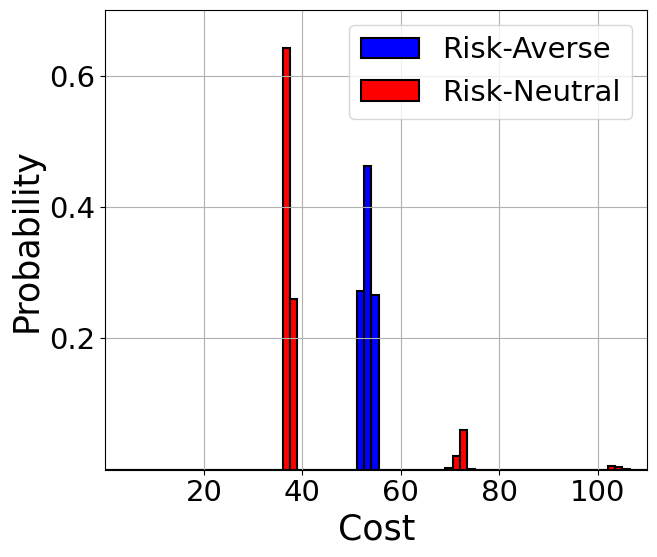

In [261]:
import matplotlib.pyplot as plt
plt.rc('font', size=21)

fig = plt.figure(figsize=(7, 6))

_ = plt.hist(x=SUPPORTS, weights=safe_6, bins=100, label='Risk-Averse', color='blue', edgecolor='black', linewidth=1.5)

_ = plt.hist(x=SUPPORTS, weights=short_6, bins=100, label='Risk-Neutral', color='red', edgecolor='black', linewidth=1.5)

plt.ylim(0.0, 0.7)
plt.yticks([0.2, 0.4, 0.6])
plt.ylabel('Probability', fontsize=25)


plt.xlim(0, 110)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Cost', fontsize=25)

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("./policy_evaluation.pdf", bbox_inches="tight", dpi=600, format="pdf")

### (2) Gradient

In [262]:
# Get the gradients
grad_90_mean_iter = np.mean([[np.linalg.norm(x, ord=np.inf) for x in grad_90_formal[i]] for i in range(10)], axis=0)
grad_90_std_iter = np.std([[np.linalg.norm(x, ord=np.inf) for x in grad_90_formal[i]] for i in range(10)], axis=0)
grad_0_mean_iter = np.mean([[np.linalg.norm(x, ord=np.inf) for x in grad_0_formal[i]] for i in range(10)], axis=0)
grad_0_std_iter = np.std([[np.linalg.norm(x, ord=np.inf) for x in grad_0_formal[i]] for i in range(10)], axis=0)

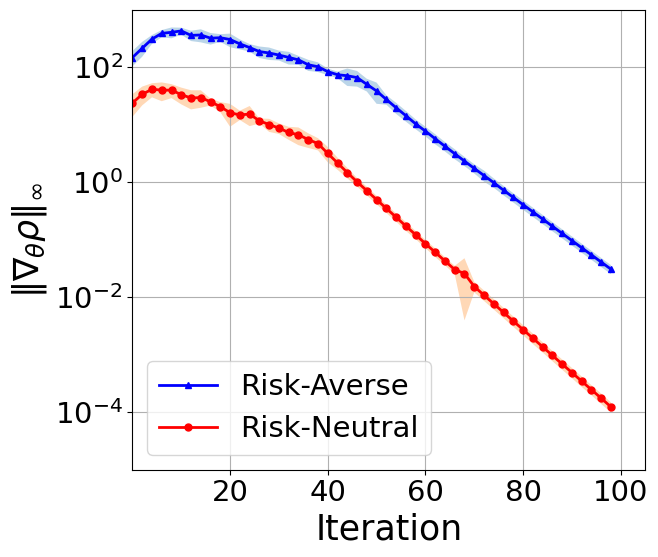

In [263]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

plt.plot(np.arange(0, 100, 2), grad_90_mean_iter[::2], '-^b', label='Risk-Averse', markersize=5, lw=2)
plt.fill_between(np.arange(0, 100, 2), 
                 (grad_90_mean_iter - 2 * grad_90_std_iter)[::2], 
                 (grad_90_mean_iter + 2 * grad_90_std_iter)[::2], 
                 alpha=0.3)

plt.plot(np.arange(0, 100, 2), grad_0_mean_iter[::2], '-or', label='Risk-Neutral', markersize=5, lw=2)
plt.fill_between(np.arange(0, 100, 2), 
                 (grad_0_mean_iter - 2 * grad_0_std_iter)[::2], 
                 (grad_0_mean_iter + 2 * grad_0_std_iter)[::2], 
                 alpha=0.3)


plt.yscale('log')
plt.ylim(1e-5,1e3)
plt.yticks([1e-4, 1e-2, 1e0, 1e2])
plt.ylabel(r'$\|\nabla_\theta\rho\|_\infty$', fontsize=25)


plt.xlim(0, 105)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)

plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("./gradient.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Test Cost

In [264]:
def compute_test_cost(theta):
    # avg_cost = 0
    
    env = CliffWalkingEnv(init_mode='original')
    env.reset()
    state, _ = env.reset_test()
    total_cost = 0
    
    for n_step in range(20):
        action = np.argmax(softmax_policy(state, theta))
        state, reward, done, truncated, info = env.step(action)
        total_cost += reward
        
        if done:
            break

    return total_cost

In [265]:
# Get the gradients
test_cost_90_iter = [[compute_test_cost(x) for x in theta_90_formal[i]] for i in range(10)]
test_cost_0_iter = [[compute_test_cost(x) for x in theta_0_formal[i]] for i in range(10)]

In [266]:
test_cost_90_mean_iter = np.mean(test_cost_90_iter, axis=0)
test_cost_90_std_iter = np.std(test_cost_90_iter, axis=0)

test_cost_0_mean_iter = np.mean(test_cost_0_iter, axis=0)
test_cost_0_std_iter = np.std(test_cost_0_iter, axis=0)

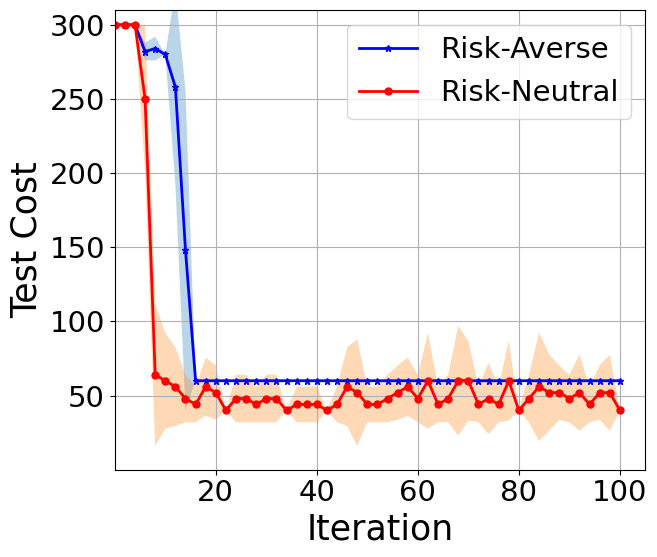

In [267]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

plt.plot(np.arange(0, 101, 2), test_cost_90_mean_iter[::2], '-*b', label='Risk-Averse', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (test_cost_90_mean_iter - test_cost_90_std_iter)[::2], 
                 (test_cost_90_mean_iter + test_cost_90_std_iter)[::2], 
                 alpha=0.3)

plt.plot(np.arange(0, 101, 2), test_cost_0_mean_iter[::2], '-or', label='Risk-Neutral', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (test_cost_0_mean_iter - test_cost_0_std_iter)[::2], 
                 (test_cost_0_mean_iter + test_cost_0_std_iter)[::2], 
                 alpha=0.3)


plt.ylim(0, 310)
plt.yticks([50, 100, 150, 200, 250, 300])
plt.ylabel('Test Cost', fontsize=25)


plt.xlim(0, 105)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)

plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("./test_cost_all.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Number of Fails

In [268]:
def compute_fails(theta):
    
    env = CliffWalkingEnv(init_mode='original')
    env.reset()
    state, _ = env.reset_test()
    fail = 0

    for n_step in range(10):
        action = np.argmax(softmax_policy(state, theta))
        state, reward, done, truncated, info = env.step(action)

        if reward == 30:
            fail += 1
            break
        
        if done:
            break

    if state != 8:
        fail += 1

    return fail

In [269]:
# Get the gradients
fail_90_iter = [[compute_fails(x) for x in theta_90_formal[i]] for i in range(10)]
fail_0_iter = [[compute_fails(x) for x in theta_0_formal[i]] for i in range(10)]

In [270]:
fail_90_mean_iter = np.mean(fail_90_iter, axis=0)
fail_90_std_iter = np.std(fail_90_iter, axis=0)

fail_0_mean_iter = np.mean(fail_0_iter, axis=0)
fail_0_std_iter = np.std(fail_0_iter, axis=0)

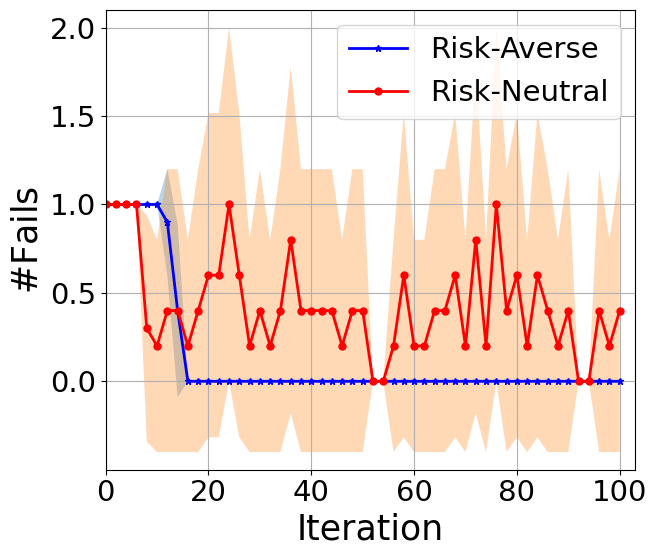

In [276]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

plt.plot(np.arange(0, 101, 2), fail_90_mean_iter[::2], '-*b', label='Risk-Averse', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (fail_90_mean_iter - fail_90_std_iter)[::2], 
                 (fail_90_mean_iter + fail_90_std_iter)[::2], 
                 alpha=0.3)

plt.plot(np.arange(0, 101, 2), fail_0_mean_iter[::2], '-or', label='Risk-Neutral', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (fail_0_mean_iter - fail_0_std_iter)[::2], 
                 (fail_0_mean_iter + fail_0_std_iter)[::2], 
                 alpha=0.3)


plt.ylim(-0.5, 2.1)
plt.yticks([0, 0.5, 1.0, 1.5, 2.0])
plt.ylabel('$\#$Fails', fontsize=25)

plt.xlim(0, 103)
plt.xticks([0, 20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)

plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("./fail.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Divergence

In [272]:
def divergence(theta):
    target = np.array([[1.0, 0.0, 0.0, 0.0], # 6
                       [1.0, 0.0, 0.0, 0.0], # 3
                       [0.0, 1.0, 0.0, 0.0], # 0
                       [0.0, 1.0, 0.0, 0.0], # 1
                       [0.0, 0.0, 1.0, 0.0], # 2
                       [0.0, 0.0, 1.0, 0.0]] # 5
                     )
    prob = np.array([softmax_policy(6, theta), 
                     softmax_policy(3, theta), 
                     softmax_policy(0, theta), 
                     softmax_policy(1, theta), 
                     softmax_policy(2, theta), 
                     softmax_policy(5, theta)]
                   )
    return np.linalg.norm(target - prob)

In [273]:
# Get the gradients
divergence_90_iter = [[divergence(x) for x in theta_90_formal[i]] for i in range(10)]
divergence_0_iter = [[divergence(x) for x in theta_0_formal[i]] for i in range(10)]

In [274]:
divergence_90_mean_iter = np.mean(divergence_90_iter, axis=0)
divergence_90_std_iter = np.std(divergence_90_iter, axis=0)

divergence_0_mean_iter = np.mean(divergence_0_iter, axis=0)
divergence_0_std_iter = np.std(divergence_0_iter, axis=0)

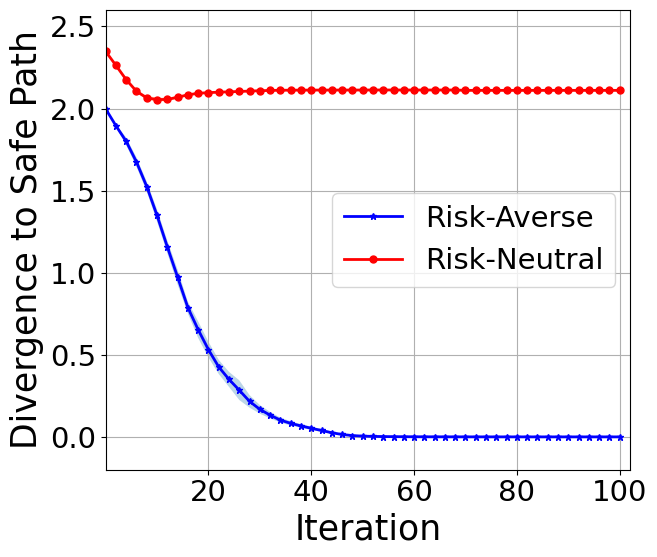

In [275]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

plt.plot(np.arange(0, 101, 2), divergence_90_mean_iter[::2], '-*b', label='Risk-Averse', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (divergence_90_mean_iter - divergence_90_std_iter)[::2], 
                 (divergence_90_mean_iter + divergence_90_std_iter)[::2], 
                 alpha=0.3)

plt.plot(np.arange(0, 101, 2), divergence_0_mean_iter[::2], '-or', label='Risk-Neutral', markersize=5, lw=2)
plt.fill_between(np.arange(0, 101, 2), 
                 (divergence_0_mean_iter - divergence_0_std_iter)[::2], 
                 (divergence_0_mean_iter + divergence_0_std_iter)[::2], 
                 alpha=0.3)


plt.ylim(-0.2, 2.6)
plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.ylabel('Divergence to Safe Path', fontsize=25)

plt.xlim(0, 102)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)

plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("./divergence.pdf", bbox_inches="tight", dpi=600, format="pdf")